# Error analysis notebook (test data)

## Import packages

In [2]:
import pandas as pd
import math

import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from elasticsearch import Elasticsearch

import warnings
import matplotlib
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
warnings.filterwarnings("ignore")

from enum import IntEnum



# theta 0.99, meta

## Set filepaths

#### Meta, DocHLevel

In [3]:
ranking = '../evaluation/resources/2020/jsonruns/p_controller_train_nle_meta_99_1_train.json'
eval_result_hlevel = '../evaluation/resources/2020/eval_results/p_controller_train_nle_meta_99_1_train_hlevel.tsv'
eval_result_level = '../evaluation/resources/2020/eval_results/p_controller_train_nle_meta_99_1_train_level.tsv'
gt = '../pre_processing/resources/training/2020/TREC-Fair-Ranking-training-sample.json'
est_rel_meta_p = '../reranking/resources/relevances/Training_rel_scores_model_A.csv'
annotations = '../pre_pre_processing/resources/merged-annotations.json'

## Prepare dataframes

In [4]:
# ranking df
rdf = pd.read_json(ranking, lines=True)

# ground truth df
gtdf = pd.read_json(gt, lines=True).explode('documents')
gtdf['doc_id'] = gtdf.documents.apply(lambda row: row.get('doc_id'))
gtdf['doc_rel'] = gtdf.documents.apply(lambda row: row.get('relevance'))

# paired down relevances df
reldf = gtdf[['qid','query','doc_id','doc_rel']]

# eval result dfs
ehldf = pd.read_csv(eval_result_hlevel, sep='\t', names=['key', 'qid', 'value'])
ehldf = ehldf.pivot(index='qid', columns='key', values='value')

eldf = pd.read_csv(eval_result_level, sep='\t', names=['key', 'qid', 'value'])
eldf = eldf.pivot(index='qid', columns='key', values='value')


# est rel df
est_rel_meta = pd.read_csv(est_rel_meta_p)
est_rel_meta.head()

# annotations
adf = pd.read_json(annotations,lines=True)
adf = adf.explode('authors')
adf[['name','wiki','country','type','valid','auth_id', 'h_index','level','region']] = adf.authors.apply(pd.Series).rename({'id':'auth_id'},axis=1)

In [5]:
rdf.head(2)

q_num   qid                                            ranking
0    0.0  5438  [b2fdee22aa02477292b858fbafcb418932732bce, 993...
1    0.1  5438  [b2fdee22aa02477292b858fbafcb418932732bce, 993...

In [6]:
gtdf.head(2)

qid            query  frequency  \
0  5438  cloud computing   0.000057   
0  5438  cloud computing   0.000057   

                                           documents  \
0  {'doc_id': '3e19046c665867bbe557685da60738a407...   
0  {'doc_id': '7ef08f1fa127af817cdfd9d3bd00bdf60e...   

                                     doc_id  doc_rel  
0  3e19046c665867bbe557685da60738a40738010a        0  
0  7ef08f1fa127af817cdfd9d3bd00bdf60e32143b        0

In [7]:
reldf.head(2)

qid            query                                    doc_id  doc_rel
0  5438  cloud computing  3e19046c665867bbe557685da60738a40738010a        0
0  5438  cloud computing  7ef08f1fa127af817cdfd9d3bd00bdf60e32143b        0

In [8]:
ehldf.head(2)

key  difference  disparity  relevance
qid                                  
69     0.149930   2.873259   2.278765
258    0.575252   1.034694   0.661701

In [9]:
eldf.head(2)

key  difference  disparity  relevance
qid                                  
69     0.211055   3.319766   2.490167
258    0.459391   2.206123   1.346999

In [10]:
adf.head(2)

id  missing_authors  \
0  f3b7db81ee8642cf2deab7a9834e07b8df54185b            False   
0  f3b7db81ee8642cf2deab7a9834e07b8df54185b            False   

                                             authors                name  \
0  {'name': 'David M. Szymanski', 'wiki': 'Texas ...  David M. Szymanski   
0  {'name': 'David H. Henard', 'wiki': 'North Car...     David H. Henard   

                              wiki country      type  valid      auth_id  \
0             Texas A&M University      US  academic   True   50215565.0   
0  North Carolina State University      US  academic   True  115002169.0   

   h_index     level    region  
0      9.0  Advanced  Americas  
0      8.0  Advanced  Americas

## Extract information for specific query

Helper methods.

In [11]:
def extract_results_based_on_qid(qid, ranking_df):
    return ranking_df[ranking_df.qid == qid]

def extract_relevances_based_on_qid(qid, relevance_df):
    return relevance_df[relevance_df.qid == qid]

In [12]:
def count_relgrades(relevance_df):
    rel_counts = relevance_df.doc_rel.value_counts()
    rel_count = rel_counts[1]
    nonrel_count = rel_counts[0]
    return rel_count, nonrel_count

def count_relgrades_qid(qid, relevance):
    subrelevance = extract_relevances_based_on_qid(qid, relevance)
    return count_relgrades(subrelevance)


## Visualization

We use different visualizations to gain more insight into the way rankings are formed.

- Given a query with N documents to be re-ranked, for each rank in a list of size N we compute the number of times a relevant or non-relevant item appears at this rank. For poorly performing queries, we expect to see more non-relevant items in top positions and fewer relevant items. These plots can show us whether the relevant items occur towards the middle or the back of the rankings instead.
    - We either plot the relevant and non-relevant items per rank in the same plot, or in separate plots. The separate plots are more readable, since the number of relevant and non-relevant documents across 150 rankings are in different orders of magnitude.
    
    
- Given a query with N documents to be re-ranked, for a specific rank in a list of size N we compute how often each of the documents occurs at that rank. We color-code the documents by relevant/non-relevant. In an ideal scenario, we expect all relevant documents to occur roughly equally as often at the top positions, and more often than non-relevant documents at that. For non-relevant documents, we expect the same behavior at bottom positions. Departures from this behavior can show us whether there are documents that are treated differently than they should. Inspecting these documents may teach us more about *why* they show up in a place where they do not belong.


- Complementary to the previous plot, we show the number of times each document occurs in a "top" or in a "bottom" position. Under the expected exposure model [2], an ideal ranking is any ranking where all documents with a higher relevance grade are followed by all documents with a lower relevance grade. For example, if doc1 and doc2 both have relevance 1, then a ranking that starts as [doc1, doc2, ...] is identical in quality to one that starts with [doc2, doc1, ...]. A "top" position is then any position with rank <= # relevant documents, and a "bottom" position is any position with rank > # relevant documents. 

  In an ideal scenario, we expect each relevant document to occur equally as often in a "top" position, and each non-relevant document to occur equally as often in a "bottom" position. The additional information gained by this plot compared to the previous plot is that we can see whether there are documents that are systematically in a "wrong" (top if they are non-relevant, bottom if they are relevant) position, where the previous plot only shows if they are missing from a *specific* top or bottom rank.

- 


We visualize how often a ranking position is occupied by a relevant versus a non-relevant document, aggregated over all 150 returned rankings for that query.


In [13]:
def plot_rel_nonrel_per_rank(data):
    """Plot the number of times a (non)relevant item appeared at a rank."""
    
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    sns.barplot(x="rank", y="count", hue="relkind", data=data)

In [14]:
def plots_for_qid(qid,ranking,relevance,k=2):
    plot_rel_nonrel_per_rank_per_relkind_for_qid(qid, ranking, relevance, regline=False)
    plot_rel_nonrel_per_rank_per_relkind_for_qid(qid, ranking, relevance, regline=True)

    plot_doc_occurrence_per_rank_for_qid(qid, ranking, relevance,k)
    plot_doc_occurrence_per_rank_for_qid(qid, ranking, relevance,k,rev=True)
    plot_doc_pos_count_for_qid(qid, ranking, relevance)

## Error analysis template
For each ranker and grouping, we answer the following questions to gain insight into the points of failure of the ranker.

1. How often were top positions occupied by relevant documents? Can these documents be categorized and distinguished from other documents?
2. How often were top positions occupied by non-relevant documents? Can these documents be categorized and distinguished from other documents?
3. Which relevant documents appear rarely or not at all in the top positions? Why did these documents not appear in the top positions more often?
4. How does the distribution of disparity, relevance, and constant terms change with increasing query difficulty?
5. What obvious mistakes did the system make that it could have easily avoided?
7. Other features of note  
    a. Number of top positions for this query.
8. What should the system do to improve performance?
9. What added information would be helpful? How can the system get that information?
10. Are there differences between the NIST assessment of documents and your own assessment?

## Select queries/rankings to inspect

[1] select the queries/rankings to inspect based on the MAP value of the rankings. One of the criteria is to select queries whose ranking's MAP is lower than the average for all queries/systems. The metric for our system is Difference in Group Expected Exposure (DGEE). We look at which queries are the easiest and most difficult for this ranker by ordering the queries by increasing DGEE. A point of interest here is that DGEE depends on the chosen grouping. Therefore, we look at the ordering for two different groupings, and then see if they agree with each other/take the average of the two orderings.

In [15]:
print("hlevel: ", ehldf.difference.mean(), "\tlevel: ", eldf.difference.mean())

hlevel:  0.43027952999999997 	level:  0.42471501500000003


In [16]:
print("# docs with DGEE below/above mean")
print("hlevel\t<: ", len(ehldf[ehldf.difference > ehldf.difference.mean()]), "\t >: ", len(ehldf[ehldf.difference <= ehldf.difference.mean()]))
print("level\t<: ", len(eldf[eldf.difference > eldf.difference.mean()]), "\t >: ", len(eldf[eldf.difference <= eldf.difference.mean()]))

# docs with DGEE below/above mean
hlevel	<:  64 	 >:  136
level	<:  65 	 >:  135


The worst ten queries are:

In [16]:
worstquerieshl = ehldf.sort_values(by='difference',ascending=False).head(10)
worstqueriesl = eldf.sort_values(by='difference',ascending=False).head(10)

In [17]:
worstquerieshl

key     difference  disparity  relevance
qid                                     
111469    2.834201   2.170455   0.463842
31412     2.778232   2.016028   0.413475
33337     2.726048   2.320659   0.603397
47984     2.577560   2.464784   0.344646
5762      2.339087   1.462709   0.352224
11856     1.930131   1.856165   0.371319
125125    1.687319   1.136316   0.509687
84087     1.513666   1.270282   0.696999
76875     1.464672   1.654475   0.507753
30631     1.350312   1.633312   0.566124

In [18]:
worstqueriesl

key     difference  disparity  relevance
qid                                     
33337     2.721092   2.321960   0.606525
47984     2.516947   2.491764   0.392598
111469    2.113990   2.170805   0.443202
31412     1.963736   2.059793   0.465875
11856     1.949971   2.090150   0.490230
30631     1.908784   1.694742   0.712375
76875     1.684732   1.838814   0.898037
24848     1.675040   1.830550   0.884516
59905     1.356650   1.642870   0.556799
82759     1.303550   1.752618   1.087317

The best ten queries are:

In [19]:
bestquerieshl = ehldf.sort_values(by='difference',ascending=True).head(10)
bestqueriesl = eldf.sort_values(by='difference',ascending=True).head(10)

In [20]:
bestquerieshl

key     difference  disparity  relevance
qid                                     
132049    0.002713   1.421254   1.403715
71096     0.029287   1.975807   1.862498
21984     0.032334   1.367385   1.271935
15395     0.040510   2.053024   1.890567
52728     0.057478   1.047360   0.839632
35778     0.063421   2.324523   2.033133
96265     0.068044   1.389924   1.122292
5667      0.068762   1.593546   1.318426
46183     0.076931   1.775022   1.730961
82442     0.081747   2.560092   2.162663

In [21]:
bestqueriesl

key     difference  disparity  relevance
qid                                     
132049    0.002713   1.421254   1.403715
71096     0.026328   1.972820   1.862484
15395     0.026948   2.035232   1.888323
68960     0.055780   1.806684   1.757368
129480    0.062249   1.349351   1.105418
54538     0.067307   1.435857   1.134208
21984     0.071535   1.515766   1.326630
77011     0.074452   1.456289   1.180714
36824     0.078852   2.012095   1.869204
27887     0.090629   1.547831   1.174277

We order the queries from lowest to highest DGEE according to each grouping. Then we plot the "difficulty rank" of each query according to the "hlevel" grouping against its difficulty according to the "level" grouping. This allows us to see if the DGEE for both groupings is generally in accordance or not.

In [22]:
edf = pd.merge(ehldf.sort_values(by='difference').reset_index().reset_index(),eldf.sort_values(by='difference').reset_index().reset_index(),on='qid')
edf.head()

key  index_x     qid  difference_x  disparity_x  relevance_x  index_y  \
0          0  132049      0.002713     1.421254     1.403715        0   
1          1   71096      0.029287     1.975807     1.862498        1   
2          2   21984      0.032334     1.367385     1.271935        6   
3          3   15395      0.040510     2.053024     1.890567        2   
4          4   52728      0.057478     1.047360     0.839632       13   

key  difference_y  disparity_y  relevance_y  
0        0.002713     1.421254     1.403715  
1        0.026328     1.972820     1.862484  
2        0.071535     1.515766     1.326630  
3        0.026948     2.035232     1.888323  
4        0.098930     1.011948     0.728643

<AxesSubplot:xlabel='index_x', ylabel='index_y'>

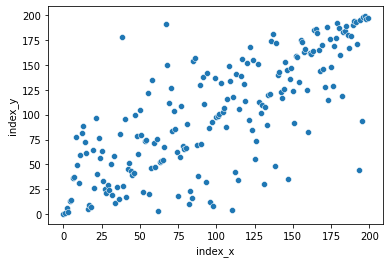

In [23]:
sns.scatterplot(data=edf, x='index_x', y='index_y')

We see a clear upward trend in the plot above. This tells us that in general, the DGEE according to the two groupings is similar. We would not expect great differences in the analysis results for different groupings.

In [24]:
edf['difference'] = edf.apply(lambda row: (row.difference_x + row.difference_y)/2, axis=1)
edf = edf.sort_values(by='difference')
edf.head()

key  index_x     qid  difference_x  disparity_x  relevance_x  index_y  \
0          0  132049      0.002713     1.421254     1.403715        0   
1          1   71096      0.029287     1.975807     1.862498        1   
3          3   15395      0.040510     2.053024     1.890567        2   
2          2   21984      0.032334     1.367385     1.271935        6   
4          4   52728      0.057478     1.047360     0.839632       13   

key  difference_y  disparity_y  relevance_y  difference  
0        0.002713     1.421254     1.403715    0.002713  
1        0.026328     1.972820     1.862484    0.027807  
3        0.026948     2.035232     1.888323    0.033729  
2        0.071535     1.515766     1.326630    0.051934  
4        0.098930     1.011948     0.728643    0.078204

## 1. How often were top positions occupied by relevant documents?
Can these documents be categorized and distinguished from others? We want to find out which characteristics of a document help the ranker to place it in the correct location.

### Methods count per rank

In [25]:
def count_rel_nonrel_per_rank(rankings_df, relevance_df):
    """rankings_df and relevance_df should already be reduced to the information for a single qid"""
    countdict = {k :{'r':0,'nr':0} for k in range(1,len(rankings_df['ranking'].iloc[0]) + 1)}
    for idx, row in rankings_df.iterrows():
        for i, doc in enumerate(row['ranking']):
            rel = relevance_df[relevance_df.doc_id == doc].doc_rel.iloc[0]
            if rel == 0:
                countdict[i+1]['nr'] = countdict[i+1]['nr'] + 1
            elif rel == 1:
                countdict[i+1]['r'] = countdict[i+1]['r'] + 1
            else:
                raise ValueError
    return countdict
            

In [26]:
def rel_nonrel_per_rank_counts_to_sns_df(countdict):
    unpacked = [record for reclist in [[{**{'rank':k},**{'relkind':k2,'count':v2}} for k2,v2 in v.items()] for k,v in countdict.items()] for record in reclist]
    return pd.DataFrame(unpacked)

In [27]:
def plot_rel_nonrel_per_rank_per_relkind(data,num_rel,regline=False):
    """Plot the number of times a (non)relevant item appeared at a rank, split by rank."""
    
    pi = iter(sns.color_palette())
    pi2 = iter(sns.color_palette('dark'))
    f = next(pi)
    f2 = next(pi2)
    s = next(pi)
    s2 = next(pi2)
    next(pi)
    next(pi2)
    t = next(pi)
    t2 = next(pi2)

    fig, ax = plt.subplots(1,2,figsize = (17.7,8.27))
    ax[0].title.set_text('Relevant item counts')
    ax[1].title.set_text('Nonrelevant item counts')

    colorsf = [f] * num_rel + [f2] * (len(data) - num_rel)
    colorss = [s] * num_rel + [s2] * (len(data) - num_rel)
    
    sns.barplot(x="rank", y="count", data=data[data.relkind=='r'],ax=ax[0],palette=sns.color_palette(colorsf))
    sns.barplot(x="rank", y="count", data=data[data.relkind=='nr'],ax=ax[1],palette=sns.color_palette(colorss))

    if regline:
        colorst = [t] * num_rel + [t2] * (len(data) - num_rel)
        sns.regplot(x="rank", y="count", data=data[data.relkind=='r'],ax=ax[0], scatter_kws={"s": 0}, palette=sns.color_palette(colorst))
        sns.regplot(x="rank", y="count", data=data[data.relkind=='nr'],ax=ax[1], scatter_kws={"s": 0},palette=sns.color_palette(colorst))
    return fig


In [28]:
def plot_rel_nonrel_per_rank_per_relkind_for_qid(qid, ranking, relevance, regline=False):
    subranking = extract_results_based_on_qid(qid, ranking)
    subrelevance = extract_relevances_based_on_qid(qid, relevance)
    
    num_rel_docs, num_nonrel_docs = count_relgrades(subrelevance)
    
    rel_nonrel_counts = count_rel_nonrel_per_rank(subranking, subrelevance)
    rel_nonrel_df = rel_nonrel_per_rank_counts_to_sns_df(rel_nonrel_counts)
    fig = plot_rel_nonrel_per_rank_per_relkind(rel_nonrel_df,num_rel_docs,regline=regline)
    fig.suptitle(f"(Non-)relevant documents per rank for {qid}, top={num_rel_docs}")
    

### Methods doc occurrence in top positions

In [29]:
def count_doc_occurrence_per_rank(rankings_df):
    """Count how often each document occurs at each rank."""
    count_per_doc_per_rank = {i: {} for i in list(range(1,len(rankings_df['ranking'].iloc[0]) + 1))}

    for idx, row in rankings_df.iterrows():
        for j, doc in enumerate(row['ranking']):
            i = j + 1
            if not doc in count_per_doc_per_rank[i]:
                count_per_doc_per_rank[i][doc] = 0
            count_per_doc_per_rank[i][doc] = count_per_doc_per_rank[i][doc] + 1
    return count_per_doc_per_rank

In [30]:
def doc_occurrence_per_rank_to_sns_df(occurrence_dict, relevance_df):
    unpacked = [d for dlist in [[{'rank':k, 'doc_id':k2, 'count':v2} for k2, v2 in v.items()] for k,v in occurrence_dict.items()] for d in dlist]
    unpacked_df = pd.DataFrame(unpacked)

    return pd.merge(unpacked_df,reldf[['doc_id','doc_rel']],on='doc_id',how='left')

In [31]:
def plot_doc_occurrence_per_rank(data, k=2, rev=False):
    """Show how often each document in :data: appears at each rank <= k."""
    sns.set_palette("tab10")
    pi = iter(sns.color_palette())
    first = next(pi)
    second = next(pi)
    
    data["doc_labels"] = data.doc_id.apply(lambda row: f"{row[:4]}...")
    
    fig, ax = plt.subplots(1, k, figsize = (9*k, 8))
    
    for i in range(0,k):
        rank = i + 1
        if rev:
            rank = len(set(data["rank"].to_list())) - rank
    
        thisaxdata = data[data['rank'] == rank].sort_values(by='count',ascending=False)
    
        clrs = [first if rel == 1 else second for rel in thisaxdata.doc_rel.to_list()]
        sns.barplot(x="doc_labels", y="count",palette=clrs, data=thisaxdata,ax=ax[i])
        ax[i].title.set_text(f'Rank {rank}')
        _ = ax[i].set_xticklabels(ax[i].get_xticklabels(),rotation = -70)
        ax[i].legend(labels=["rel","nonrel"], title='relkind')
        leg = ax[i].get_legend()
        leg.legendHandles[0].set_color(first)
        leg.legendHandles[1].set_color(second)
    return fig

In [32]:
def plot_doc_occurrence_per_rank_for_qid(qid, ranking, relevance, k=2, rev=False):
    subranking = extract_results_based_on_qid(qid, ranking)
    subrelevance = extract_relevances_based_on_qid(qid, relevance)

    doc_per_rank_counts = count_doc_occurrence_per_rank(subranking)
    rank_occurrence_df = doc_occurrence_per_rank_to_sns_df(doc_per_rank_counts, subrelevance)

    fig = plot_doc_occurrence_per_rank(rank_occurrence_df, k, rev)
    fig.suptitle(f"Document counts per rank for {qid}")
    
    

### Methods number of times a doc is in a top position

In [249]:
def count_pos_of_documents(ranking_df, num_relevant_docs):
    doc_pos_count_dict = {}

    for idx, row in ranking_df.iterrows():
        for i, doc in enumerate(row['ranking']):
            if not doc in doc_pos_count_dict:
                doc_pos_count_dict[doc] = {"top": 0, "bot": 0}
            if i < num_relevant_docs:
                doc_pos_count_dict[doc]["top"] = doc_pos_count_dict[doc]["top"] + 1
            else:
                doc_pos_count_dict[doc]["bot"] = doc_pos_count_dict[doc]["bot"] + 1

    return doc_pos_count_dict        

In [295]:
def document_pos_count_to_sns_df(doc_pos_count_dict, relevance_df):
    unpacked = [d for dlist in [[{'doc_id':k, 'pos':k2, 'count':v2} for k2, v2 in v.items()] for k,v in doc_pos_count_dict.items()] for d in dlist]
    unpacked_df = pd.DataFrame(unpacked)
    
    m = pd.merge(unpacked_df,relevance_df[['doc_id','doc_rel']],on='doc_id',how='left')
    return m.drop_duplicates()

In [296]:
def document_pos_count_df_for_qid(qid,ranking,relevance):
    subranking = extract_results_based_on_qid(qid, ranking)
    subrelevance = extract_relevances_based_on_qid(qid,relevance)
    num_rel_docs, num_nonrel_docs = count_relgrades(subrelevance)

    
    doc_position_counts = count_pos_of_documents(subranking, num_rel_docs)
    doc_pos_count_df = document_pos_count_to_sns_df(doc_position_counts, subrelevance)
    return doc_pos_count_df
    

In [312]:
def plot_doc_pos_count(data,numrel,numnrel,sortby=['count'],no_author_ids=None,div_bottom_by_150=False):
    """Plot how many times each document occurred in the top and bottom positions."""
    
    
    sns.set_palette("tab10")
    pi = iter(sns.color_palette())
    first = next(pi)
    second = next(pi)

    data["doc_labels"] = data.doc_id.apply(lambda row: f"{row[:4]}...")


    fig, ax = plt.subplots(1, 2, figsize = (18, 8))
    _ = ax[0].title.set_text(f'Occurrence of doc in top pos (k={numrel})')
    _ = ax[1].title.set_text(f'Occurrence of doc in bottom pos (k={numnrel})')

    for i, pos in enumerate(["top","bot"]):
        _ = ax[i].set_xticklabels(ax[i].get_xticklabels(),rotation = -70)
        thisaxdata = data[data['pos'] == pos].sort_values(by=sortby,ascending=False)
        
        if pos == "bot" and div_bottom_by_150:
            thisaxdata["count"] = thisaxdata["count"] / 150
        
        clrs = [first if rel == 1 else second for rel in thisaxdata.doc_rel.to_list()]
        
        sns.barplot(x="doc_labels", y="count",palette=clrs, data=thisaxdata,ax=ax[i])
        
        if no_author_ids:
            thisaxdata['secondcount'] = thisaxdata.apply(lambda row: row['count'] if row['doc_id'] in no_author_ids else 0, axis=1)
            sns.barplot(x="doc_labels", y="secondcount",palette=clrs, data=thisaxdata,ax=ax[i],hatch='//')
     
        ax[i].legend(labels=["rel","nonrel"], title='relkind')
        
        leg = ax[i].get_legend()
        leg.legendHandles[0].set_color(first)
        leg.legendHandles[1].set_color(second)
        
  
    return fig


In [313]:
def plot_doc_pos_count_for_qid(qid, ranking, relevance,sortby=['count'], no_author_ids=None, div_bottom_by_150=False):
    doc_pos_count_df = document_pos_count_df_for_qid(qid,ranking,relevance)
    subrelevance = extract_relevances_based_on_qid(qid,relevance)
    num_rel_docs, num_nonrel_docs = count_relgrades(subrelevance)
    fig = plot_doc_pos_count(doc_pos_count_df,num_rel_docs,num_nonrel_docs,sortby=sortby,no_author_ids=no_author_ids,div_bottom_by_150=div_bottom_by_150)

    fig.suptitle(f"Document position counts {qid}")

### Computation
1. What percentage of the top positions was occupied by relevant documents?  
    a. Which relevant documents were most often in a top position? 
        - More specifically: which relevant documents were more often in a top position than any other document for the ranking?    
            - Which relevant documents were among the top 75% of the documents in the top positions, frequency-wise.
2. What was their predicted relevance score?  
3. What was their author?  
    - Did their author write more of the documents in the ranking?

#### Percentage of relevant documents

In [38]:
for q in edf.head(10).qid.to_list():
    subrdf = extract_results_based_on_qid(q, rdf)
    subreldf = extract_relevances_based_on_qid(q, reldf)
    
    num_rel_docs, num_nonrel_docs = count_relgrades(subreldf)
    
    rel_nonrel_counts = count_rel_nonrel_per_rank(subrdf, subreldf)
    rel_nonrel_df = rel_nonrel_per_rank_counts_to_sns_df(rel_nonrel_counts)
    
    # doc_per_rank_counts = count_doc_occurrence_per_rank(subrdf)
    # rank_occurrence_df = doc_occurrence_per_rank_to_sns_df(doc_per_rank_counts, subreldf)
    
    top_with_rel_frac = round(rel_nonrel_df[(rel_nonrel_df['rank'] <= num_rel_docs) & (rel_nonrel_df['relkind'] == 'r')]['count'].sum() / (150 * num_rel_docs) * 100,2)
    print(q, "\t", top_with_rel_frac)

132049 	 78.92
71096 	 33.17
15395 	 36.33
21984 	 34.4
52728 	 33.62
54538 	 23.93
35778 	 22.0
77011 	 17.24
27887 	 32.28
96265 	 12.33


In [39]:
for q in edf.tail(10).iloc[::-1].qid.to_list():
    subrdf = extract_results_based_on_qid(q, rdf)
    subreldf = extract_relevances_based_on_qid(q, reldf)
    
    num_rel_docs, num_nonrel_docs = count_relgrades(subreldf)
    
    rel_nonrel_counts = count_rel_nonrel_per_rank(subrdf, subreldf)
    rel_nonrel_df = rel_nonrel_per_rank_counts_to_sns_df(rel_nonrel_counts)
    
    # doc_per_rank_counts = count_doc_occurrence_per_rank(subrdf)
    # rank_occurrence_df = doc_occurrence_per_rank_to_sns_df(doc_per_rank_counts, subreldf)
    
    top_with_rel_frac = round(rel_nonrel_df[(rel_nonrel_df['rank'] <= num_rel_docs) & (rel_nonrel_df['relkind'] == 'r')]['count'].sum() / (150 * num_rel_docs) * 100,2)
    print(q, "\t", top_with_rel_frac)

33337 	 7.33
47984 	 10.0
111469 	 8.67
31412 	 8.0
11856 	 9.0
30631 	 11.33
76875 	 19.0
24848 	 19.67
5762 	 5.33
82759 	 4.67


#### Most frequent relevant documents

In [40]:
toptoplist = []
print("\t".join(["qid","doc_id","pos","count","doc_rel"]))
for q in edf.head(10).qid.to_list():
    doc_pos_count = document_pos_count_df_for_qid(q,rdf,reldf)
    doc_pos_count = doc_pos_count[(doc_pos_count.pos == 'top')  & (doc_pos_count.doc_rel == 1)]
    doc_pos_count["qid"] = q
    maxcount = doc_pos_count["count"].max()
    toptoplist = toptoplist + doc_pos_count[doc_pos_count["count"] == maxcount].doc_id.to_list()
    print(doc_pos_count[["qid","doc_id","pos","count","doc_rel"]][doc_pos_count["count"] == maxcount].to_string(index = False, header=False))
    print()
toptoplist

qid	doc_id	pos	count	doc_rel
 132049  5a2de88464b2307f1fd89f3d84c6d507a49cb47f  top  19  1
 132049  8462f4b6590713db112d6fc665b43cfeb88bab41  top  19  1

 71096  6afc97668839a439e6858691ada76c9ddf798c2a  top  109  1

 15395  67cb7ec0f36f9396b85b18cad90c0d7eec1658ce  top  93  1

 21984  406d1ef750ba4520b8c57f95596cd42852c0e3fa  top  88  1

 52728  2a7e7fba70c6ad91e79b5d4fdd1f487551a808bb  top  21  1
 52728  5313735b8f660d43c9ec0adbc9ed3c1e8d7da85c  top  21  1

 54538  6621f6f8087226645cc00120a9b14da4354518ca  top  15  1

 35778  e9a499241fcdf3802a9bc7d9d84d48ee4e8c5fcc  top  37  1

 77011  eadd6edc8a0dc4126b467ad3e45097ed86a456c9  top  11  1

 27887  2423ea8cf66765d79363988086bf0f6066a13872  top  7  1
 27887  d253458401932876e55c3a2a7cb7718e57dd8160  top  7  1
 27887  1d1ab0f586eadfa1054be723d58f6cef2fba0e6d  top  7  1
 27887  88228be96774ec5cf3757296c7238a6efbd91598  top  7  1
 27887  bbab30c44043235190726a7b0796d66df69cc84b  top  7  1
 27887  f56a4e7e9cd1ac1e9d7c7a74cdd965f12e97b113  

['5a2de88464b2307f1fd89f3d84c6d507a49cb47f',
 '8462f4b6590713db112d6fc665b43cfeb88bab41',
 '6afc97668839a439e6858691ada76c9ddf798c2a',
 '67cb7ec0f36f9396b85b18cad90c0d7eec1658ce',
 '406d1ef750ba4520b8c57f95596cd42852c0e3fa',
 '2a7e7fba70c6ad91e79b5d4fdd1f487551a808bb',
 '5313735b8f660d43c9ec0adbc9ed3c1e8d7da85c',
 '6621f6f8087226645cc00120a9b14da4354518ca',
 'e9a499241fcdf3802a9bc7d9d84d48ee4e8c5fcc',
 'eadd6edc8a0dc4126b467ad3e45097ed86a456c9',
 '2423ea8cf66765d79363988086bf0f6066a13872',
 'd253458401932876e55c3a2a7cb7718e57dd8160',
 '1d1ab0f586eadfa1054be723d58f6cef2fba0e6d',
 '88228be96774ec5cf3757296c7238a6efbd91598',
 'bbab30c44043235190726a7b0796d66df69cc84b',
 'f56a4e7e9cd1ac1e9d7c7a74cdd965f12e97b113',
 '1c2fc3db949b0ec866ba6a636182860754def193']

In [41]:
tailtoplist = []
print("\t".join(["qid","doc_id","pos","count","doc_rel"]))
for q in edf.tail(10).qid.to_list():
    doc_pos_count = document_pos_count_df_for_qid(q,rdf,reldf)
    doc_pos_count = doc_pos_count[(doc_pos_count.pos == 'top') & (doc_pos_count.doc_rel == 1)]
    doc_pos_count["qid"] = q
    maxcount = doc_pos_count["count"].max()
    tailtoplist = tailtoplist + doc_pos_count[doc_pos_count["count"] == maxcount].doc_id.to_list()
    print(doc_pos_count[["qid","doc_id","pos","count","doc_rel"]][doc_pos_count["count"] == maxcount].to_string(index = False, header=False))
    print()
tailtoplist

qid	doc_id	pos	count	doc_rel
 82759  739cf634cd54b21acbf3aea035bbac2c6f877154  top  10  1

 5762  f8a27b6591312fba8108500ab2e8275c92009a71  top  13  1

 24848  dfe6cbeae293613e33f90450d43c89681898a2a9  top  31  1

 76875  76e199fcf5537c4e8ef774d792afd2978aa11ebb  top  37  1

 30631  ab609df01b35223d4c1ec4d6fe84cfe349ad608b  top  19  1

 11856  fa4ddfc3df658ae1451047ed8904a3184154ad2a  top  14  1

 31412  59ab54f50c6a278425bdbf115921bd2f94923e28  top  13  1

 111469  34b6de1aee17441021e62b63c543abc1c28b0928  top  13  1
 111469  647444c4963ddac18626a4d2817eb85e438405c0  top  13  1

 47984  96fb6950aba868ff4a6e8f96bd232cf84e5c6da3  top  20  1

 33337  4244f5595bc6ddf93eb0e5c568b5967134652f27  top  11  1
 33337  f33c709a637322a2eec2ab2d35cb4f17f3da9f71  top  11  1



['739cf634cd54b21acbf3aea035bbac2c6f877154',
 'f8a27b6591312fba8108500ab2e8275c92009a71',
 'dfe6cbeae293613e33f90450d43c89681898a2a9',
 '76e199fcf5537c4e8ef774d792afd2978aa11ebb',
 'ab609df01b35223d4c1ec4d6fe84cfe349ad608b',
 'fa4ddfc3df658ae1451047ed8904a3184154ad2a',
 '59ab54f50c6a278425bdbf115921bd2f94923e28',
 '34b6de1aee17441021e62b63c543abc1c28b0928',
 '647444c4963ddac18626a4d2817eb85e438405c0',
 '96fb6950aba868ff4a6e8f96bd232cf84e5c6da3',
 '4244f5595bc6ddf93eb0e5c568b5967134652f27',
 'f33c709a637322a2eec2ab2d35cb4f17f3da9f71']

#### Top 25% relevant documents

We find the documents that are in the upper 25 quantile.

In [129]:
inspectlist_top = []
inspectdf  = pd.DataFrame(columns=['qid','doc_id','pos','count','doc_rel','topbot'])
print("\t".join(["qid","doc_id","pos","count","doc_rel"]))
for q in edf.head(10).qid.to_list():
    doc_pos_count = document_pos_count_df_for_qid(q,rdf,reldf)
    
    if q == 71096:
        doc_pos_count = doc_pos_count[doc_pos_count.doc_id != '6afc97668839a439e6858691ada76c9ddf798c2a']
    if q == 15395:
        doc_pos_count = doc_pos_count[doc_pos_count.doc_id != '67cb7ec0f36f9396b85b18cad90c0d7eec1658ce']
    if q == 21984:
        doc_pos_count = doc_pos_count[doc_pos_count.doc_id != '406d1ef750ba4520b8c57f95596cd42852c0e3fa']
    
    doc_pos_count = doc_pos_count[(doc_pos_count.pos == 'top')]
    doc_pos_count = doc_pos_count.sort_values(by='count', ascending=False)
    # print(doc_pos_count)
    # print( doc_pos_count['count'].quantile(0.75))
    doc_pos_count = doc_pos_count[doc_pos_count['count'] >= doc_pos_count['count'].quantile(0.75)]

    doc_pos_count = doc_pos_count[doc_pos_count.doc_rel == 1]
    inspectlist_top = inspectlist_top + doc_pos_count.doc_id.to_list()
    doc_pos_count["qid"] = q
    doc_pos_count['topbot'] = 'top'
    inspectdf = inspectdf.append(doc_pos_count)
    print(doc_pos_count[["qid","doc_id","pos","count","doc_rel"]].to_string(index = False, header=False))
    print()
inspectdf

qid	doc_id	pos	count	doc_rel
 132049  8462f4b6590713db112d6fc665b43cfeb88bab41  top  19  1
 132049  5a2de88464b2307f1fd89f3d84c6d507a49cb47f  top  19  1
 132049  5f91afa4ba1591dfd9d35450ac07f41dca1ce4f6  top  18  1
 132049  7dff8a6d32efbaa16fb7510b9c3347985de71596  top  18  1
 132049  6c6fc8896569067cf30b0f2349933c7462809912  top  18  1
 132049  0560a08ef071d54a60f2efac0bf3a6505ae36910  top  18  1

 71096  00525dd393d8a3a72e584eda8328ace8d43f3c0e  top  9  1
 71096  71aa55b1a189ec609ee865df4453ebb538c3ee0e  top  8  1

Empty DataFrame
Columns: [qid, doc_id, pos, count, doc_rel]
Index: []

 21984  a4989444cddd8619625492c4ceb037bb496ad253  top  16  1
 21984  8bc8fa66c5884414993465b4d361c99ce439ab57  top  14  1

 52728  2a7e7fba70c6ad91e79b5d4fdd1f487551a808bb  top  21  1
 52728  5313735b8f660d43c9ec0adbc9ed3c1e8d7da85c  top  21  1
 52728  f6d9f8a64f20c26d83b0b0cdc5c9131c1822858c  top  19  1
 52728  9a8dbcfe52e24d631784ce9e129593c3fdd81023  top  19  1
 52728  153550ab4a88092f8eac151479e36e0

count                                    doc_id doc_rel  pos     qid topbot
24    19  8462f4b6590713db112d6fc665b43cfeb88bab41       1  top  132049    top
8     19  5a2de88464b2307f1fd89f3d84c6d507a49cb47f       1  top  132049    top
0     18  5f91afa4ba1591dfd9d35450ac07f41dca1ce4f6       1  top  132049    top
10    18  7dff8a6d32efbaa16fb7510b9c3347985de71596       1  top  132049    top
2     18  6c6fc8896569067cf30b0f2349933c7462809912       1  top  132049    top
26    18  0560a08ef071d54a60f2efac0bf3a6505ae36910       1  top  132049    top
12     9  00525dd393d8a3a72e584eda8328ace8d43f3c0e       1  top   71096    top
28     8  71aa55b1a189ec609ee865df4453ebb538c3ee0e       1  top   71096    top
20    16  a4989444cddd8619625492c4ceb037bb496ad253       1  top   21984    top
10    14  8bc8fa66c5884414993465b4d361c99ce439ab57       1  top   21984    top
2     21  2a7e7fba70c6ad91e79b5d4fdd1f487551a808bb       1  top   52728    top
11    21  5313735b8f660d43c9ec0adbc9ed3c1e8d7da85c       1  top   52728    top
0     19  f6d9f8a64f20c26d83b0b0cdc5c9131c1822858c       1  top   52728    top
8     19  9a8dbcfe52e24d631784ce9e129593c3fdd81023       1  top   52728    top
14    18  153550ab4a88092f8eac151479e36e053e9e37e9       1  top   52728    top
2     15  6621f6f8087226645cc00120a9b14da4354518ca       1  top   54538    top
12    14  879c8af3f0aca90e17e4008b7c914438bbee3495       1  top   54538    top
26    14  ebded89df9fa113da24ef71570430f64a143a7e3       1  top   54538    top
22    14  fcc873393eb944a39aa3f57e56c4af24ccf57bfc       1  top   54538    top
0     14  f0524d5c84f237d57c4a1071bd9dc52e701feb05       1  top   54538    top
8     13  88841efa234b4f6eeca9410e1654e818c72c6d90       1  top   54538    top
4     37  e9a499241fcdf3802a9bc7d9d84d48ee4e8c5fcc       1  top   35778    top
14    11  eadd6edc8a0dc4126b467ad3e45097ed86a456c9       1  top   77011    top
16    10  76ed97deeac2bb2ec4e63e6abd4a7d3f522501dd       1  top   77011    top
8     10  4256284e490148a718772a28a917c69bb3022199       1  top   77011    top
22    10  e67d3aa62e94d370e957b0502762803ec43c14b2       1  top   77011    top
46     7  bbab30c44043235190726a7b0796d66df69cc84b       1  top   27887    top
36     7  88228be96774ec5cf3757296c7238a6efbd91598       1  top   27887    top
58     7  f56a4e7e9cd1ac1e9d7c7a74cdd965f12e97b113       1  top   27887    top
4      7  2423ea8cf66765d79363988086bf0f6066a13872       1  top   27887    top
6      7  d253458401932876e55c3a2a7cb7718e57dd8160       1  top   27887    top
10     7  1d1ab0f586eadfa1054be723d58f6cef2fba0e6d       1  top   27887    top
8     19  1c2fc3db949b0ec866ba6a636182860754def193       1  top   96265    top

In [130]:
inspectlist_bottom = []
print("\t".join(["qid","doc_id","pos","count","doc_rel"]))
for q in edf.tail(10).iloc[::-1].qid.to_list():
    # if not q in [82759,111469,31412,11856,30631]: 
        doc_pos_count = document_pos_count_df_for_qid(q,rdf,reldf)
        doc_pos_count = doc_pos_count[(doc_pos_count.pos == 'top')]
        doc_pos_count = doc_pos_count.sort_values(by='count', ascending=False)
        doc_pos_count = doc_pos_count[doc_pos_count['count'] >= doc_pos_count['count'].quantile(.75)]
        doc_pos_count = doc_pos_count[doc_pos_count.doc_rel == 1]
        
        inspectlist_bottom = inspectlist_bottom + doc_pos_count.doc_id.to_list()
        doc_pos_count["qid"] = q
        doc_pos_count['topbot'] = 'bot'
        inspectdf = inspectdf.append(doc_pos_count)
        print(doc_pos_count[["qid","doc_id","pos","count","doc_rel"]].to_string(index = False, header=False))
        print()
inspectlist_bottom
inspectdf

qid	doc_id	pos	count	doc_rel
 33337  f33c709a637322a2eec2ab2d35cb4f17f3da9f71  top  11  1
 33337  4244f5595bc6ddf93eb0e5c568b5967134652f27  top  11  1

 47984  96fb6950aba868ff4a6e8f96bd232cf84e5c6da3  top  20  1

Empty DataFrame
Columns: [qid, doc_id, pos, count, doc_rel]
Index: []

Empty DataFrame
Columns: [qid, doc_id, pos, count, doc_rel]
Index: []

 11856  fa4ddfc3df658ae1451047ed8904a3184154ad2a  top  14  1
 11856  ed754334e13b44d53523b65a807ebc23497623e7  top  13  1

 30631  ab609df01b35223d4c1ec4d6fe84cfe349ad608b  top  19  1
 30631  ccaea944996c0935897cd6eb248d5f01367cd3c4  top  15  1
 30631  ccaea944996c0935897cd6eb248d5f01367cd3c4  top  15  1

 76875  76e199fcf5537c4e8ef774d792afd2978aa11ebb  top  37  1

Empty DataFrame
Columns: [qid, doc_id, pos, count, doc_rel]
Index: []

Empty DataFrame
Columns: [qid, doc_id, pos, count, doc_rel]
Index: []

Empty DataFrame
Columns: [qid, doc_id, pos, count, doc_rel]
Index: []



count                                    doc_id doc_rel  pos     qid topbot
24    19  8462f4b6590713db112d6fc665b43cfeb88bab41       1  top  132049    top
8     19  5a2de88464b2307f1fd89f3d84c6d507a49cb47f       1  top  132049    top
0     18  5f91afa4ba1591dfd9d35450ac07f41dca1ce4f6       1  top  132049    top
10    18  7dff8a6d32efbaa16fb7510b9c3347985de71596       1  top  132049    top
2     18  6c6fc8896569067cf30b0f2349933c7462809912       1  top  132049    top
26    18  0560a08ef071d54a60f2efac0bf3a6505ae36910       1  top  132049    top
12     9  00525dd393d8a3a72e584eda8328ace8d43f3c0e       1  top   71096    top
28     8  71aa55b1a189ec609ee865df4453ebb538c3ee0e       1  top   71096    top
20    16  a4989444cddd8619625492c4ceb037bb496ad253       1  top   21984    top
10    14  8bc8fa66c5884414993465b4d361c99ce439ab57       1  top   21984    top
2     21  2a7e7fba70c6ad91e79b5d4fdd1f487551a808bb       1  top   52728    top
11    21  5313735b8f660d43c9ec0adbc9ed3c1e8d7da85c       1  top   52728    top
0     19  f6d9f8a64f20c26d83b0b0cdc5c9131c1822858c       1  top   52728    top
8     19  9a8dbcfe52e24d631784ce9e129593c3fdd81023       1  top   52728    top
14    18  153550ab4a88092f8eac151479e36e053e9e37e9       1  top   52728    top
2     15  6621f6f8087226645cc00120a9b14da4354518ca       1  top   54538    top
12    14  879c8af3f0aca90e17e4008b7c914438bbee3495       1  top   54538    top
26    14  ebded89df9fa113da24ef71570430f64a143a7e3       1  top   54538    top
22    14  fcc873393eb944a39aa3f57e56c4af24ccf57bfc       1  top   54538    top
0     14  f0524d5c84f237d57c4a1071bd9dc52e701feb05       1  top   54538    top
8     13  88841efa234b4f6eeca9410e1654e818c72c6d90       1  top   54538    top
4     37  e9a499241fcdf3802a9bc7d9d84d48ee4e8c5fcc       1  top   35778    top
14    11  eadd6edc8a0dc4126b467ad3e45097ed86a456c9       1  top   77011    top
16    10  76ed97deeac2bb2ec4e63e6abd4a7d3f522501dd       1  top   77011    top
8     10  4256284e490148a718772a28a917c69bb3022199       1  top   77011    top
22    10  e67d3aa62e94d370e957b0502762803ec43c14b2       1  top   77011    top
46     7  bbab30c44043235190726a7b0796d66df69cc84b       1  top   27887    top
36     7  88228be96774ec5cf3757296c7238a6efbd91598       1  top   27887    top
58     7  f56a4e7e9cd1ac1e9d7c7a74cdd965f12e97b113       1  top   27887    top
4      7  2423ea8cf66765d79363988086bf0f6066a13872       1  top   27887    top
6      7  d253458401932876e55c3a2a7cb7718e57dd8160       1  top   27887    top
10     7  1d1ab0f586eadfa1054be723d58f6cef2fba0e6d       1  top   27887    top
8     19  1c2fc3db949b0ec866ba6a636182860754def193       1  top   96265    top
12    11  f33c709a637322a2eec2ab2d35cb4f17f3da9f71       1  top   33337    bot
8     11  4244f5595bc6ddf93eb0e5c568b5967134652f27       1  top   33337    bot
10    20  96fb6950aba868ff4a6e8f96bd232cf84e5c6da3       1  top   47984    bot
0     14  fa4ddfc3df658ae1451047ed8904a3184154ad2a       1  top   11856    bot
6     13  ed754334e13b44d53523b65a807ebc23497623e7       1  top   11856    bot
40    19  ab609df01b35223d4c1ec4d6fe84cfe349ad608b       1  top   30631    bot
50    15  ccaea944996c0935897cd6eb248d5f01367cd3c4       1  top   30631    bot
49    15  ccaea944996c0935897cd6eb248d5f01367cd3c4       1  top   30631    bot
0     37  76e199fcf5537c4e8ef774d792afd2978aa11ebb       1  top   76875    bot

### Overlapping documents

There is little overlap between the documents returned for different queries. The following queries have documents that occur for more than one query.

In [42]:
temp = rdf.explode('ranking')[['qid','ranking']]
temp2 = temp.groupby('ranking')['qid'].apply(set).reset_index(name='qids')
temp2[temp2.qids.map(len) > 1].head()


ranking                  qids
2   001d90376ea9a5672e6a2b37ff468d6f3ee0a3e5  {52728, 48360, 2728}
17  00a407540a8bdd6d7425bd8a561eb21d69682511         {7163, 30631}
30  017e7c1bf71101c24c65aca784a4f867e8718ef1       {104830, 68183}
62  038a789bbb8f211176d5e9b0c8394bf6b6d2cc59  {16040, 18348, 2728}
85  04bc9c61c81c9125e39a6c52bee56f794e463a6f         {73836, 5438}

In [43]:
doubleqs = set([qid for qidlist in temp2[temp2.qids.map(len) > 1].qids.to_list() for qid in qidlist]).intersection(set(edf.head(10).qid.to_list() + edf.tail(10).qid.to_list()))
doubleqs

{5762, 30631, 31412, 52728, 111469}

In [44]:
temp3 = rdf[rdf.qid.isin(doubleqs)].explode("ranking").drop_duplicates().groupby("ranking")["qid"].apply(set).reset_index(name='qids')
temp3.head()

ranking     qids
0  001d90376ea9a5672e6a2b37ff468d6f3ee0a3e5  {52728}
1  00a407540a8bdd6d7425bd8a561eb21d69682511  {30631}
2  0e43caeb9d476264d307e8da0ad71ecc4d804ced  {30631}
3  153550ab4a88092f8eac151479e36e053e9e37e9  {52728}
4  1601e9f2bbf89f04f967a4f5f49d7adeca7f0719  {30631}

The queries which are both in the top/bottom 10 queries and have the same documents are 31412 and 30631. The coinciding documents are 3aebc8afc97439a26332526ba4c362771e332087 and 81b95e0483d32945aad0c09849f1a9b2022d59c4.

In [45]:
temp3[temp3.qids.map(len) > 1]

ranking            qids
20  3aebc8afc97439a26332526ba4c362771e332087  {31412, 30631}
59  81b95e0483d32945aad0c09849f1a9b2022d59c4  {31412, 30631}

### Visualization

For each rank, we show how often it is occupied by a relevant document. We show this for the top and bottom 10 queries so we can determine both what documents are placed in top positions on easy queries and which on difficult queries.

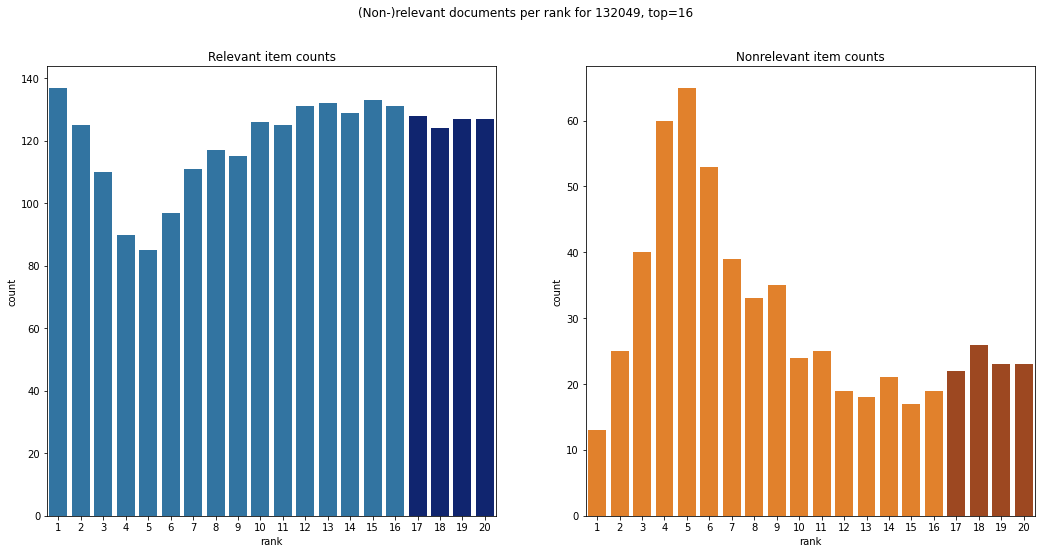

In [46]:
for q in edf.head(1).qid.to_list():
    plot_rel_nonrel_per_rank_per_relkind_for_qid(q, rdf, reldf)

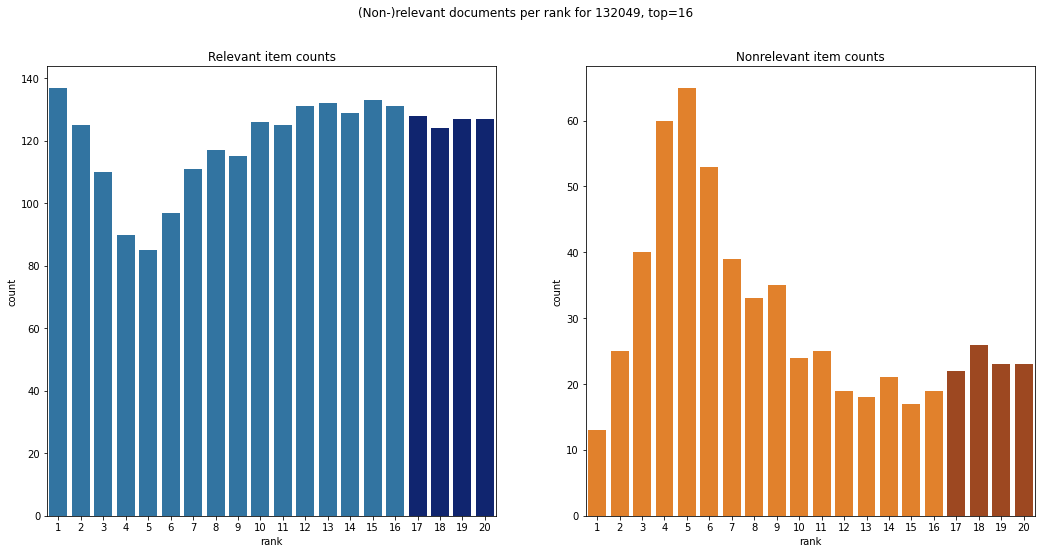

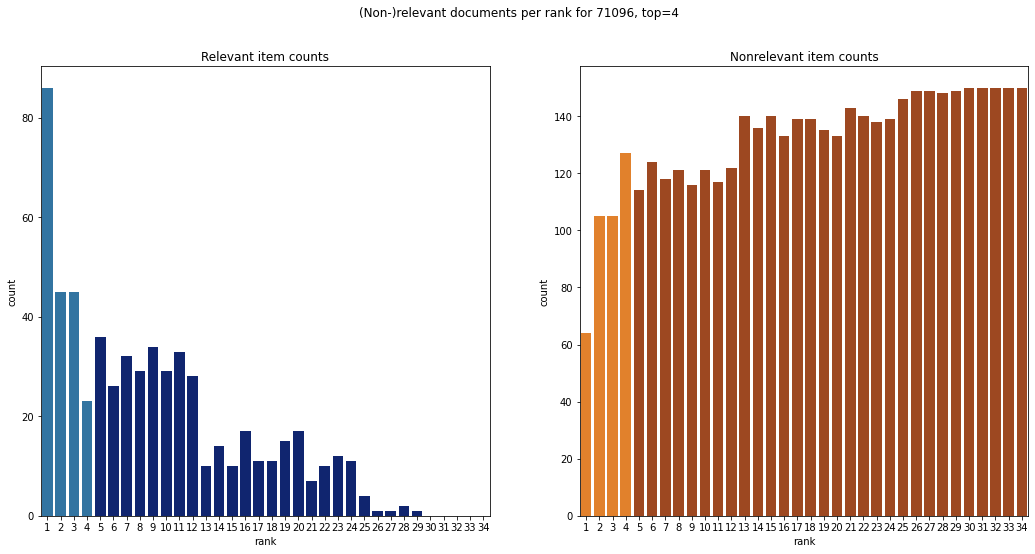

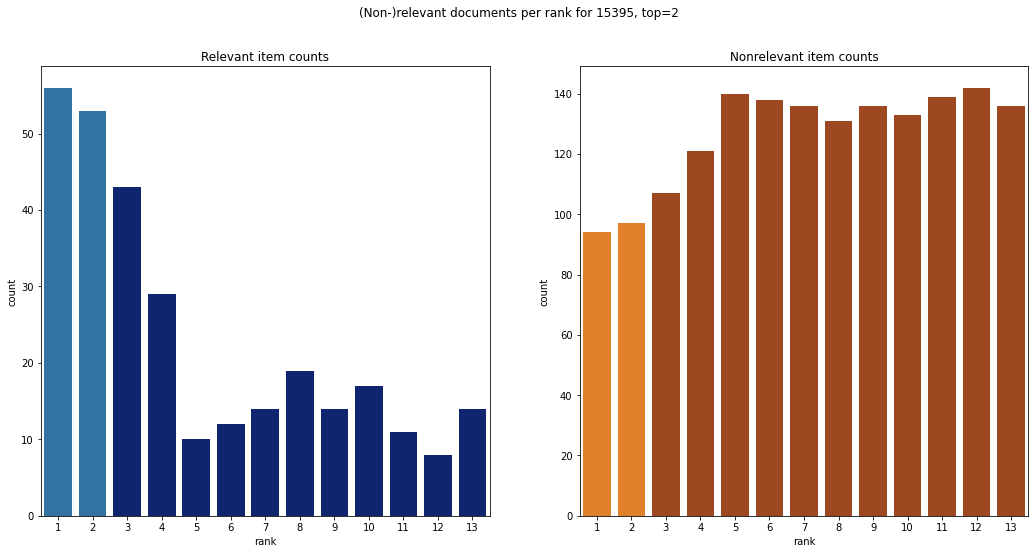

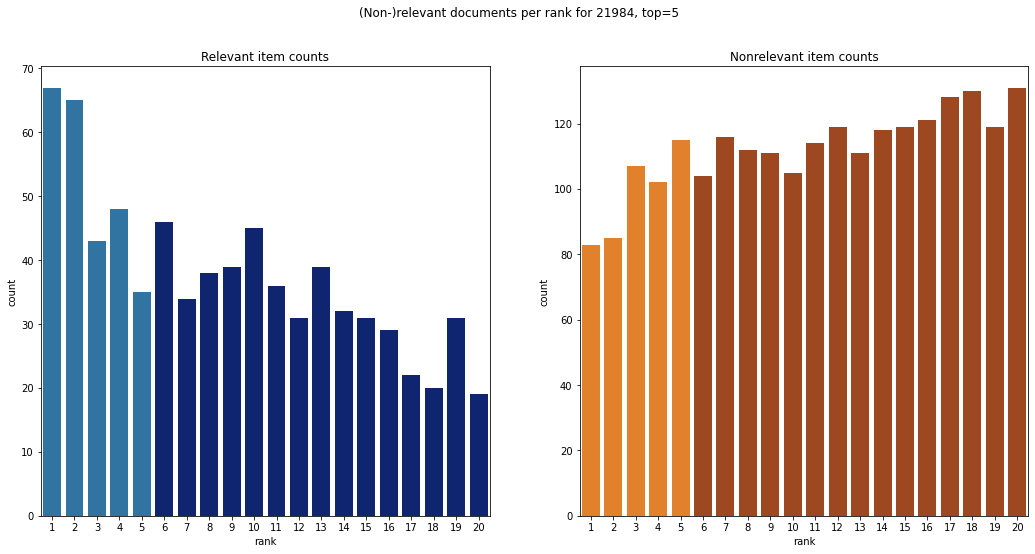

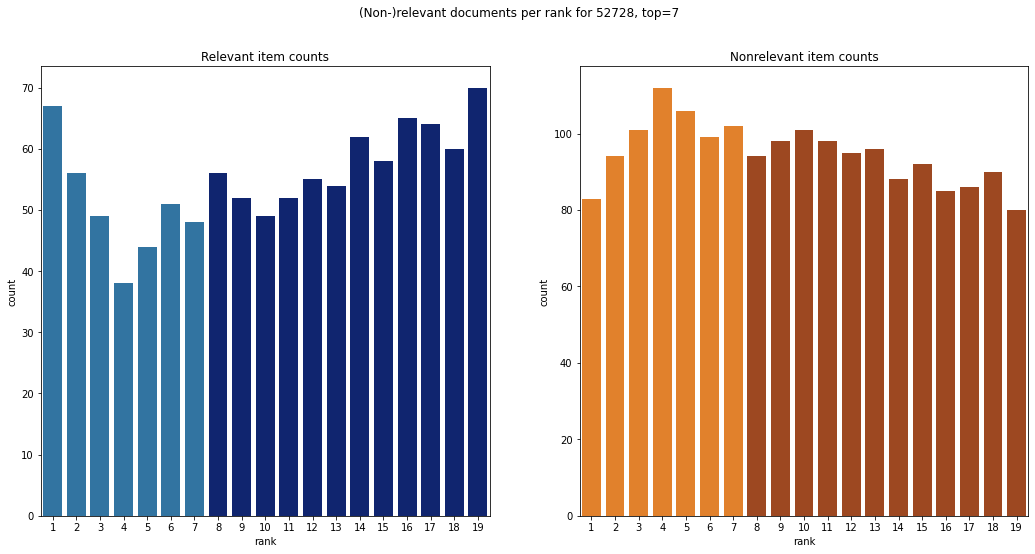

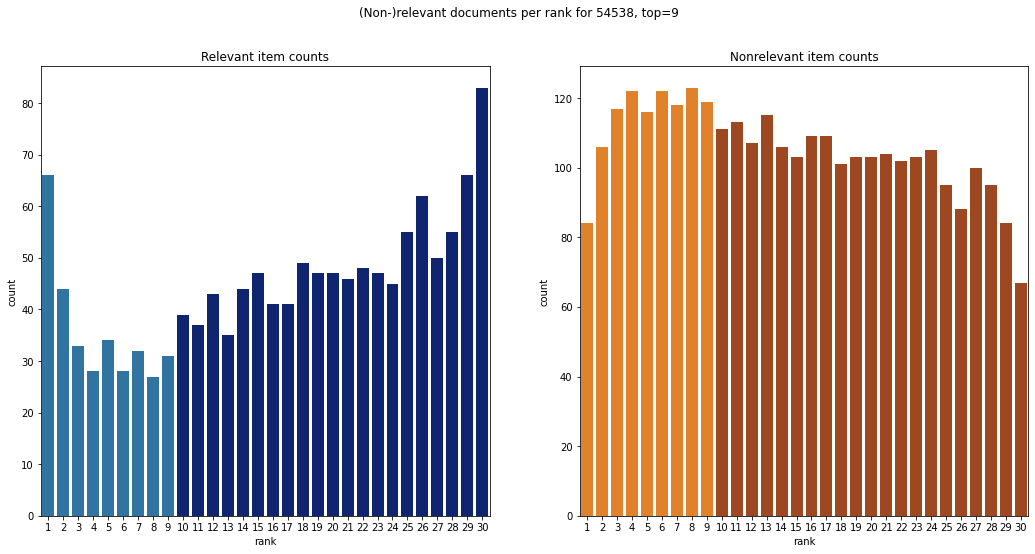

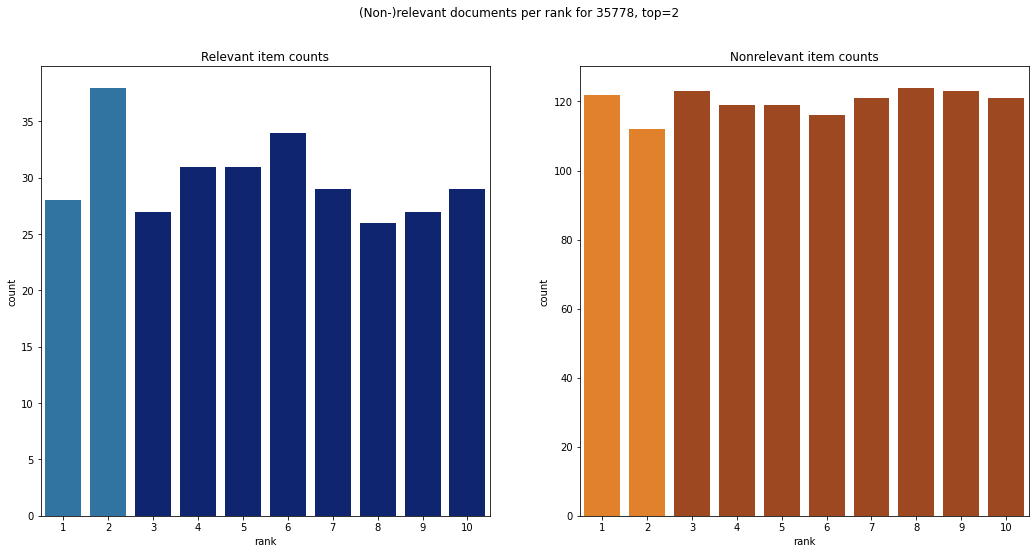

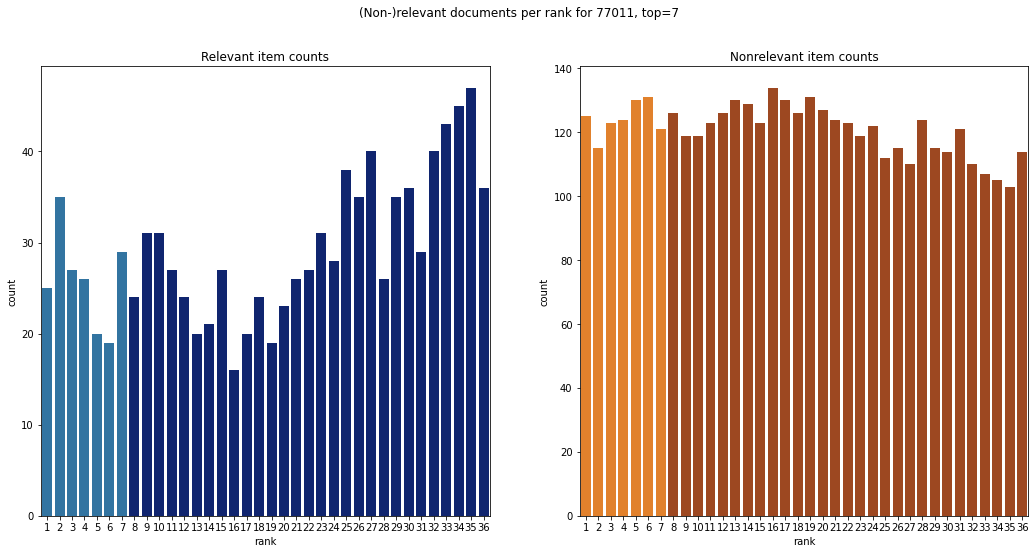

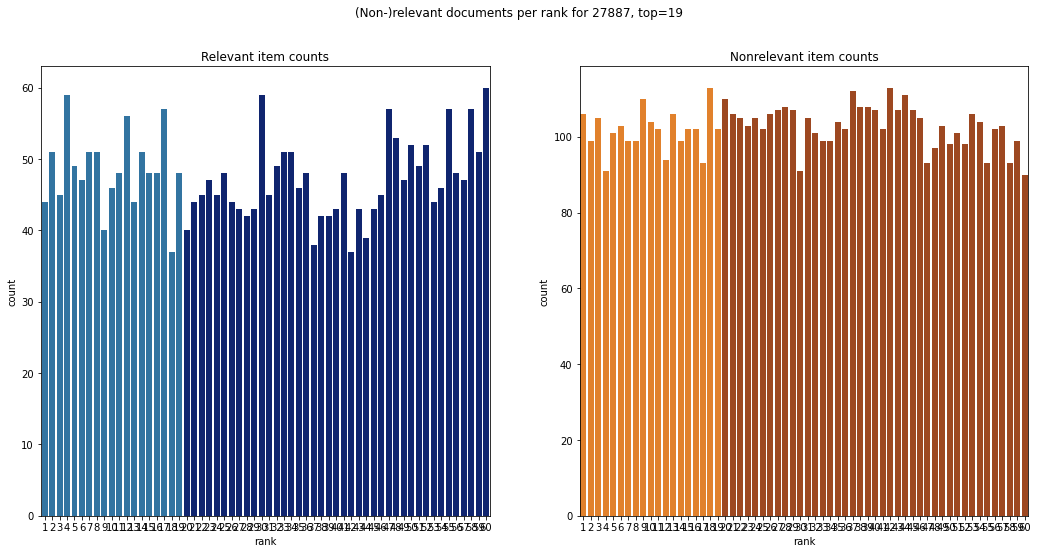

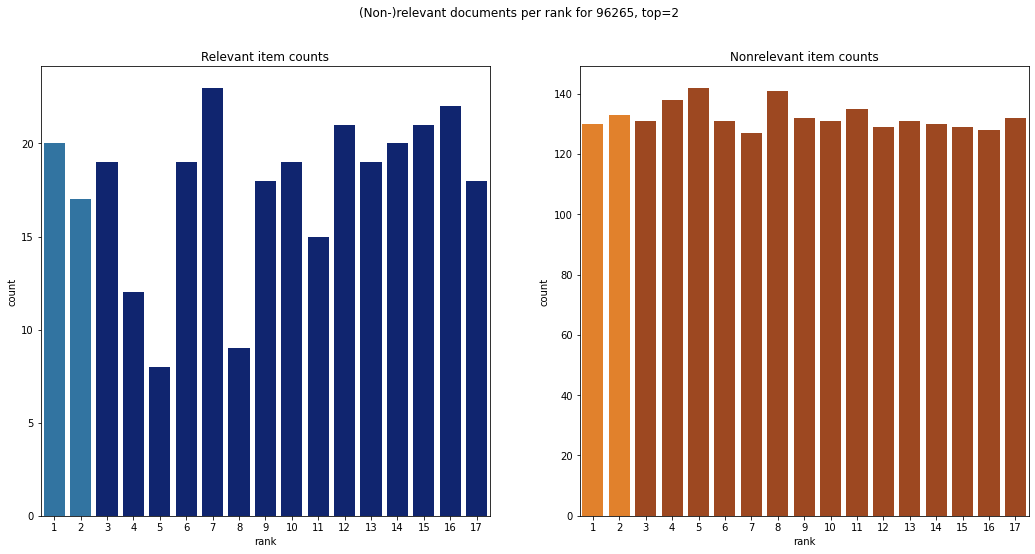

In [50]:
for q in edf.head(10).qid.to_list():
    plot_rel_nonrel_per_rank_per_relkind_for_qid(q, rdf, reldf)

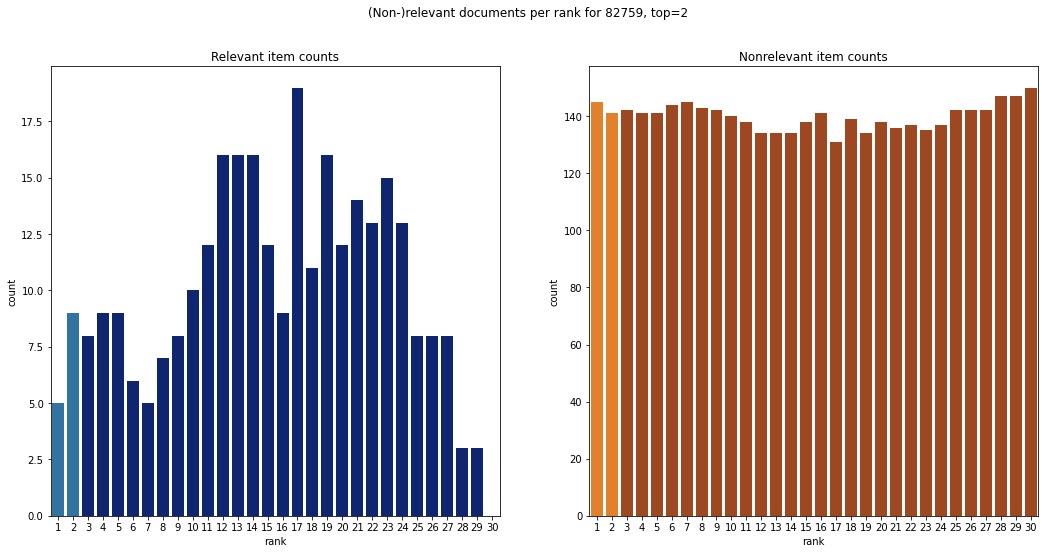

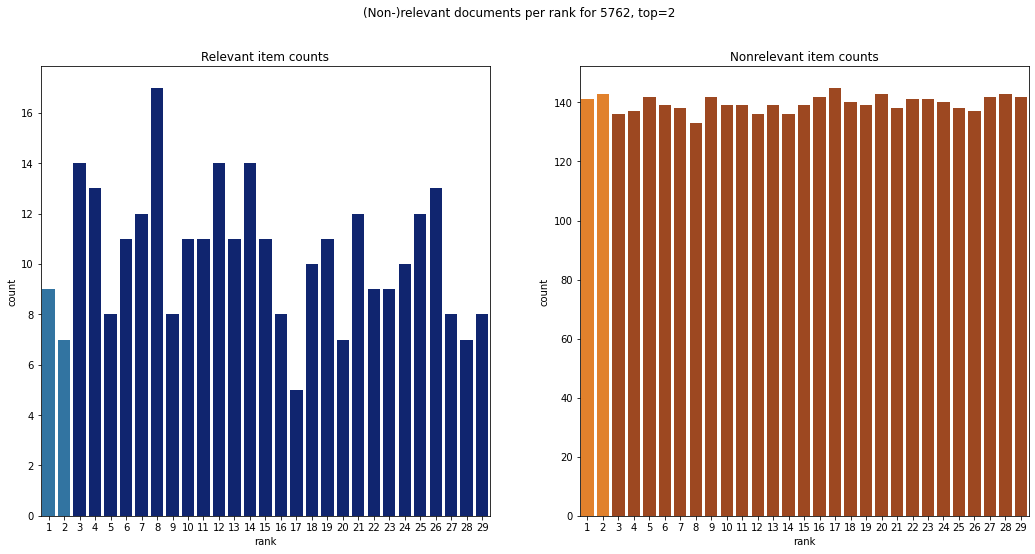

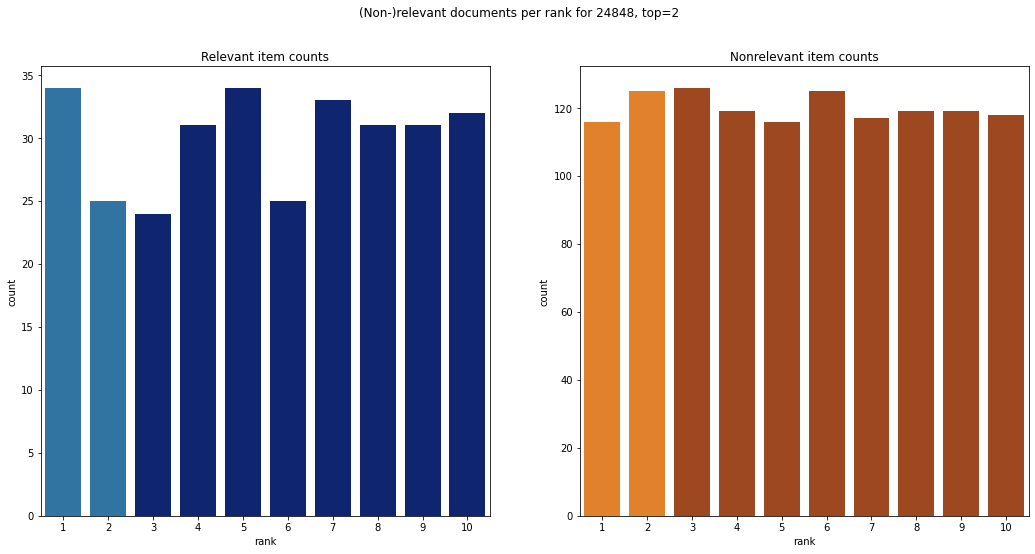

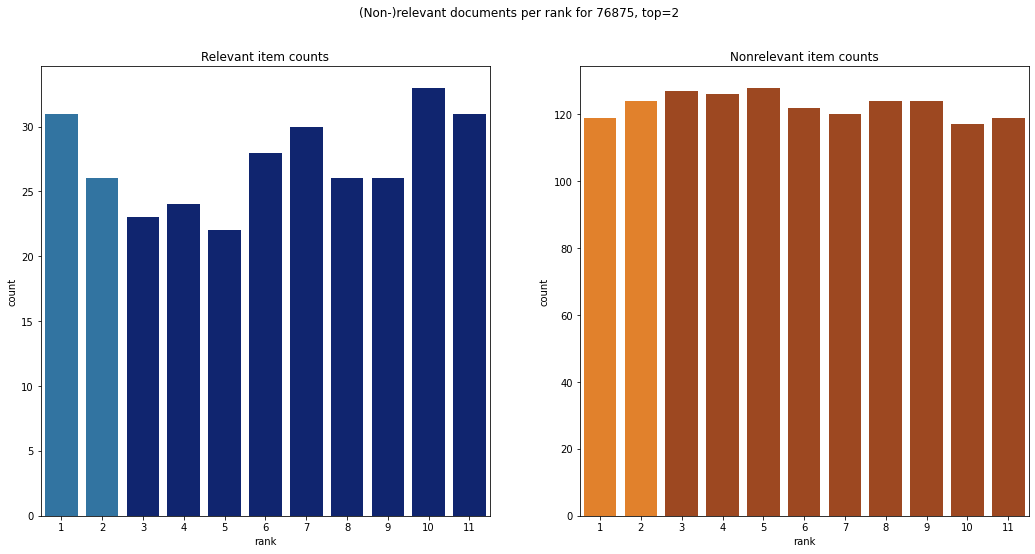

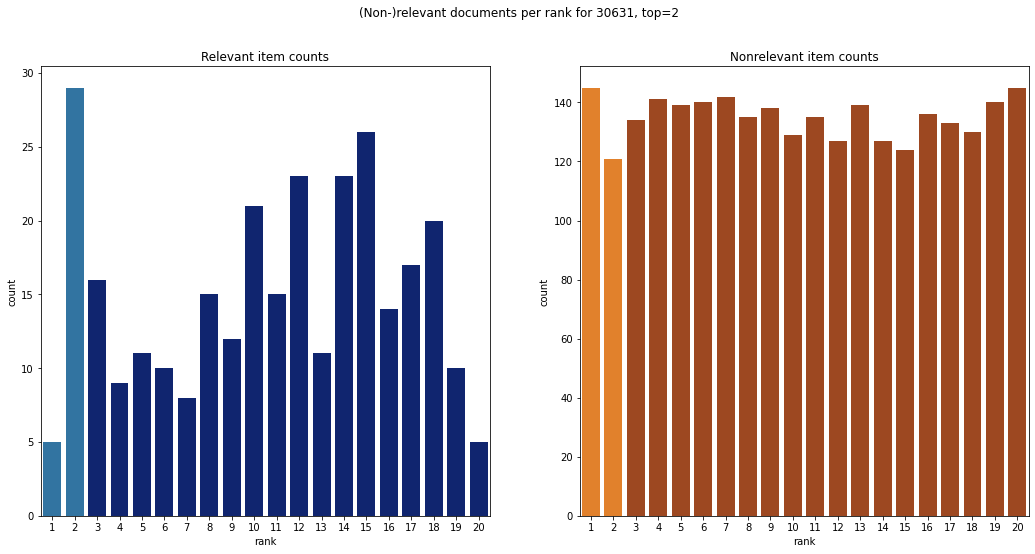

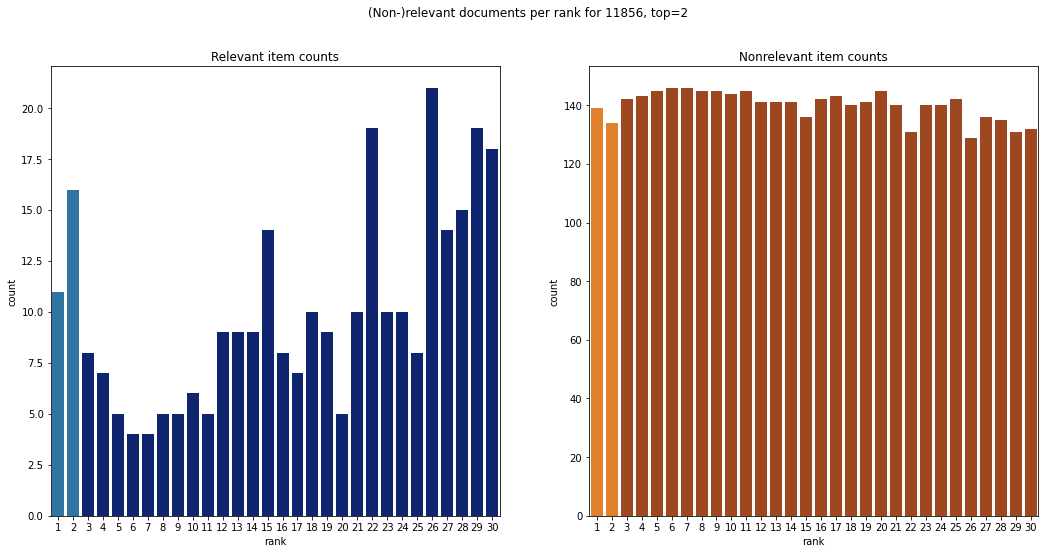

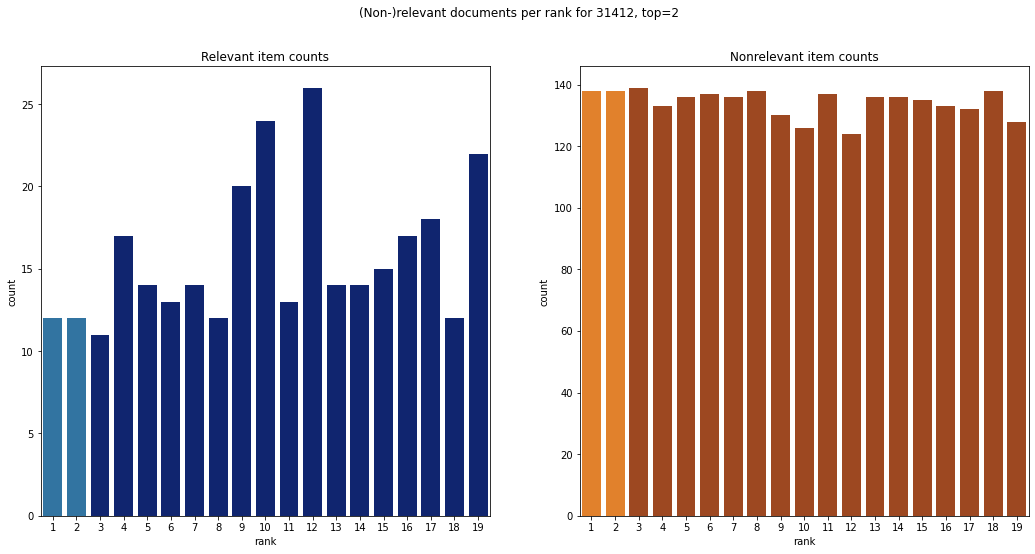

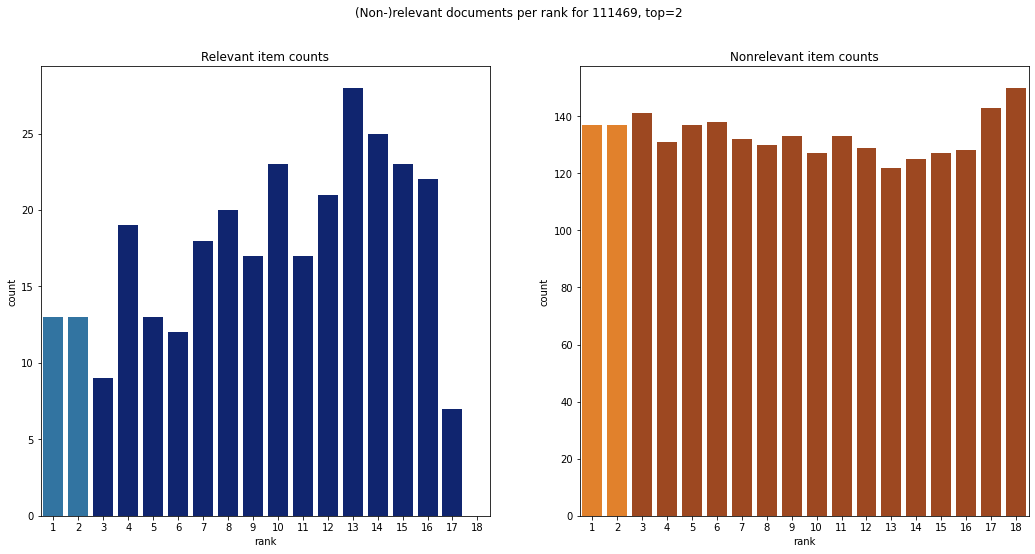

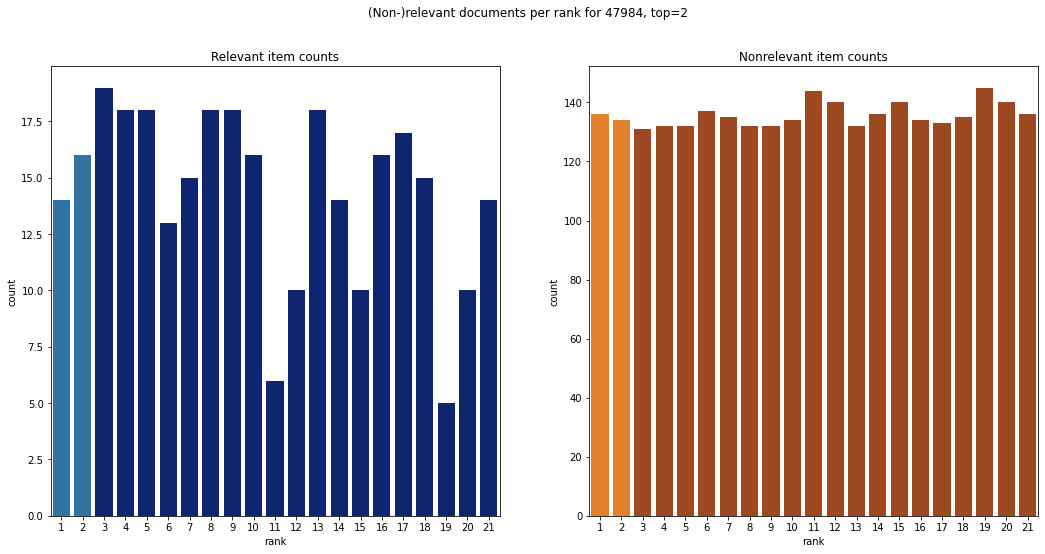

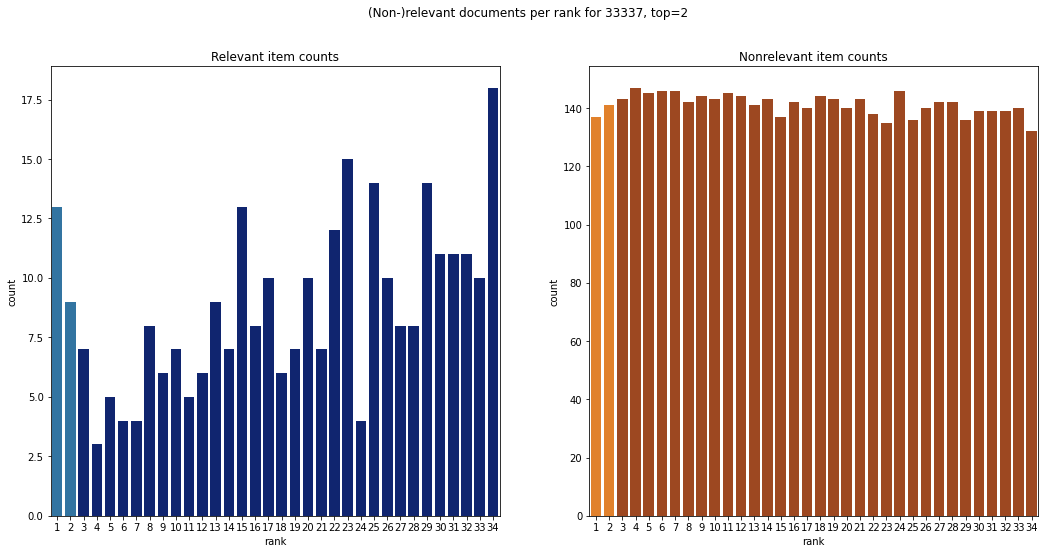

In [51]:
for q in edf.tail(10).qid.to_list():
    plot_rel_nonrel_per_rank_per_relkind_for_qid(q, rdf, reldf)

We also show which documents are found most often in the top positions for the top and bottom 10 queries.

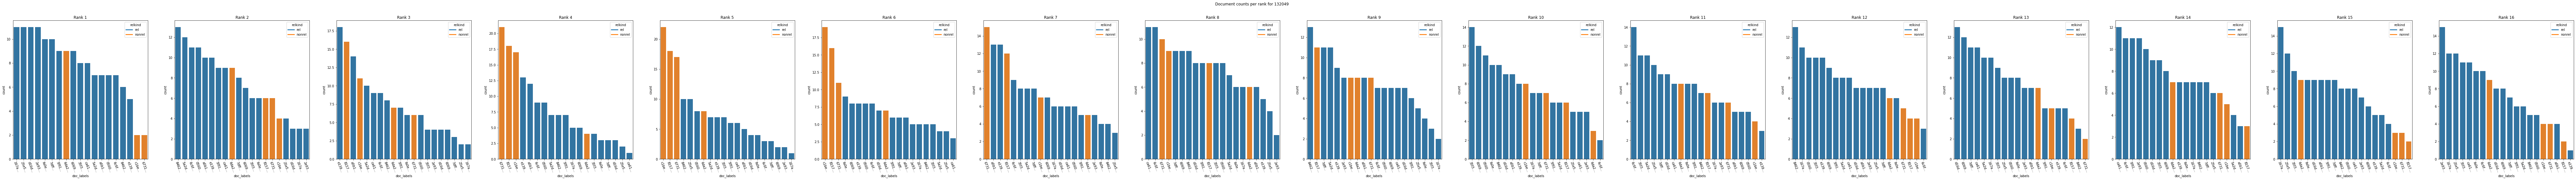

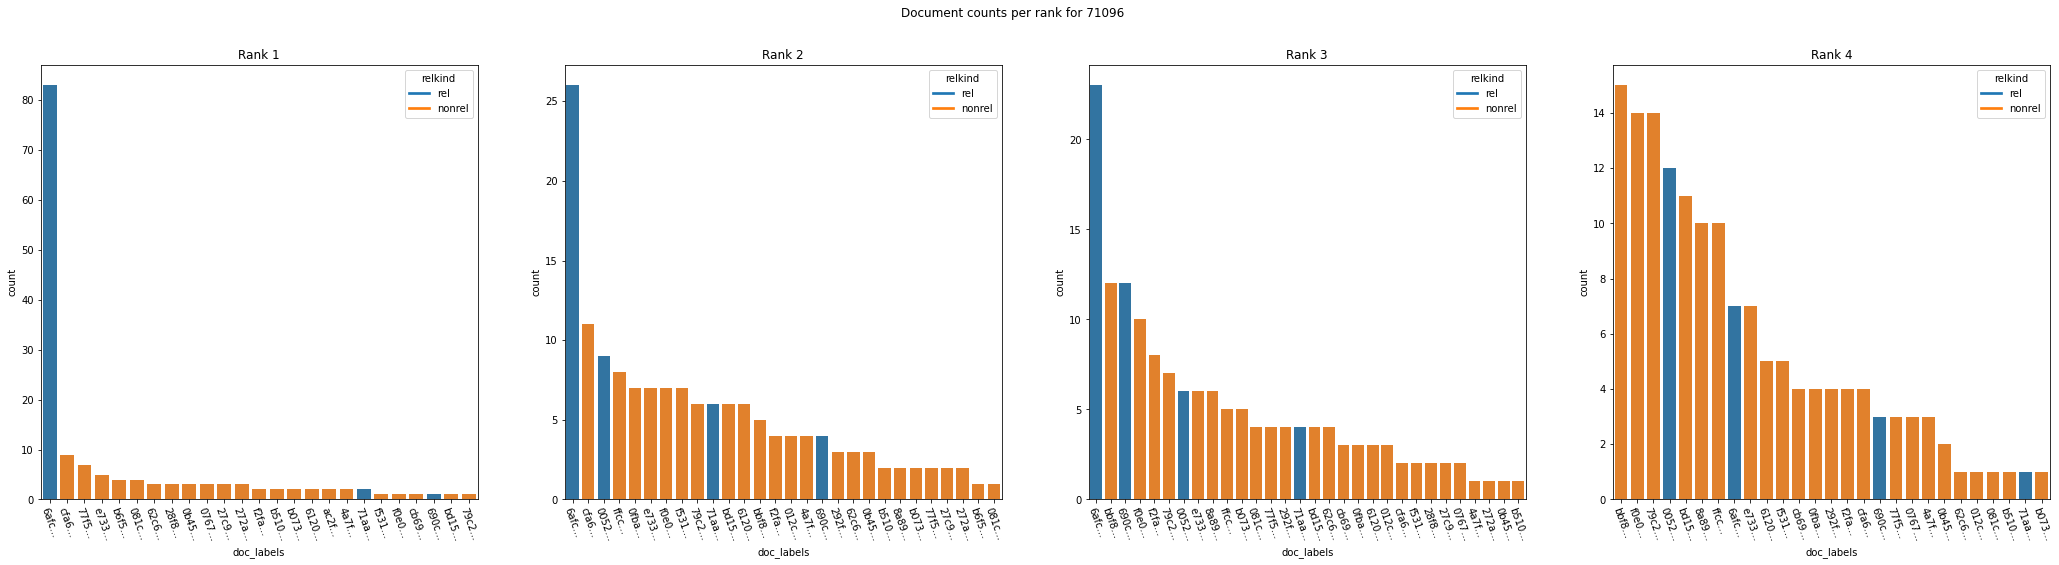

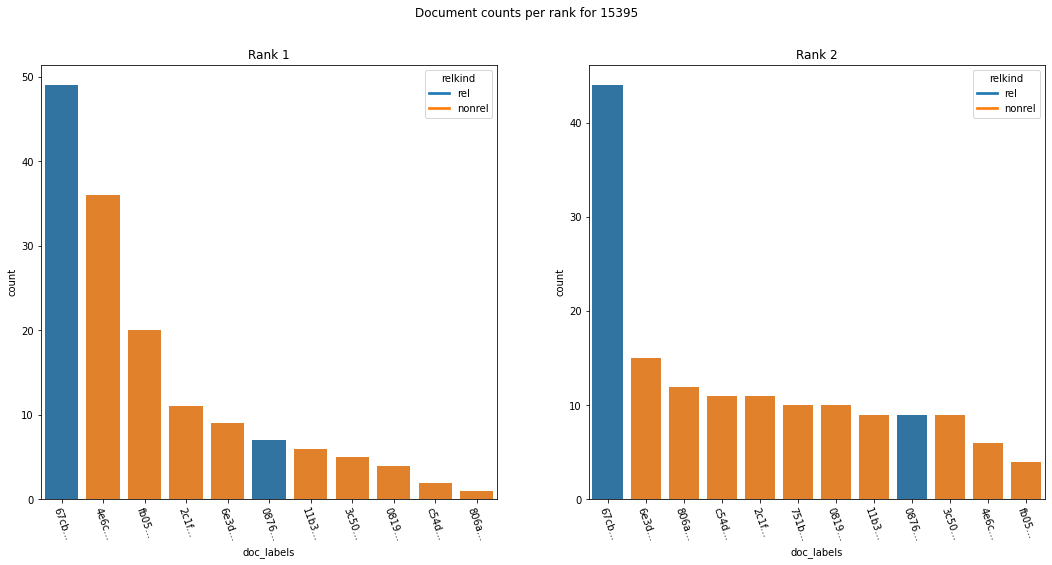

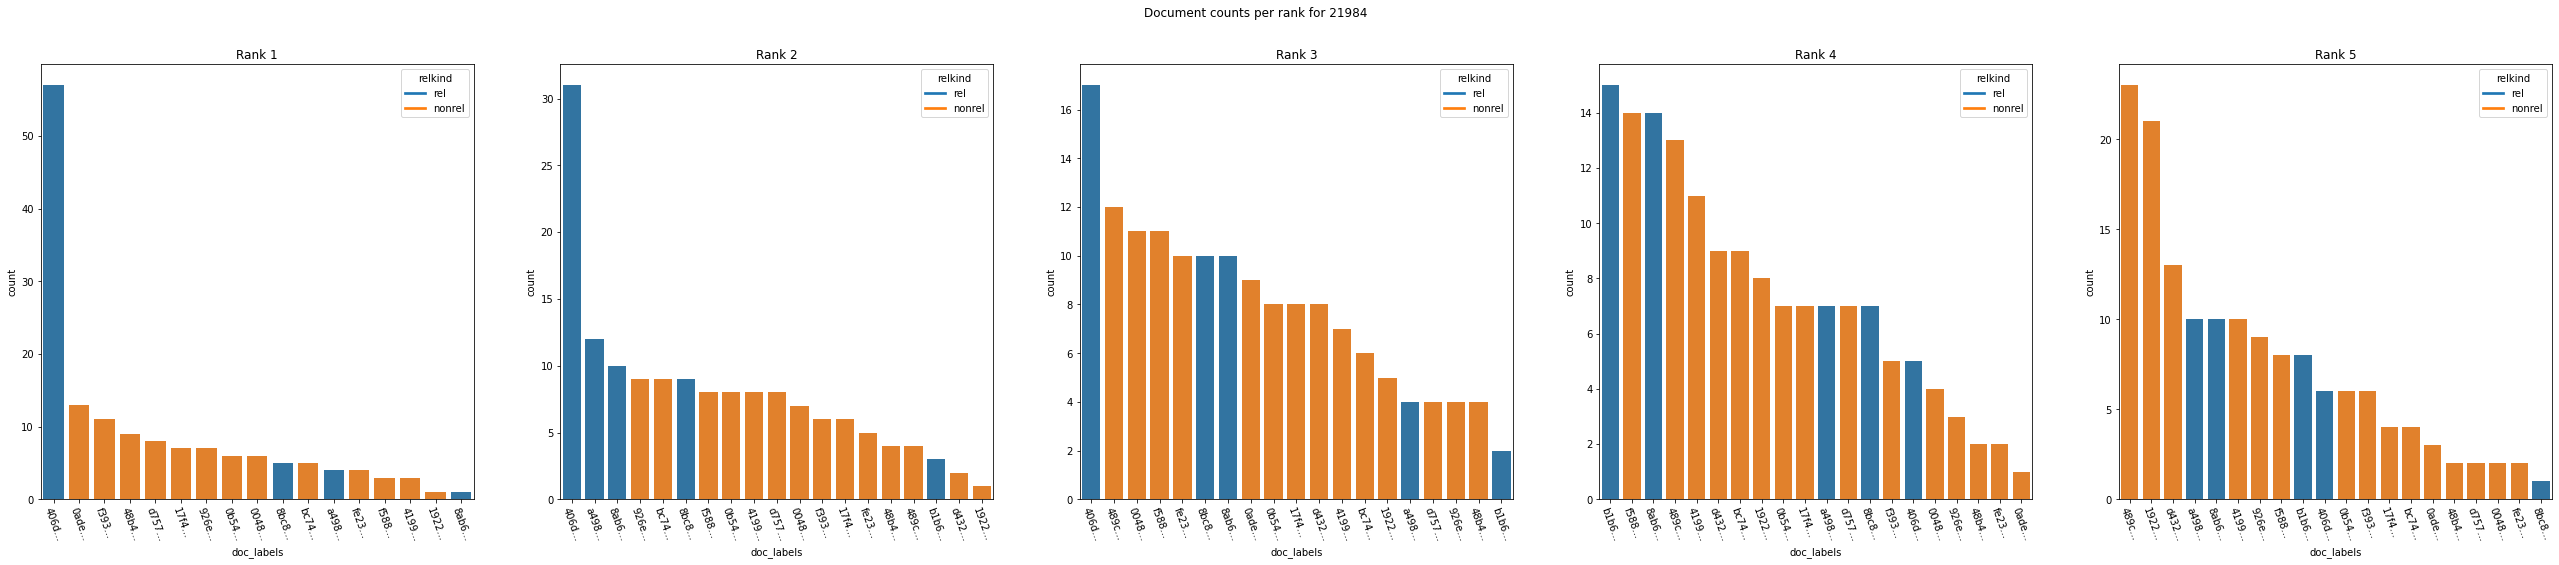

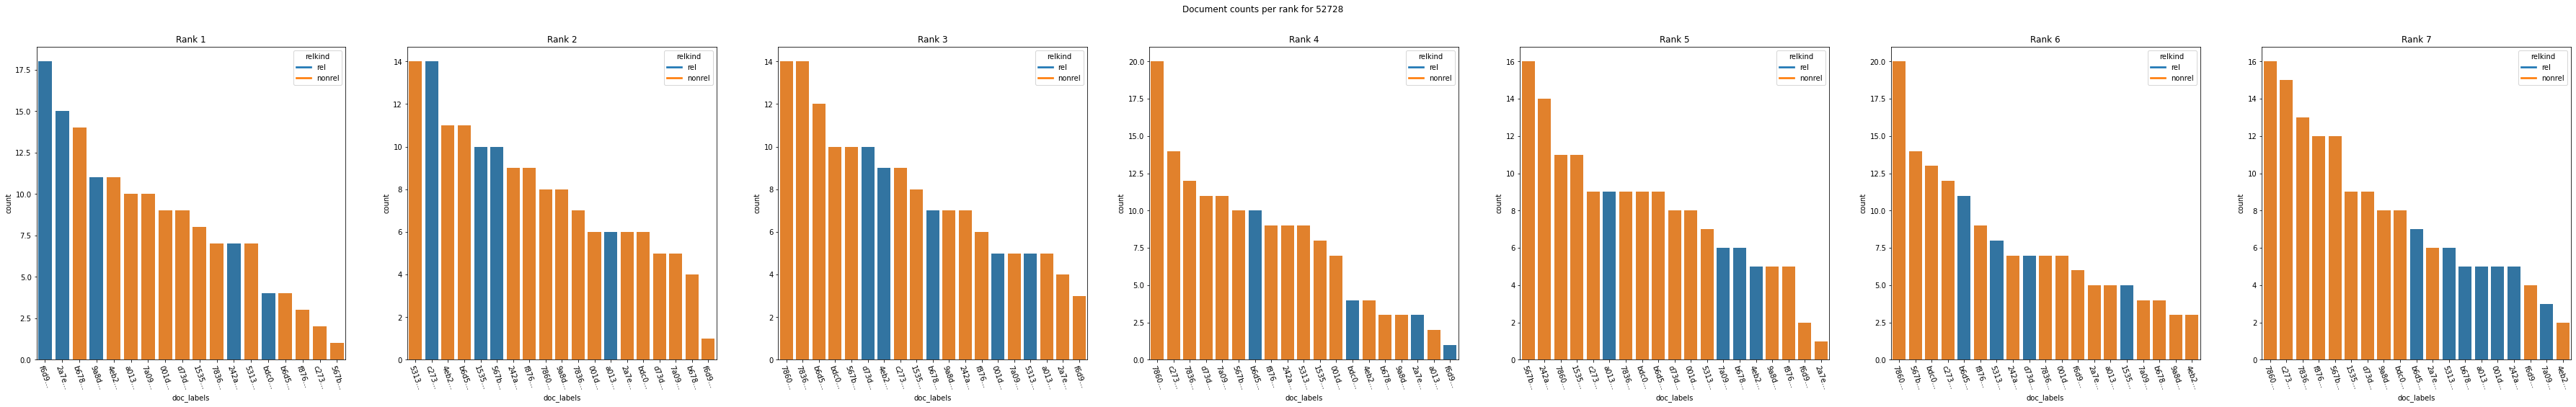

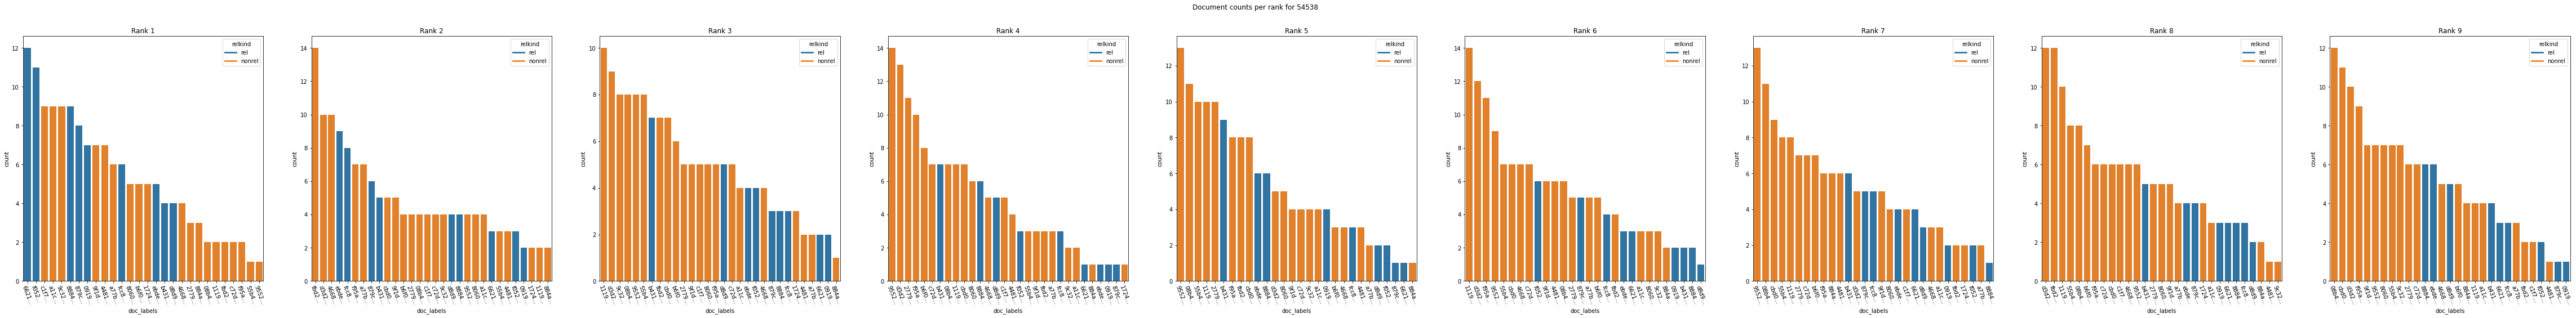

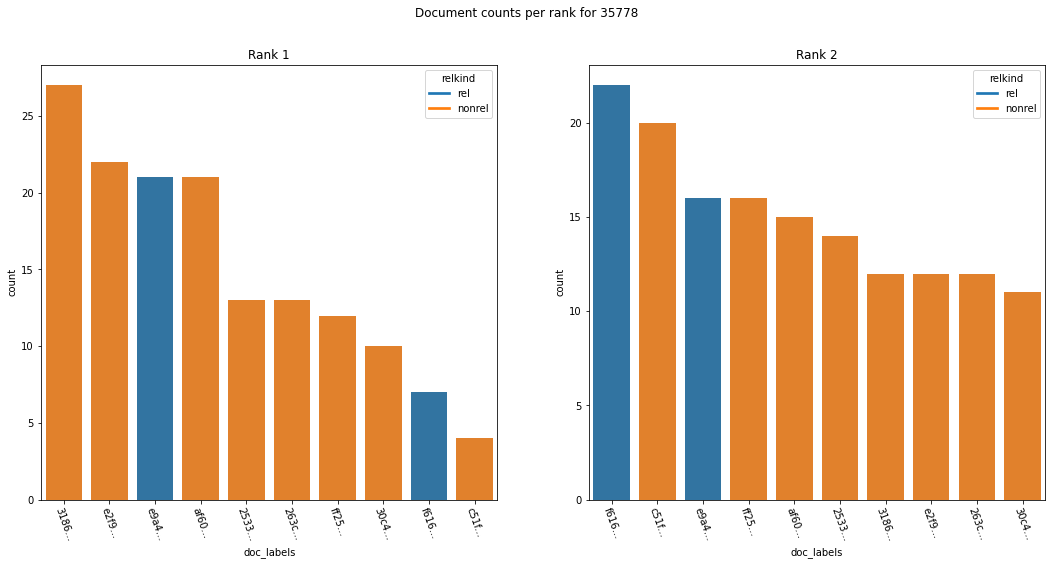

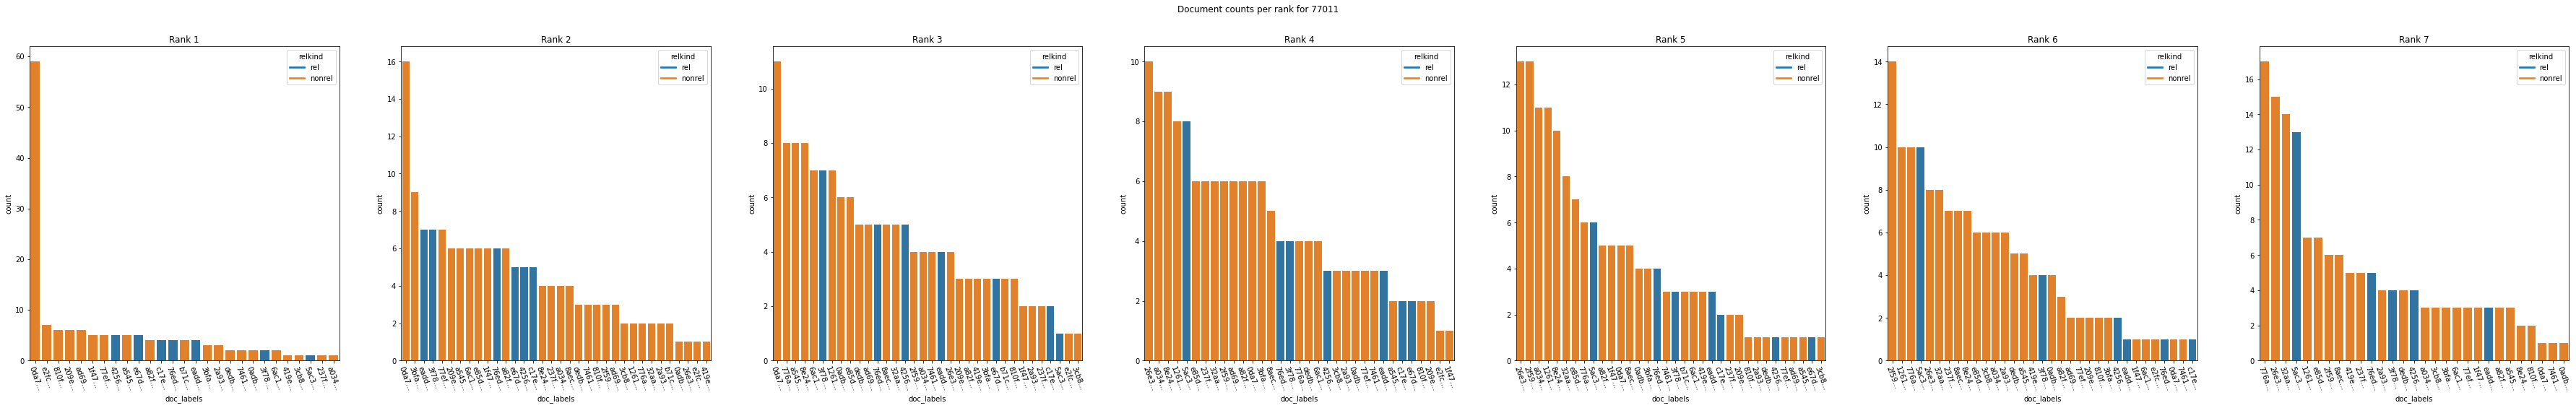

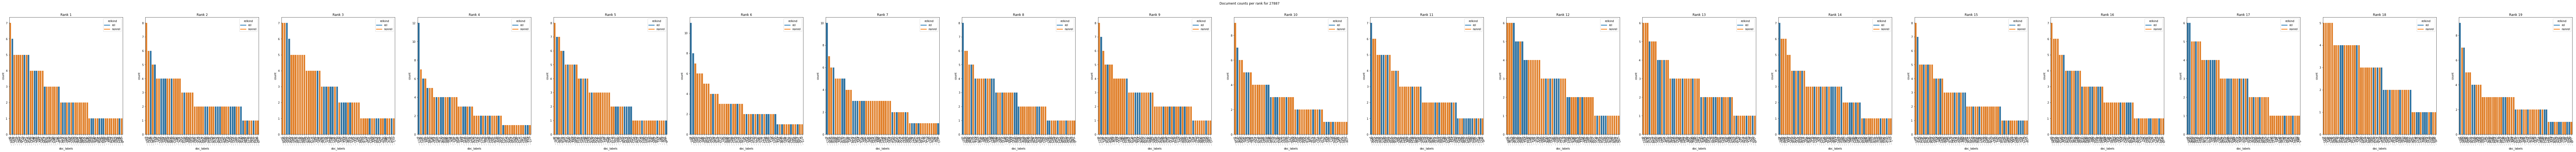

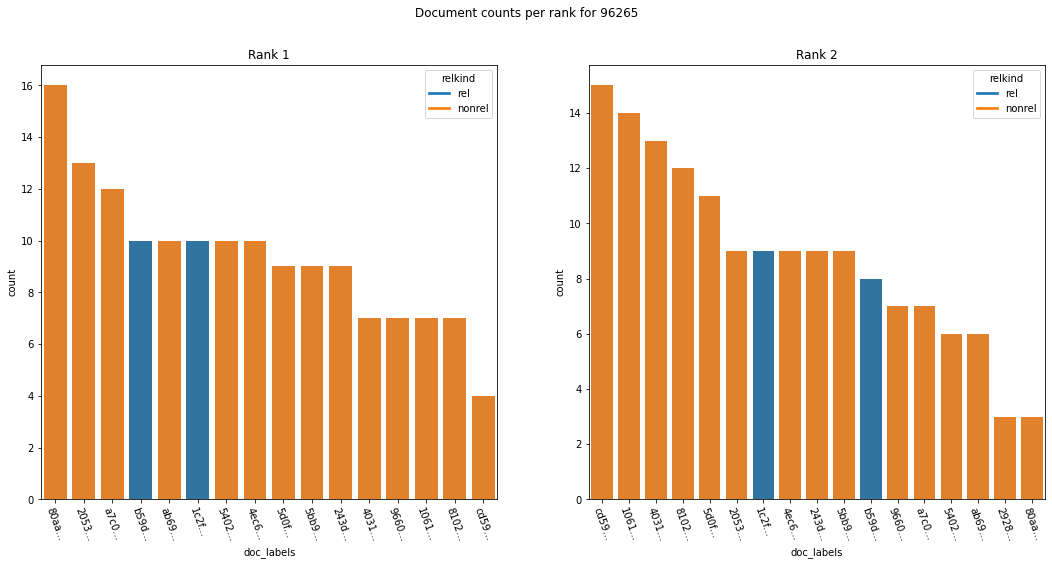

In [52]:
for q in edf.head(10).qid.to_list():
    rel,nonrel = count_relgrades_qid(q,reldf)
    plot_doc_occurrence_per_rank_for_qid(q,rdf,reldf,k=rel)

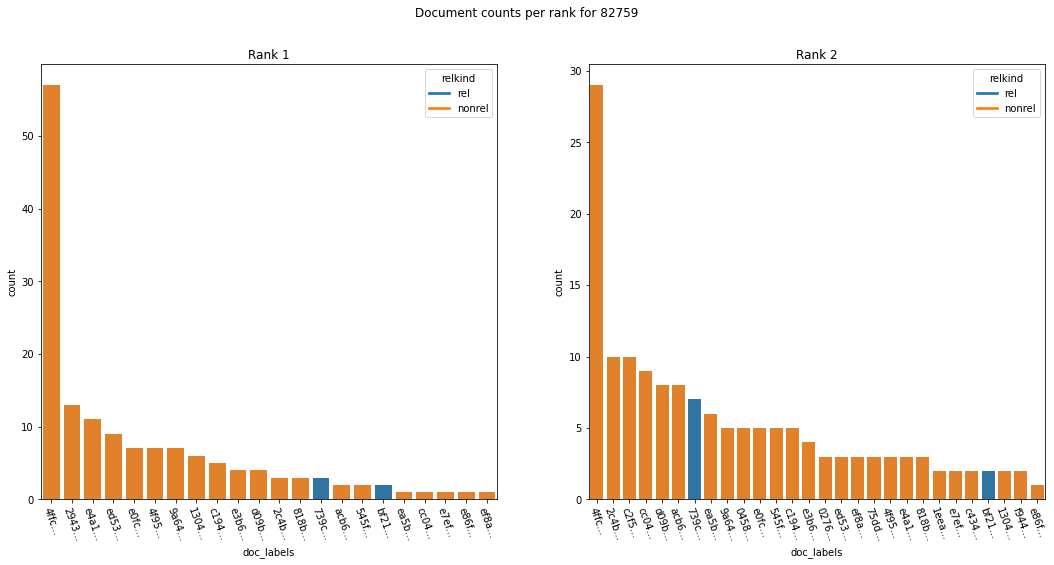

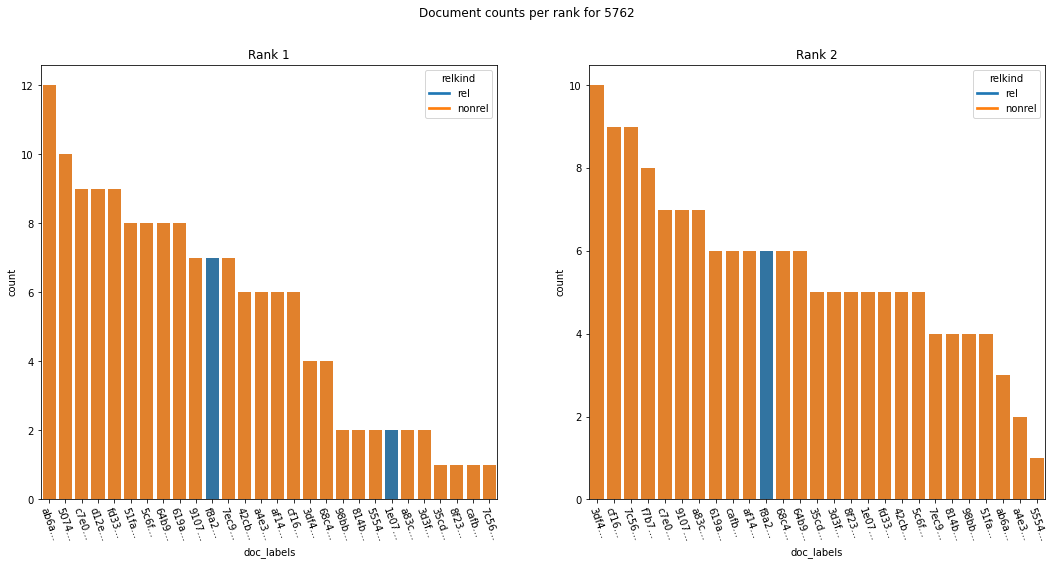

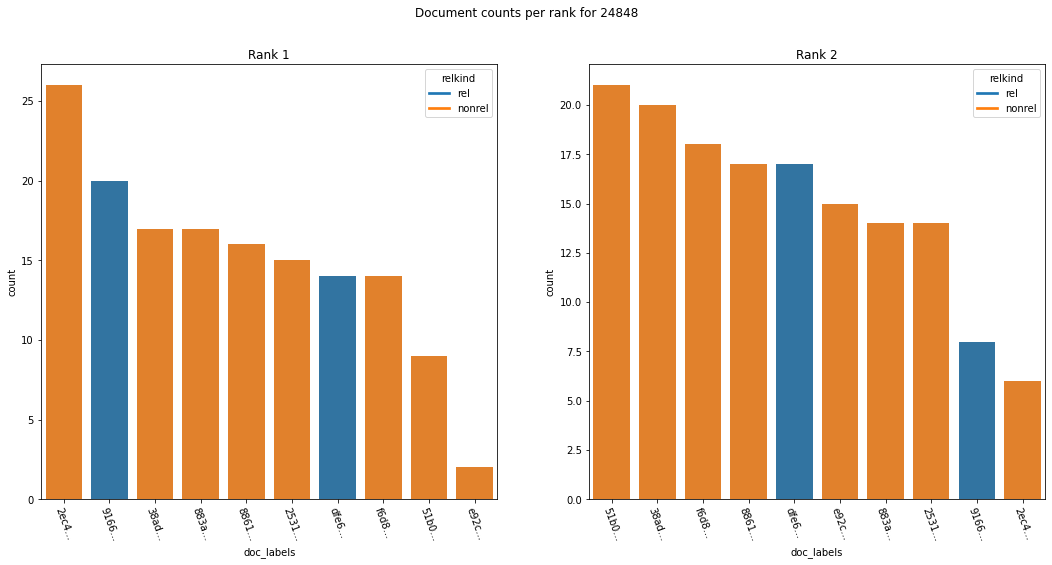

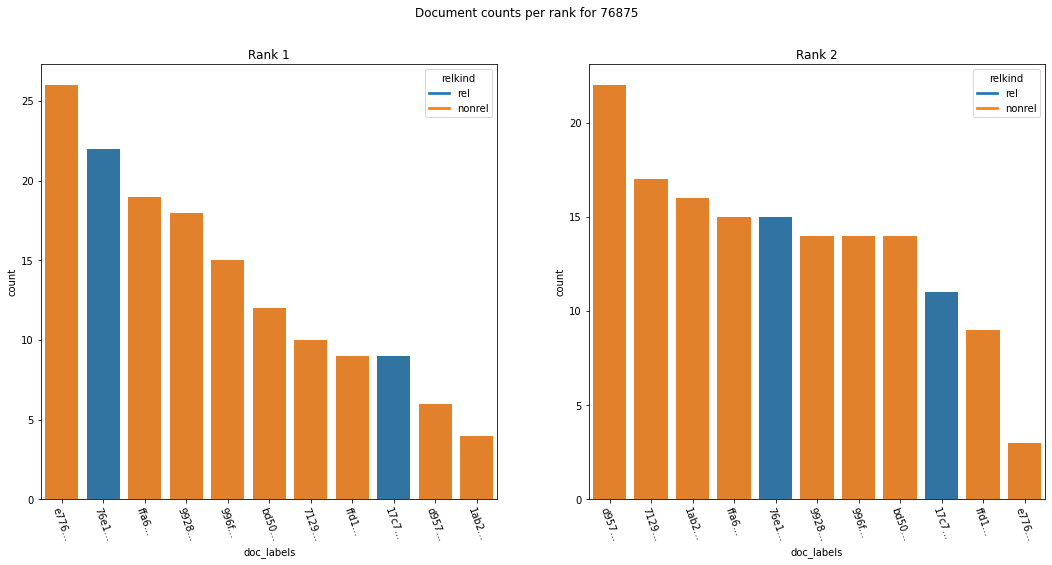

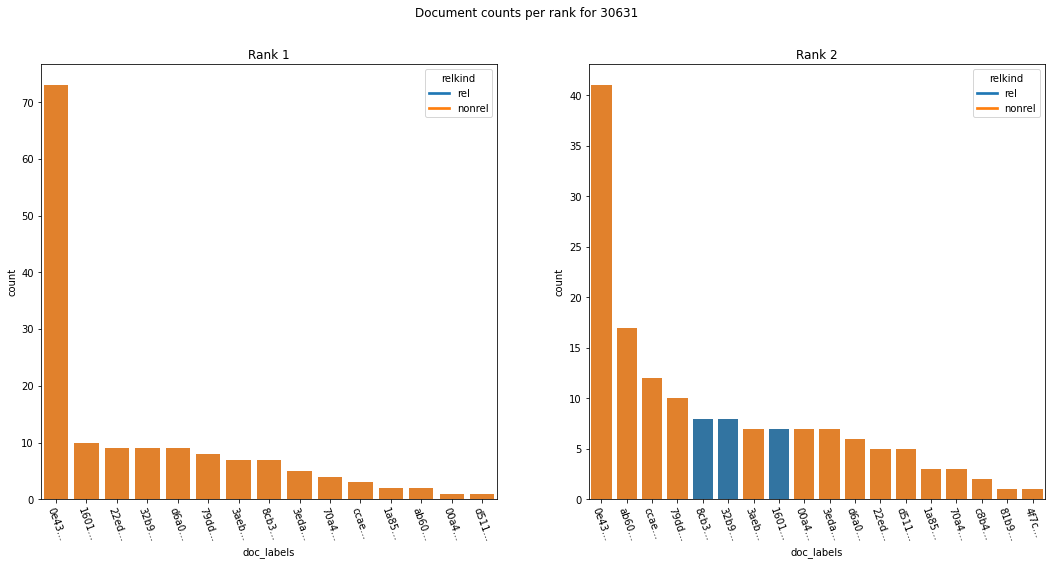

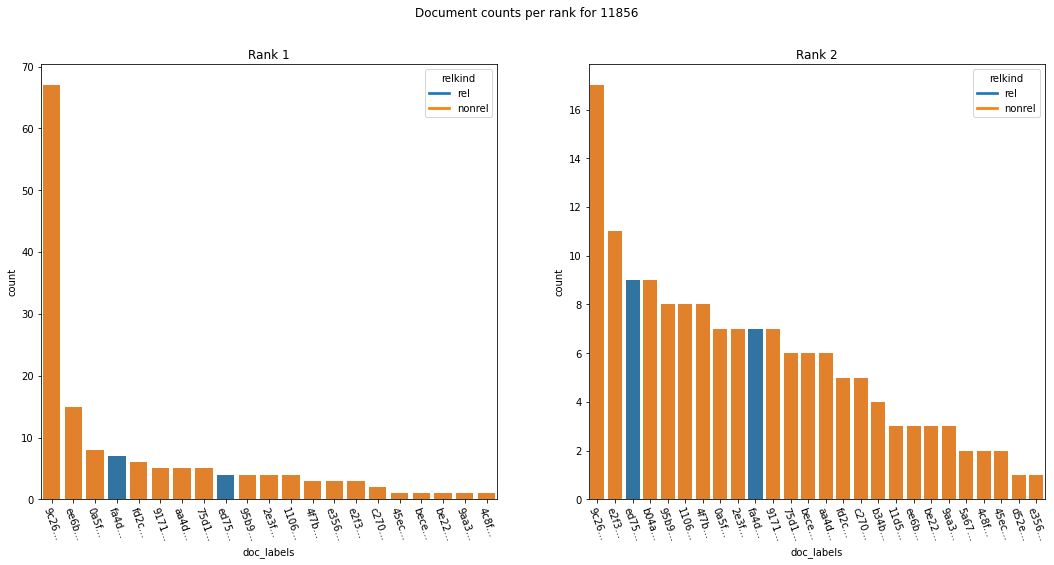

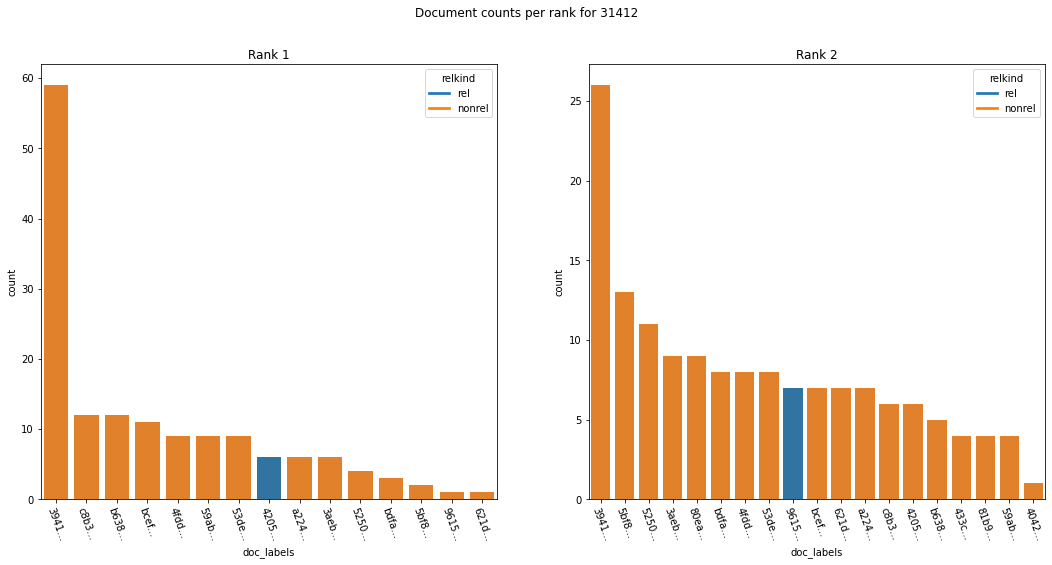

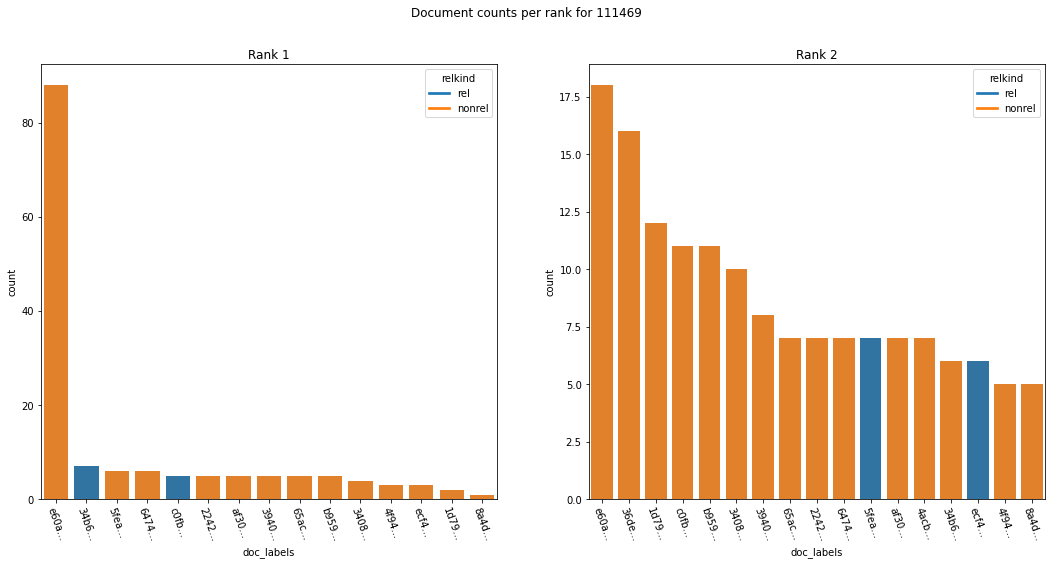

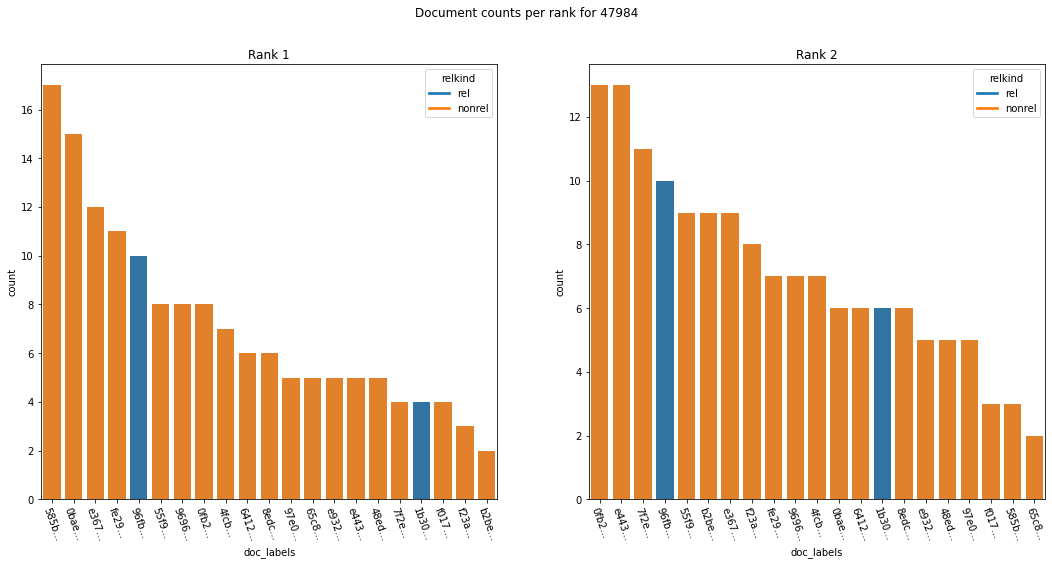

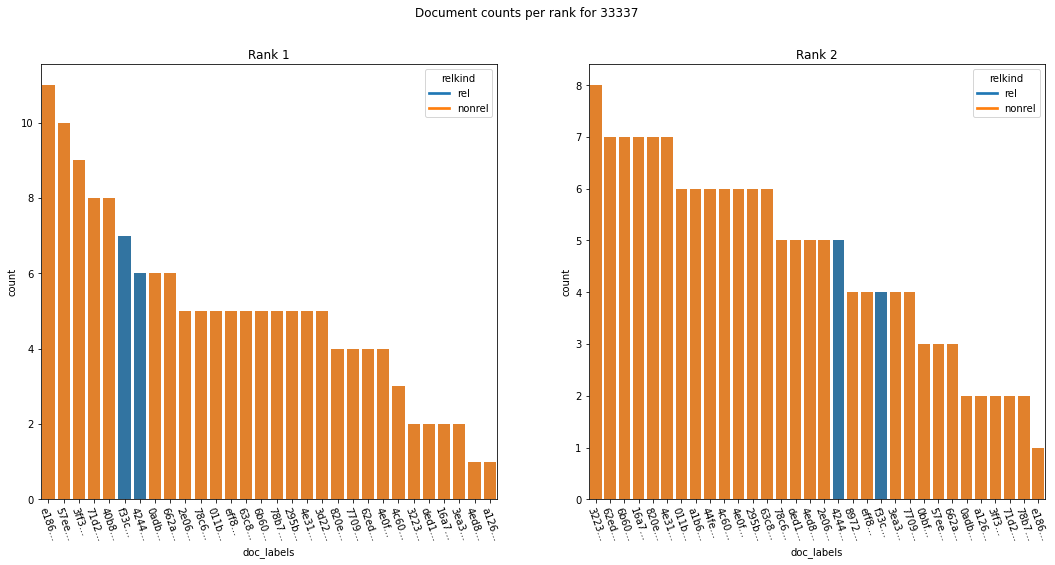

In [53]:
for q in edf.tail(10).qid.to_list():
    rel,nonrel = count_relgrades_qid(q,reldf)
    plot_doc_occurrence_per_rank_for_qid(q,rdf,reldf,k=rel)

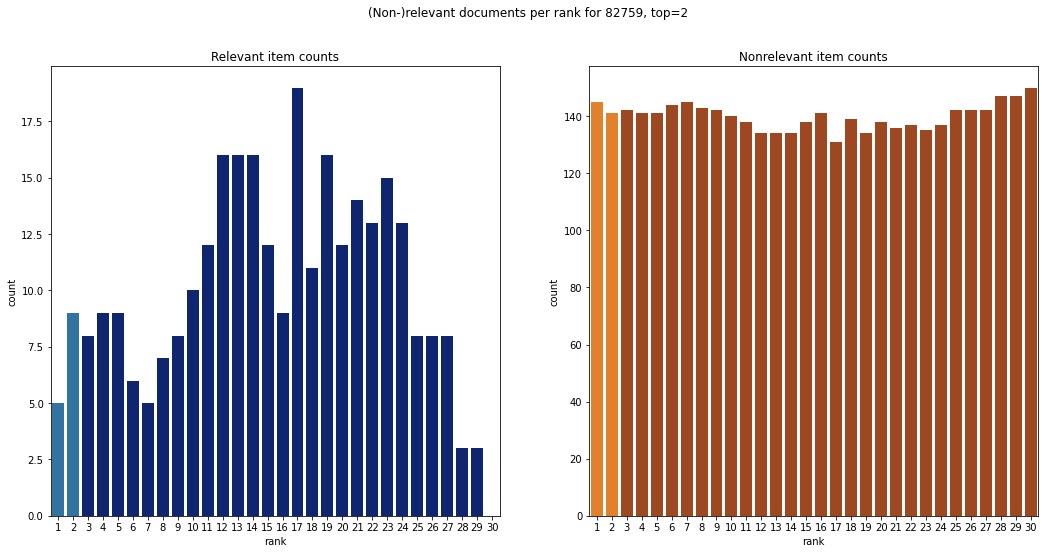

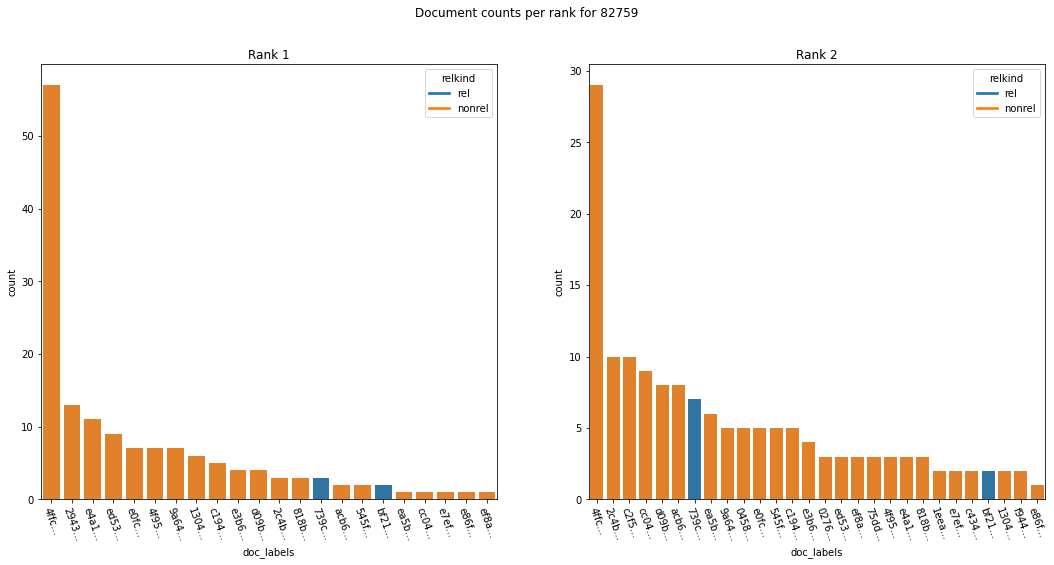

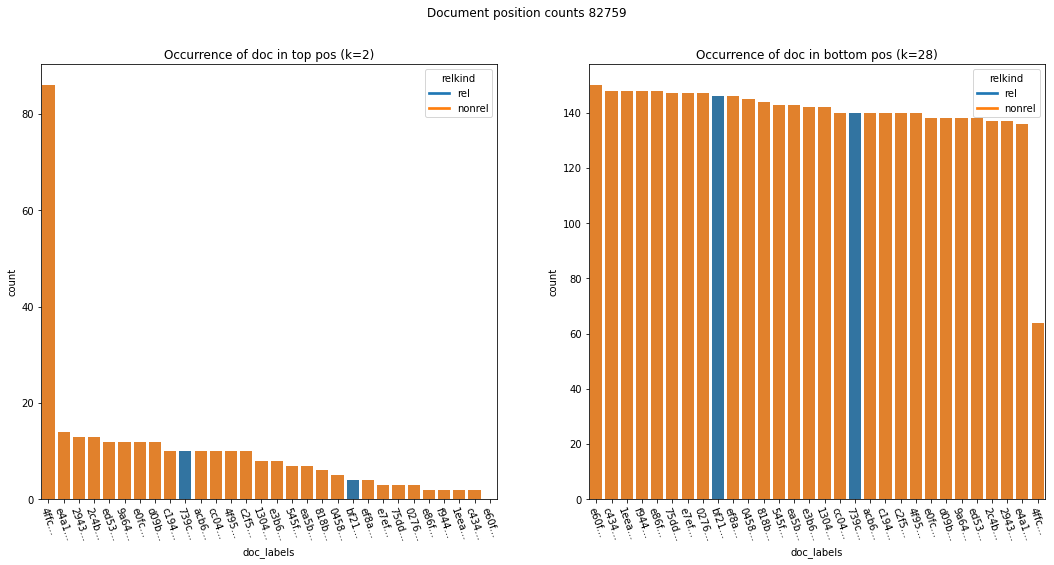

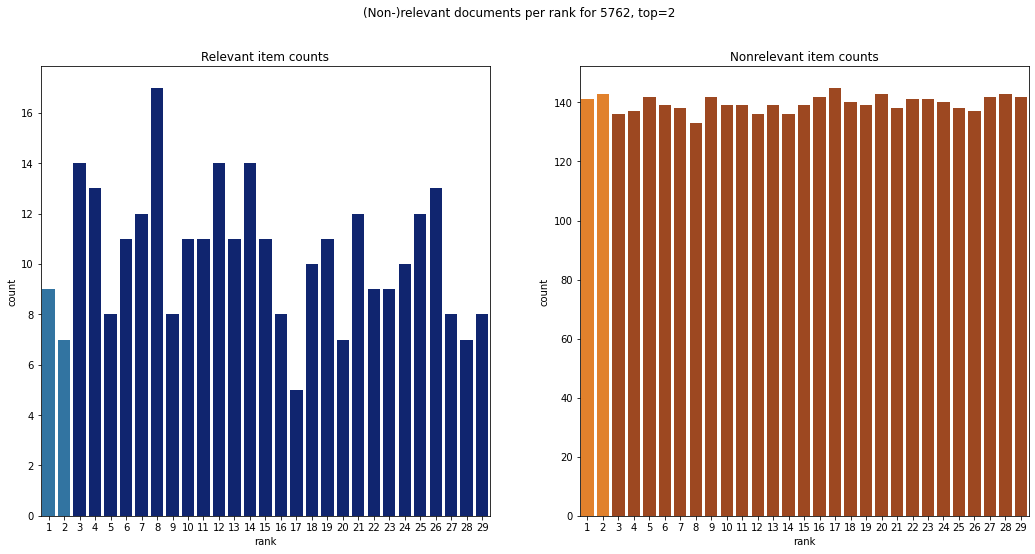

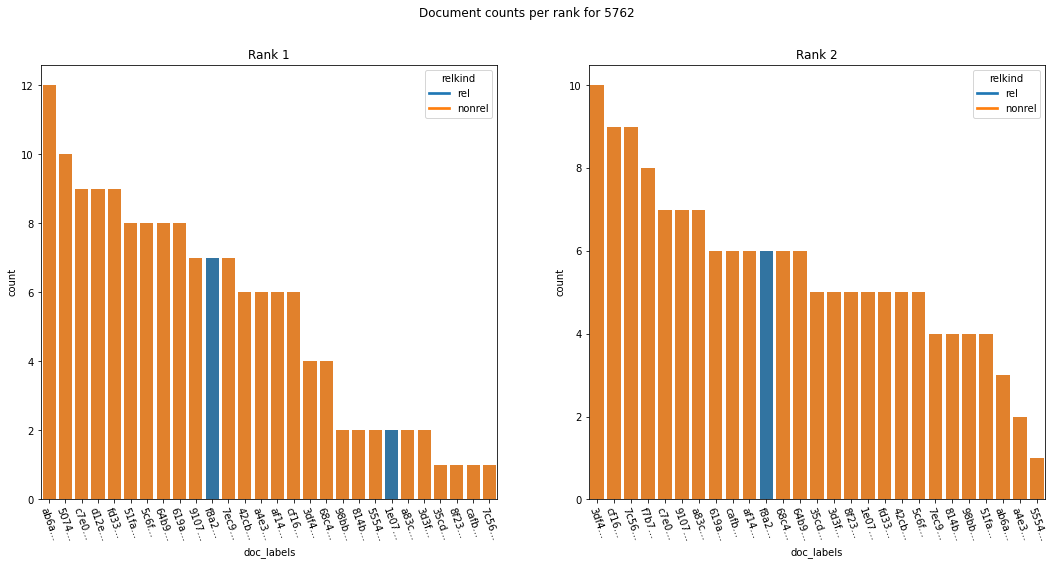

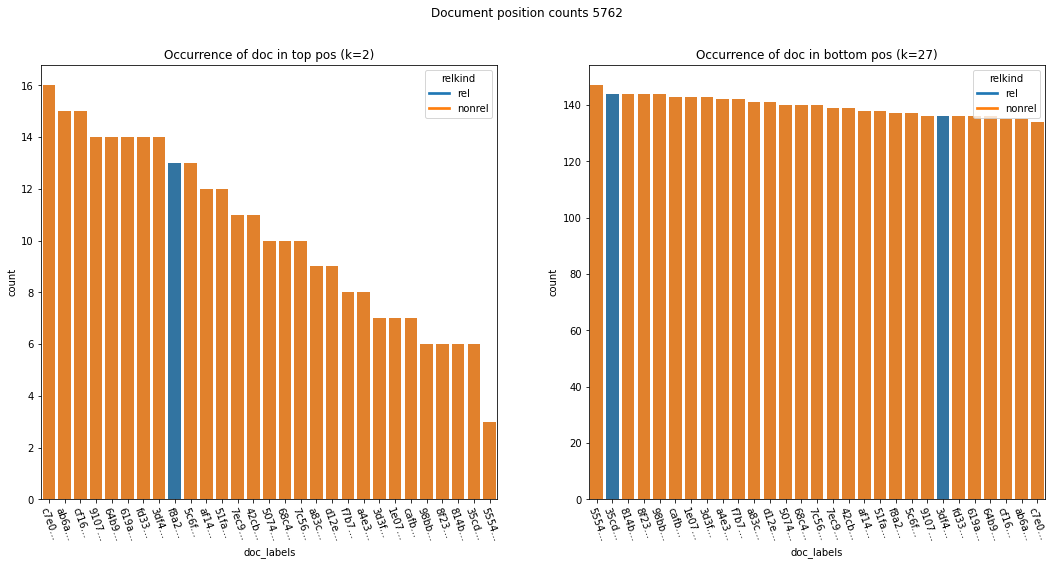

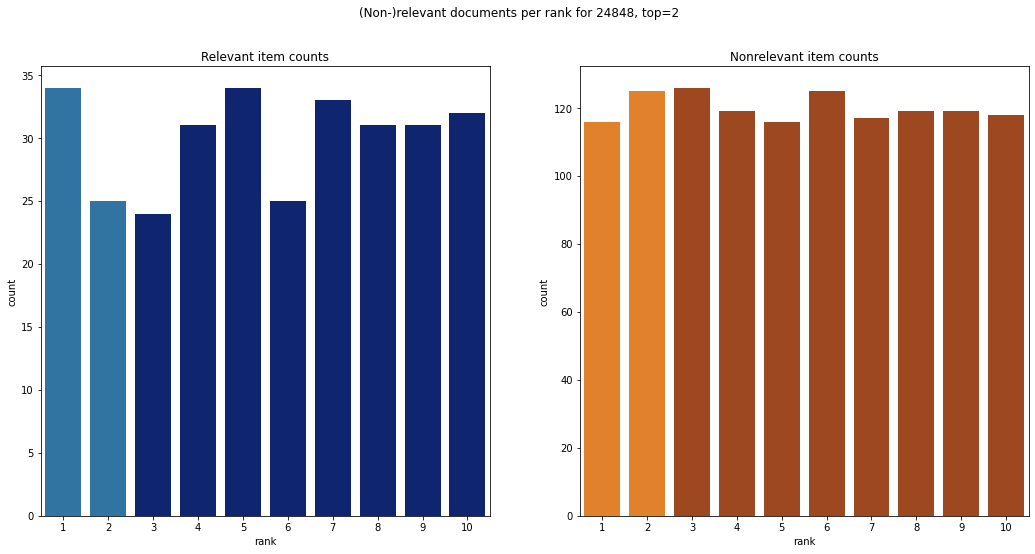

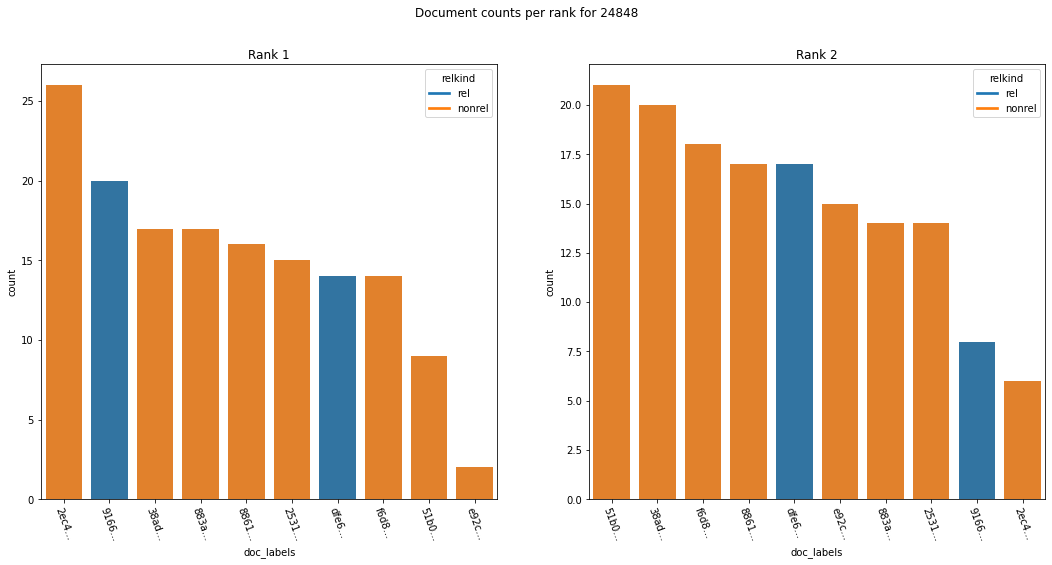

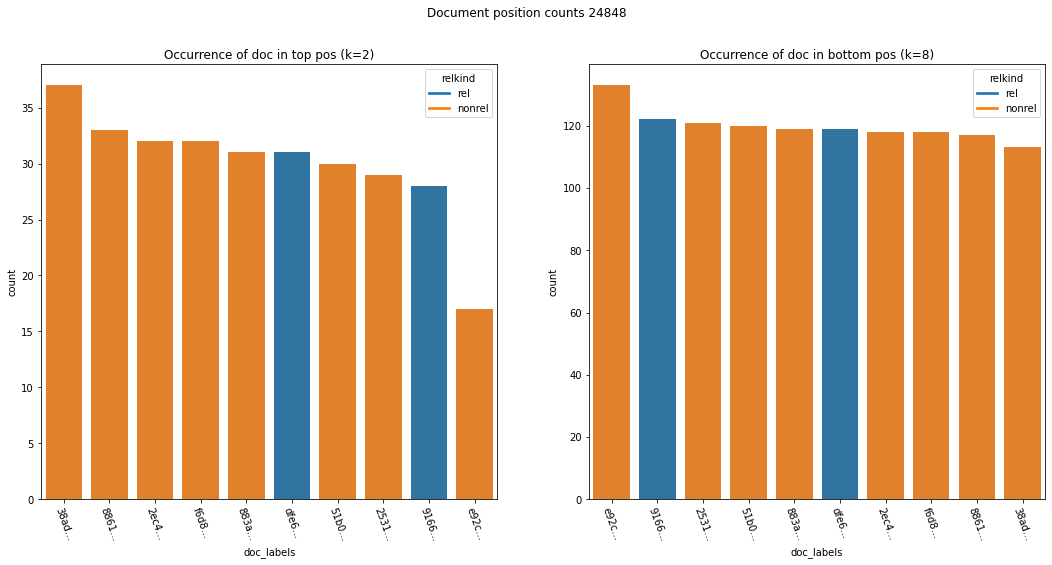

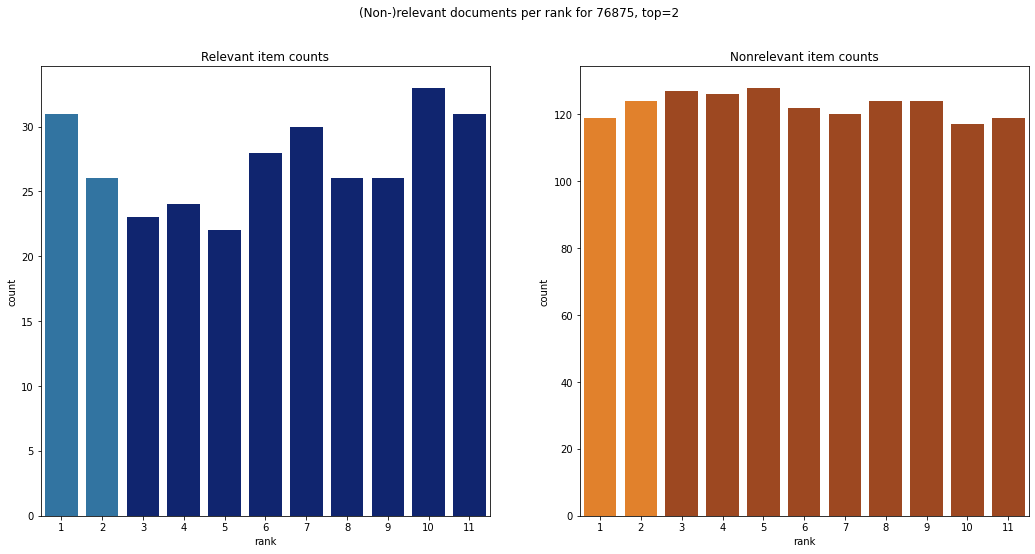

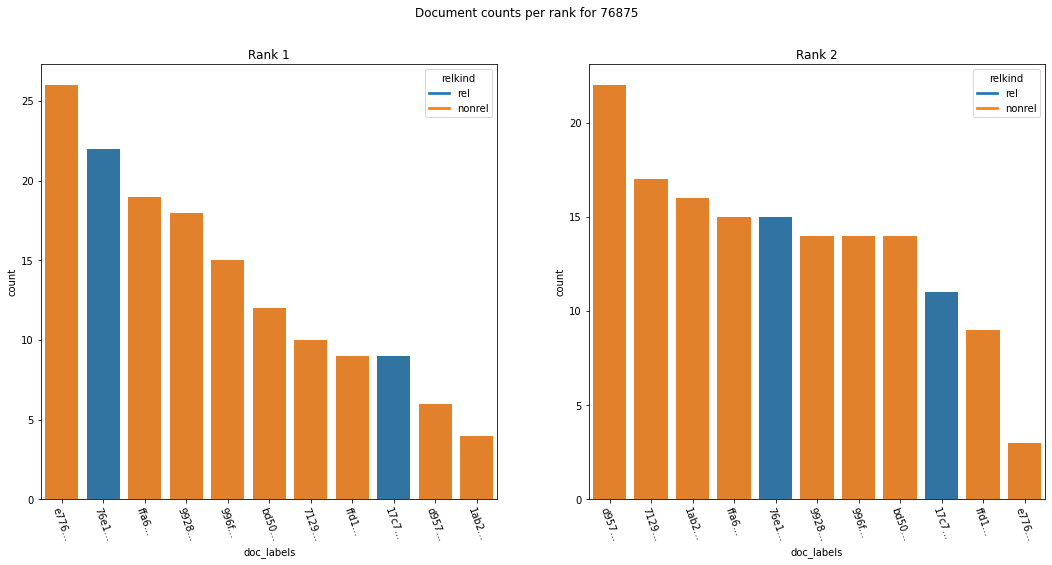

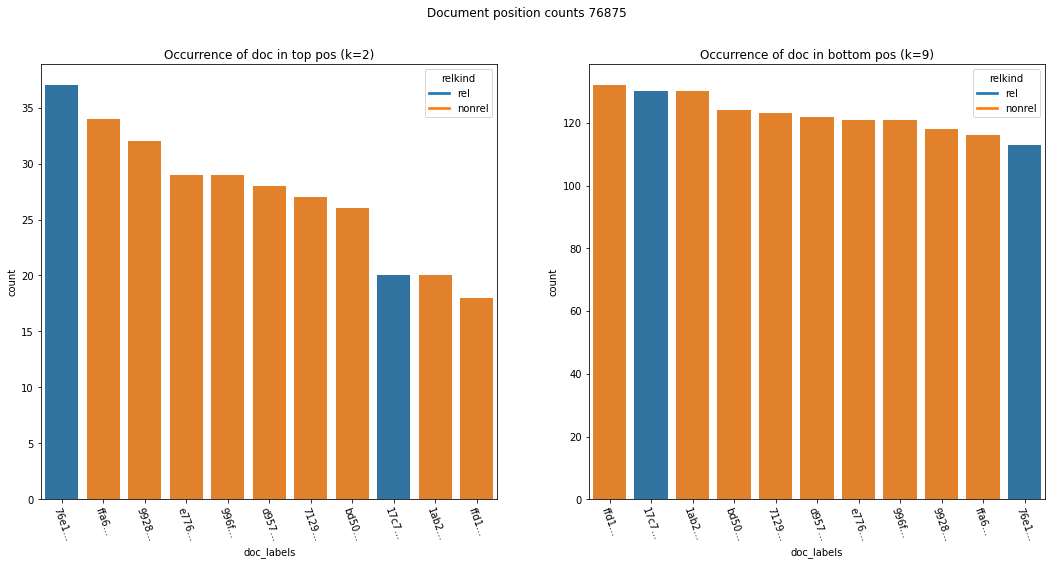

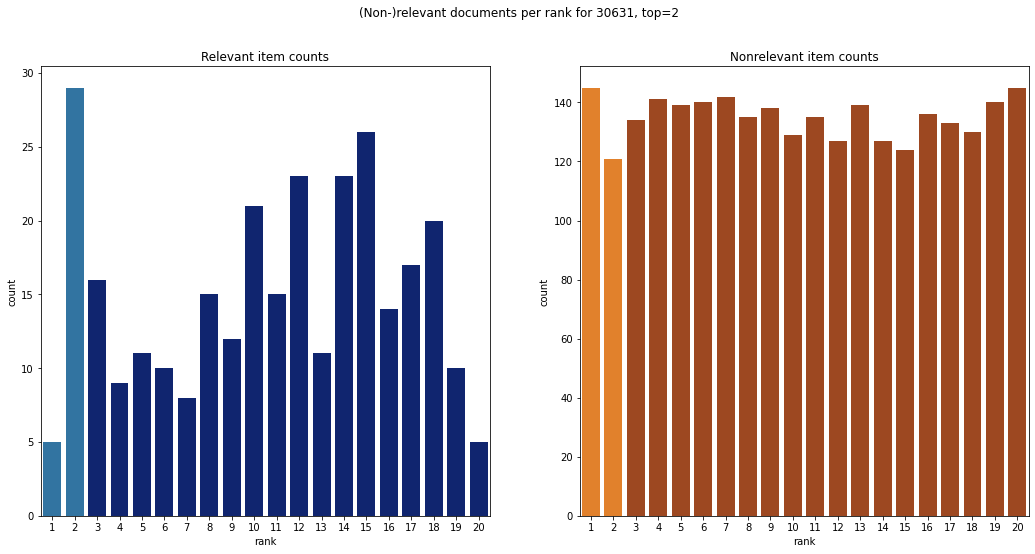

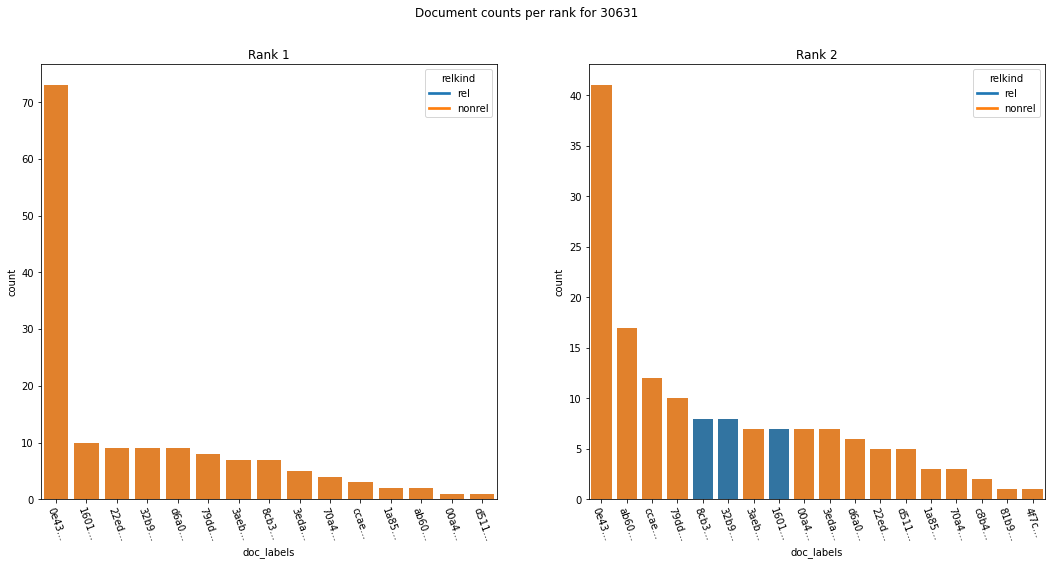

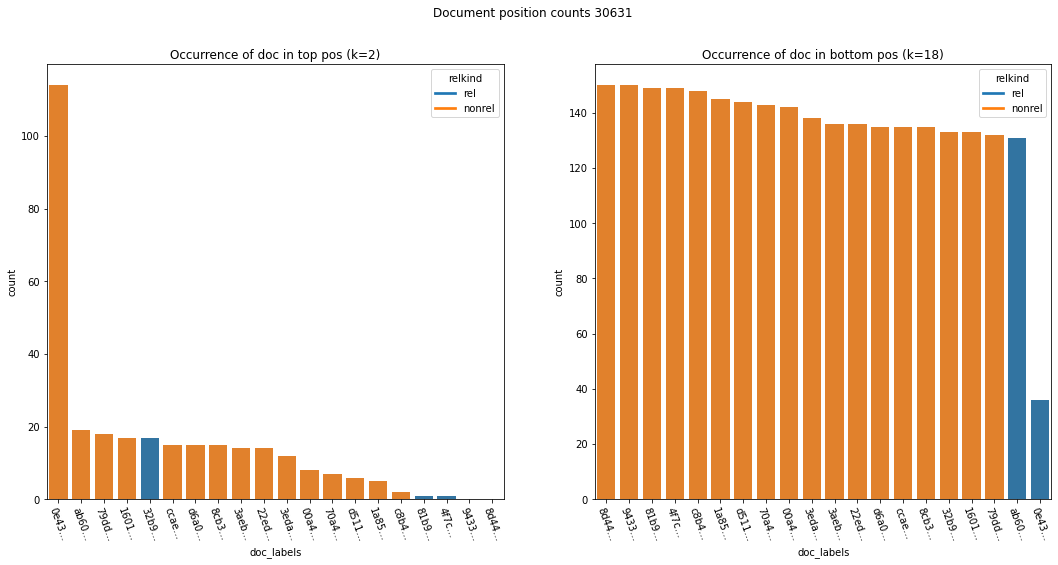

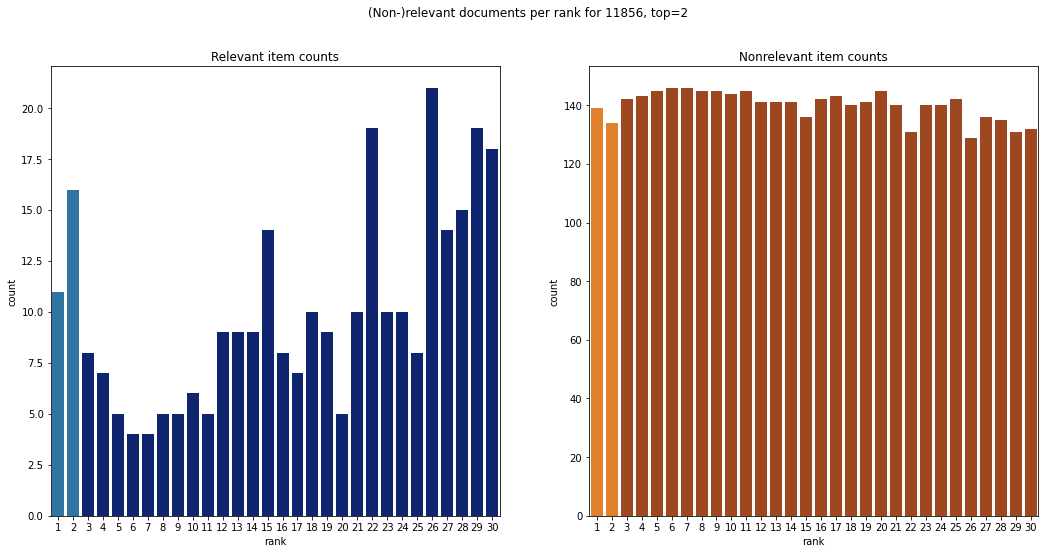

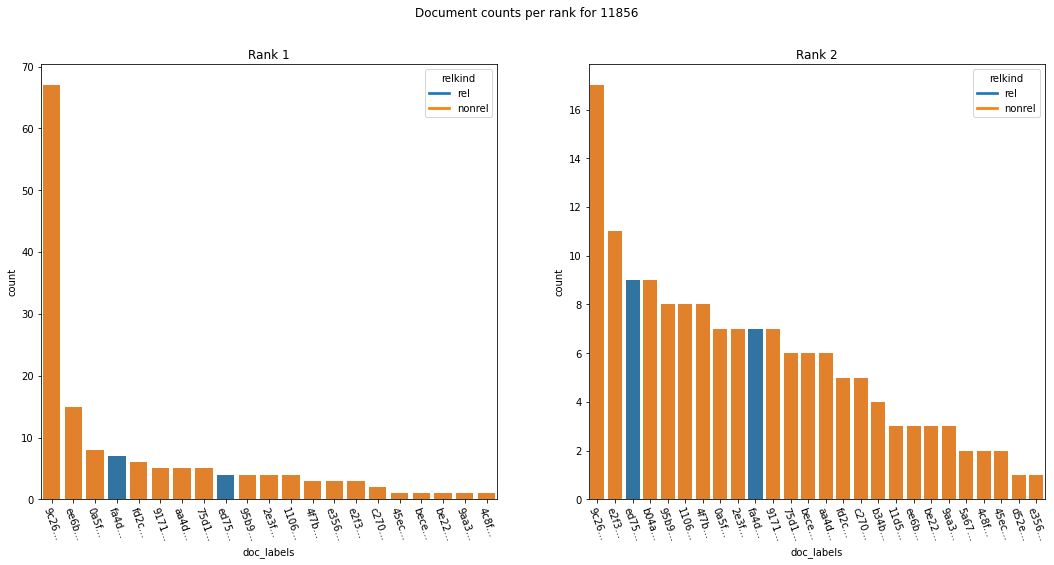

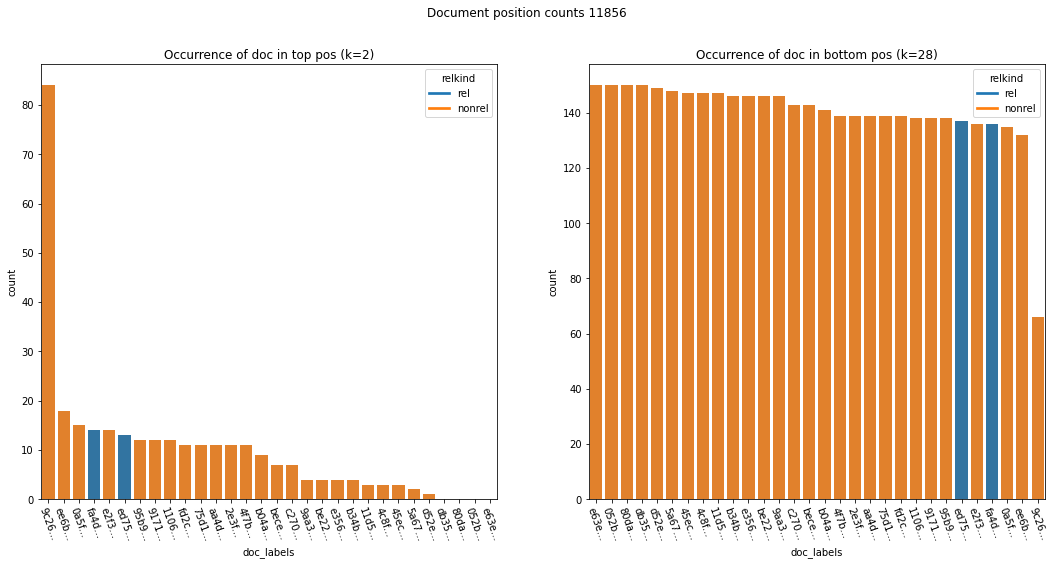

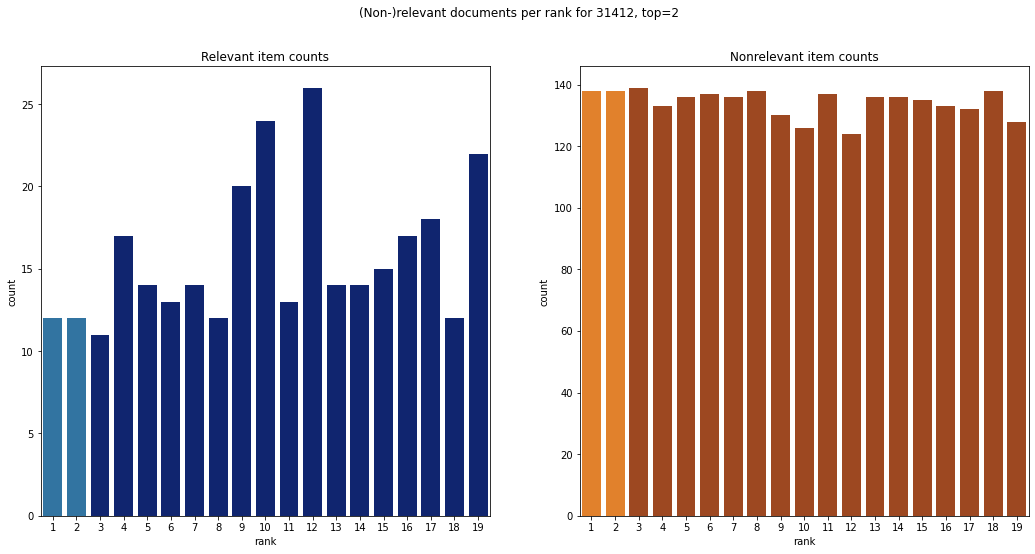

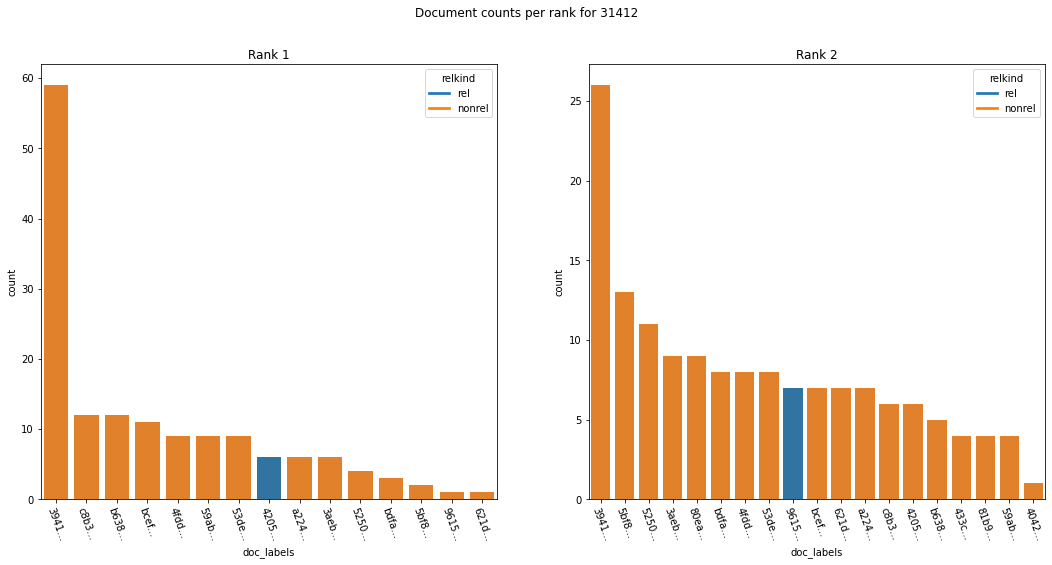

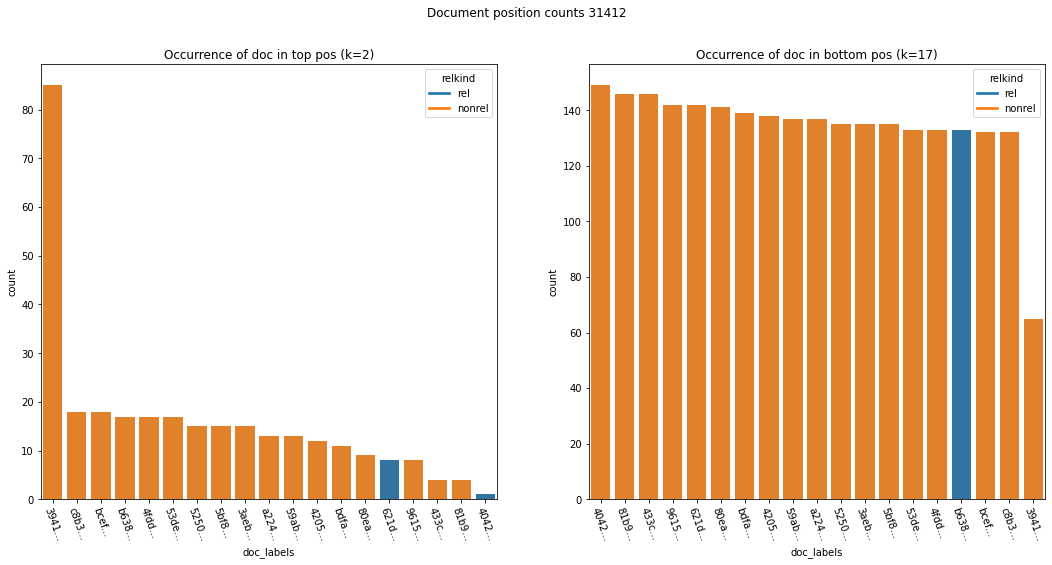

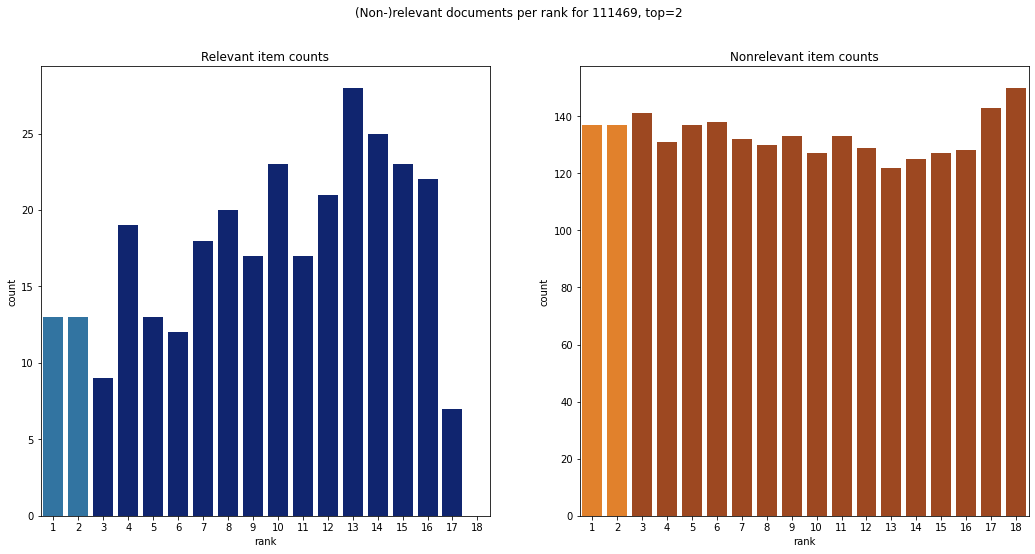

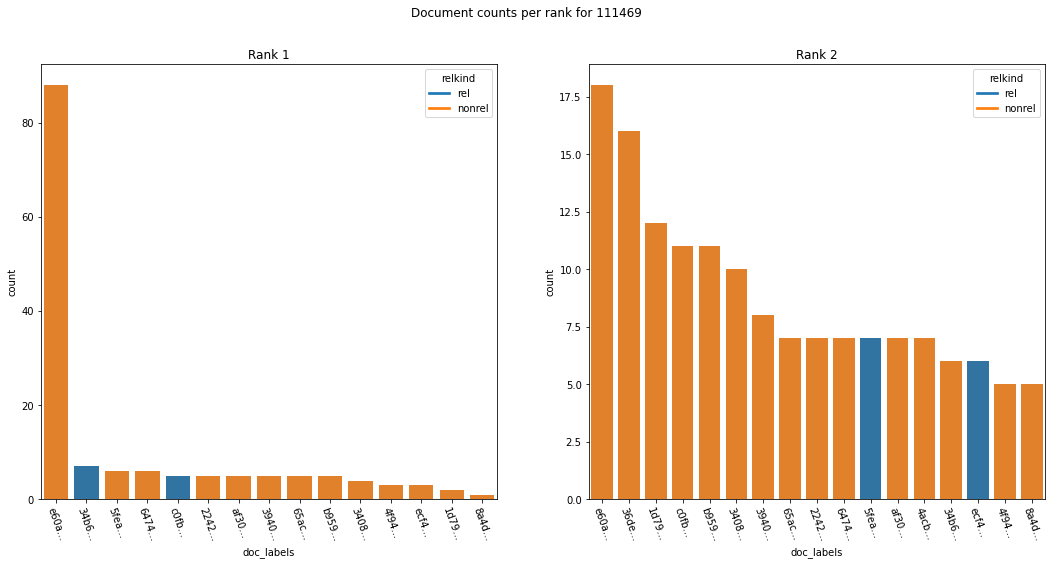

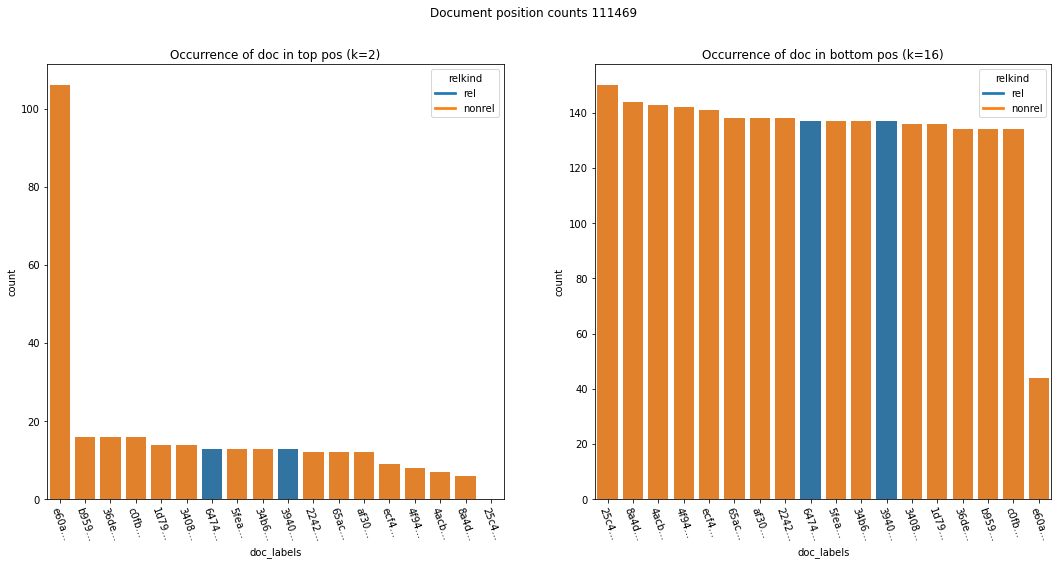

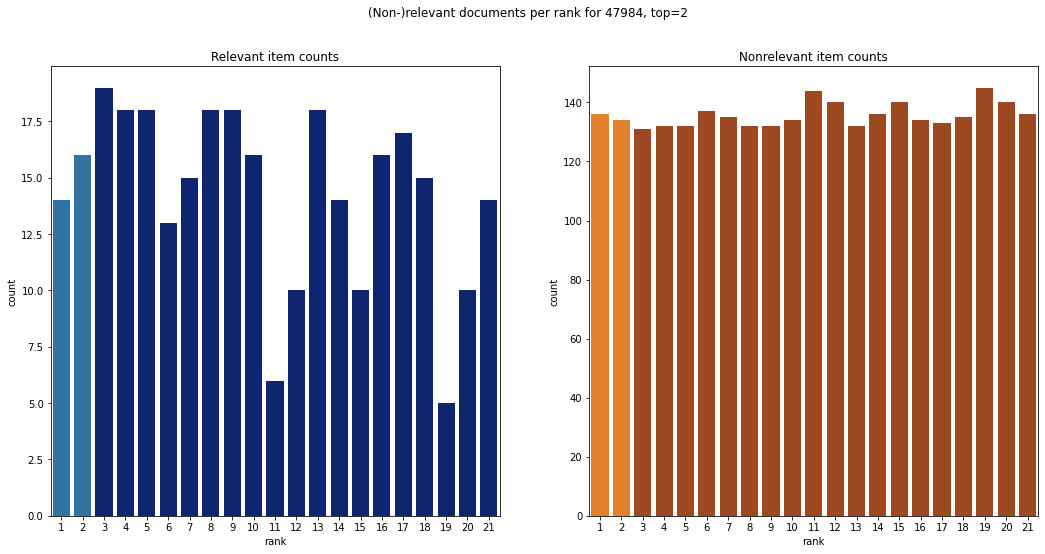

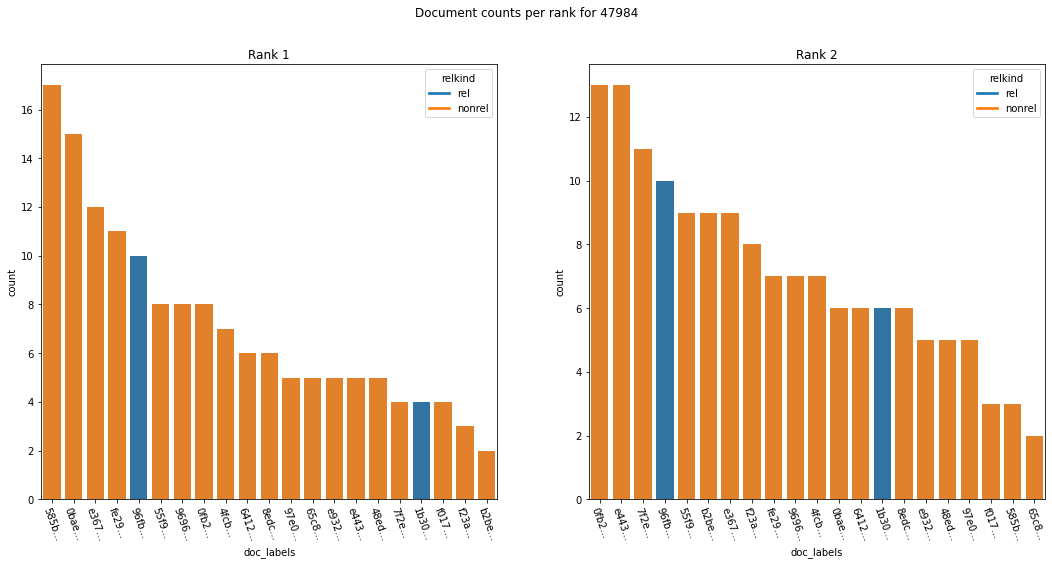

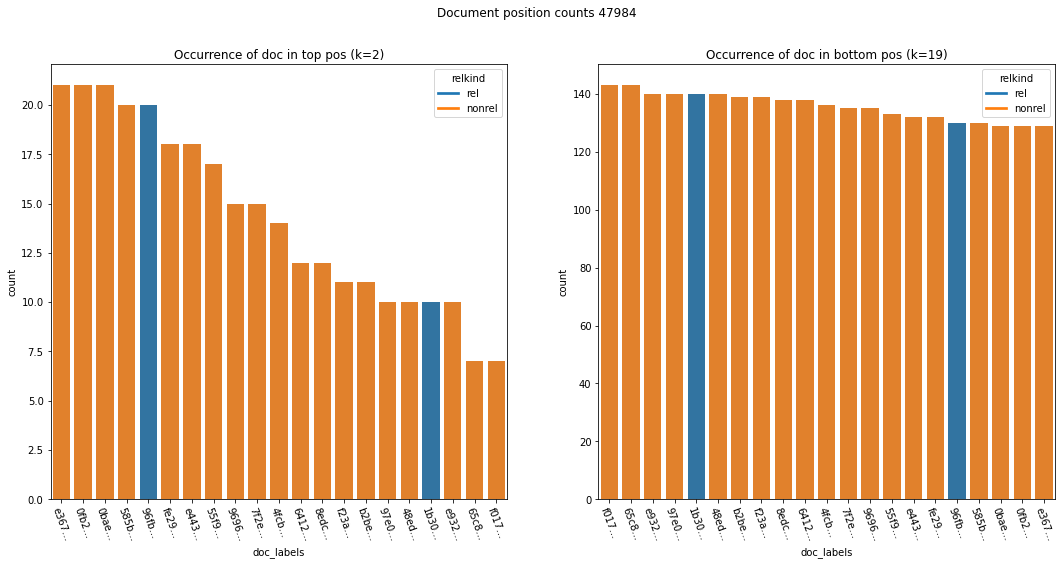

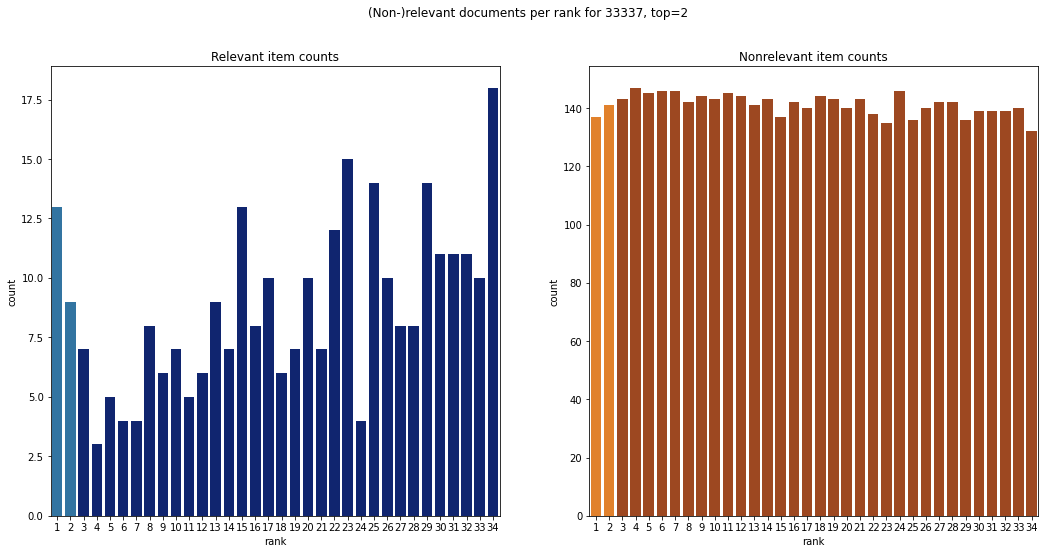

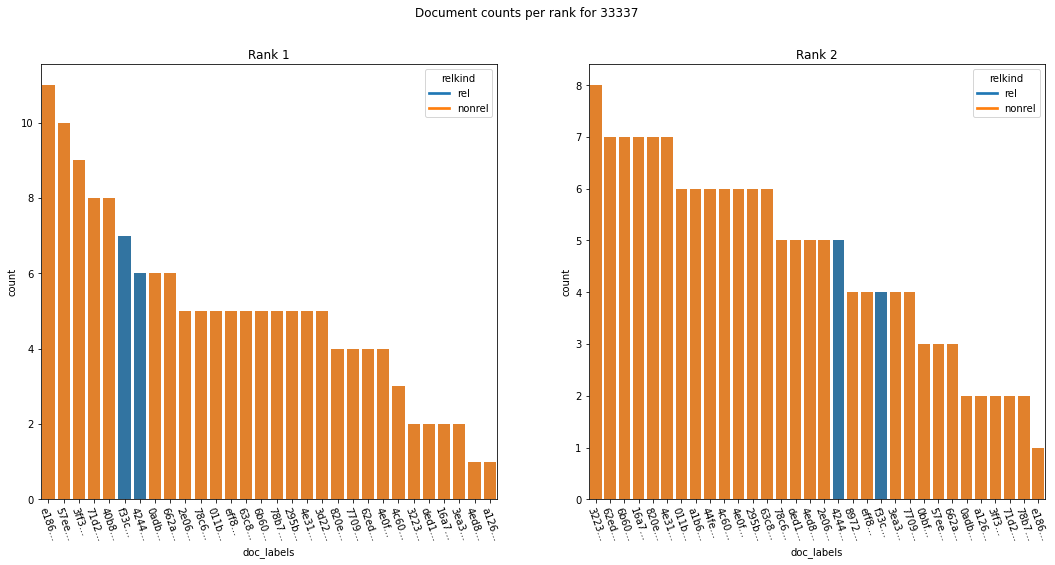

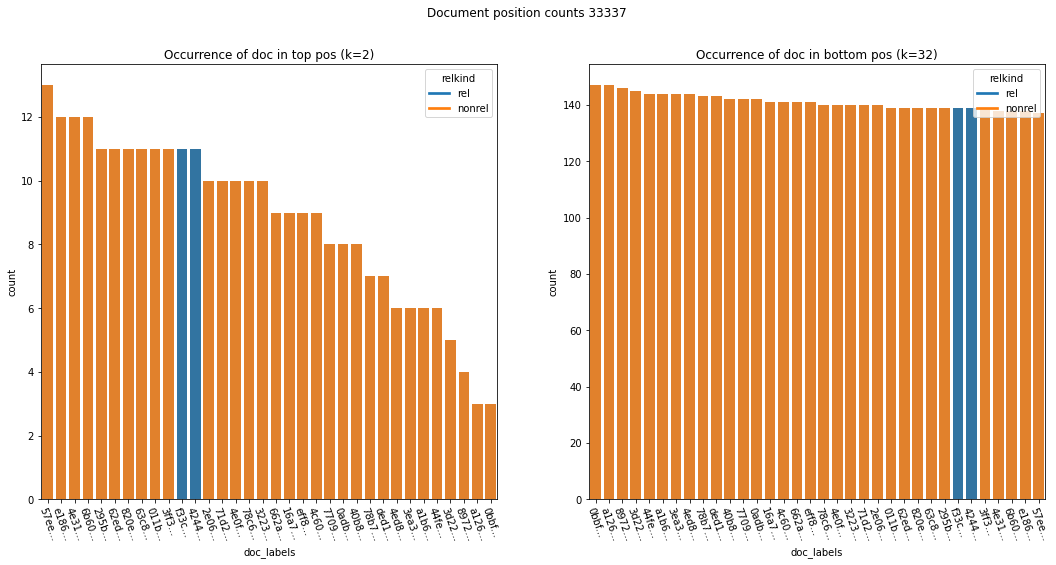

In [54]:
for q in edf.tail(10).qid.to_list():
    rel,nonrel = count_relgrades_qid(q,reldf)
    plot_rel_nonrel_per_rank_per_relkind_for_qid(q, rdf, reldf)
    plot_doc_occurrence_per_rank_for_qid(q,rdf,reldf,k=rel)
    plot_doc_pos_count_for_qid(q,rdf,reldf)

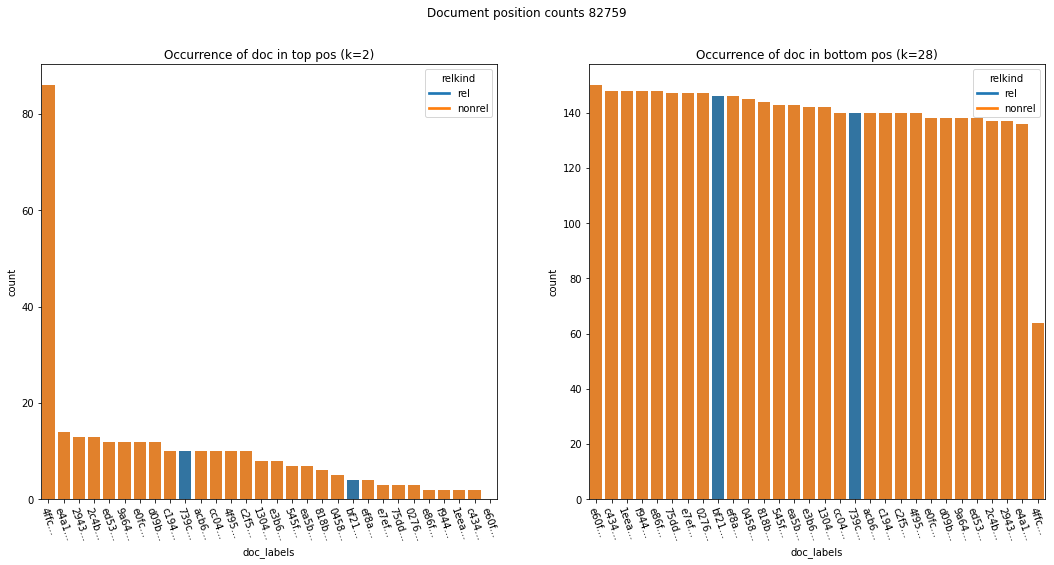

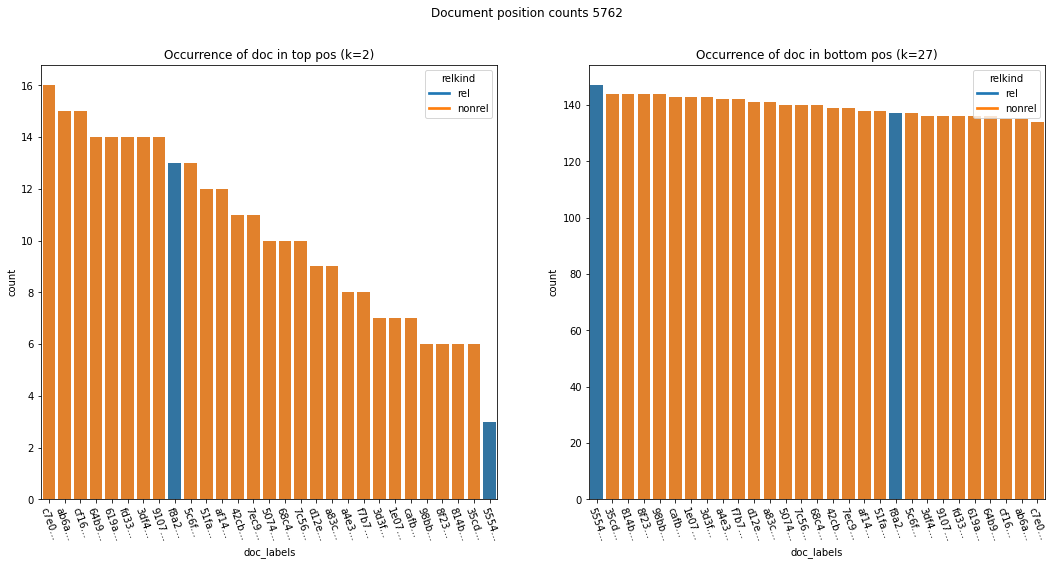

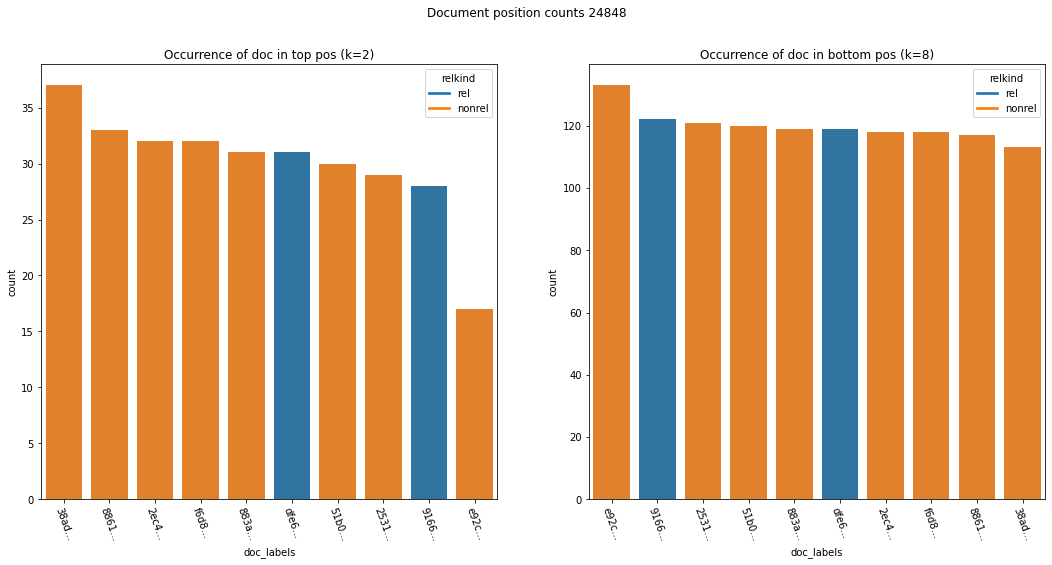

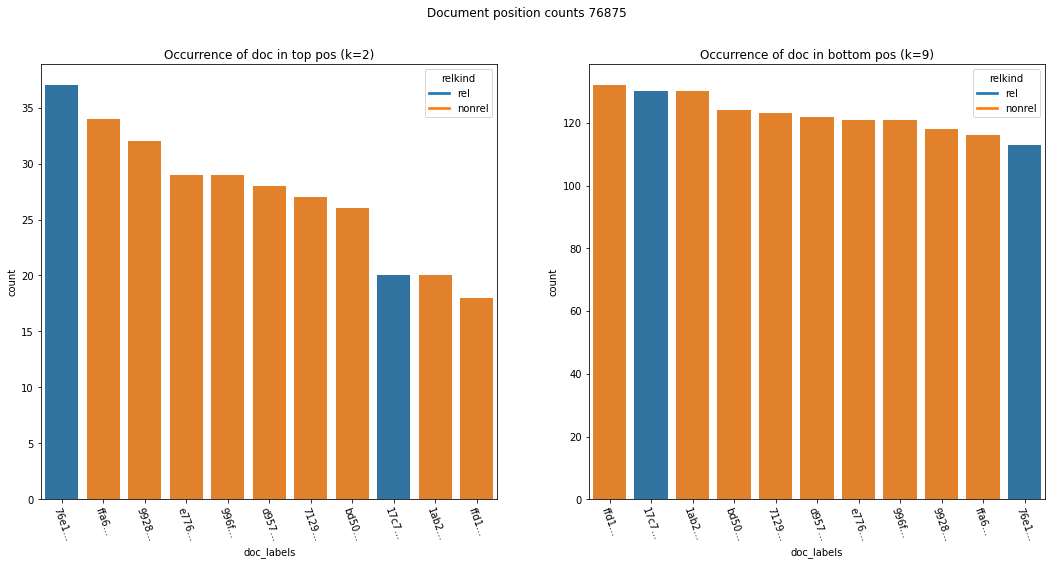

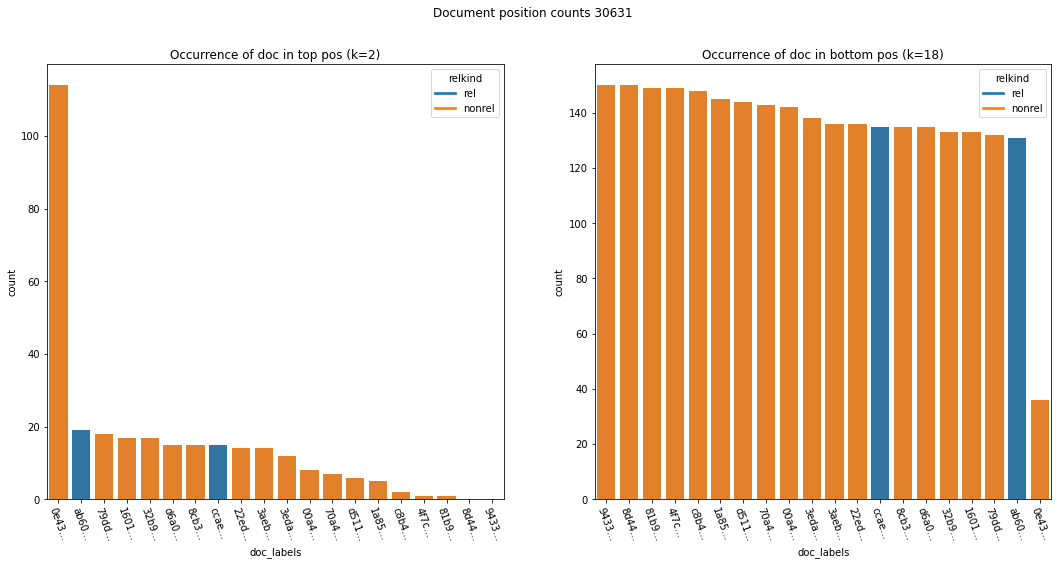

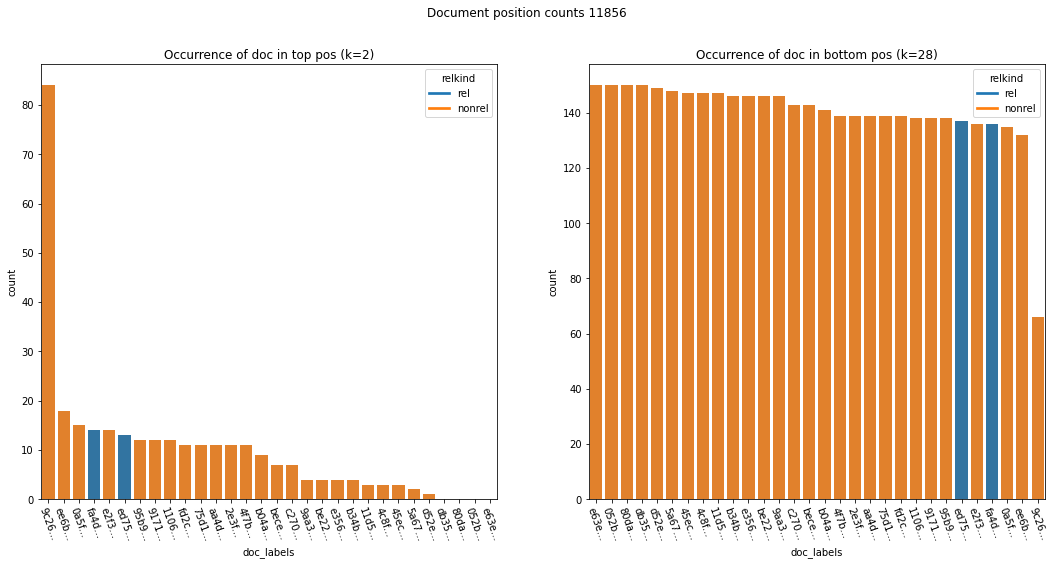

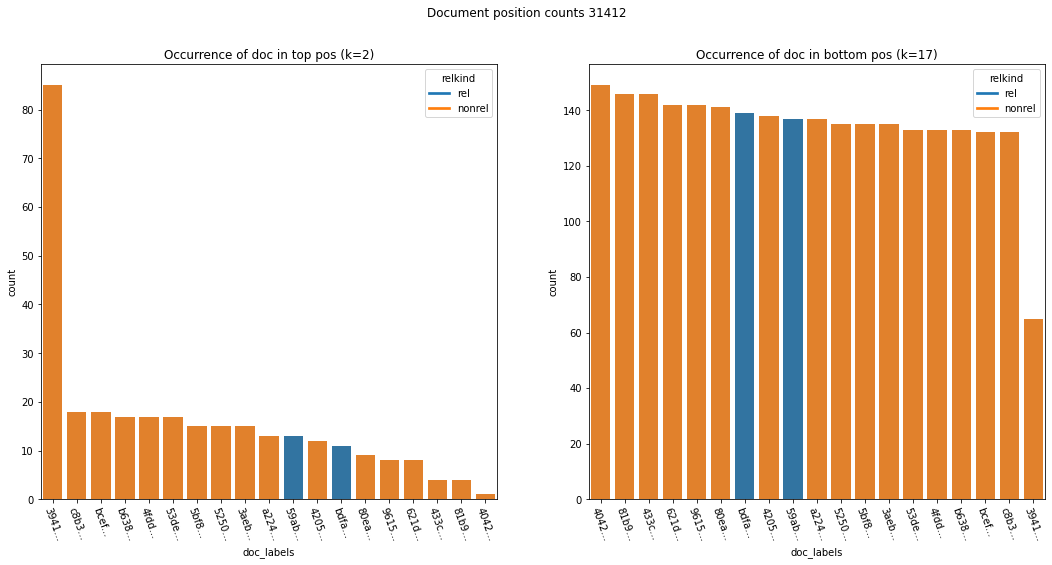

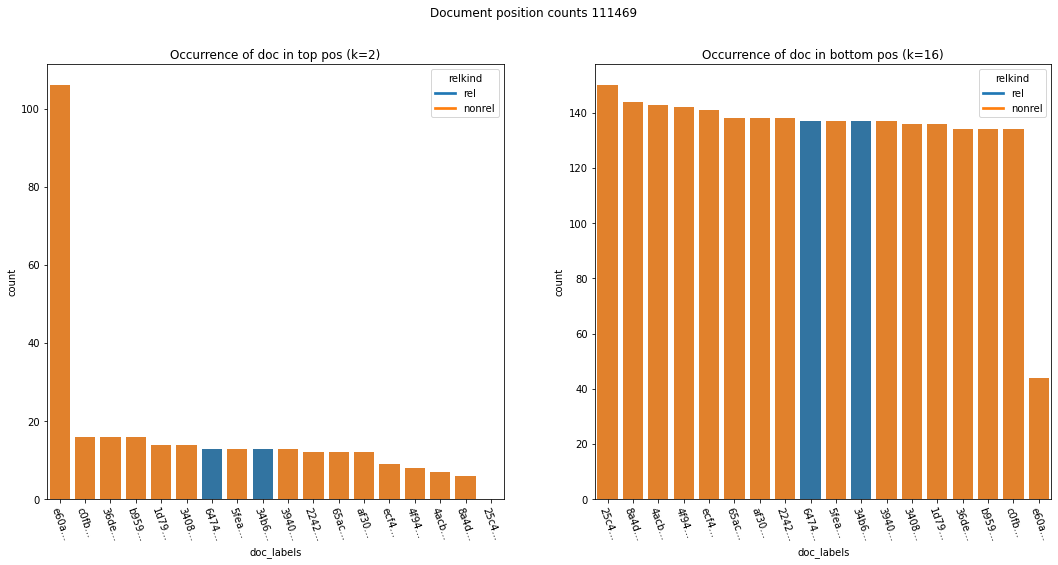

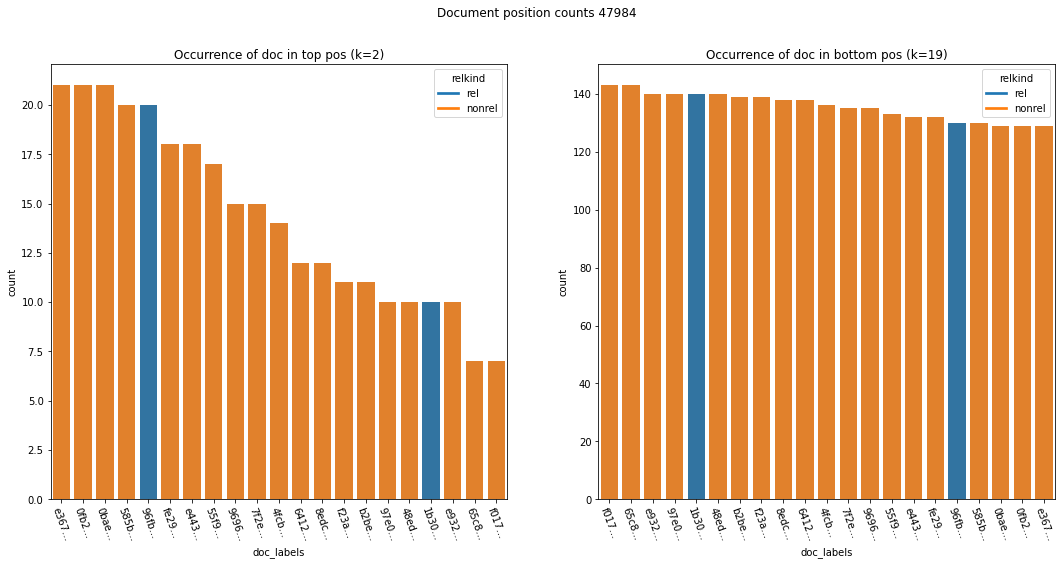

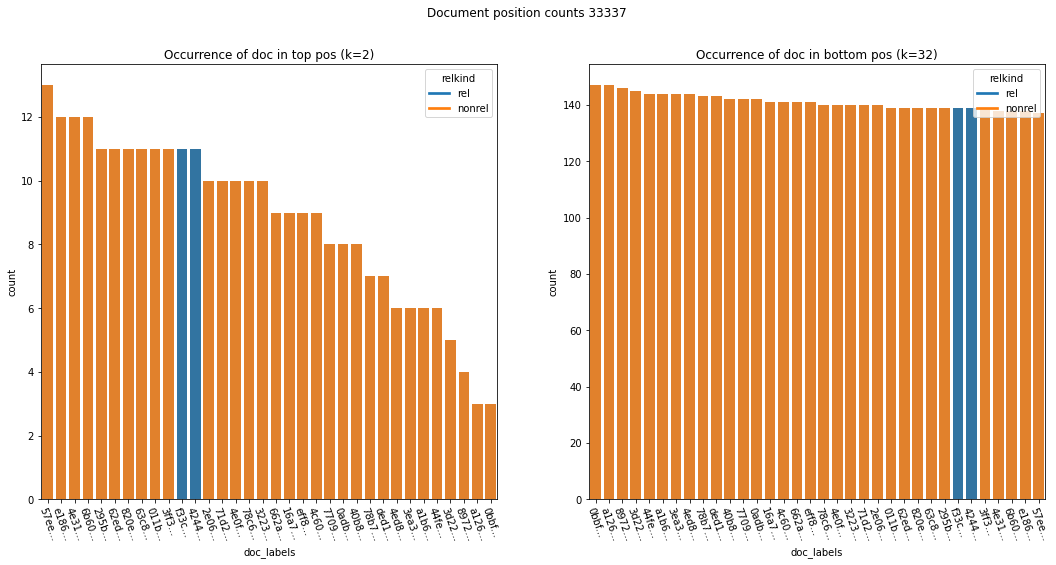

In [306]:
for q in edf.tail(10).qid.to_list():
    plot_doc_pos_count_for_qid(q,rdf,reldf,sortby=['count'])

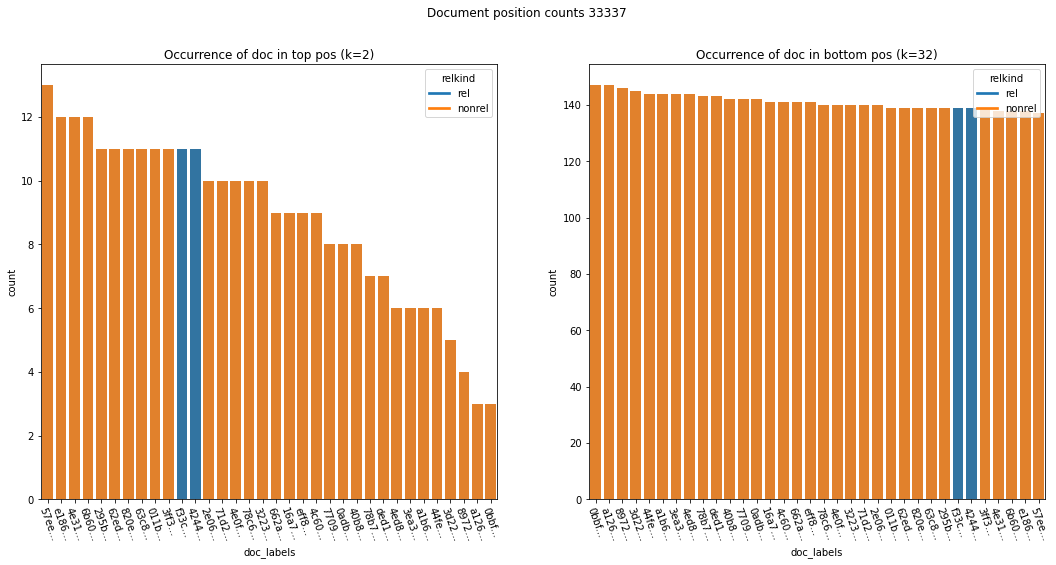

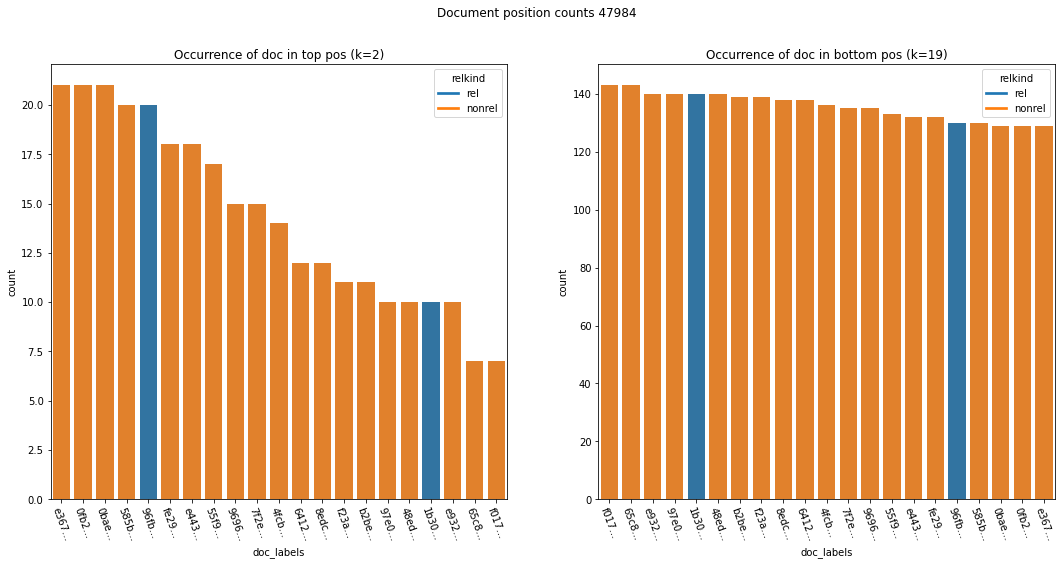

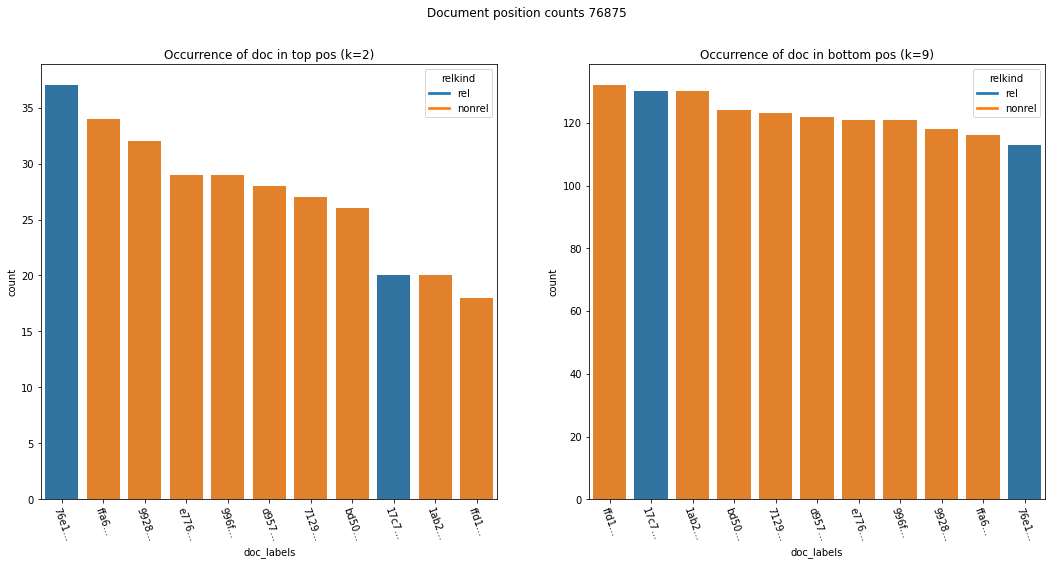

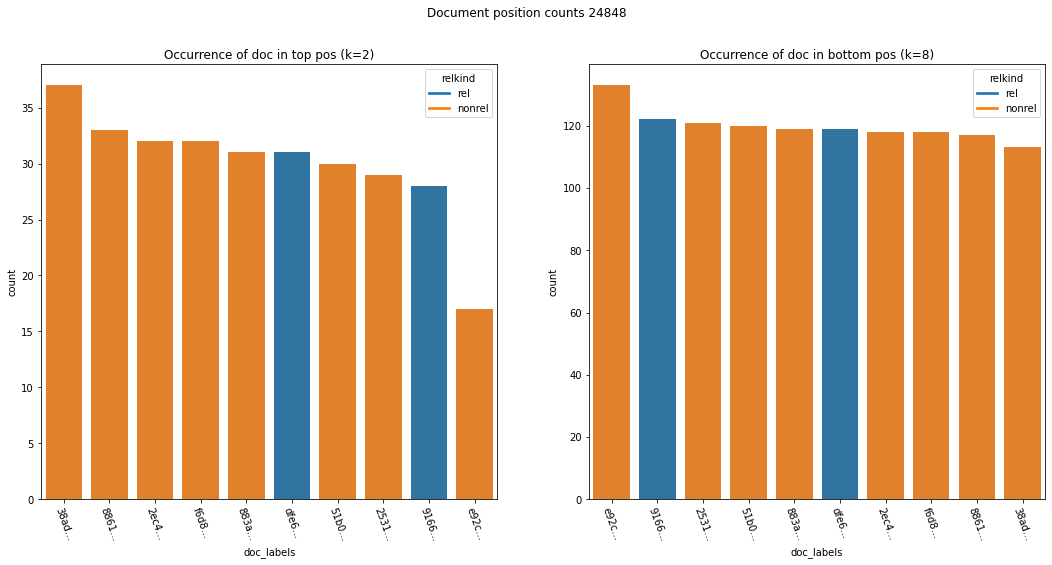

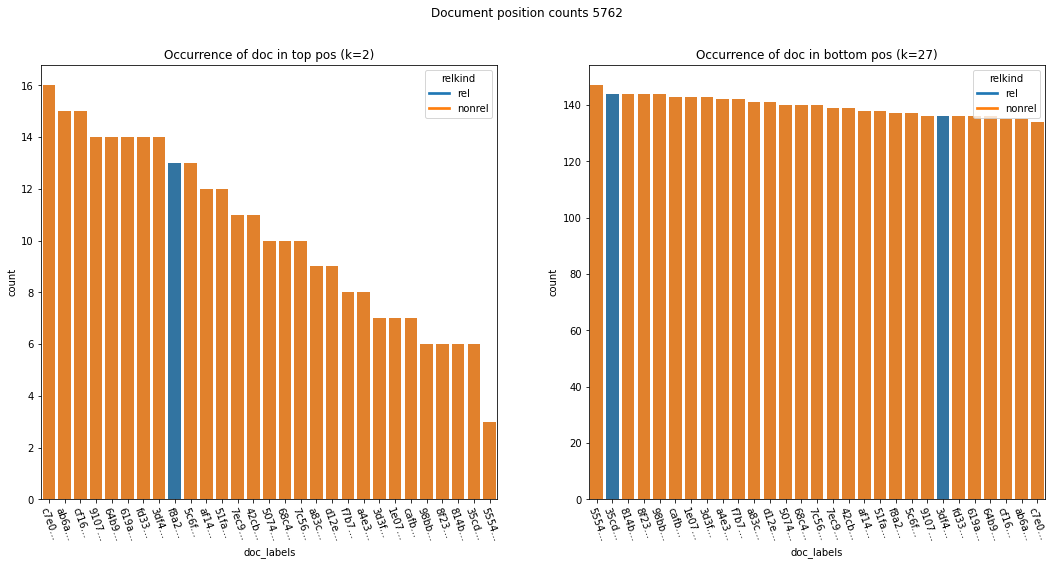

In [85]:
for q in edf.tail(10).iloc[::-1].qid.to_list():
    if not q in [82759,111469,31412,11856,30631]: 
        plot_doc_pos_count_for_qid(q,rdf,reldf,sortby=['count'])

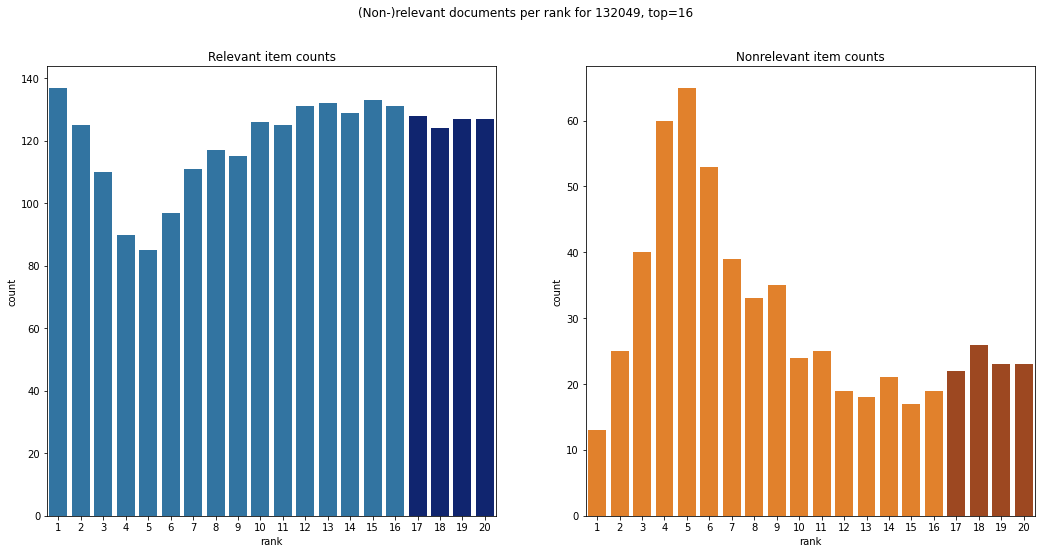

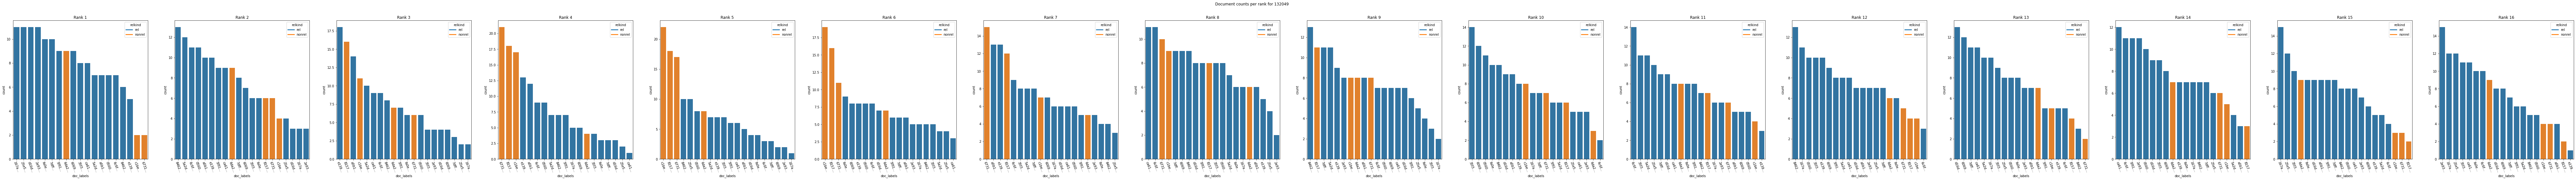

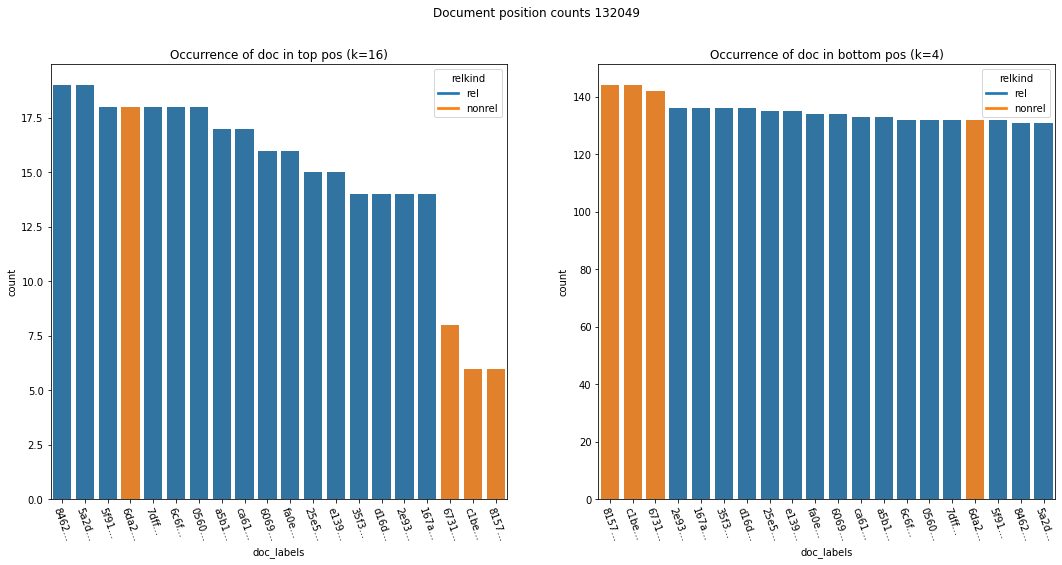

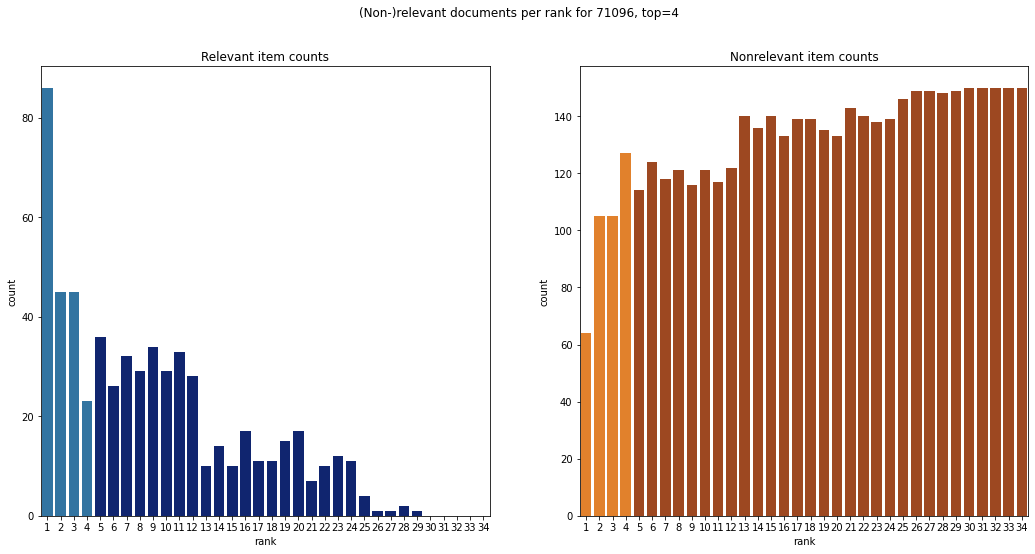

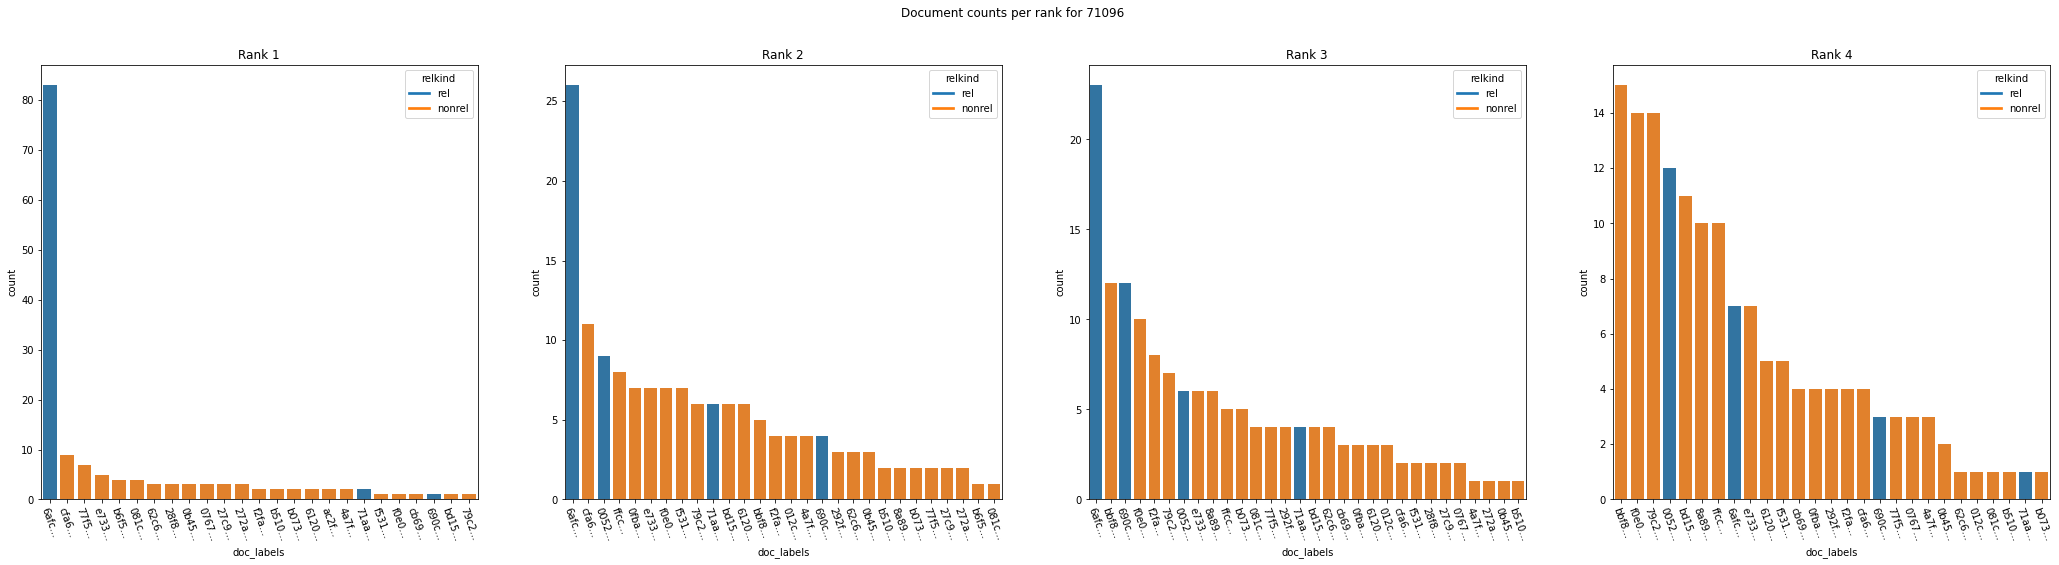

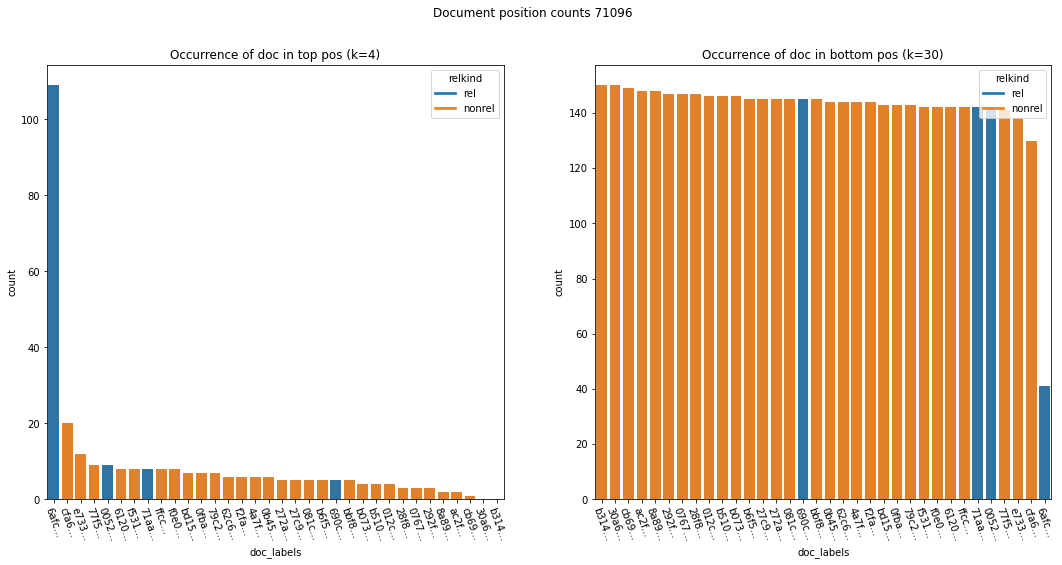

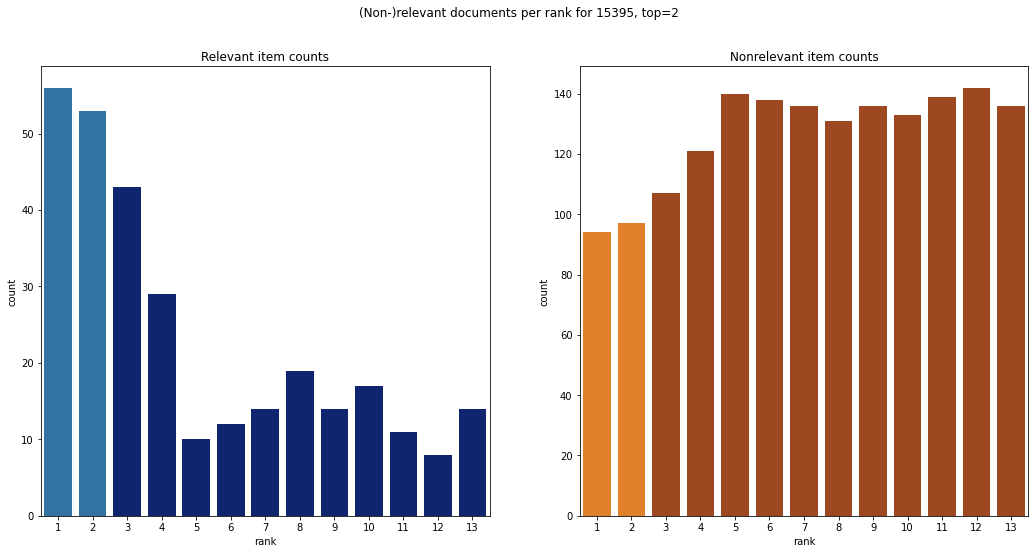

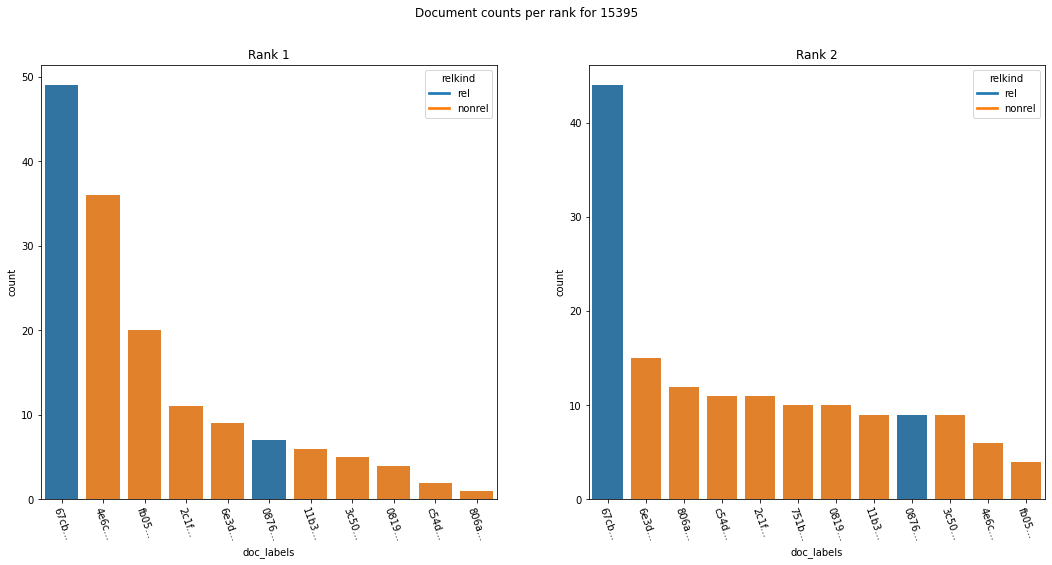

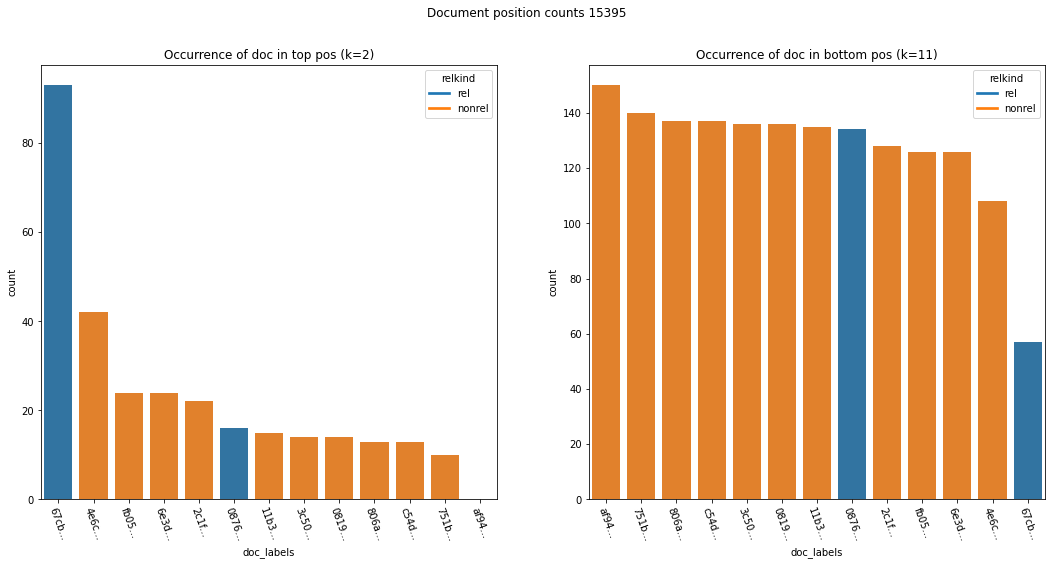

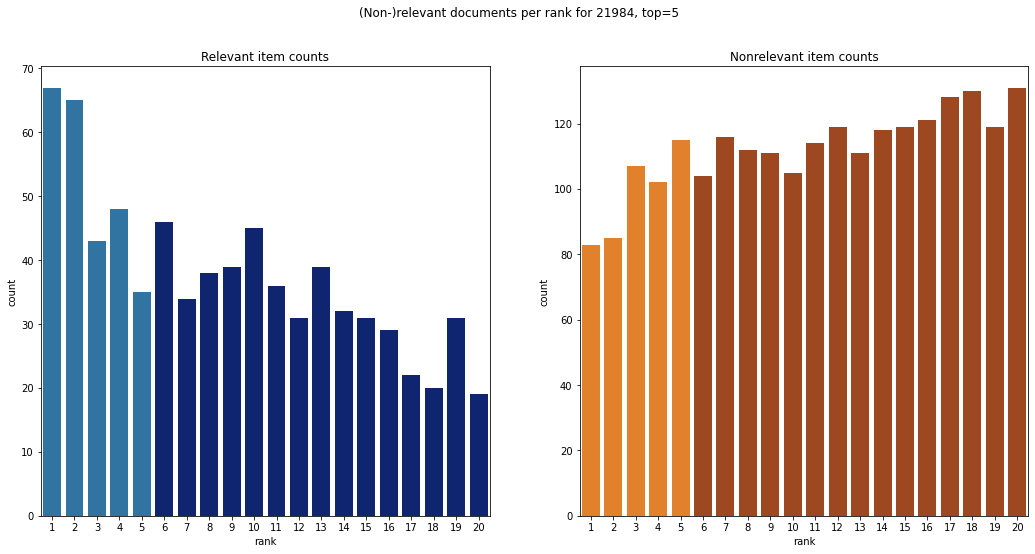

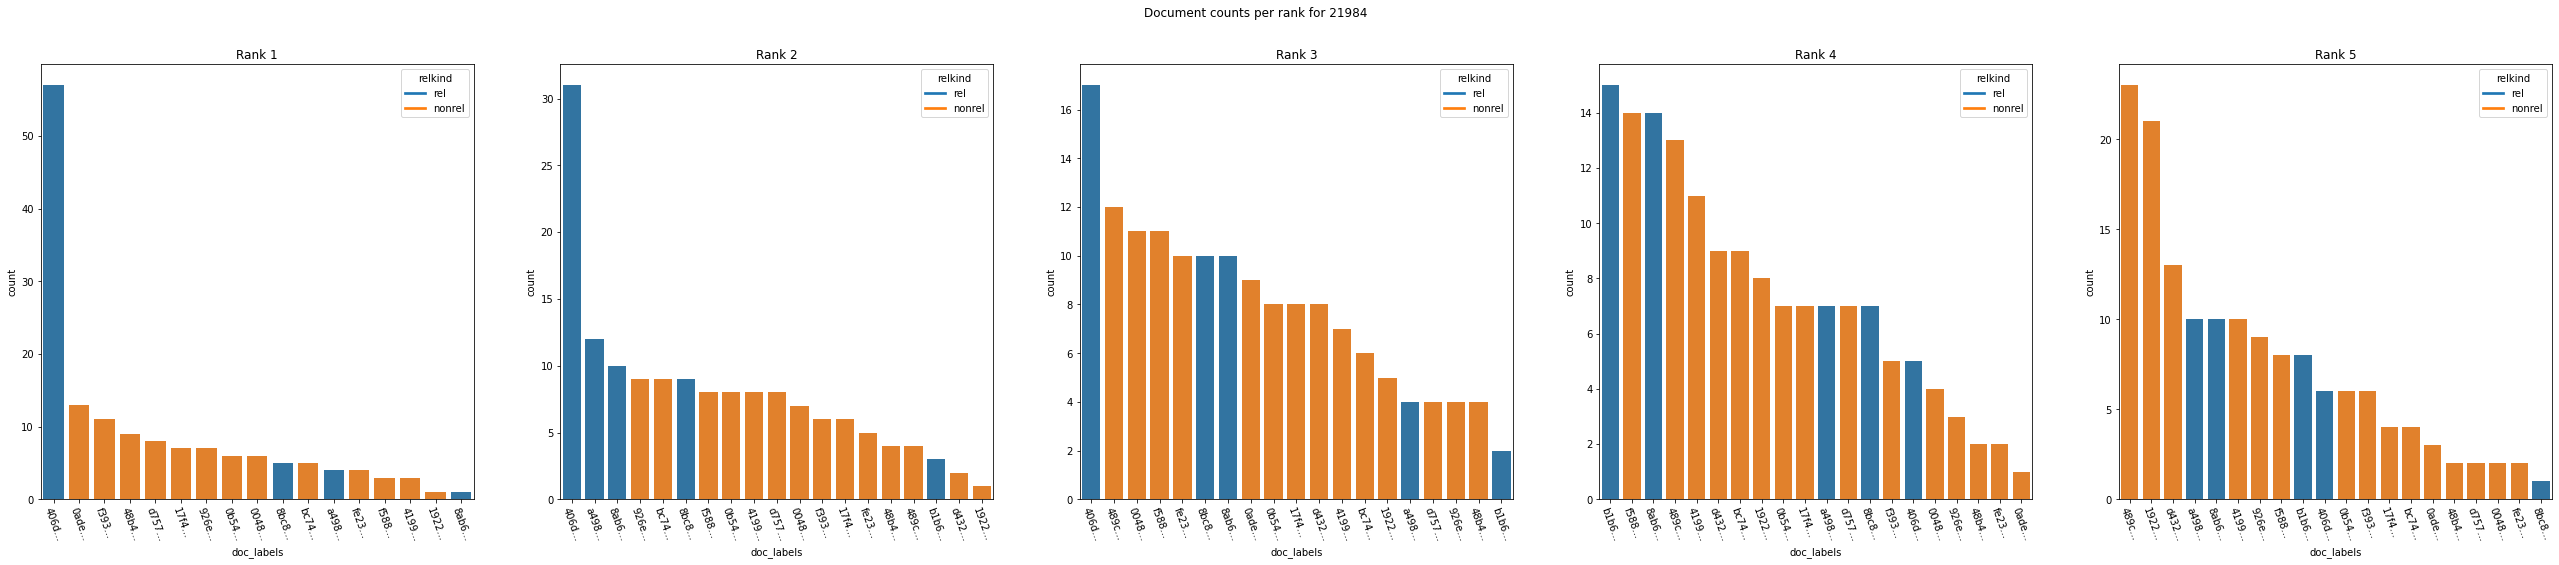

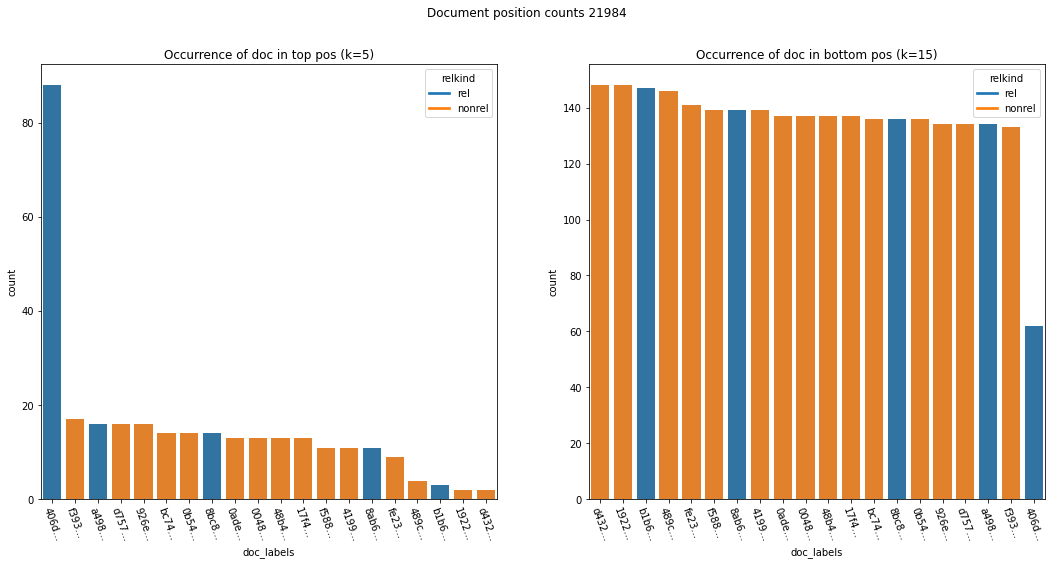

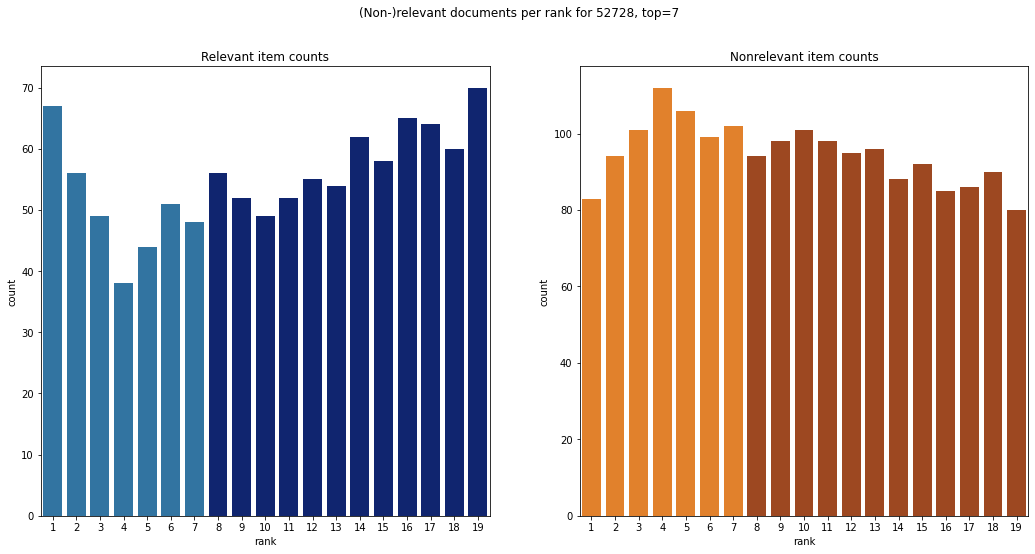

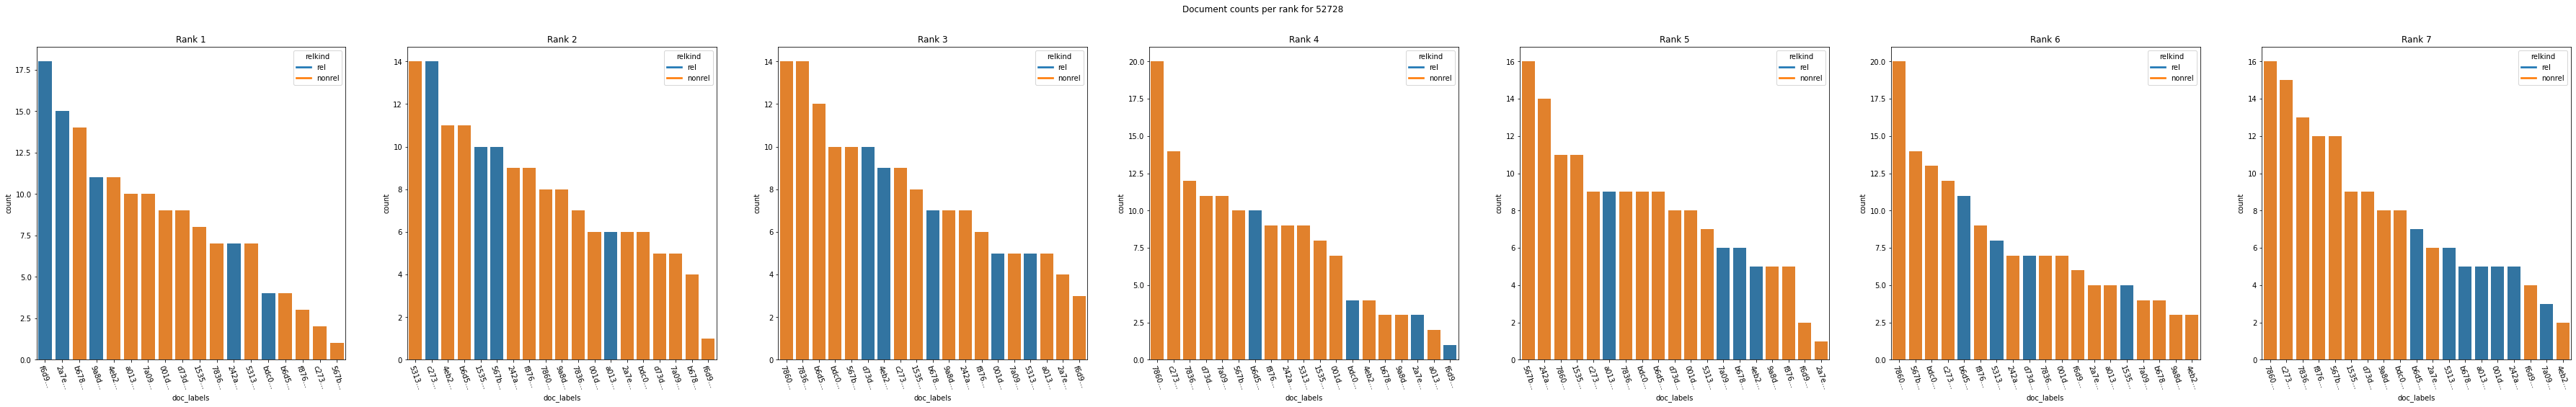

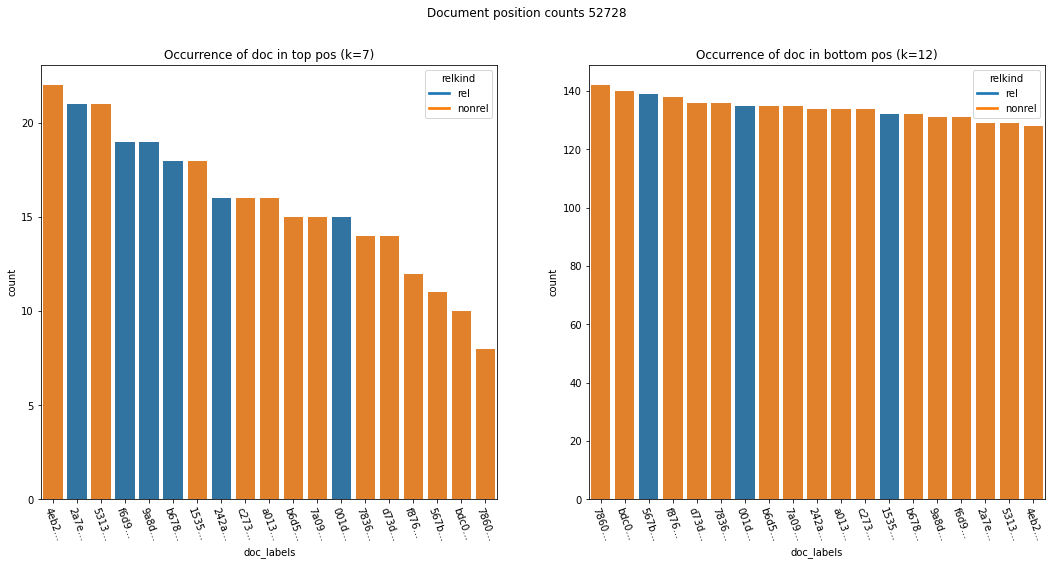

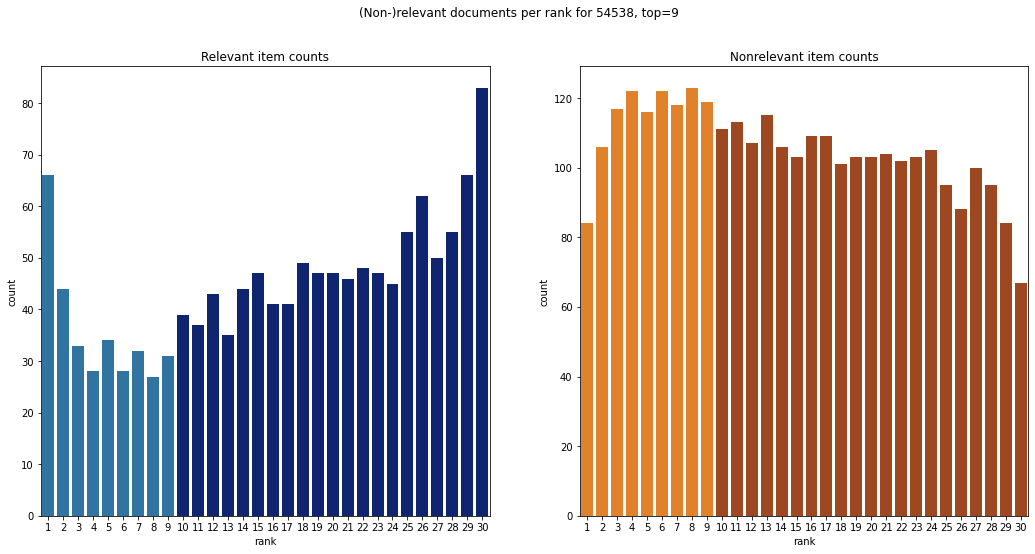

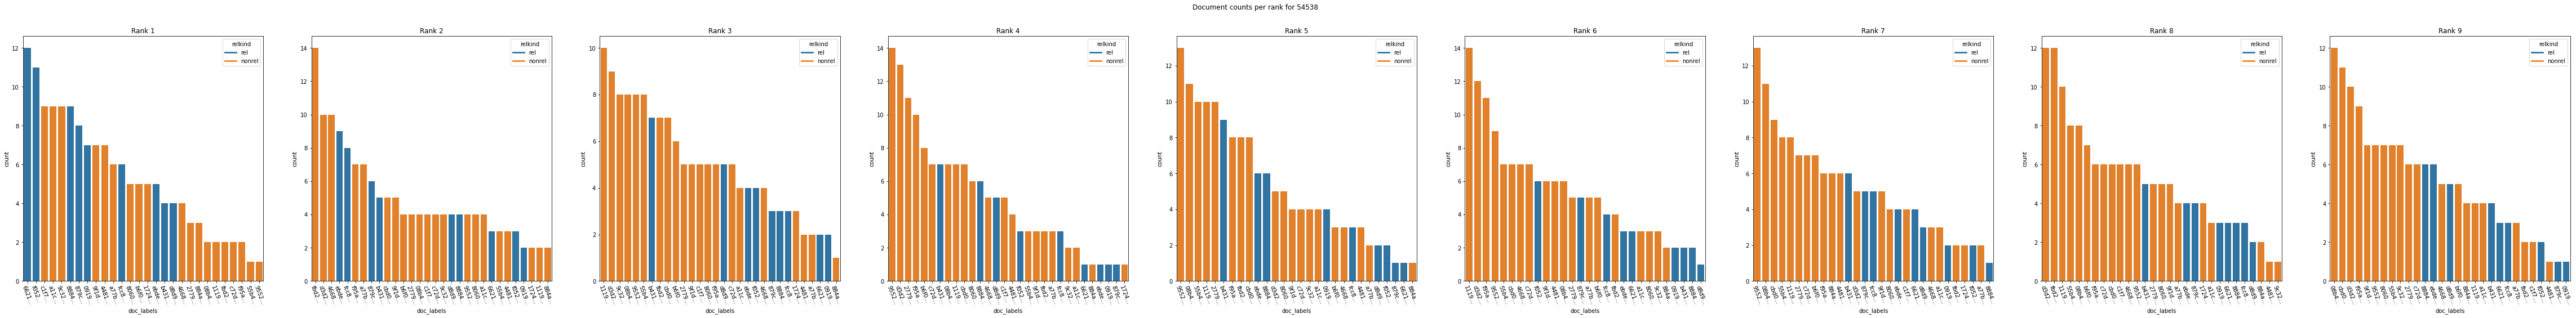

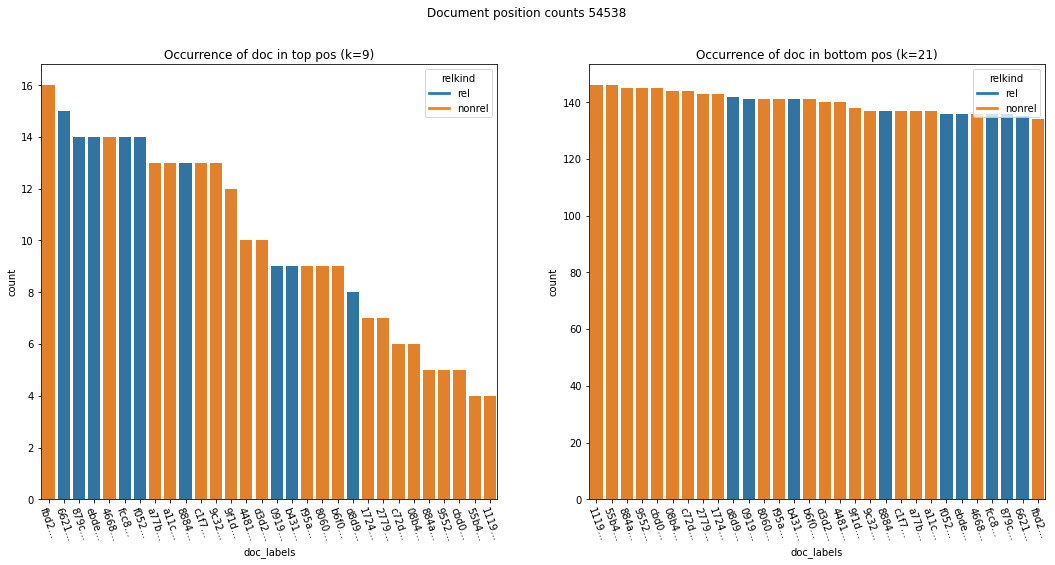

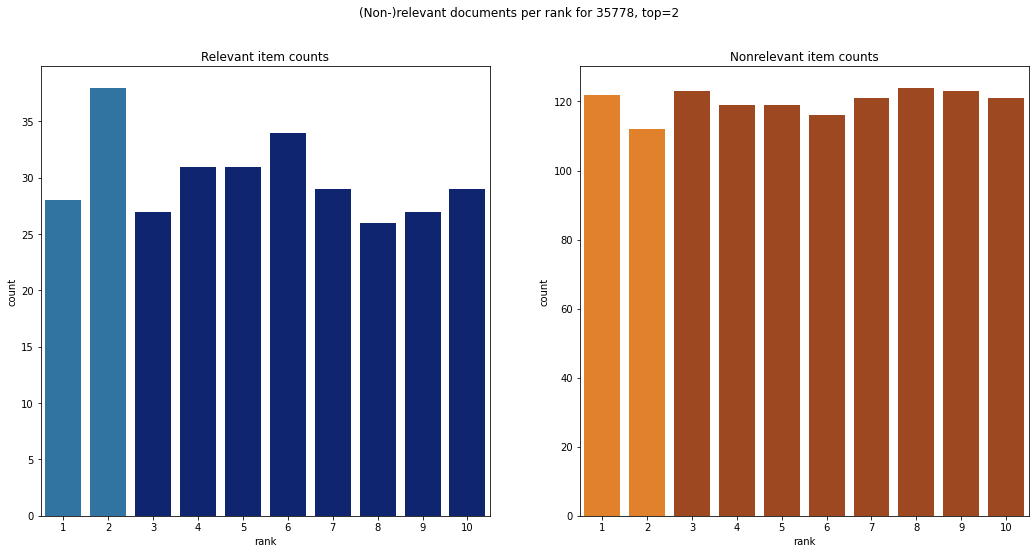

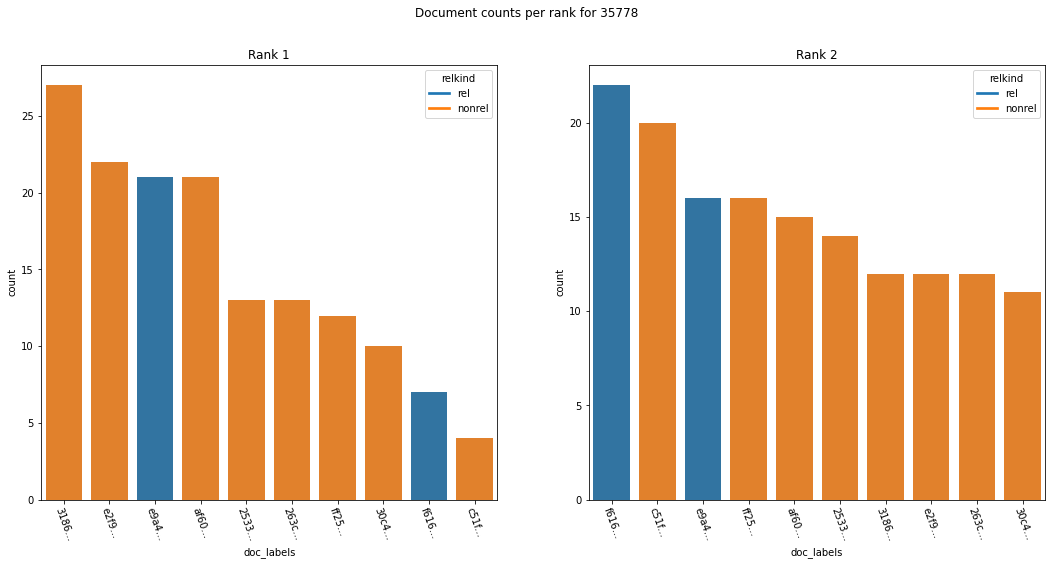

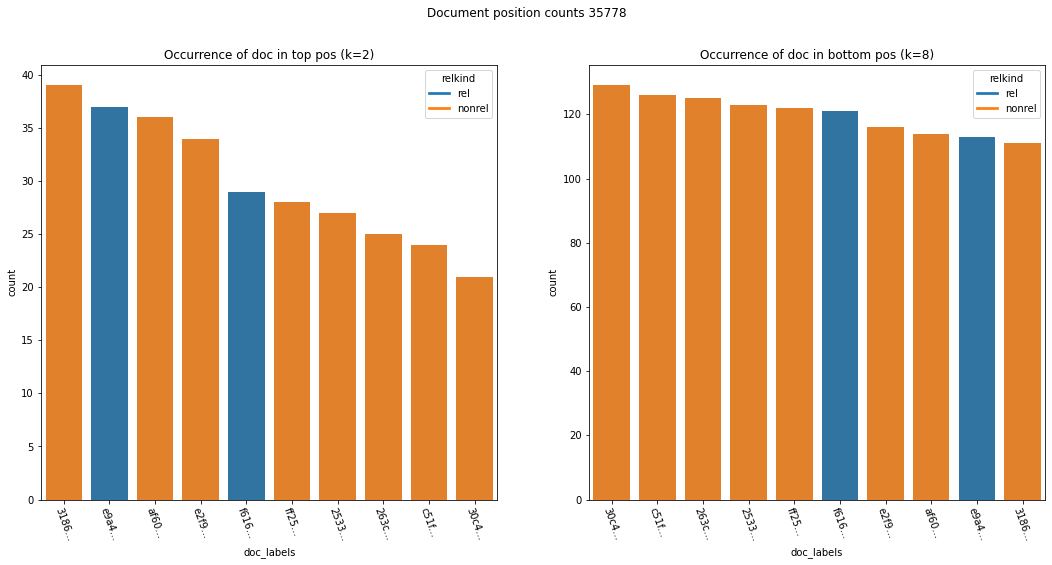

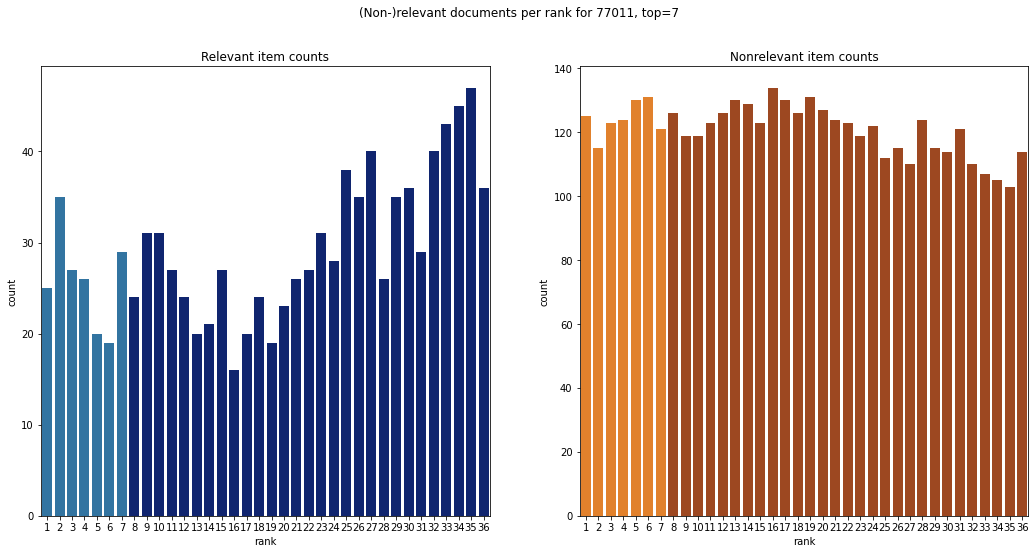

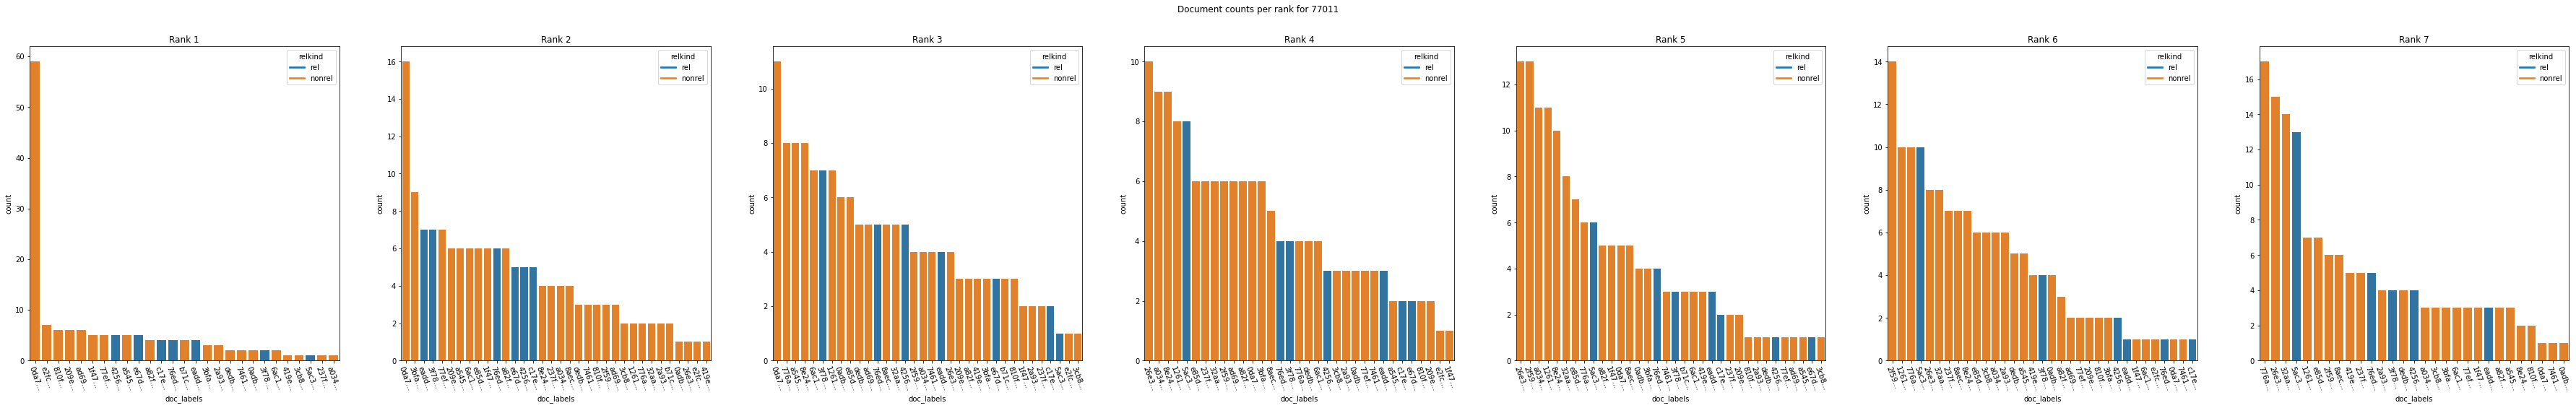

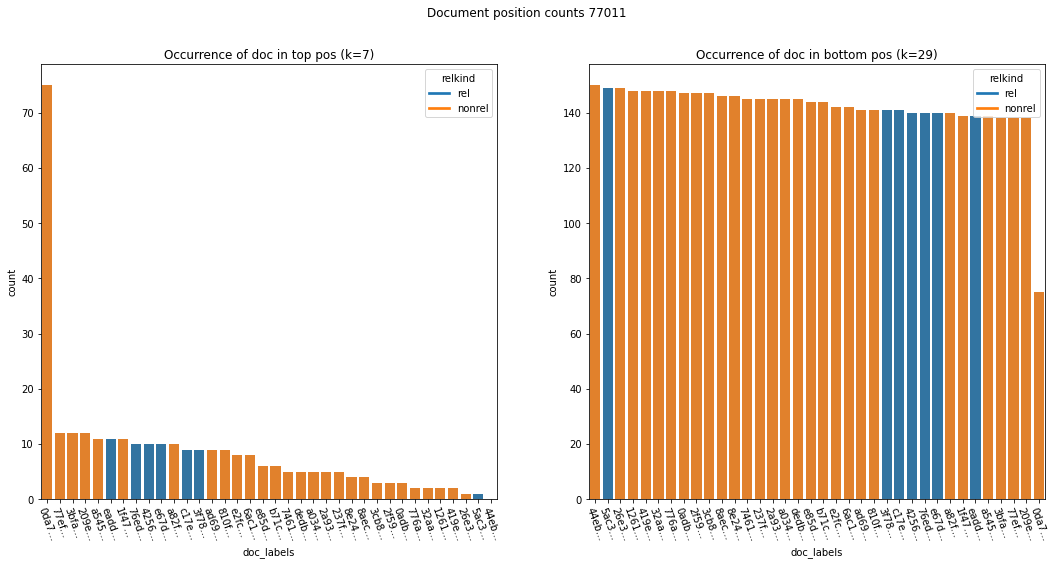

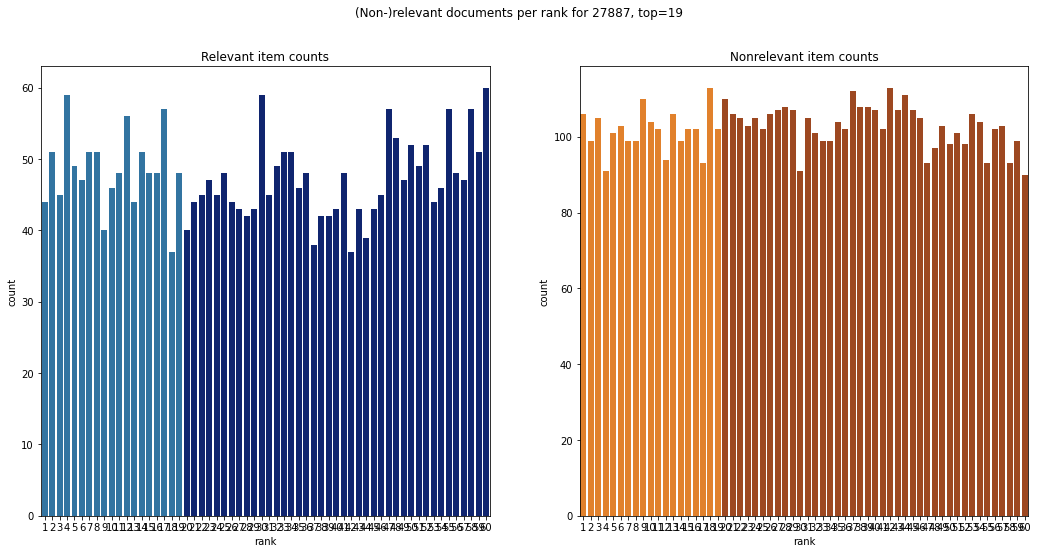

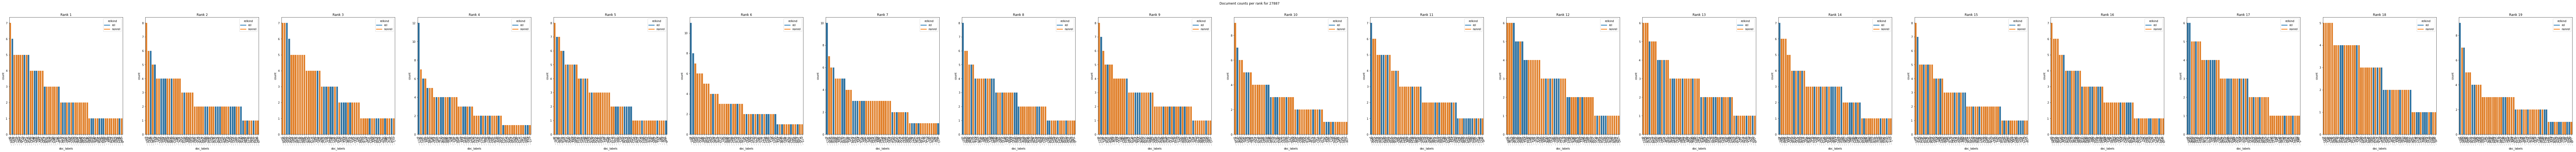

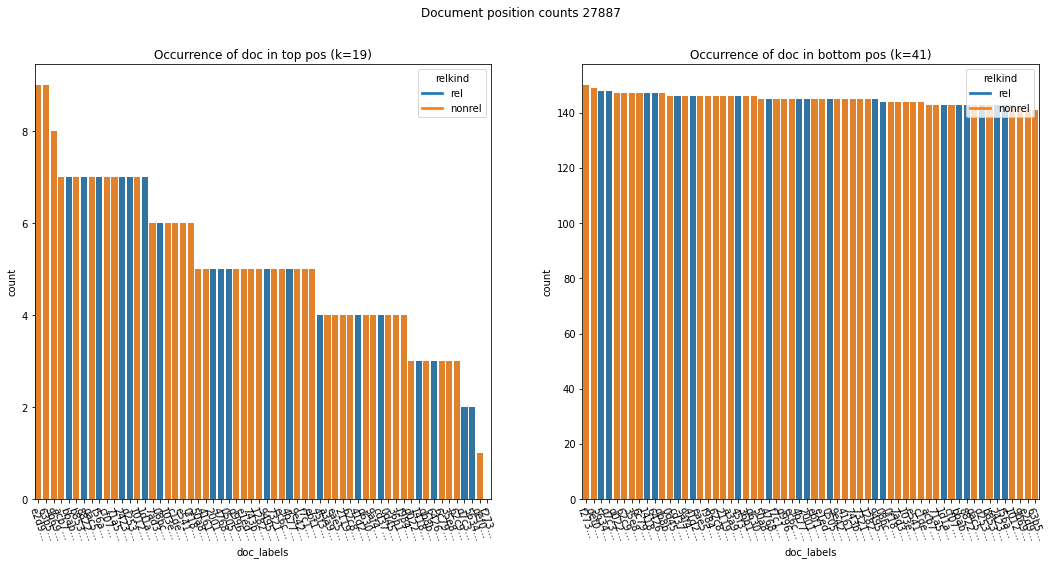

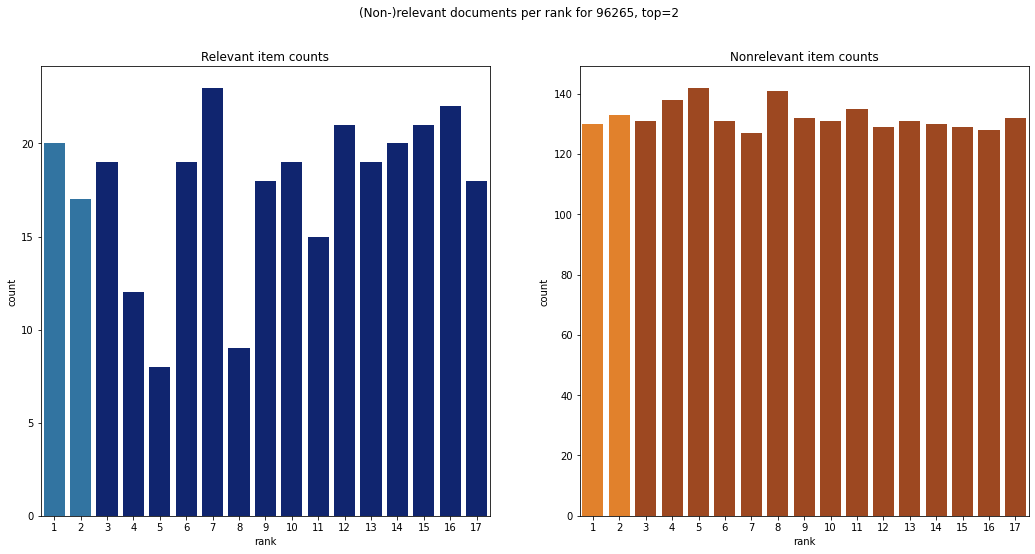

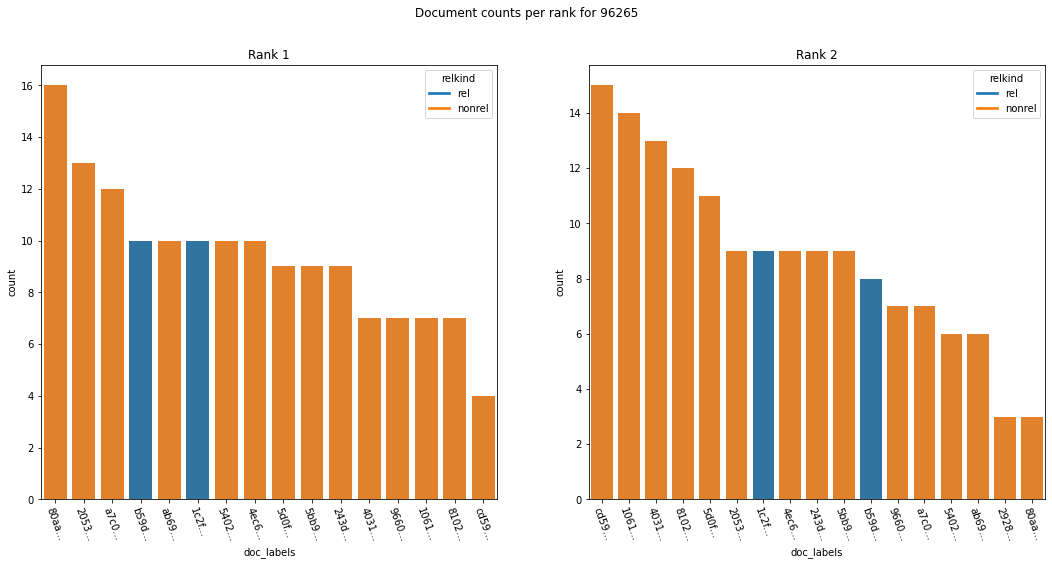

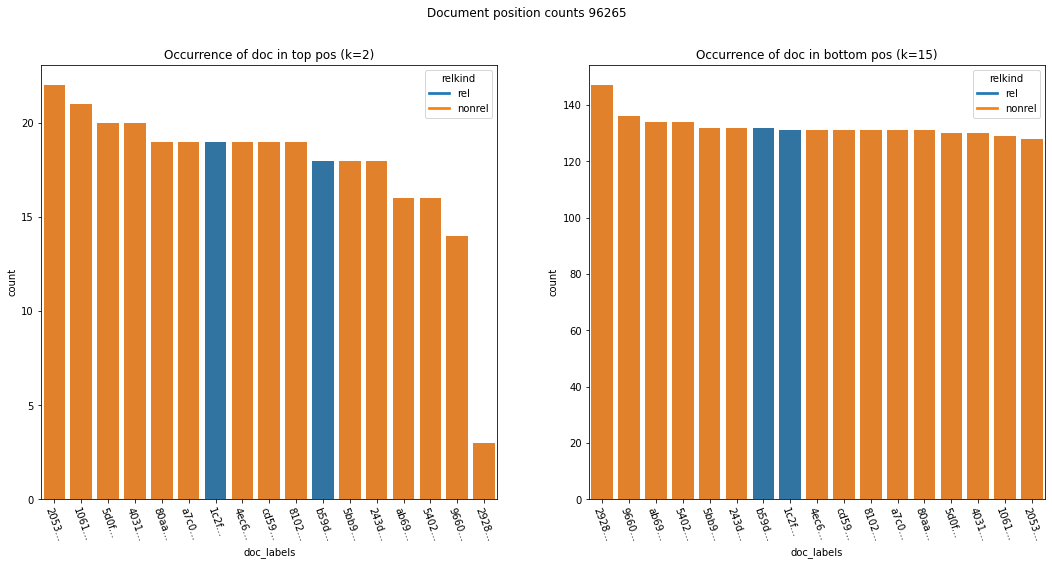

In [56]:
for q in edf.head(10).qid.to_list():
    rel,nonrel = count_relgrades_qid(q,reldf)
    plot_rel_nonrel_per_rank_per_relkind_for_qid(q, rdf, reldf)
    plot_doc_occurrence_per_rank_for_qid(q,rdf,reldf,k=rel)
    plot_doc_pos_count_for_qid(q,rdf,reldf)

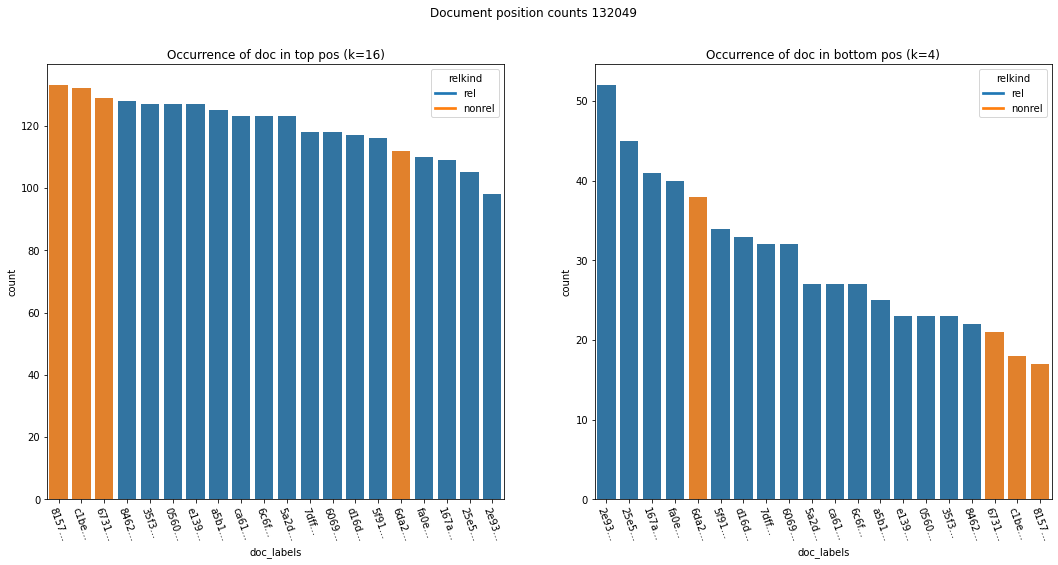

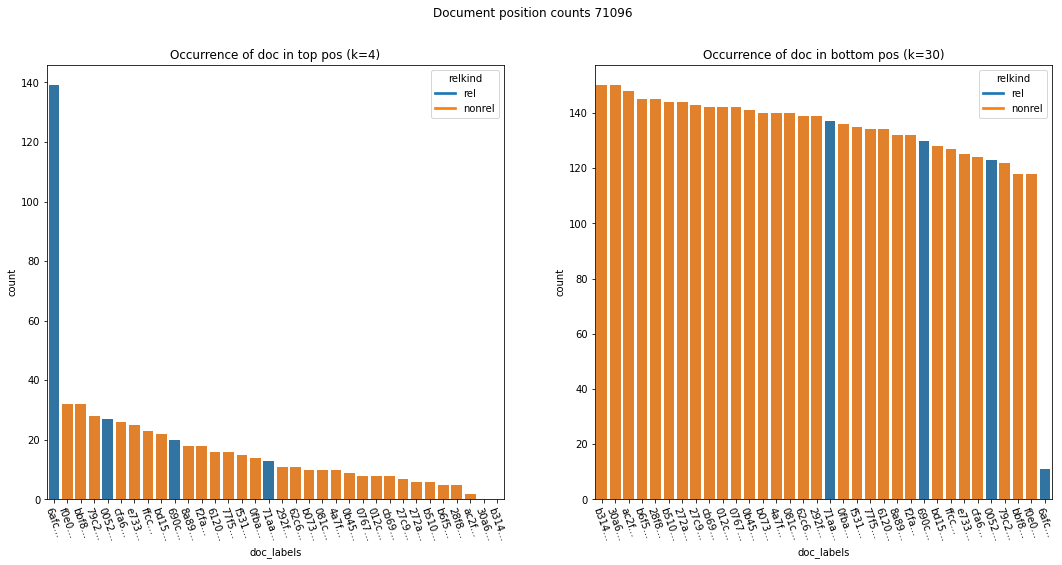

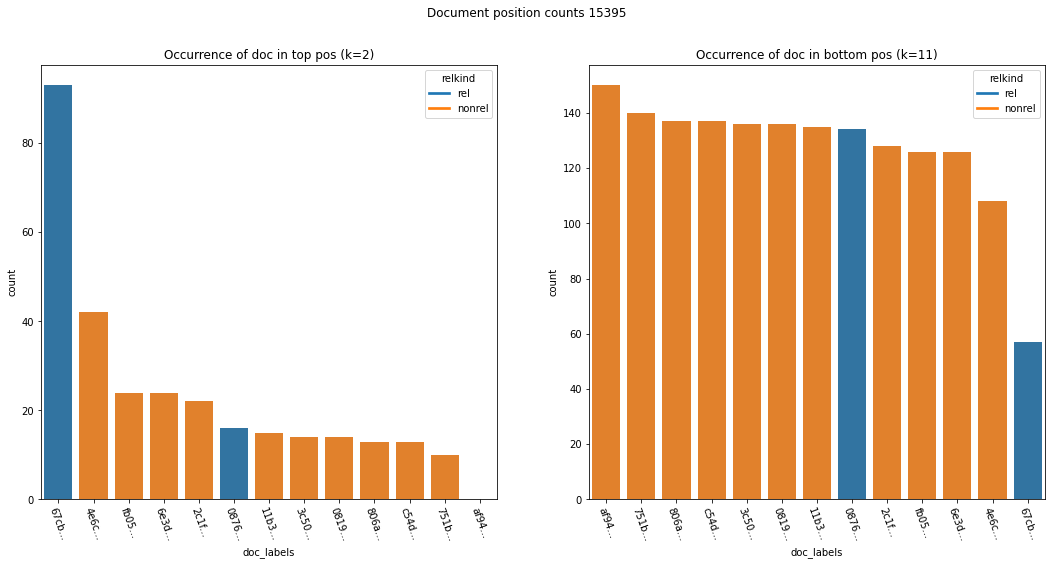

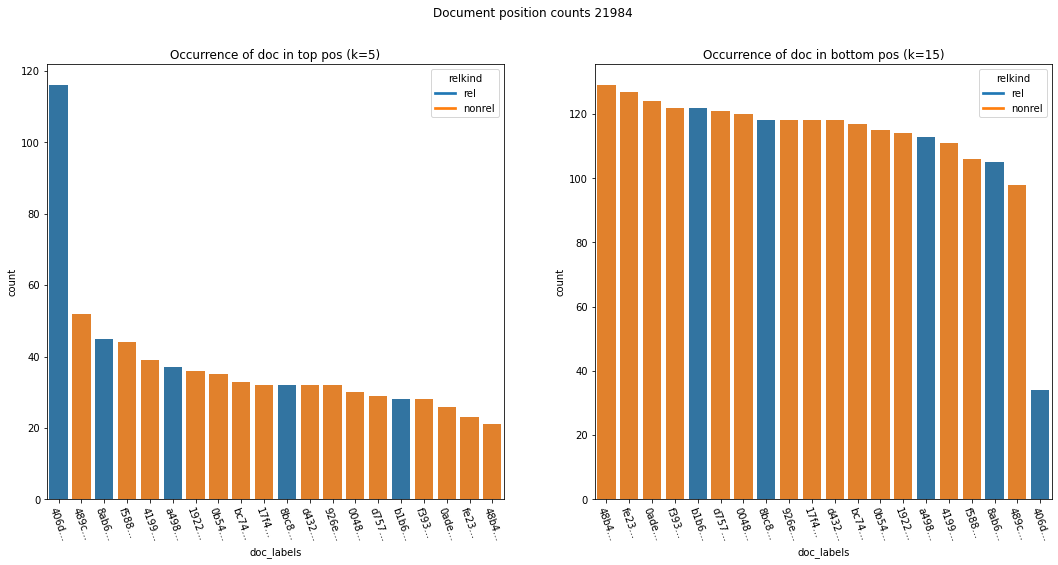

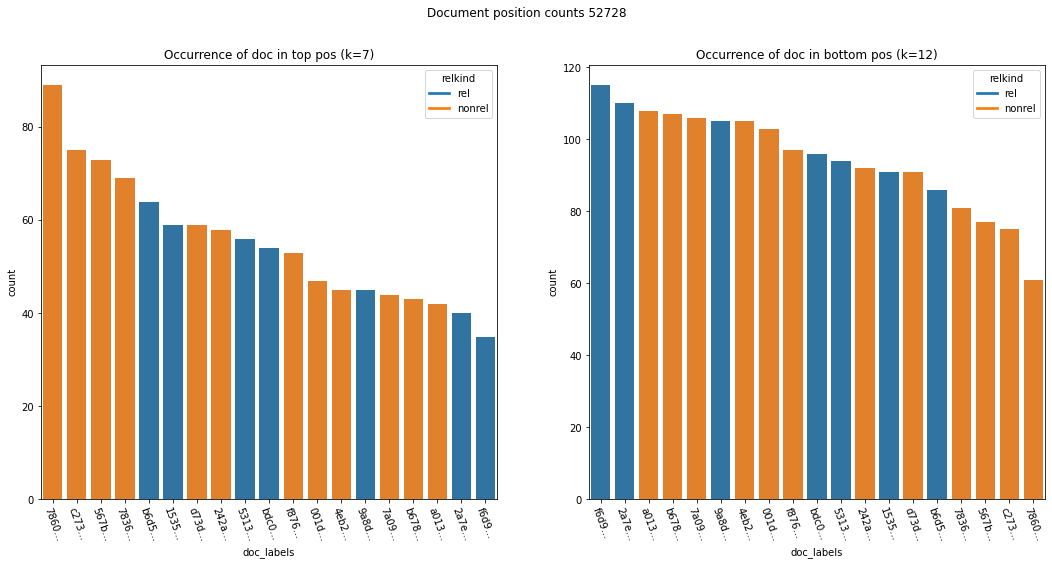

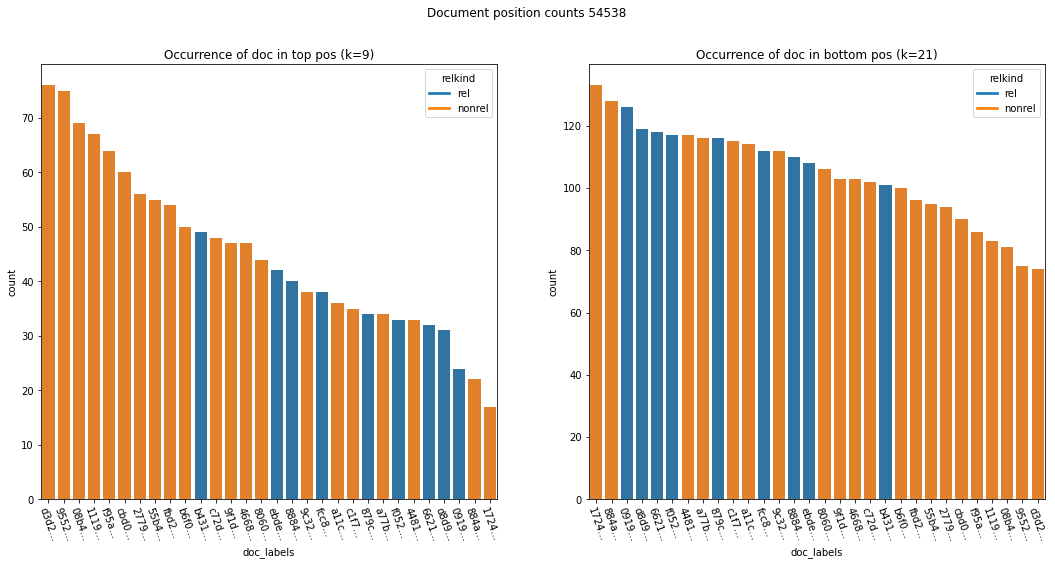

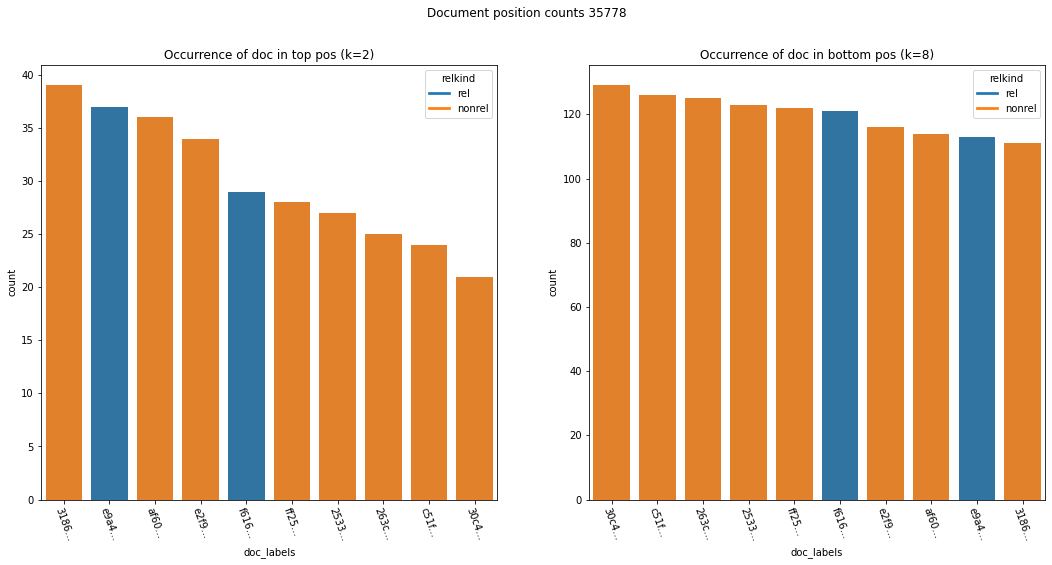

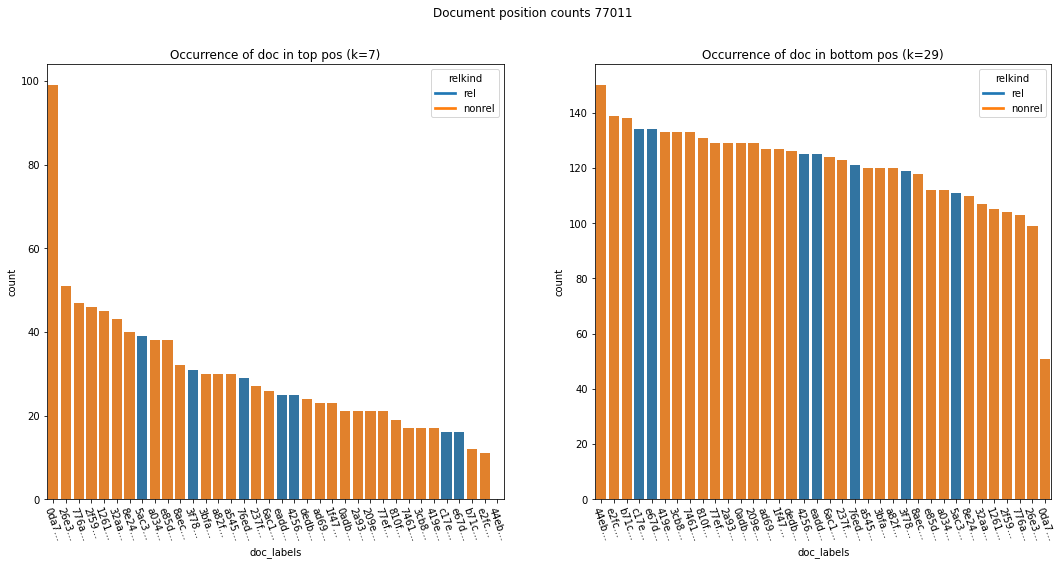

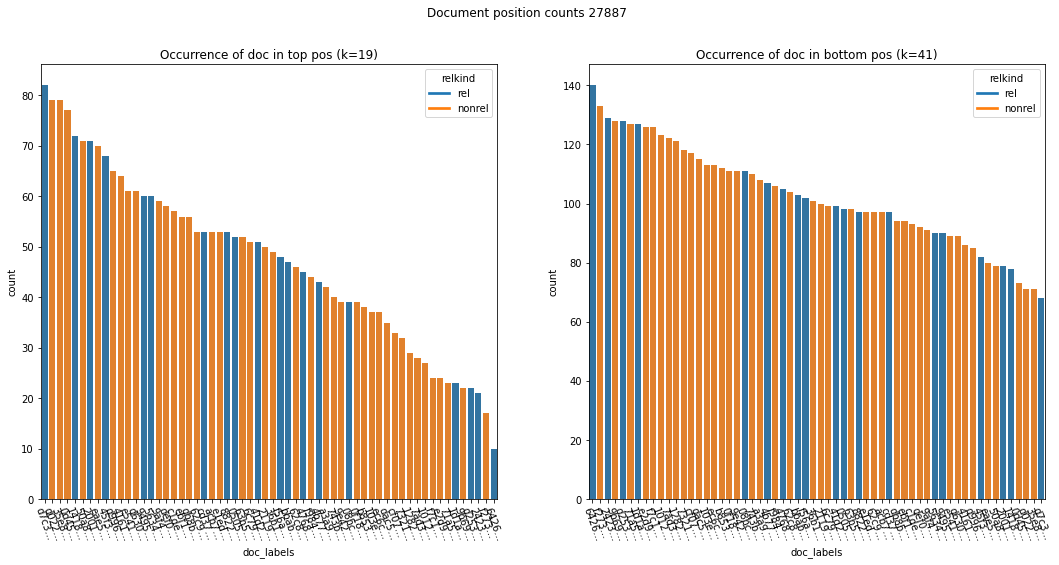

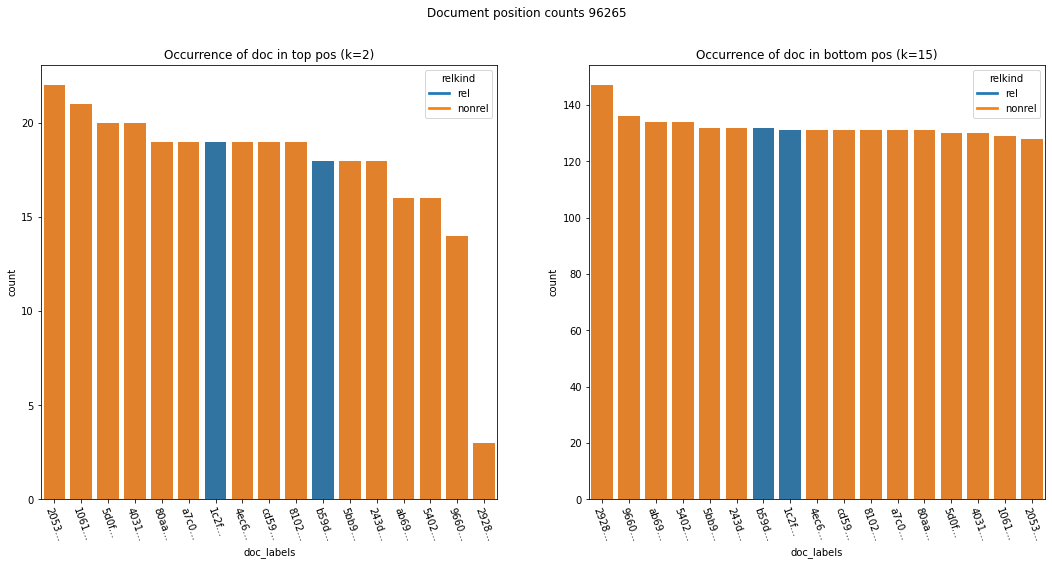

In [305]:
for q in edf.head(10).qid.to_list():
    plot_doc_pos_count_for_qid(q,rdf,reldf)

#### nonspikeys

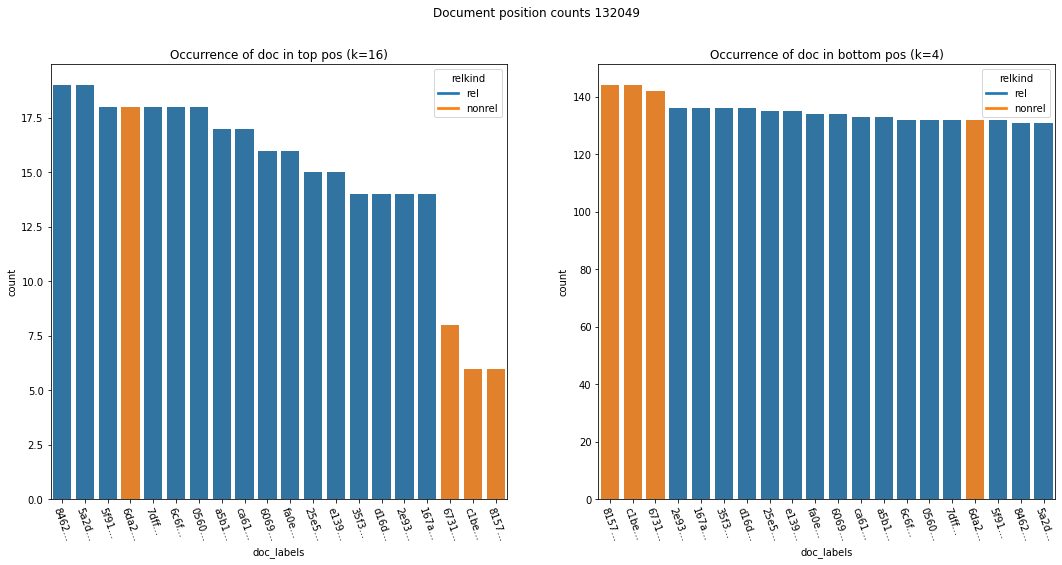

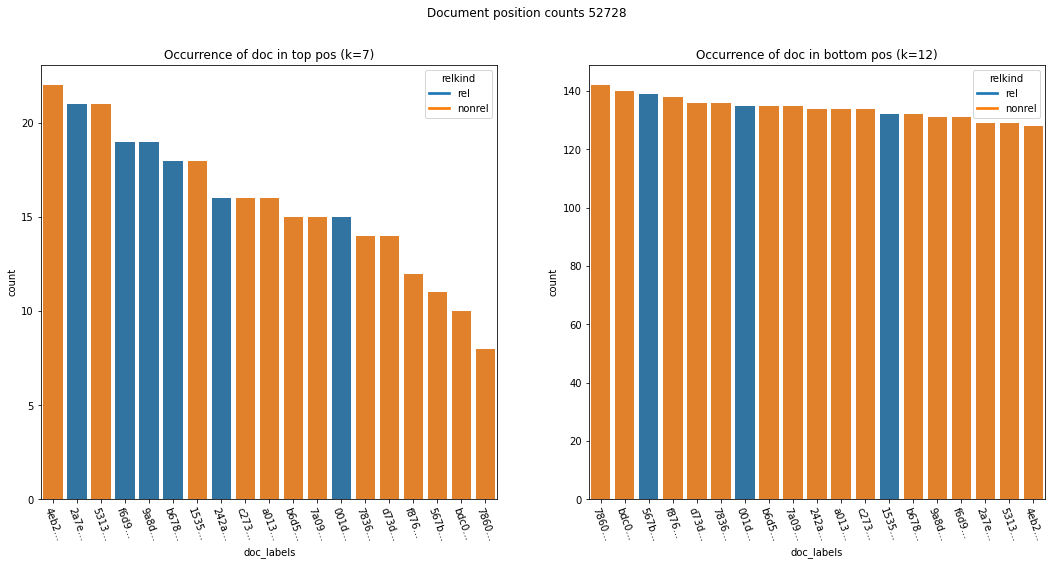

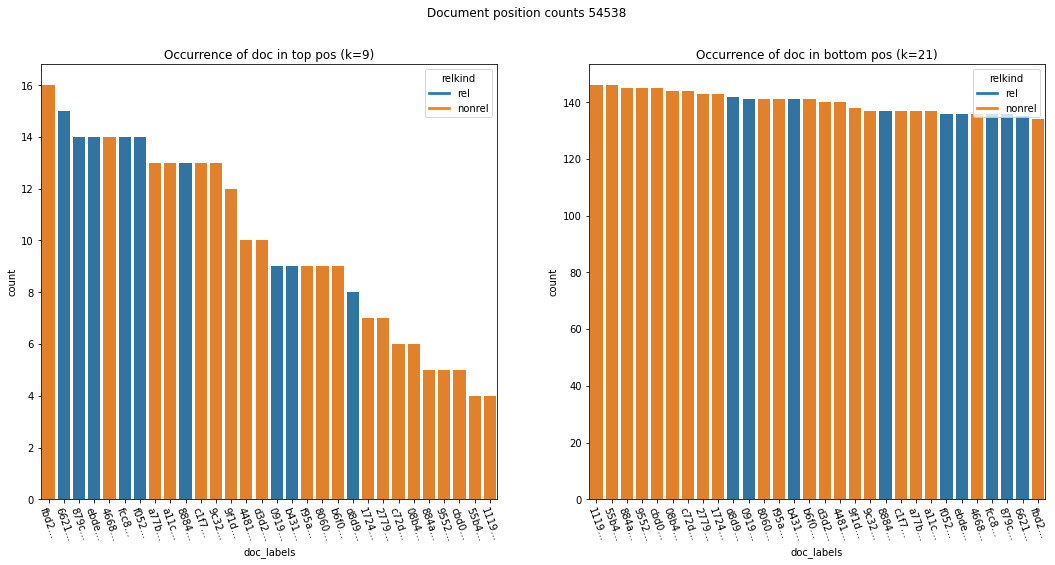

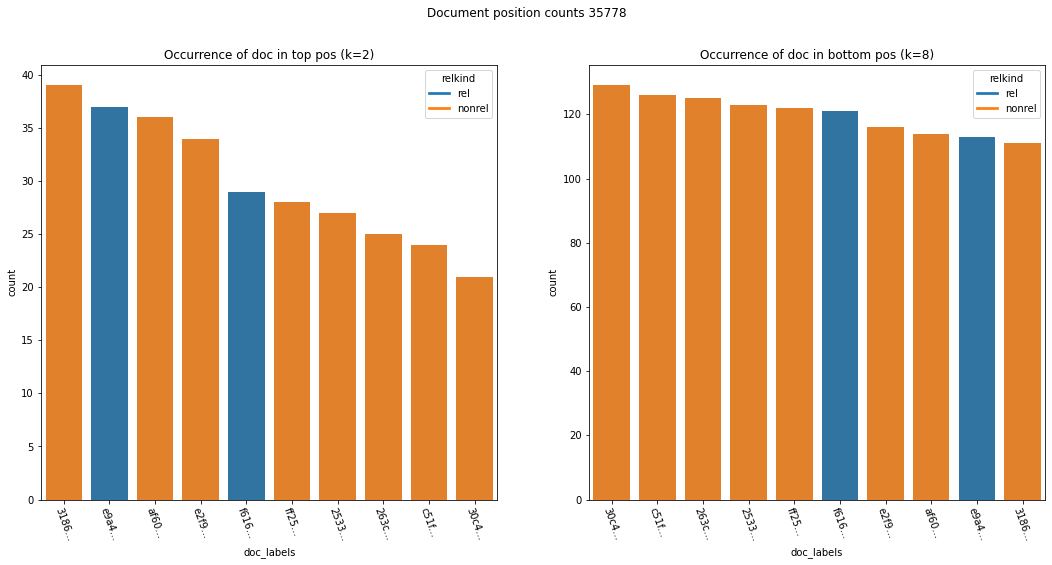

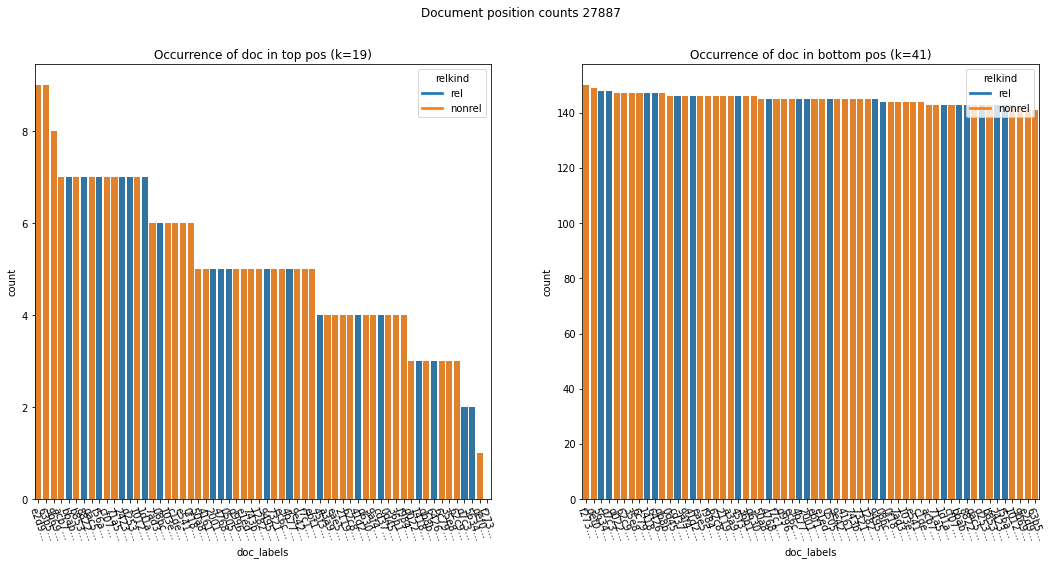

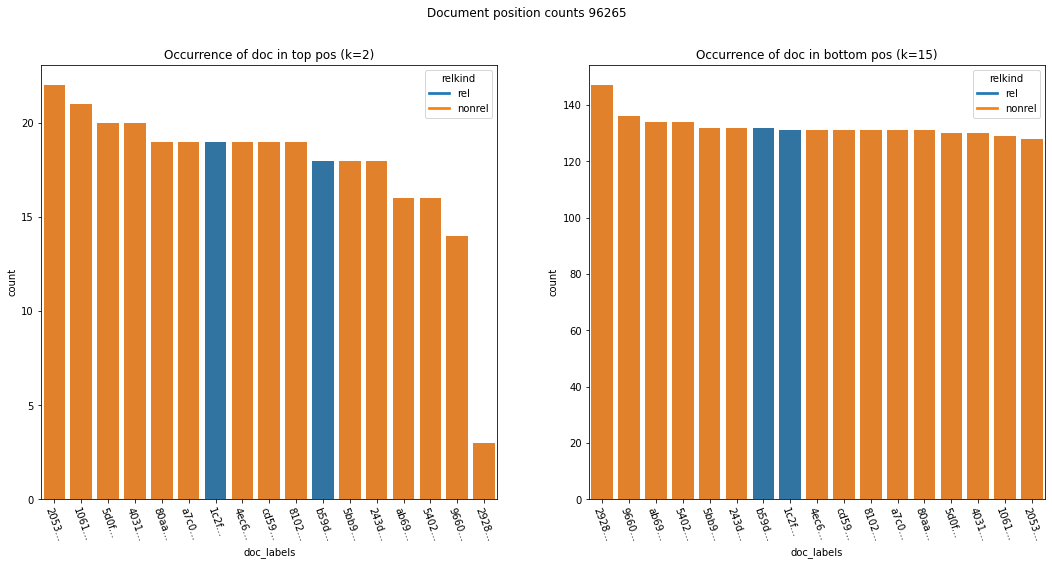

In [59]:
for q in edf.head(10).qid.to_list():
    if not q in [71096, 15395, 21984, 77011]:
        plot_doc_pos_count_for_qid(q,rdf,reldf)

### Inspect spiking documents
The top relevant documents for queries 71096, 15395, and 21984 all spike above the rest of the queries in top positions. The documents are 6afc97668839a439e6858691ada76c9ddf798c2a, 67cb7ec0f36f9396b85b18cad90c0d7eec1658ce, 406d1ef750ba4520b8c57f95596cd42852c0e3fa. We look at each of these document's authors and their predicted relevance scores.


In [ ]:
reldf[(reldf.qid == 71096) & (reldf.doc_id == '6afc97668839a439e6858691ada76c9ddf798c2a')]

#### Estimated relevances

In [ ]:
est_rel_meta.est_relevance.max()

In [ ]:
est_rel_meta.est_relevance.min()

In [109]:
est_rel_meta[(est_rel_meta.qid == 71096) & (est_rel_meta.doc_id == '6afc97668839a439e6858691ada76c9ddf798c2a')]


qid                                    doc_id  relevance  est_relevance
432  71096  6afc97668839a439e6858691ada76c9ddf798c2a          1       0.218468

In [ ]:
est_rel_meta[(est_rel_meta.qid == 15395) & (est_rel_meta.doc_id == '67cb7ec0f36f9396b85b18cad90c0d7eec1658ce')]


In [ ]:
est_rel_meta[(est_rel_meta.qid == 21984) & (est_rel_meta.doc_id == '406d1ef750ba4520b8c57f95596cd42852c0e3fa')]

#### Authors

The other factor influencing the h-scores is the author advantage. We know that some documents do not have authors. In our implementation of the algorithm, the advantage of documents without author is (re)set to zero at each iteration. Additionally, some documents are not in the index at all, and as such also do not have authors.


In [ ]:
es = Elasticsearch([{'timeout':300}])
inspect_ids = ["6afc97668839a439e6858691ada76c9ddf798c2a", "67cb7ec0f36f9396b85b18cad90c0d7eec1658ce", "406d1ef750ba4520b8c57f95596cd42852c0e3fa"]
res = es.search(index='semanticscholar2020og', body={'size':len(inspect_ids),'query':{'ids':{'values':inspect_ids}}})
ret_ids = [hit['_id'] for hit in res['hits']['hits']]
not_in_index = list(set(inspect_ids) - set(ret_ids))
no_author_in_idx = [hit['_id'] for hit in res['hits']['hits'] if not hit['_source']['author_ids']]
    
no_author = list(set(not_in_index + no_author_in_idx))
    

In [ ]:
res

In [ ]:
no_author

### Inspect nonspiking upper quantile documents

#### Estimated relevances

In [131]:
inspectrels = pd.merge(inspectdf.rename({'doc_rel':'relevance'},axis=1), est_rel_meta, on=['qid','doc_id','relevance'], how='left')
inspectrels.head()

count                                    doc_id relevance  pos     qid  \
0    19  8462f4b6590713db112d6fc665b43cfeb88bab41         1  top  132049   
1    19  5a2de88464b2307f1fd89f3d84c6d507a49cb47f         1  top  132049   
2    18  5f91afa4ba1591dfd9d35450ac07f41dca1ce4f6         1  top  132049   
3    18  7dff8a6d32efbaa16fb7510b9c3347985de71596         1  top  132049   
4    18  6c6fc8896569067cf30b0f2349933c7462809912         1  top  132049   

  topbot  est_relevance  
0    top       0.179613  
1    top       0.187206  
2    top       0.198229  
3    top       0.187206  
4    top       0.187206

In [132]:
inspectrels.est_relevance.mean()

0.20066046136824264

In [133]:
inspectrels.est_relevance.min()

0.15628969745416402

In [134]:
inspectrels.est_relevance.max()

0.25621193351684

In [111]:
for i, row in inspectdf.iterrows():

    estrel = est_rel_meta[(est_rel_meta.qid == row.qid) & (est_rel_meta.doc_id == row.doc_id)].est_relevance.to_list()[0]
    print(row.qid,'\t', row.doc_id, '\t', row.topbot,'\t', estrel)

132049 	 8462f4b6590713db112d6fc665b43cfeb88bab41 	 top 	 0.179613166813848
132049 	 5a2de88464b2307f1fd89f3d84c6d507a49cb47f 	 top 	 0.187206085519219
132049 	 5f91afa4ba1591dfd9d35450ac07f41dca1ce4f6 	 top 	 0.198229074384685
132049 	 7dff8a6d32efbaa16fb7510b9c3347985de71596 	 top 	 0.187206085519219
132049 	 6c6fc8896569067cf30b0f2349933c7462809912 	 top 	 0.187206085519219
132049 	 0560a08ef071d54a60f2efac0bf3a6505ae36910 	 top 	 0.179613166813848
52728 	 2a7e7fba70c6ad91e79b5d4fdd1f487551a808bb 	 top 	 0.233839881533441
52728 	 5313735b8f660d43c9ec0adbc9ed3c1e8d7da85c 	 top 	 0.17772202162056197
52728 	 f6d9f8a64f20c26d83b0b0cdc5c9131c1822858c 	 top 	 0.236088575157381
52728 	 9a8dbcfe52e24d631784ce9e129593c3fdd81023 	 top 	 0.201678155582861
52728 	 153550ab4a88092f8eac151479e36e053e9e37e9 	 top 	 0.173672595556288
54538 	 6621f6f8087226645cc00120a9b14da4354518ca 	 top 	 0.24891895317031898
54538 	 879c8af3f0aca90e17e4008b7c914438bbee3495 	 top 	 0.20163352601981896
54538 	 ebded

#### Authors

In [135]:
es = Elasticsearch([{'timeout':300}])
inspect_ids = inspectdf.doc_id.to_list()
res = es.search(index='semanticscholar2020og', body={'size':len(inspect_ids),'query':{'ids':{'values':inspect_ids}}})
ret_ids = [hit['_id'] for hit in res['hits']['hits']]
not_in_index = list(set(inspect_ids) - set(ret_ids))
no_author_in_idx = [hit['_id'] for hit in res['hits']['hits'] if not hit['_source']['author_ids']]
    
no_author = list(set(not_in_index + no_author_in_idx))
    

In [141]:
from collections import Counter

In [142]:
Counter(inspect_ids)

Counter({'8462f4b6590713db112d6fc665b43cfeb88bab41': 1,
         '5a2de88464b2307f1fd89f3d84c6d507a49cb47f': 1,
         '5f91afa4ba1591dfd9d35450ac07f41dca1ce4f6': 1,
         '7dff8a6d32efbaa16fb7510b9c3347985de71596': 1,
         '6c6fc8896569067cf30b0f2349933c7462809912': 1,
         '0560a08ef071d54a60f2efac0bf3a6505ae36910': 1,
         '00525dd393d8a3a72e584eda8328ace8d43f3c0e': 1,
         '71aa55b1a189ec609ee865df4453ebb538c3ee0e': 1,
         'a4989444cddd8619625492c4ceb037bb496ad253': 1,
         '8bc8fa66c5884414993465b4d361c99ce439ab57': 1,
         '2a7e7fba70c6ad91e79b5d4fdd1f487551a808bb': 1,
         '5313735b8f660d43c9ec0adbc9ed3c1e8d7da85c': 1,
         'f6d9f8a64f20c26d83b0b0cdc5c9131c1822858c': 1,
         '9a8dbcfe52e24d631784ce9e129593c3fdd81023': 1,
         '153550ab4a88092f8eac151479e36e053e9e37e9': 1,
         '6621f6f8087226645cc00120a9b14da4354518ca': 1,
         '879c8af3f0aca90e17e4008b7c914438bbee3495': 1,
         'ebded89df9fa113da24ef71570430f64a143a7

In [146]:
hits = res['hits']['hits']
doc_to_author_mapping = {}
for hit in hits:
    doc_to_author_mapping[hit['_id']] = hit['_source']['author_ids']
# doc_to_author_mapping = {hit['_id']: hit['_source']['author_ids'] for hit in hits}
doc_to_author_mapping
author_doc_mapping = {}
for docid, authorlist in doc_to_author_mapping.items():
    for author in authorlist:
        if author not in author_doc_mapping:
            author_doc_mapping[author] = []
        author_doc_mapping[author] = author_doc_mapping[author] + [docid]
author_doc_mapping

{'144936111': ['ccaea944996c0935897cd6eb248d5f01367cd3c4'],
 '2189475': ['76e199fcf5537c4e8ef774d792afd2978aa11ebb'],
 '47654875': ['153550ab4a88092f8eac151479e36e053e9e37e9'],
 '77691738': ['153550ab4a88092f8eac151479e36e053e9e37e9'],
 '7863421': ['153550ab4a88092f8eac151479e36e053e9e37e9'],
 '1402287544': ['6621f6f8087226645cc00120a9b14da4354518ca'],
 '144141469': ['6621f6f8087226645cc00120a9b14da4354518ca'],
 '145182399': ['6621f6f8087226645cc00120a9b14da4354518ca'],
 '90787199': ['6621f6f8087226645cc00120a9b14da4354518ca'],
 '46759753': ['8bc8fa66c5884414993465b4d361c99ce439ab57'],
 '6237271': ['8bc8fa66c5884414993465b4d361c99ce439ab57'],
 '4537670': ['8bc8fa66c5884414993465b4d361c99ce439ab57'],
 '143630117': ['4256284e490148a718772a28a917c69bb3022199'],
 '145187595': ['4256284e490148a718772a28a917c69bb3022199'],
 '3707199': ['5a2de88464b2307f1fd89f3d84c6d507a49cb47f'],
 '3824661': ['5a2de88464b2307f1fd89f3d84c6d507a49cb47f'],
 '6032281': ['5a2de88464b2307f1fd89f3d84c6d507a49cb47f'

In [136]:
res

{'took': 19633,
 'timed_out': False,
 '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0},
 'hits': {'total': {'value': 41, 'relation': 'eq'},
  'max_score': 1.0,
  'hits': [{'_index': 'semanticscholar2020og',
    '_type': 'document',
    '_id': 'ccaea944996c0935897cd6eb248d5f01367cd3c4',
    '_score': 1.0,
    '_source': {'title': 'Data Analysis for the COVID-19 early dynamics in Northern Italy. The effect of first restrictive measures',
     'paperAbstract': 'In a recent report we have collected some data about the COVID-19 epidemics in Northern Italy; in this follow-up we analyze how these changed after the mild restrictive measures taken by the Government two weeks ago and the large campaign of public awareness developed in the meanwhile.',
     'entities': [],
     'author_names': ['Giuseppe Gaeta'],
     'author_ids': ['144936111'],
     'inCitations': 7,
     'outCitations': 1,
     'year': 2020,
     'venue': '',
     'journalName': 'arXiv: Populations and Evolu

In [137]:
no_author

[]

#### Difference predicted relevance score and actual relevance score

In [152]:
inspectrels['reldiff'] = inspectrels.apply(lambda row: row.relevance - row.est_relevance, axis = 1)
print(inspectrels[inspectrels.topbot == 'top'].reldiff.mean())
print(inspectrels[inspectrels.topbot == 'bot'].reldiff.mean())

0.8000047071426875
0.7969005874250136


## 2. How often were top positions occupied by non-relevant documents? 
Can these documents be categorized and distinguished from other documents?

### Computation
1. What percentage of the top positions was occupied by relevant documents?  
    a. Which relevant documents were most often in a top position? 
        - More specifically: which relevant documents were more often in a top position than any other document for the ranking?    
            - Which relevant documents were among the top 75% of the documents in the top positions, frequency-wise.
2. What was their predicted relevance score?  
3. What was their author?  
    - Did their author write more of the documents in the ranking?

#### Percentage of non-relevant documents

In [153]:
for q in edf.head(10).qid.to_list():
    subrdf = extract_results_based_on_qid(q, rdf)
    subreldf = extract_relevances_based_on_qid(q, reldf)
    
    num_rel_docs, num_nonrel_docs = count_relgrades(subreldf)
    
    rel_nonrel_counts = count_rel_nonrel_per_rank(subrdf, subreldf)
    rel_nonrel_df = rel_nonrel_per_rank_counts_to_sns_df(rel_nonrel_counts)
    
    # doc_per_rank_counts = count_doc_occurrence_per_rank(subrdf)
    # rank_occurrence_df = doc_occurrence_per_rank_to_sns_df(doc_per_rank_counts, subreldf)
    
    top_with_rel_frac = round(rel_nonrel_df[(rel_nonrel_df['rank'] <= num_rel_docs) & (rel_nonrel_df['relkind'] == 'nr')]['count'].sum() / (150 * num_rel_docs) * 100,2)
    print(q, "\t", top_with_rel_frac)

132049 	 21.08
71096 	 66.83
15395 	 63.67
21984 	 65.6
52728 	 66.38
54538 	 76.07
35778 	 78.0
77011 	 82.76
27887 	 67.72
96265 	 87.67


In [154]:
for q in edf.tail(10).iloc[::-1].qid.to_list():
    subrdf = extract_results_based_on_qid(q, rdf)
    subreldf = extract_relevances_based_on_qid(q, reldf)
    
    num_rel_docs, num_nonrel_docs = count_relgrades(subreldf)
    
    rel_nonrel_counts = count_rel_nonrel_per_rank(subrdf, subreldf)
    rel_nonrel_df = rel_nonrel_per_rank_counts_to_sns_df(rel_nonrel_counts)
    
    # doc_per_rank_counts = count_doc_occurrence_per_rank(subrdf)
    # rank_occurrence_df = doc_occurrence_per_rank_to_sns_df(doc_per_rank_counts, subreldf)
    
    top_with_rel_frac = round(rel_nonrel_df[(rel_nonrel_df['rank'] <= num_rel_docs) & (rel_nonrel_df['relkind'] == 'nr')]['count'].sum() / (150 * num_rel_docs) * 100,2)
    print(q, "\t", top_with_rel_frac)

33337 	 92.67
47984 	 90.0
111469 	 91.33
31412 	 92.0
11856 	 91.0
30631 	 88.67
76875 	 81.0
24848 	 80.33
5762 	 94.67
82759 	 95.33


#### Most frequent non-relevant documents

In [155]:
toptoplist = []
print("\t".join(["qid","doc_id","pos","count","doc_rel"]))
for q in edf.head(10).qid.to_list():
    doc_pos_count = document_pos_count_df_for_qid(q,rdf,reldf)
    doc_pos_count = doc_pos_count[(doc_pos_count.pos == 'top')  & (doc_pos_count.doc_rel == 0)]
    doc_pos_count["qid"] = q
    maxcount = doc_pos_count["count"].max()
    toptoplist = toptoplist + doc_pos_count[doc_pos_count["count"] == maxcount].doc_id.to_list()
    print(doc_pos_count[["qid","doc_id","pos","count","doc_rel"]][doc_pos_count["count"] == maxcount].to_string(index = False, header=False))
    print()
toptoplist

qid	doc_id	pos	count	doc_rel
 132049  6da29e3f7e9ab2cbedccb71201ae62ed52f949a4  top  18  0

 71096  cfa64338705a4903b3d38ae98901dc21183bf86c  top  20  0

 15395  4e6c4288338eba5644ead3847e11cd50bdee973d  top  42  0

 21984  f393079373573fb766f5ddbf960b8d231cc67b1f  top  17  0

 52728  4eb2842d4e46c643cd1bec7e7de05dd93ff0a23e  top  22  0

 54538  fbd2efcad65f138fd78c800ff09bf9eace51b961  top  16  0

 35778  318686213deb625007388f23154c9670b886789c  top  39  0

 77011  0da7a3f0c7d130412c61687521f60f3d06d41bcd  top  75  0

 27887  e2d9139e258292c3d2e9c50ebb5a92f7ce65a1ec  top  9  0
 27887  63b58f3f00dcd7a8d53da6d531777524ec440682  top  9  0

 96265  2053d9e5eed846080dbd531b94daf0628b2125d3  top  22  0



['6da29e3f7e9ab2cbedccb71201ae62ed52f949a4',
 'cfa64338705a4903b3d38ae98901dc21183bf86c',
 '4e6c4288338eba5644ead3847e11cd50bdee973d',
 'f393079373573fb766f5ddbf960b8d231cc67b1f',
 '4eb2842d4e46c643cd1bec7e7de05dd93ff0a23e',
 'fbd2efcad65f138fd78c800ff09bf9eace51b961',
 '318686213deb625007388f23154c9670b886789c',
 '0da7a3f0c7d130412c61687521f60f3d06d41bcd',
 'e2d9139e258292c3d2e9c50ebb5a92f7ce65a1ec',
 '63b58f3f00dcd7a8d53da6d531777524ec440682',
 '2053d9e5eed846080dbd531b94daf0628b2125d3']

In [157]:
tailtoplist = []
print("\t".join(["qid","doc_id","pos","count","doc_rel"]))
for q in edf.tail(10).iloc[::-1].qid.to_list():
    doc_pos_count = document_pos_count_df_for_qid(q,rdf,reldf)
    doc_pos_count = doc_pos_count[(doc_pos_count.pos == 'top') & (doc_pos_count.doc_rel == 0)]
    doc_pos_count["qid"] = q
    maxcount = doc_pos_count["count"].max()
    tailtoplist = tailtoplist + doc_pos_count[doc_pos_count["count"] == maxcount].doc_id.to_list()
    print(doc_pos_count[["qid","doc_id","pos","count","doc_rel"]][doc_pos_count["count"] == maxcount].to_string(index = False, header=False))
    print()
tailtoplist

qid	doc_id	pos	count	doc_rel
 33337  57ee023985eaea6055b84bef61d8de9da5f6ca9a  top  13  0

 47984  0baed861c47a5954128212057b0f3f2cc1898b9d  top  21  0
 47984  e3670b0984e4690226c5dbc5ae55f9ce7d3782ed  top  21  0
 47984  0fb2374bf367ce7a243d9db00a57574ef2cc6a3e  top  21  0

 111469  e60af557a1bbfd9b2adee8a3c090d27faab86632  top  106  0

 31412  394149ca78b50fb0811a49af46eb95c7ff7241e9  top  85  0

 11856  9c26600cfc83d6926a81863a925423244af36c51  top  84  0

 30631  0e43caeb9d476264d307e8da0ad71ecc4d804ced  top  114  0
 30631  0e43caeb9d476264d307e8da0ad71ecc4d804ced  top  114  0
 30631  0e43caeb9d476264d307e8da0ad71ecc4d804ced  top  114  0
 30631  0e43caeb9d476264d307e8da0ad71ecc4d804ced  top  114  0

 76875  ffa6785fac6cafc60b26be31a8235ba573b4aca3  top  34  0

 24848  38ad845398de1f044a5e1243506c70f04063827c  top  37  0

 5762  c7e087f52b30aa5e603cfc881ea30fbb1ae27bc5  top  16  0

 82759  4ffc7321bc94c9f9391cff47c32a506c3a2d7aa0  top  86  0



['57ee023985eaea6055b84bef61d8de9da5f6ca9a',
 '0baed861c47a5954128212057b0f3f2cc1898b9d',
 'e3670b0984e4690226c5dbc5ae55f9ce7d3782ed',
 '0fb2374bf367ce7a243d9db00a57574ef2cc6a3e',
 'e60af557a1bbfd9b2adee8a3c090d27faab86632',
 '394149ca78b50fb0811a49af46eb95c7ff7241e9',
 '9c26600cfc83d6926a81863a925423244af36c51',
 '0e43caeb9d476264d307e8da0ad71ecc4d804ced',
 '0e43caeb9d476264d307e8da0ad71ecc4d804ced',
 '0e43caeb9d476264d307e8da0ad71ecc4d804ced',
 '0e43caeb9d476264d307e8da0ad71ecc4d804ced',
 'ffa6785fac6cafc60b26be31a8235ba573b4aca3',
 '38ad845398de1f044a5e1243506c70f04063827c',
 'c7e087f52b30aa5e603cfc881ea30fbb1ae27bc5',
 '4ffc7321bc94c9f9391cff47c32a506c3a2d7aa0']

### Visualization

For each rank, we show how often it is occupied by a relevant document. We show this for the top and bottom 10 queries so we can determine both what documents are placed in top positions on easy queries and which on difficult queries.

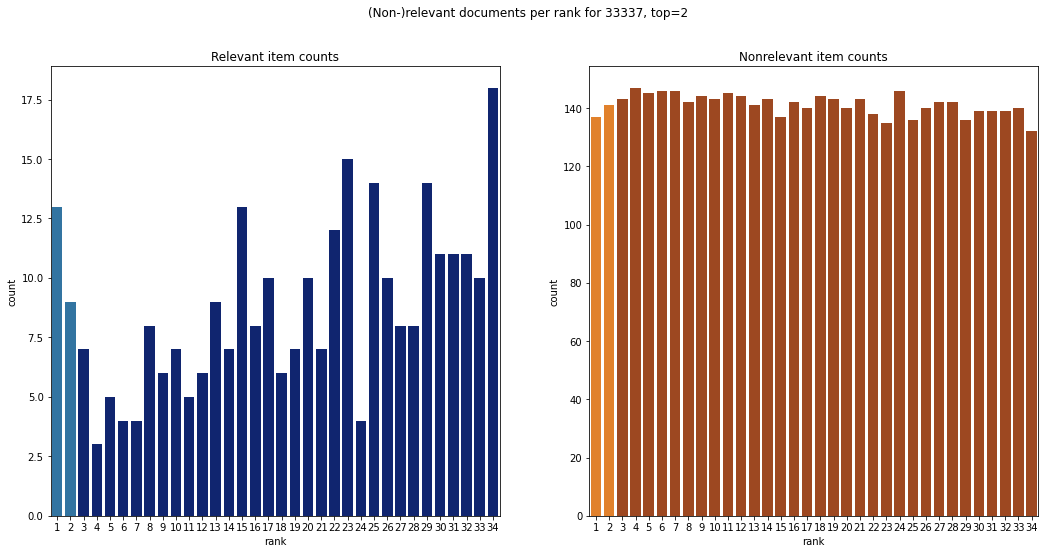

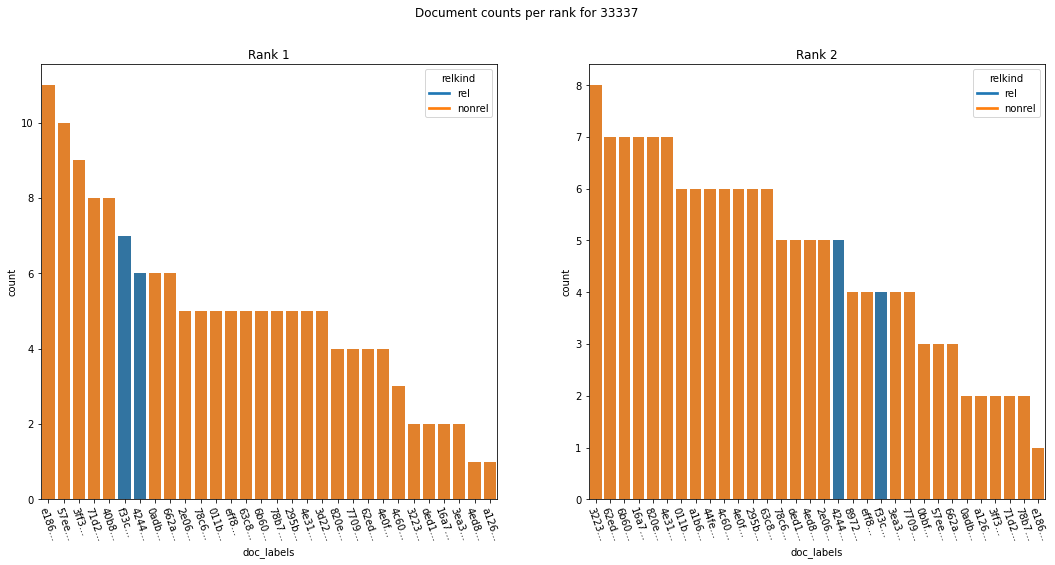

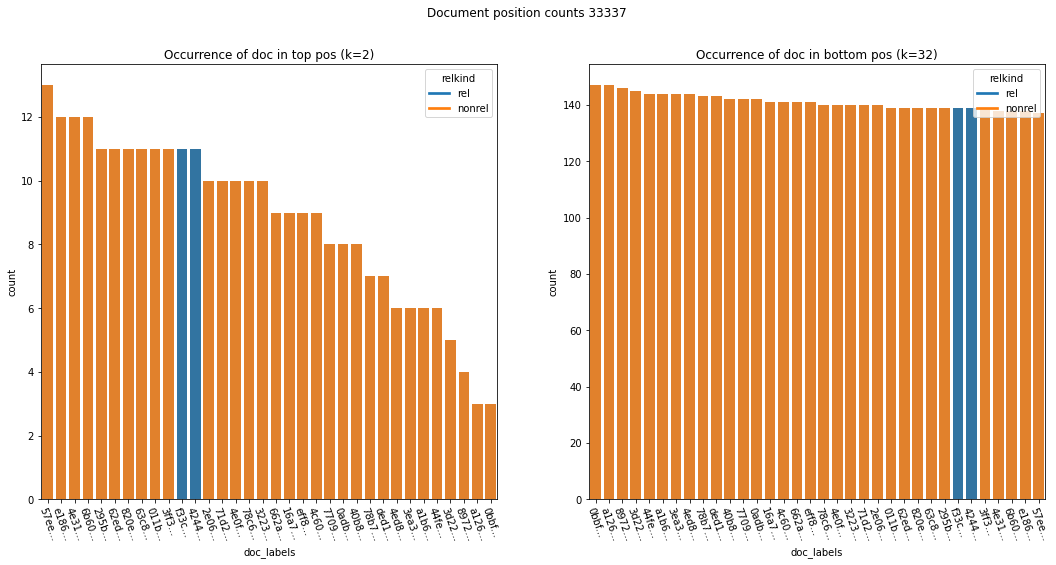

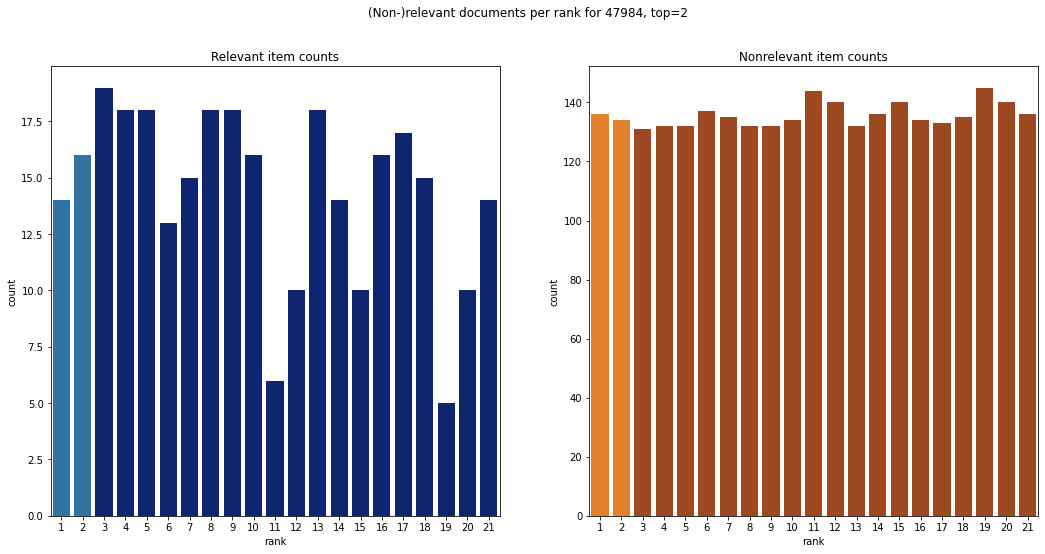

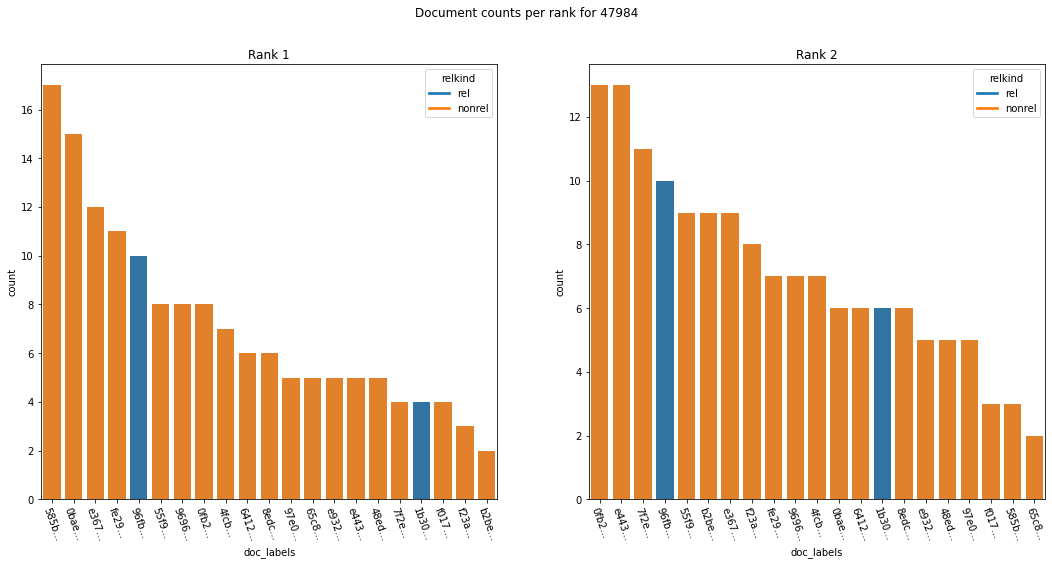

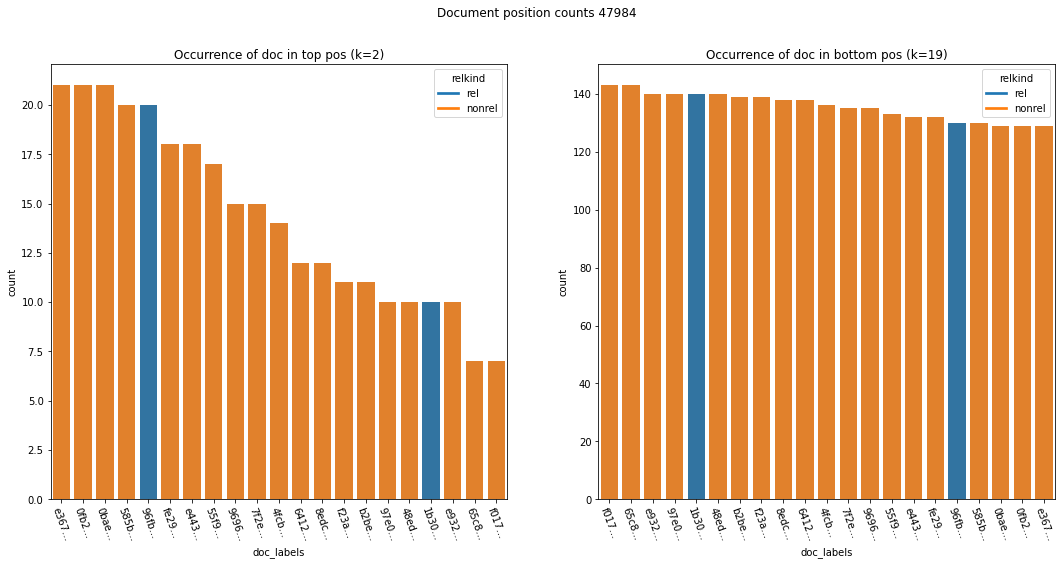

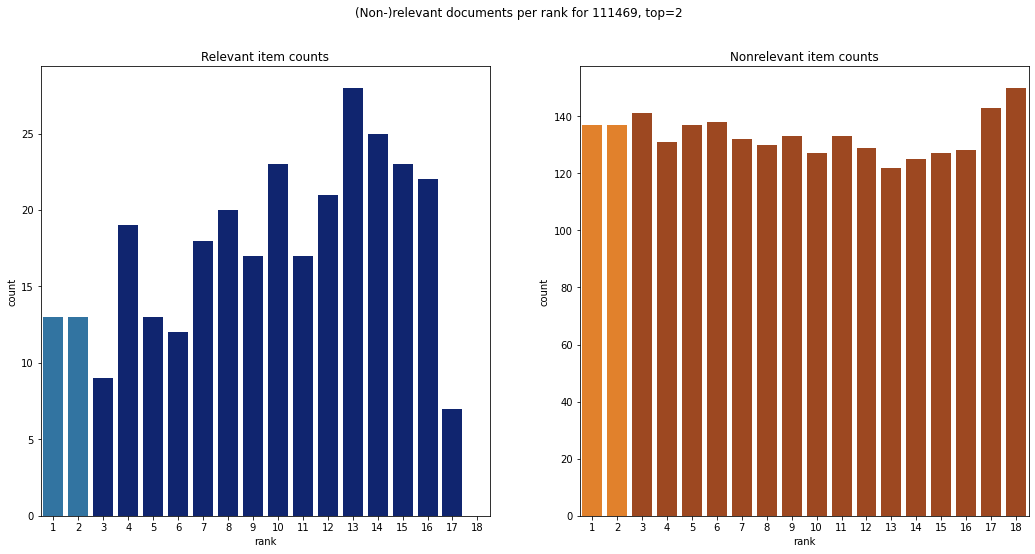

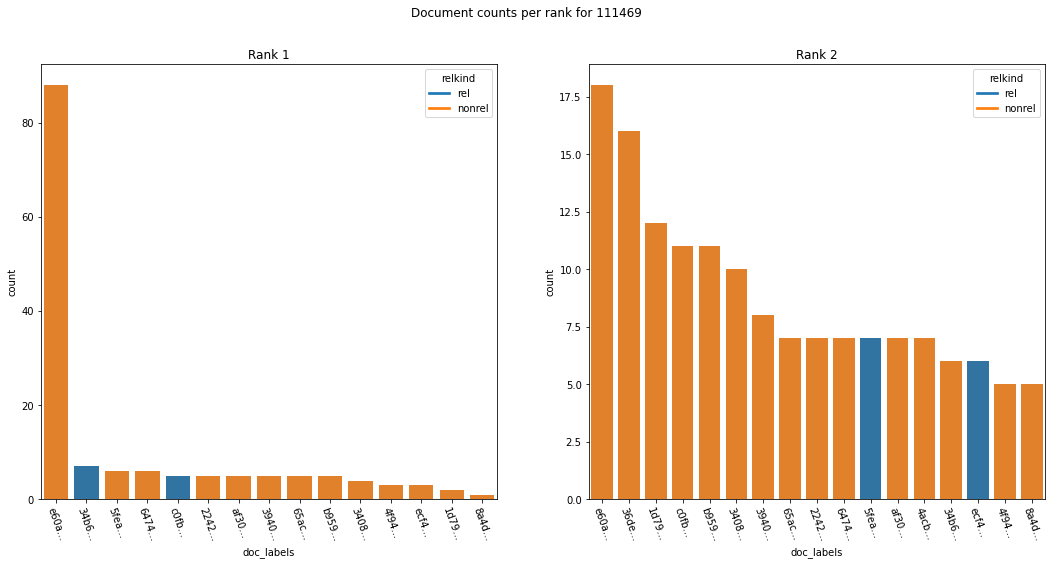

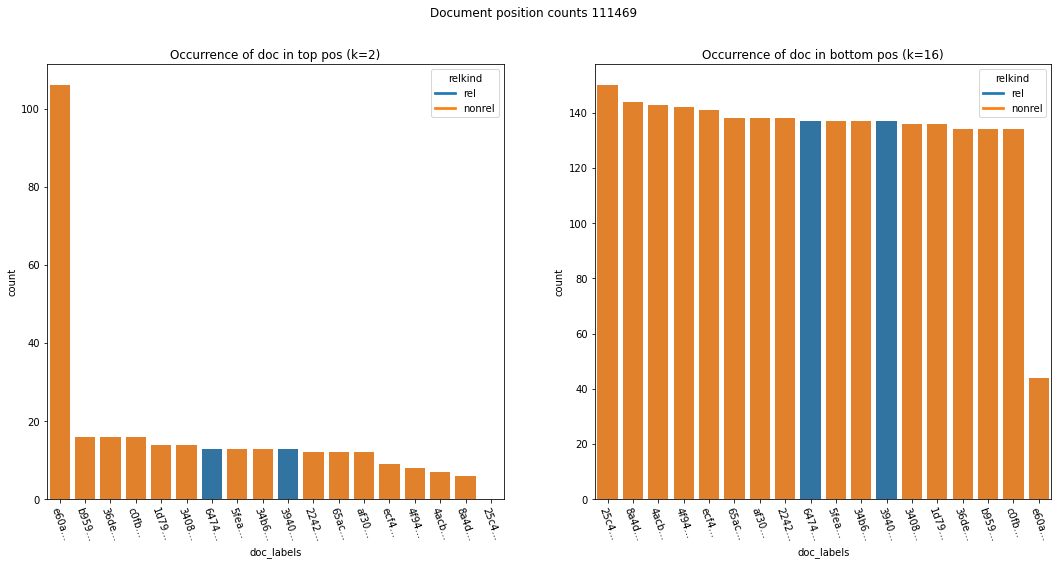

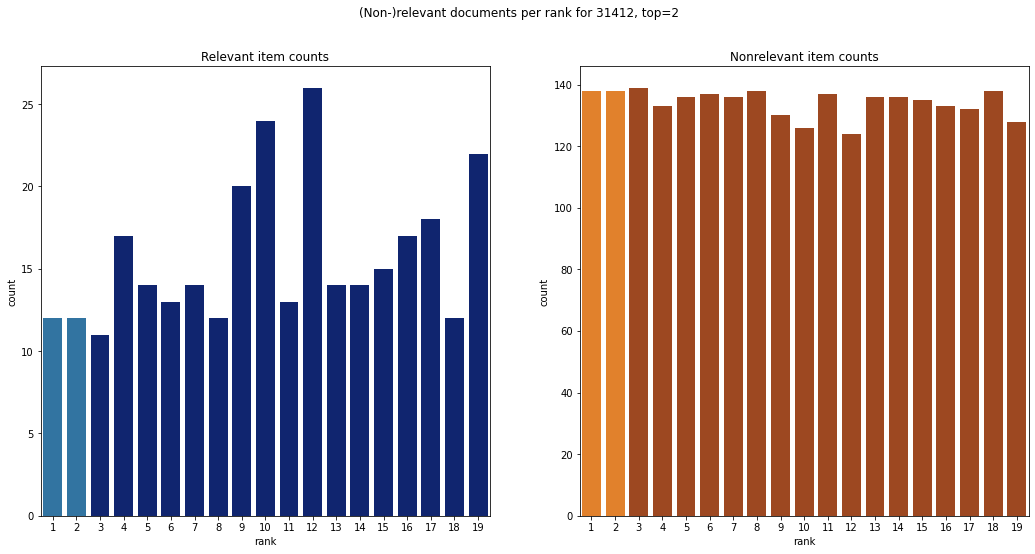

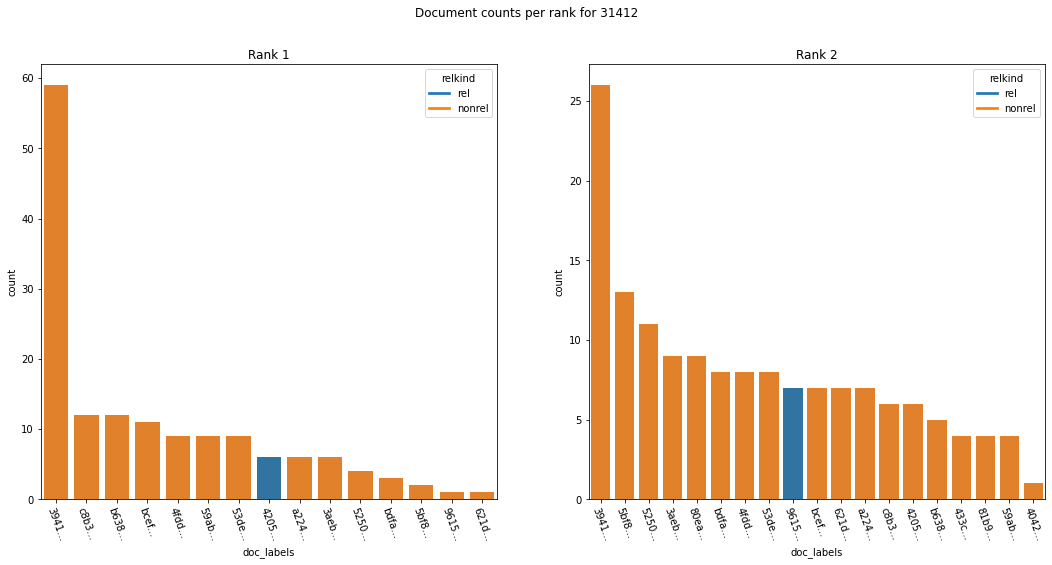

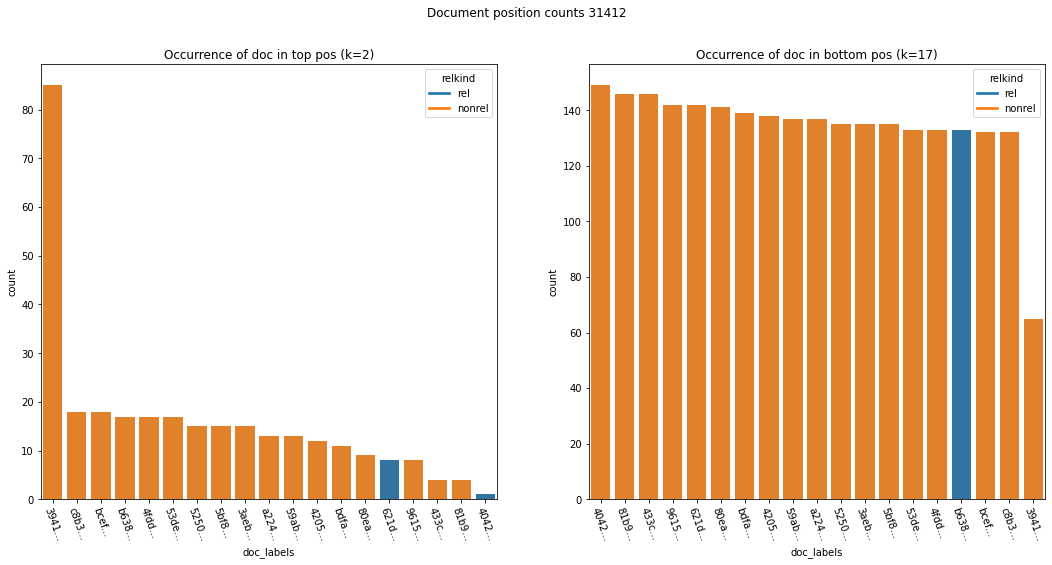

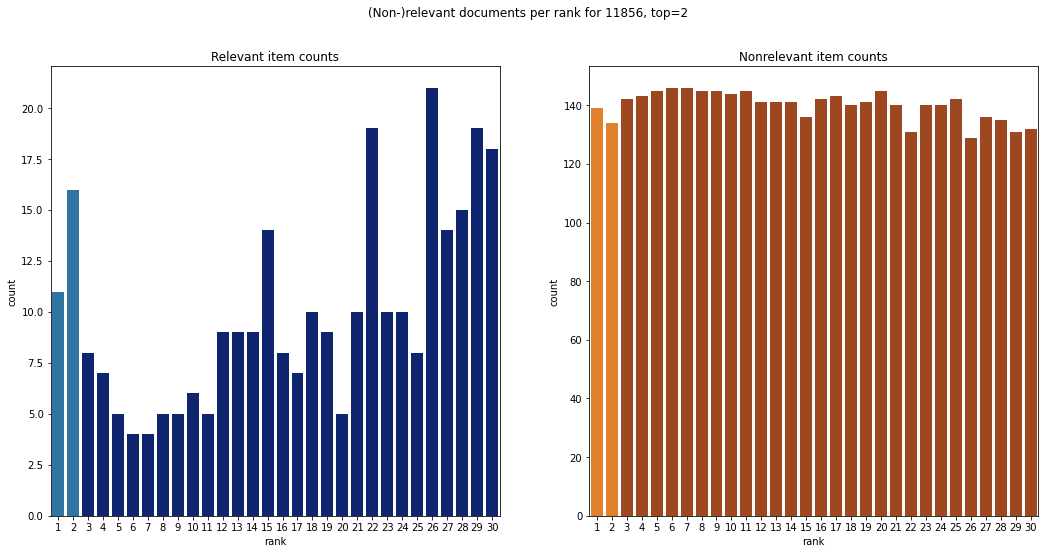

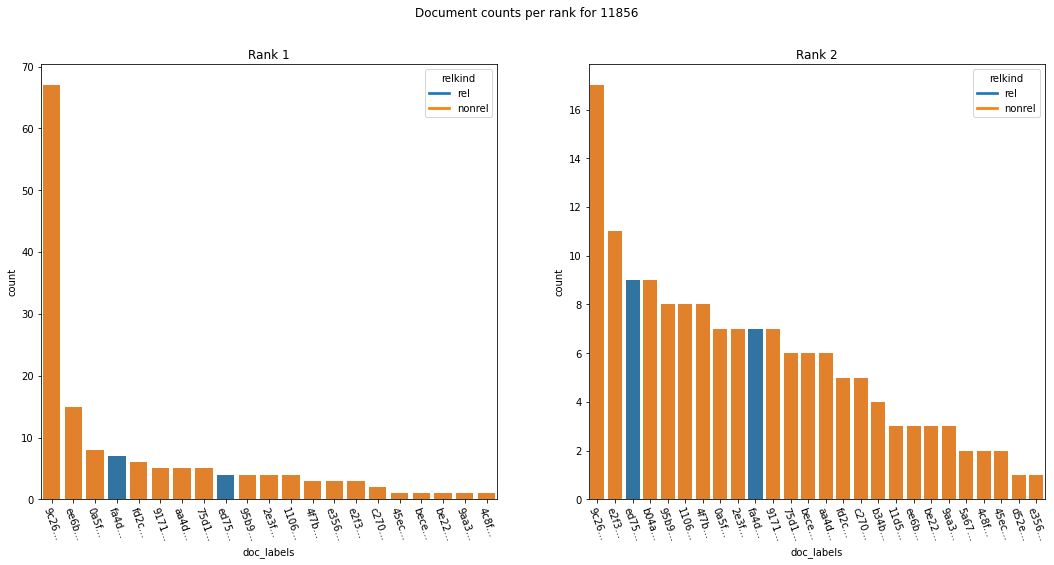

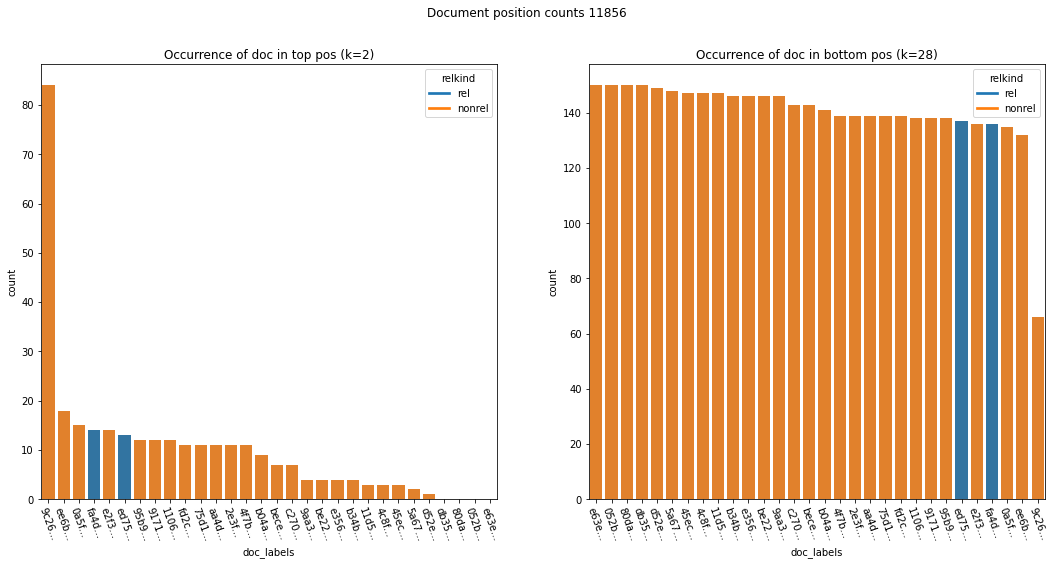

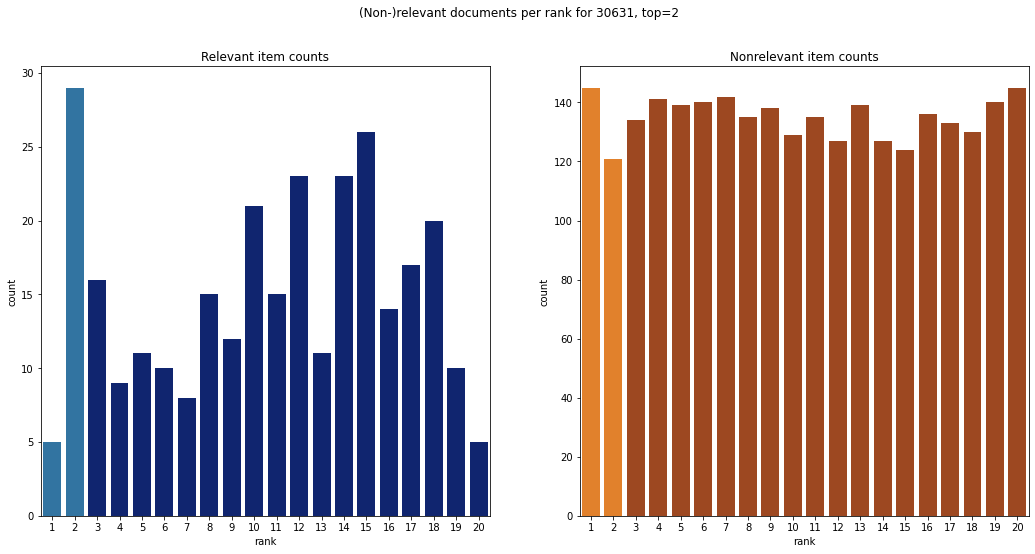

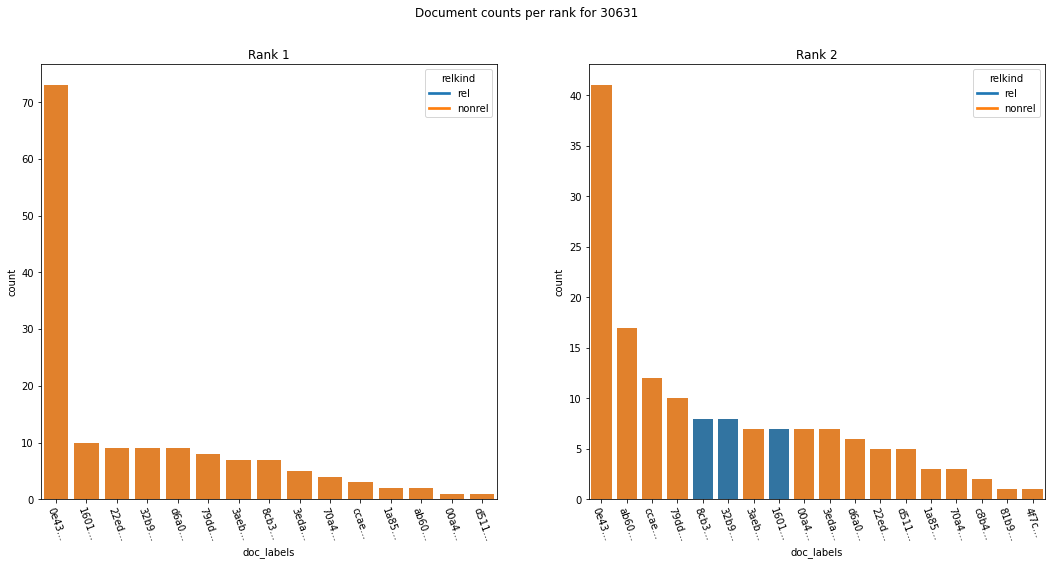

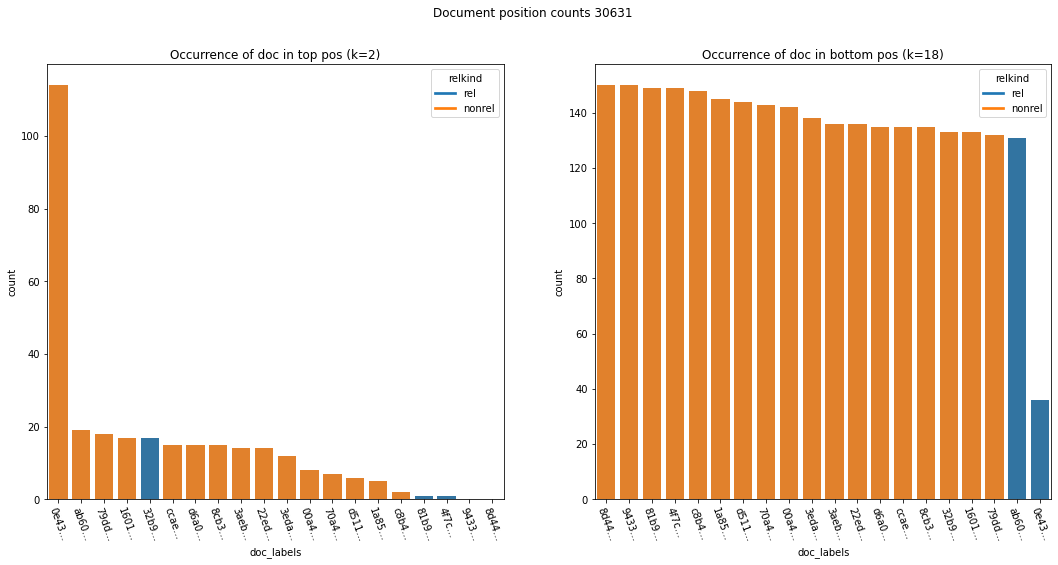

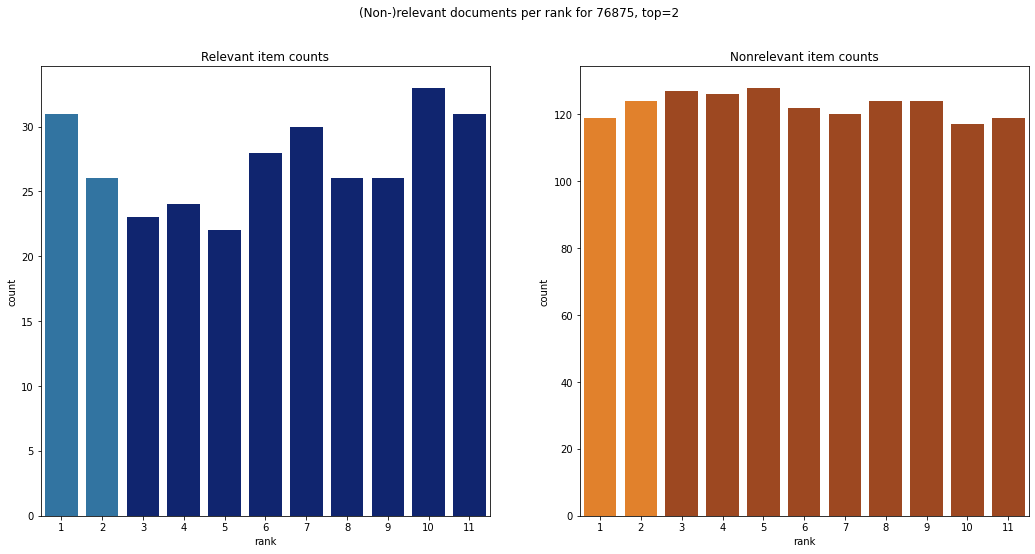

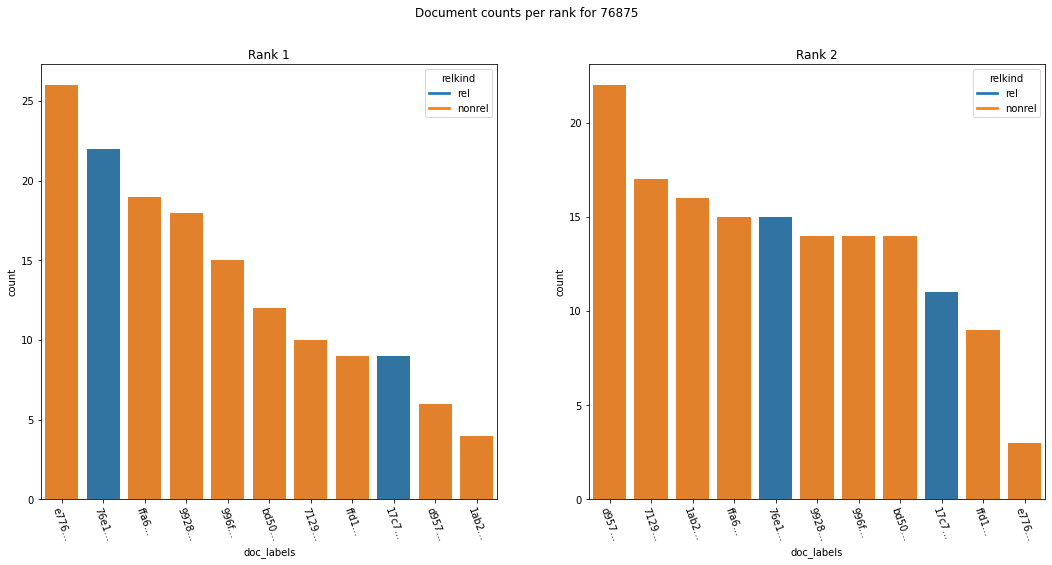

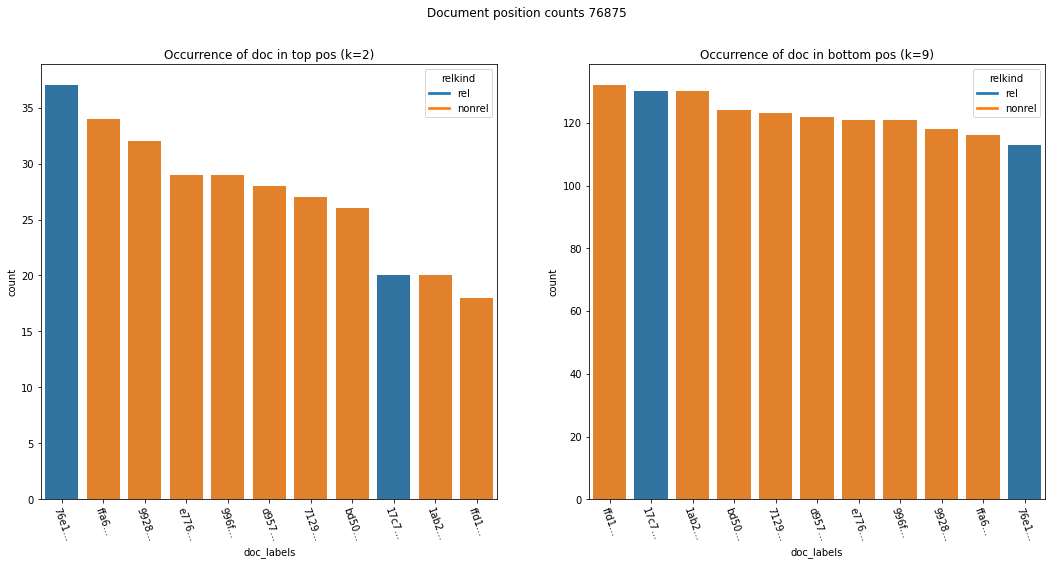

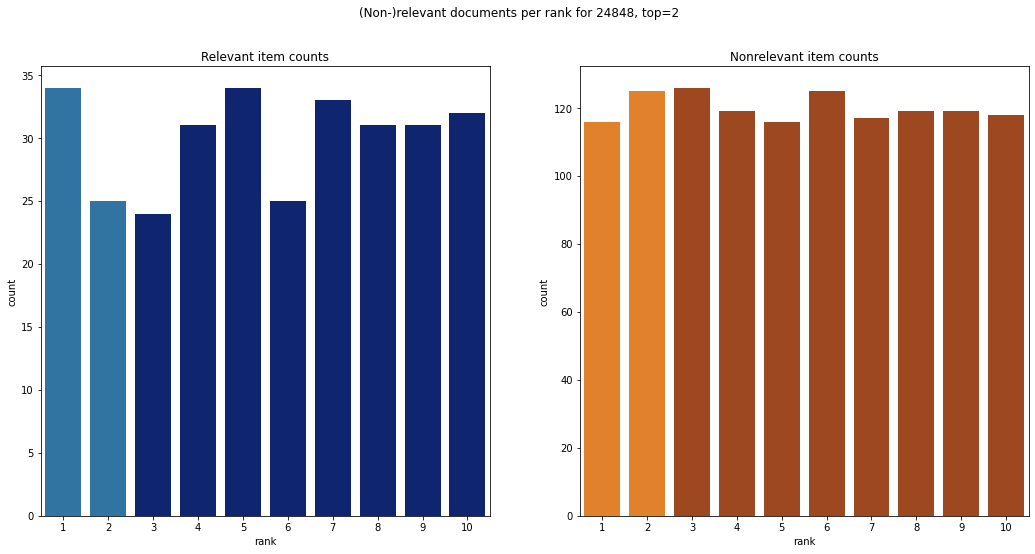

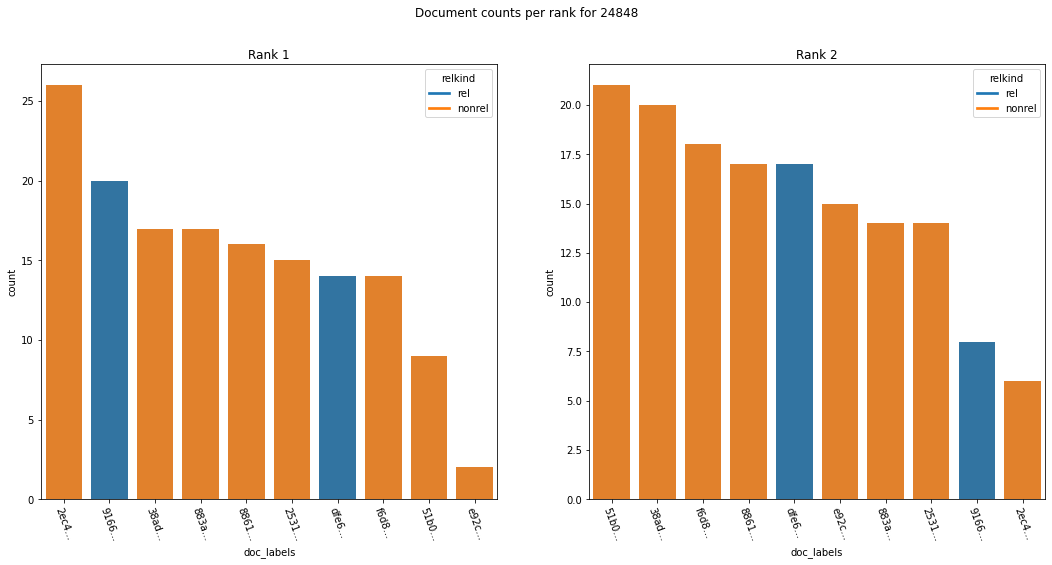

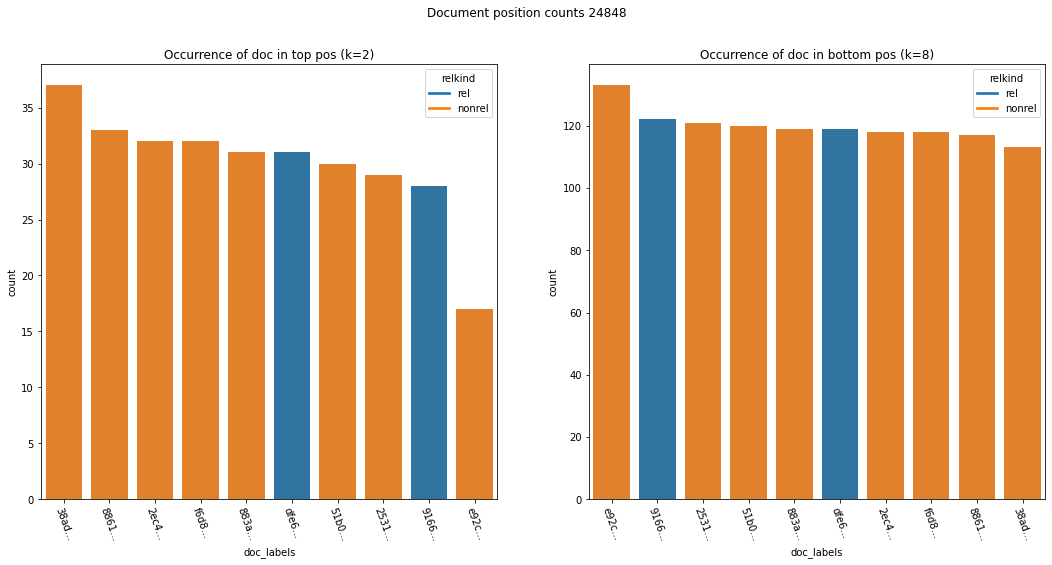

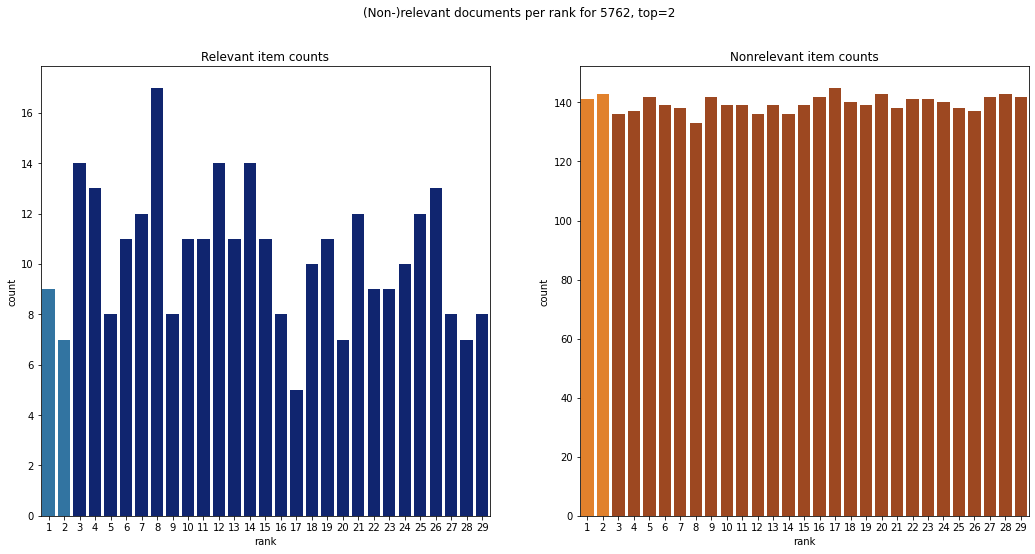

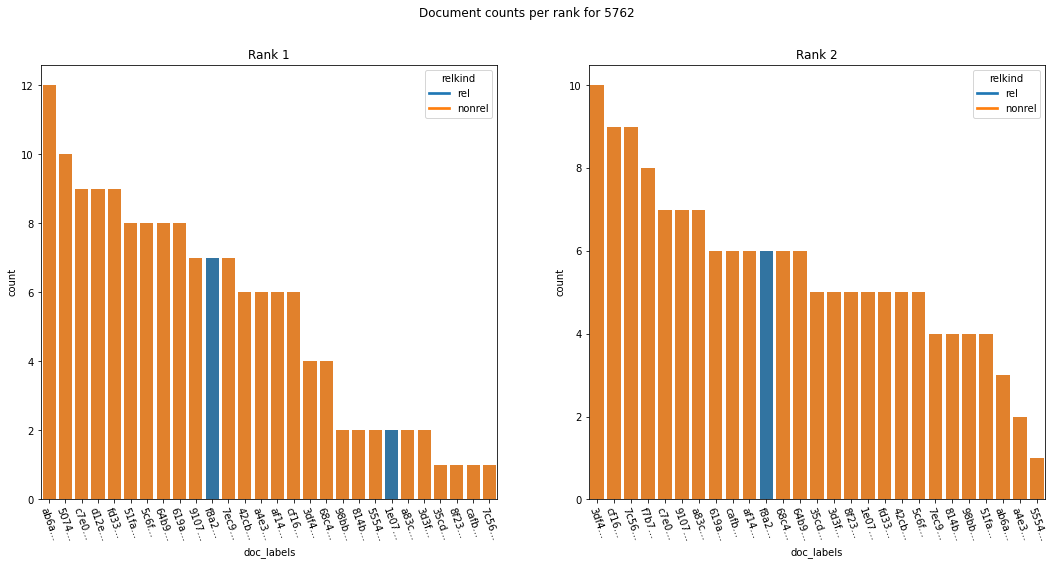

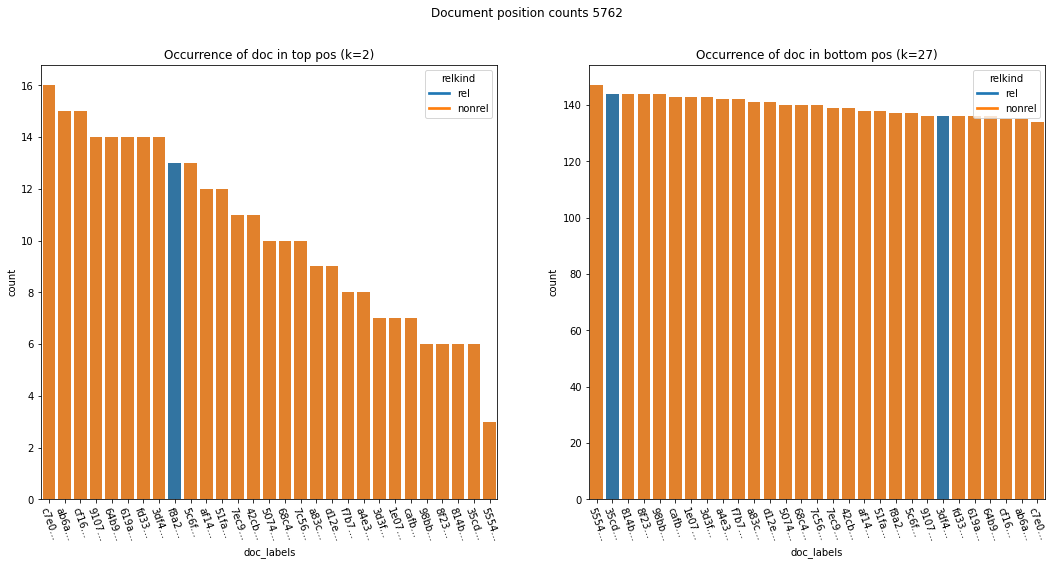

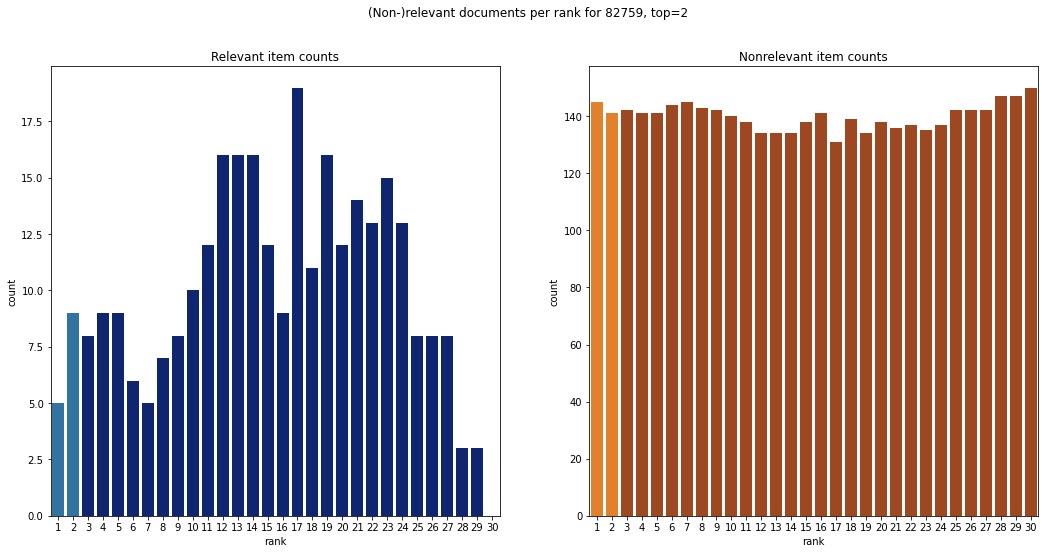

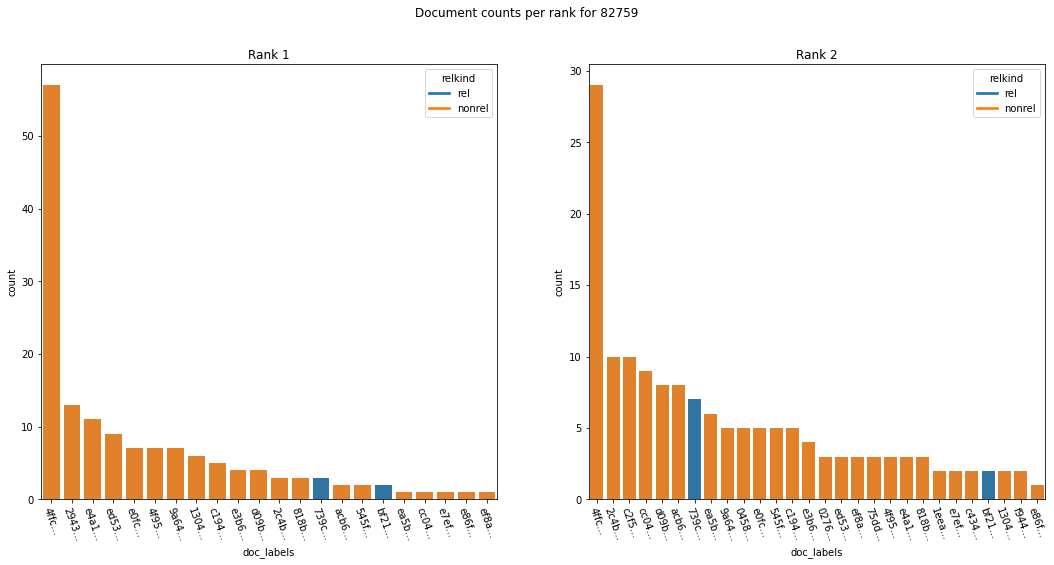

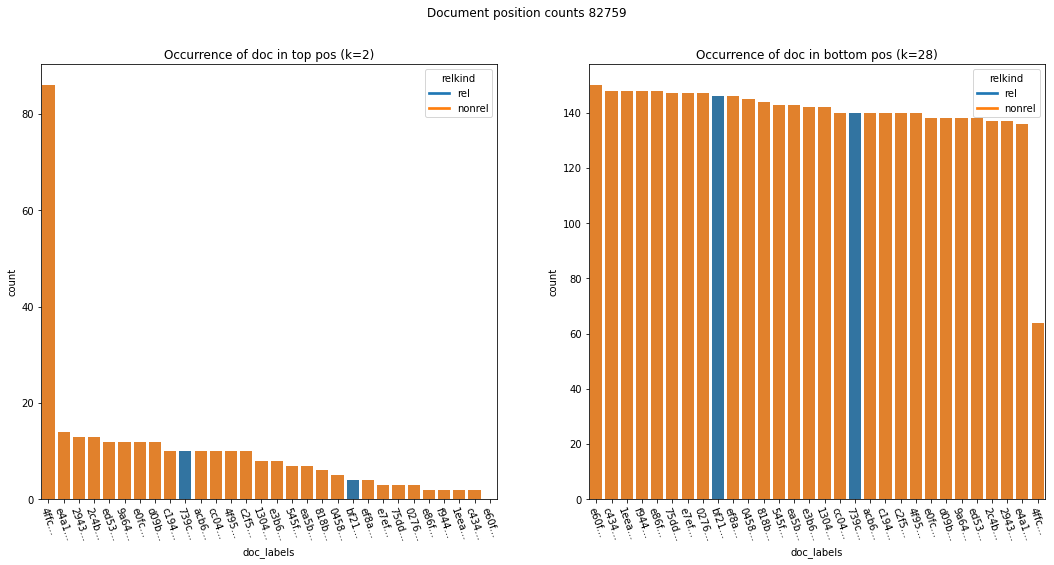

In [160]:
for q in edf.tail(10).iloc[::-1].qid.to_list():
    rel,nonrel = count_relgrades_qid(q,reldf)
    plot_rel_nonrel_per_rank_per_relkind_for_qid(q, rdf, reldf)
    plot_doc_occurrence_per_rank_for_qid(q,rdf,reldf,k=rel)
    plot_doc_pos_count_for_qid(q,rdf,reldf)

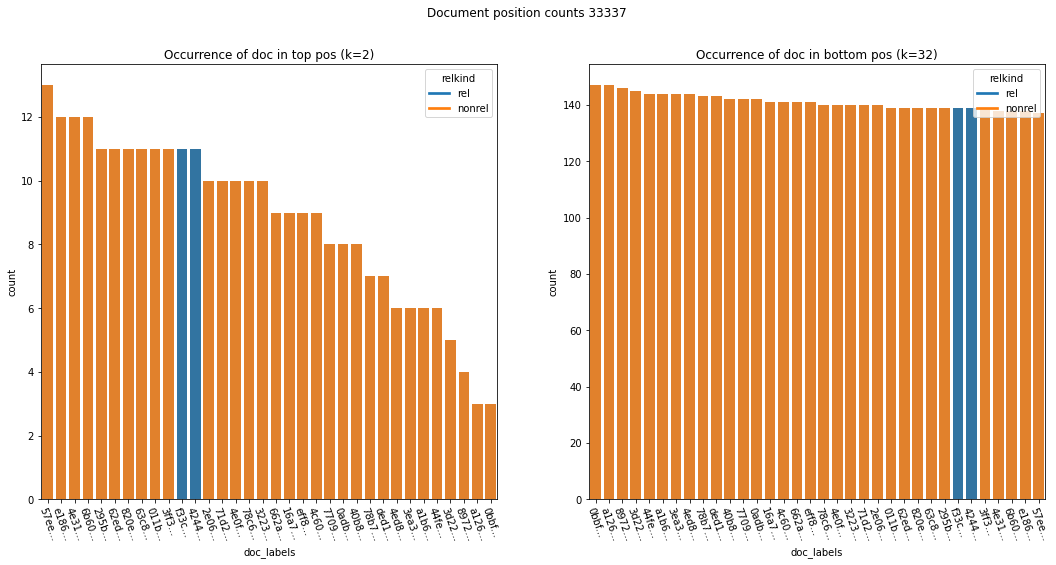

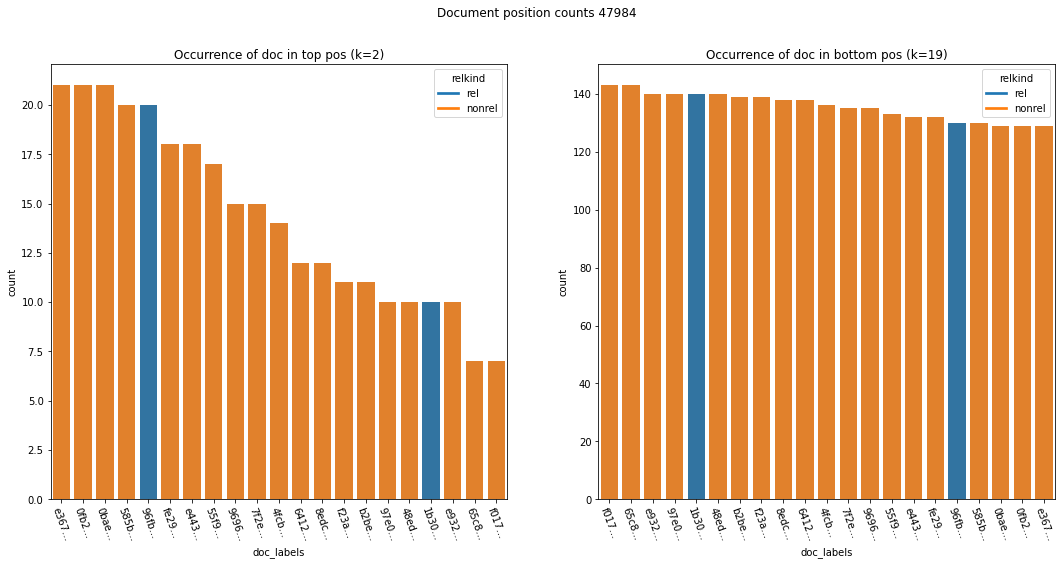

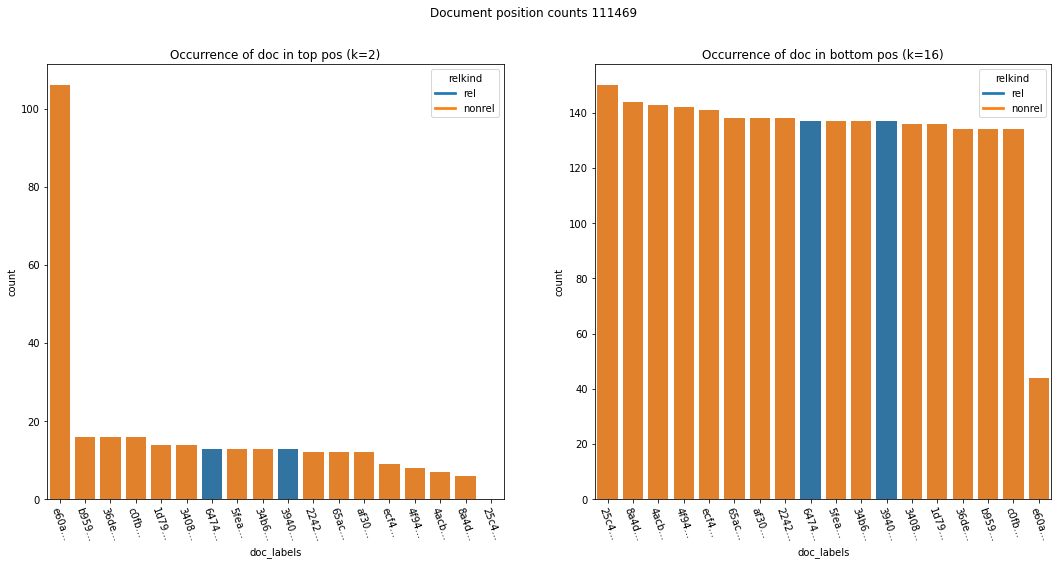

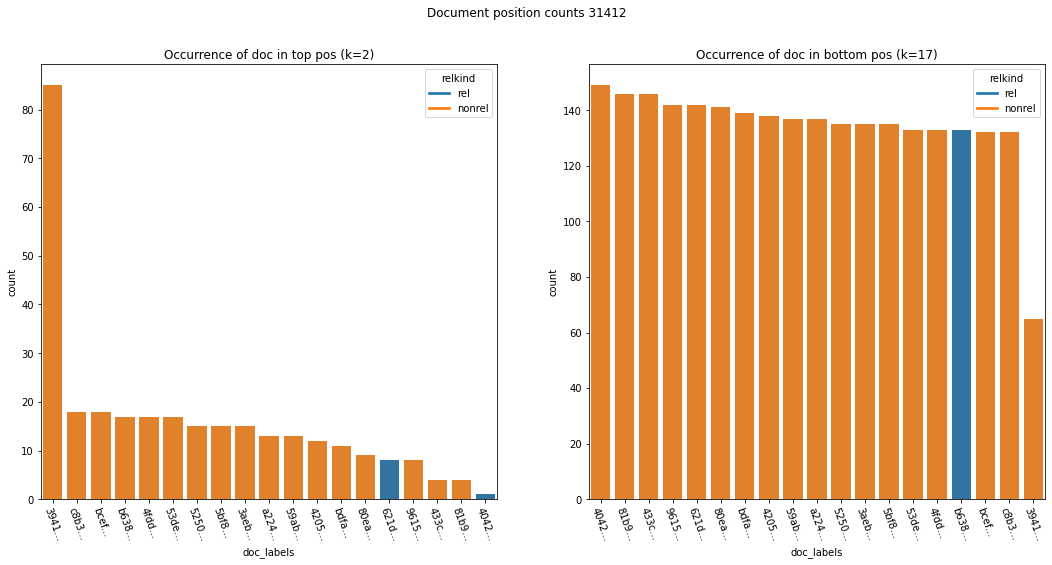

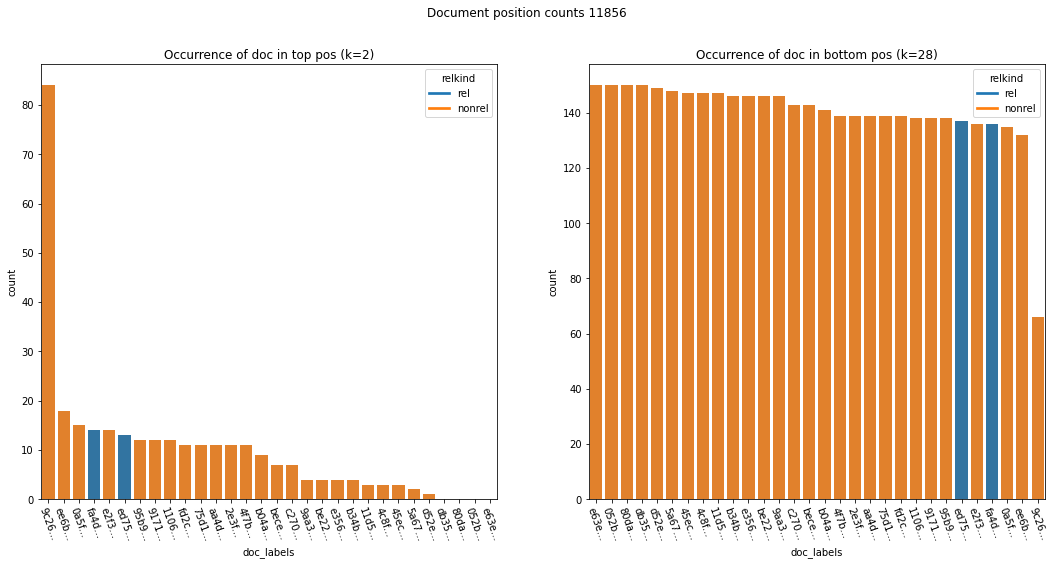

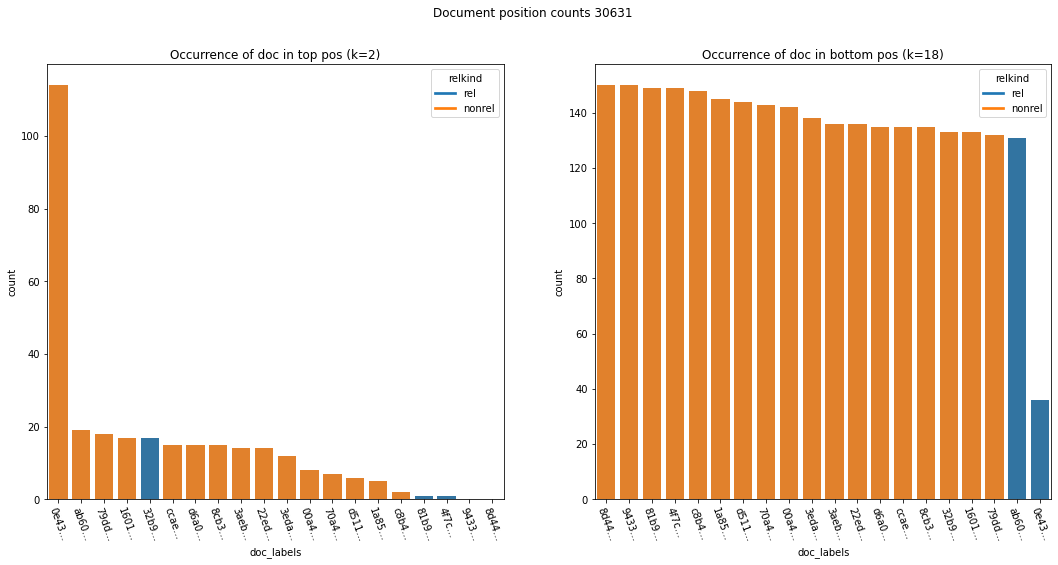

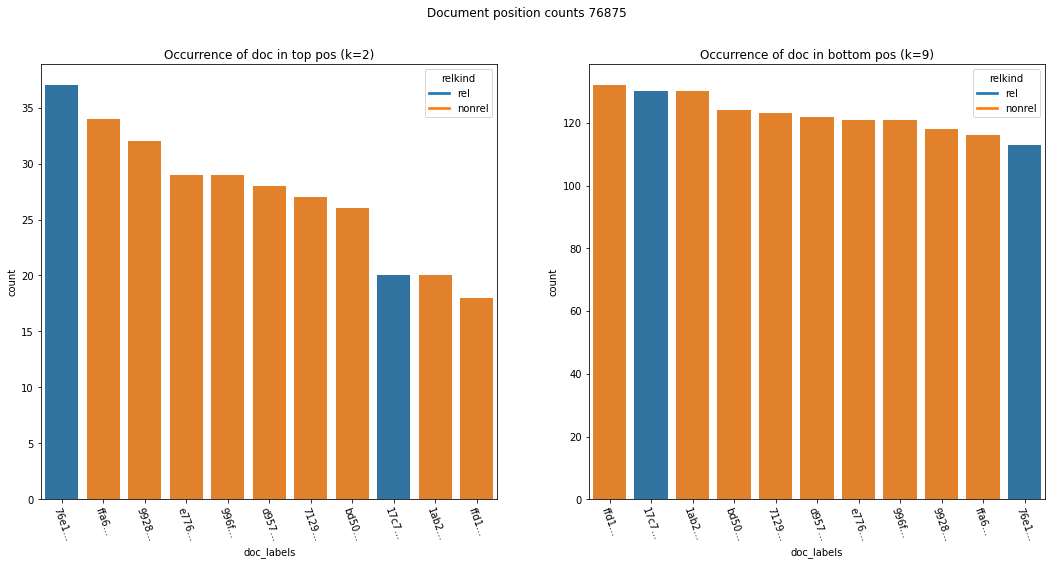

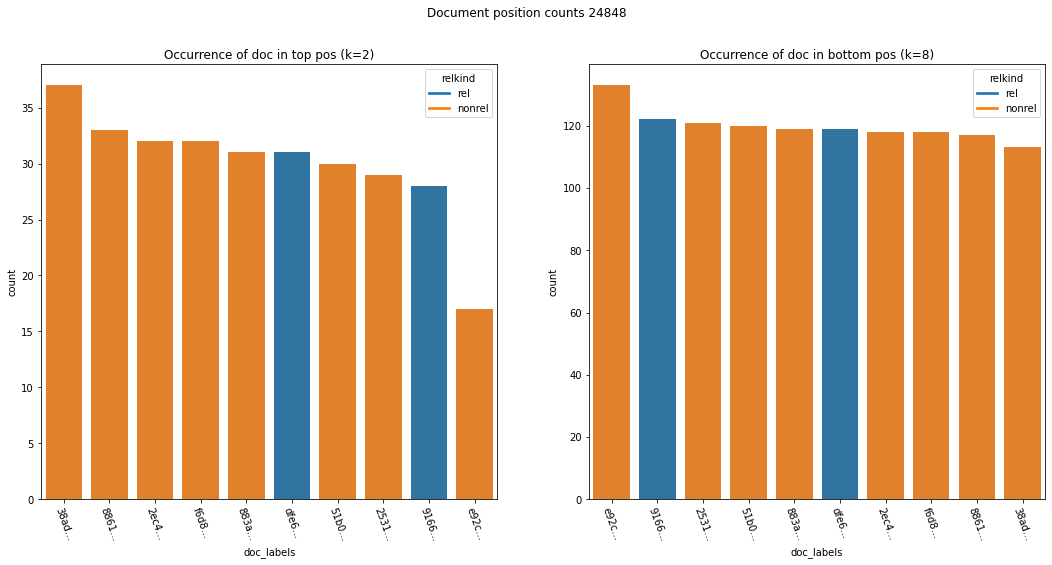

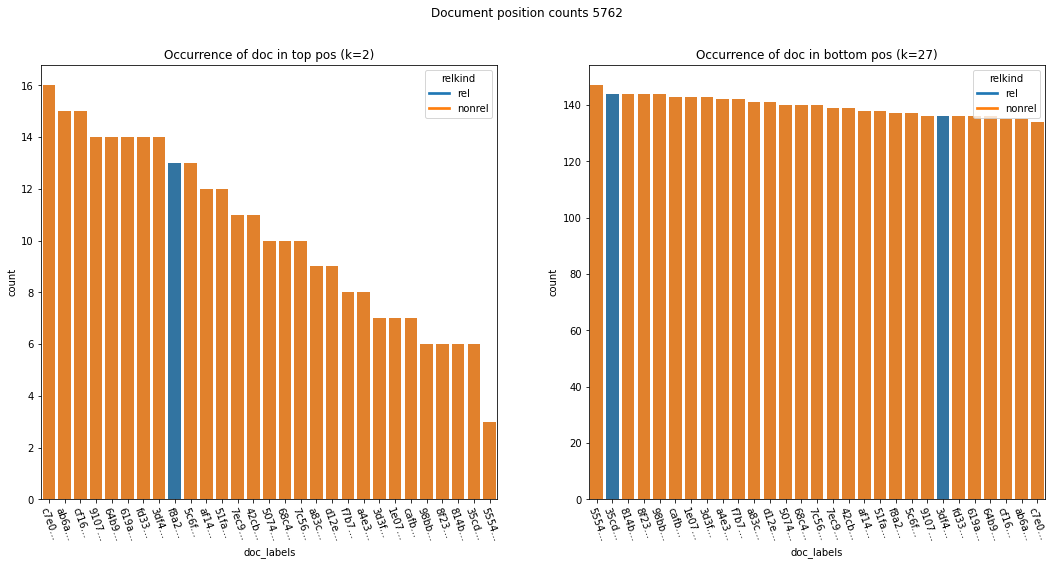

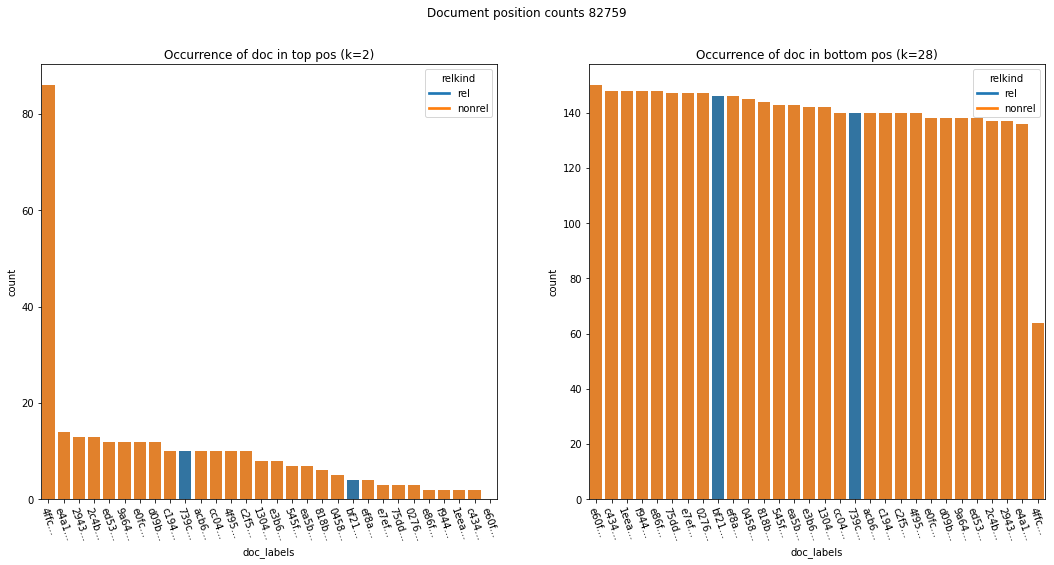

In [162]:
for q in edf.tail(10).iloc[::-1].qid.to_list():
    plot_doc_pos_count_for_qid(q,rdf,reldf,sortby=['count'])

KeyboardInterrupt: 

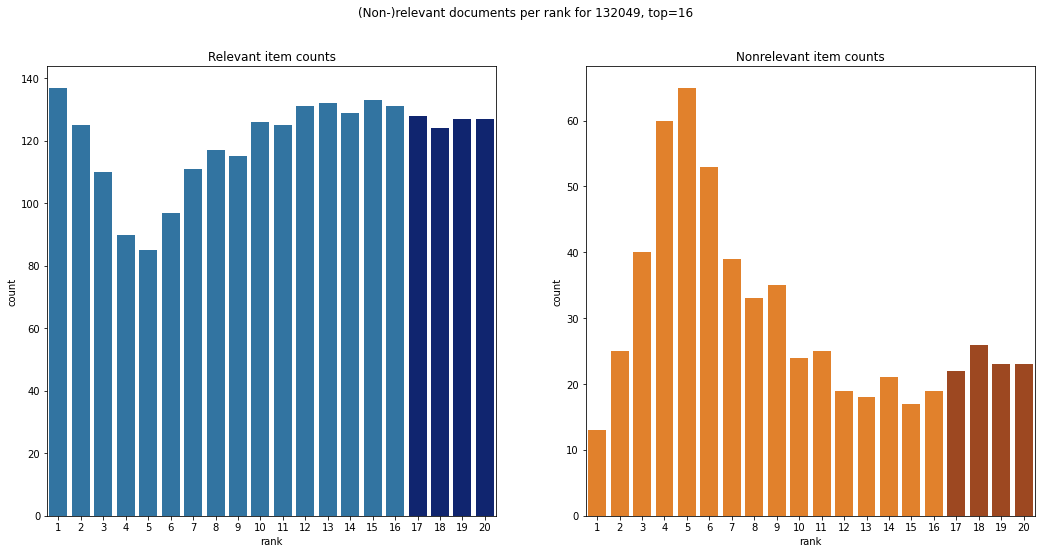

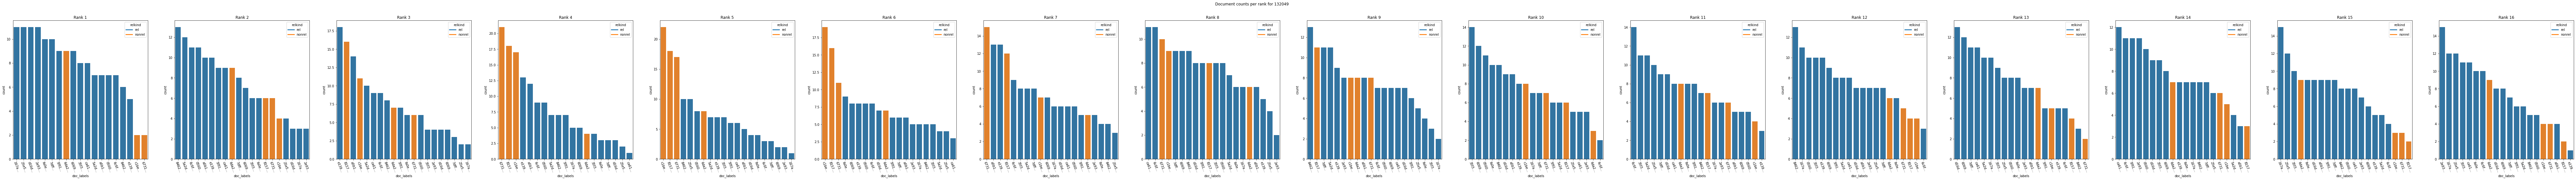

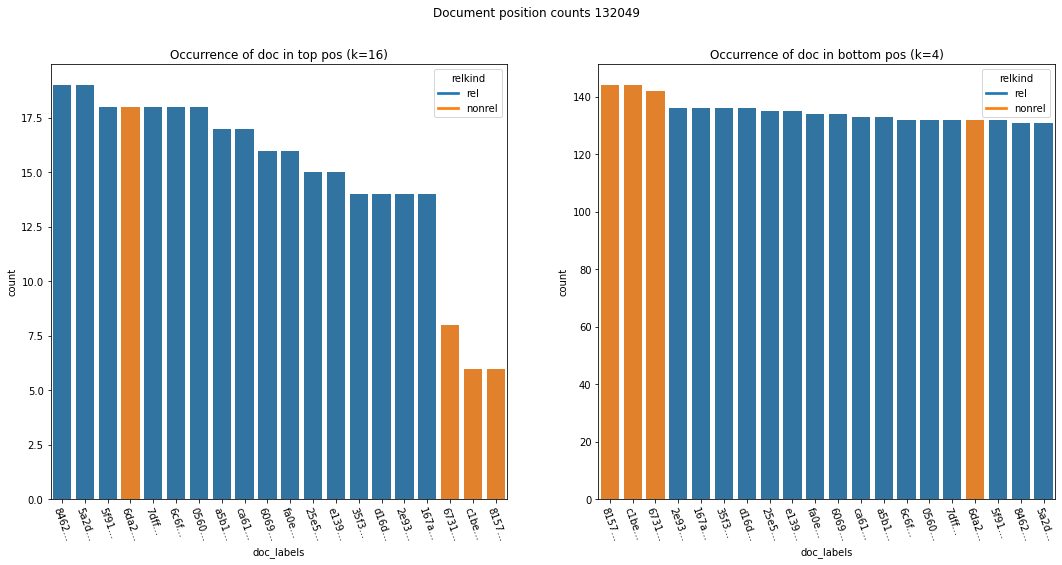

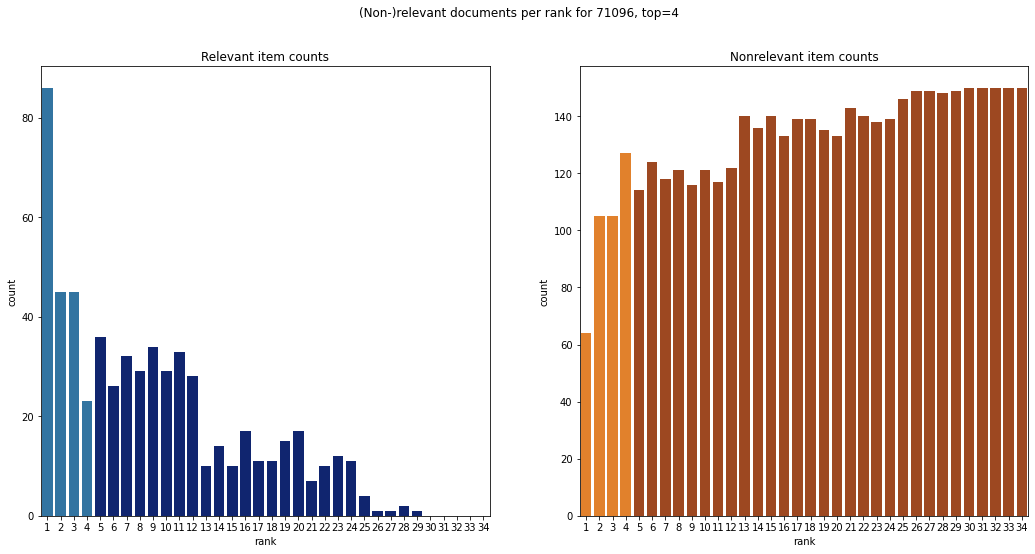

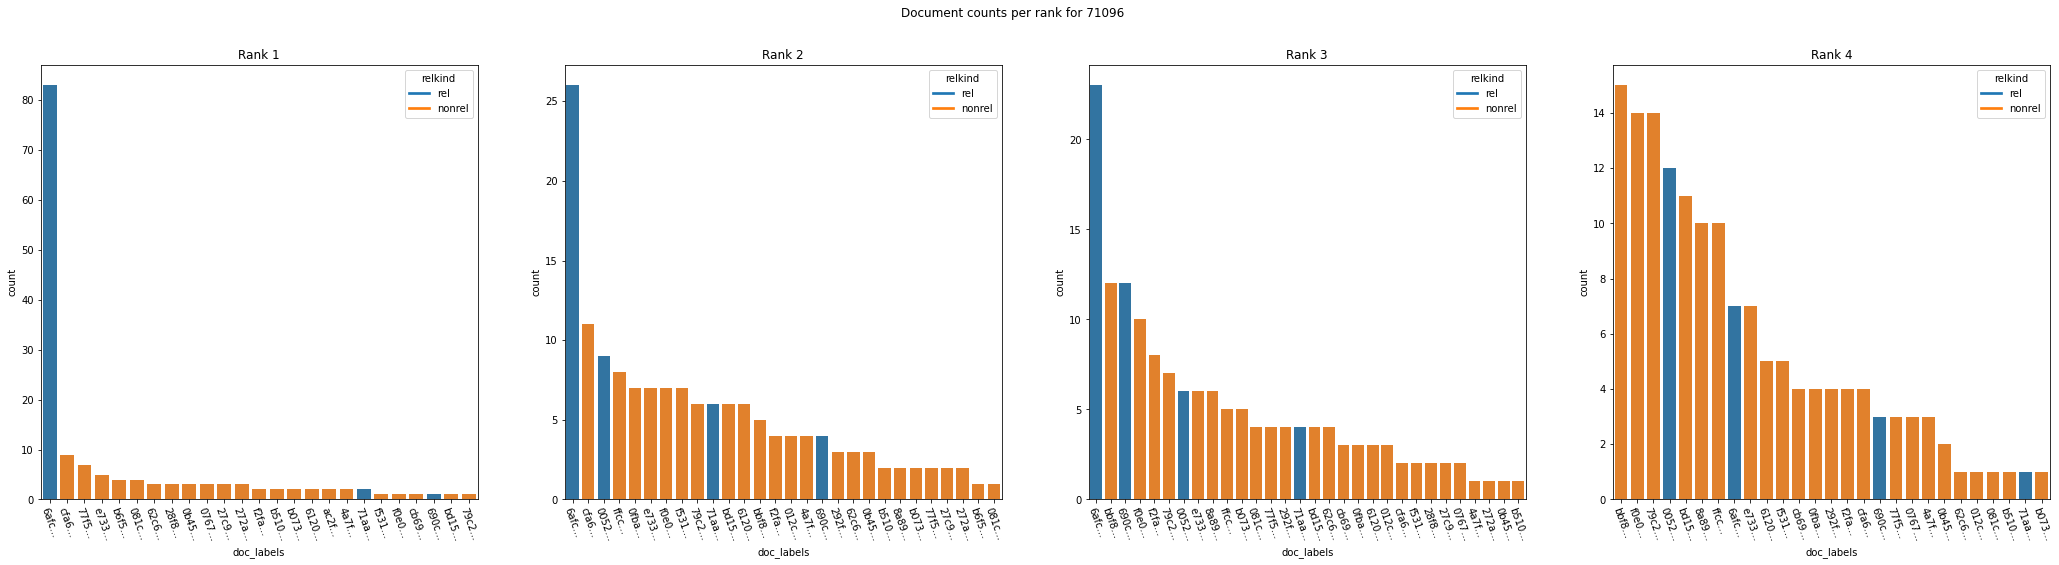

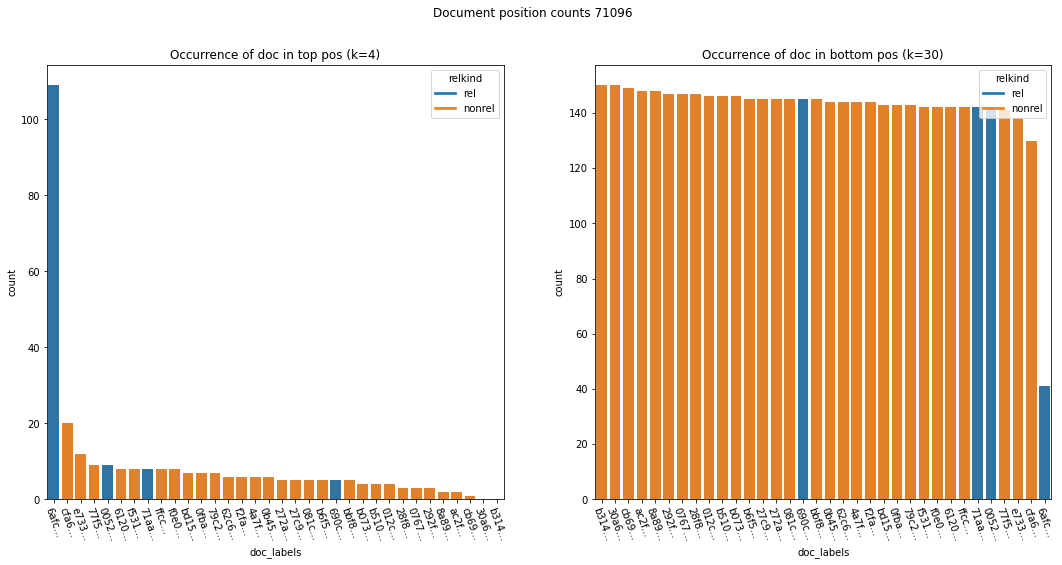

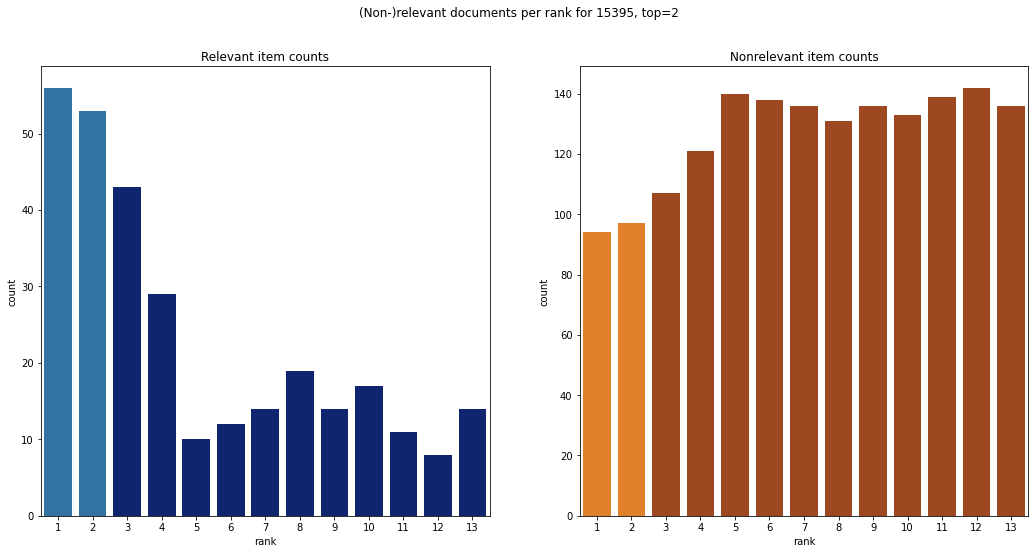

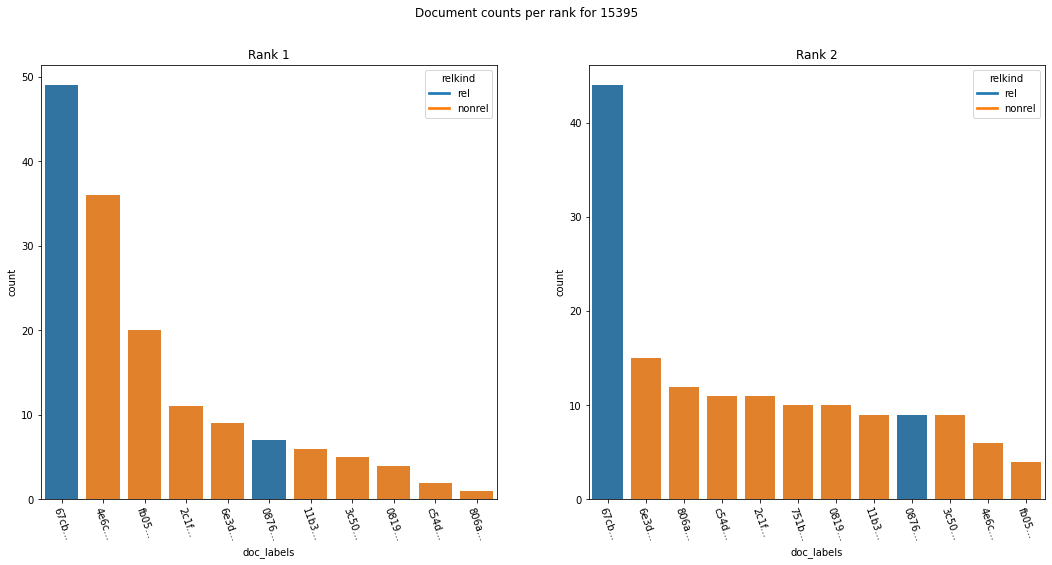

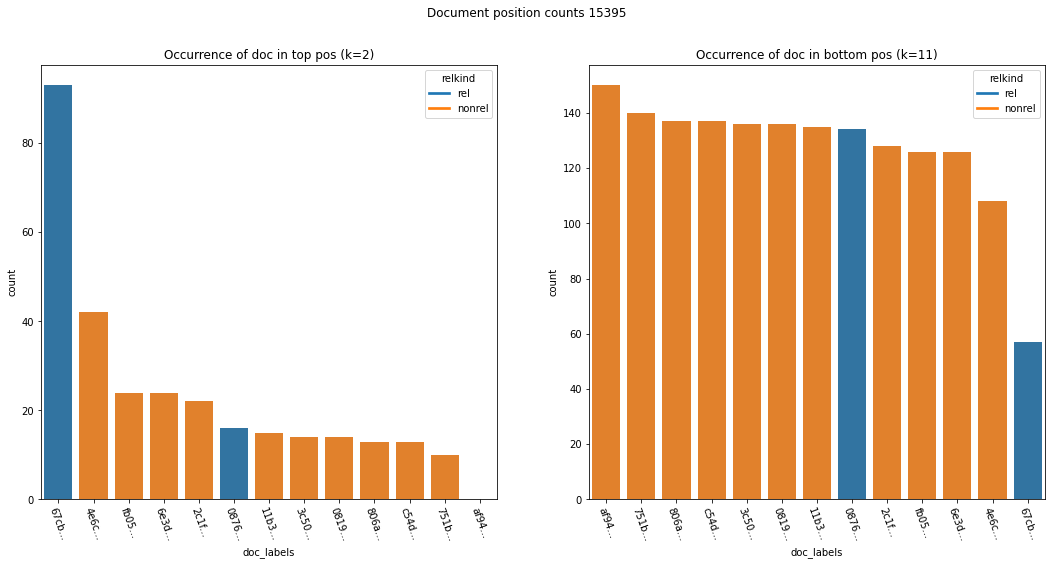

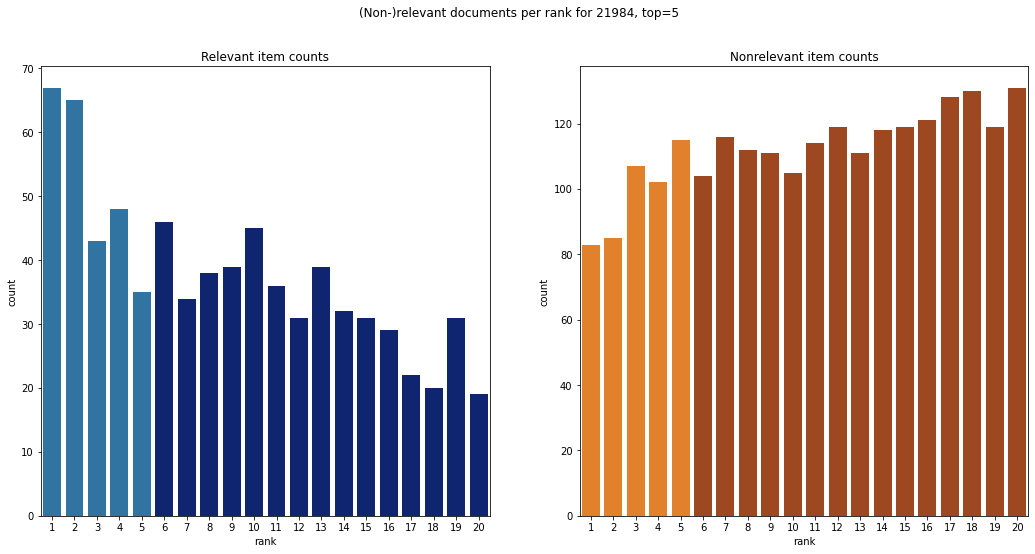

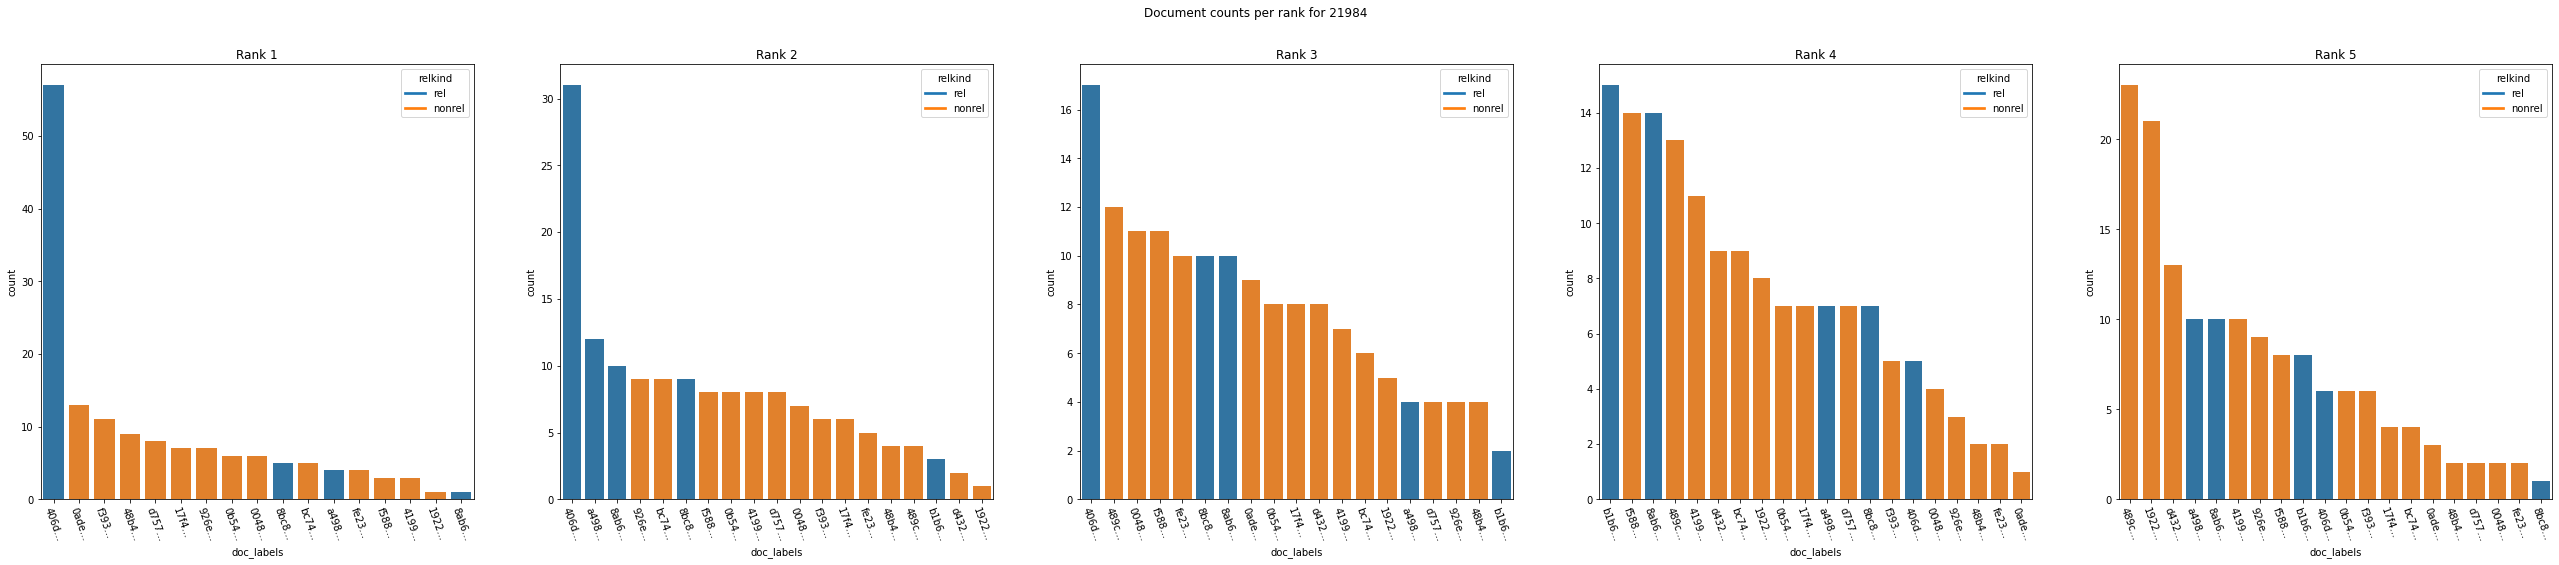

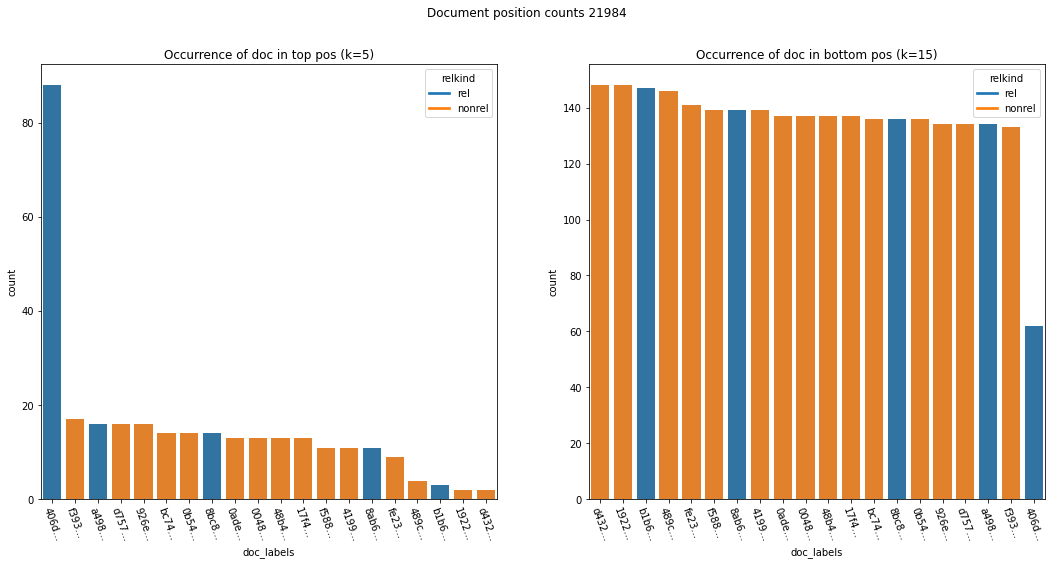

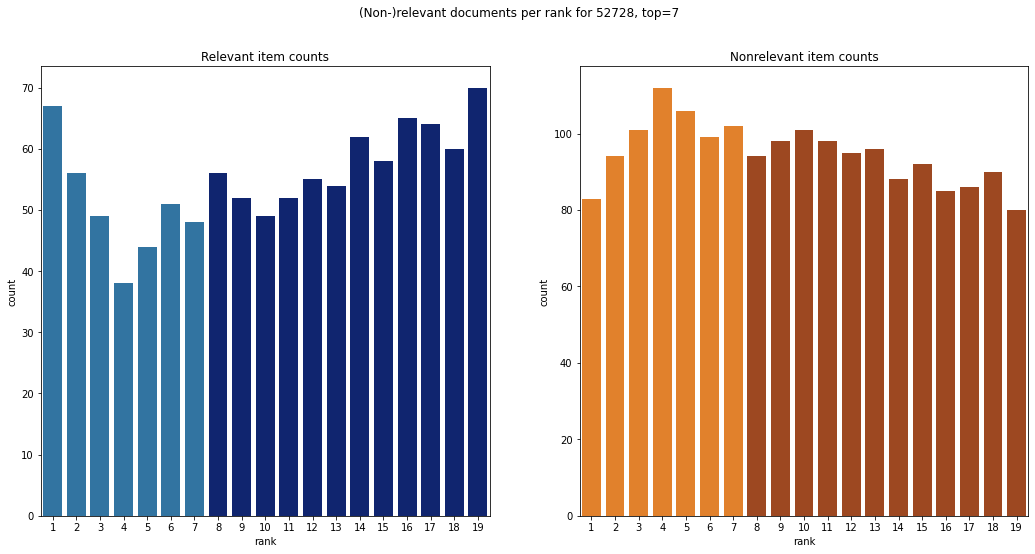

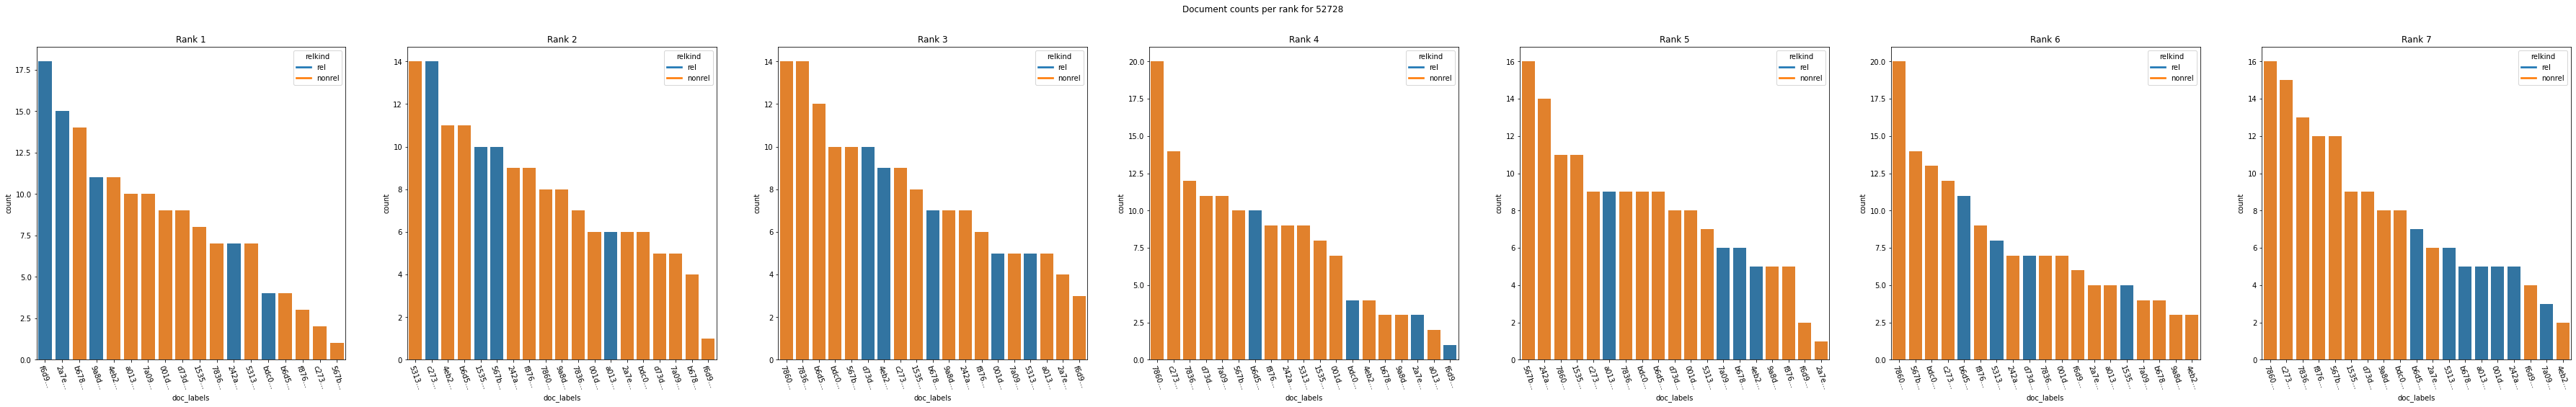

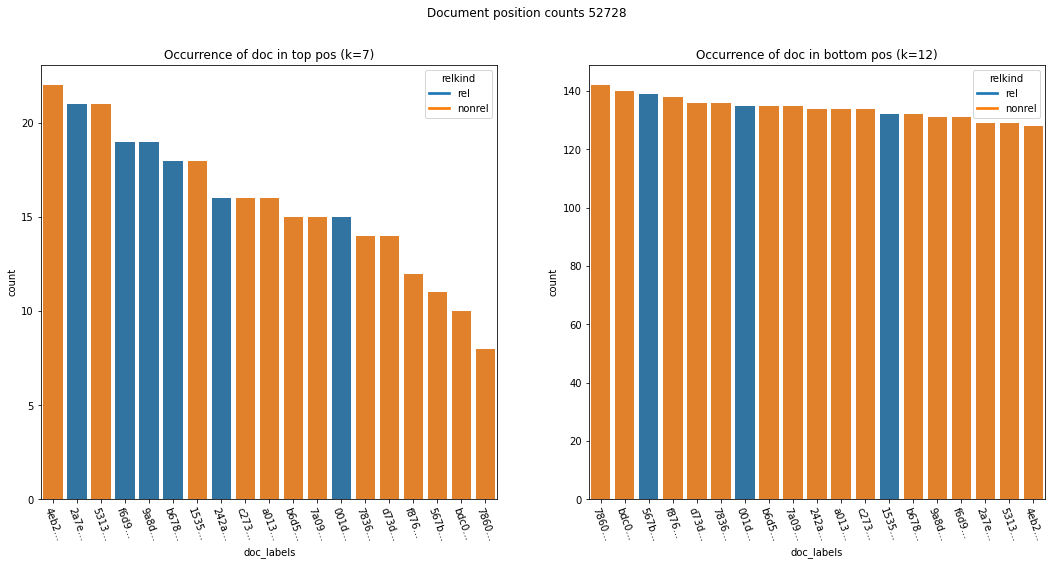

In [161]:
for q in edf.head(10).qid.to_list():
    rel,nonrel = count_relgrades_qid(q,reldf)
    plot_rel_nonrel_per_rank_per_relkind_for_qid(q, rdf, reldf)
    plot_doc_occurrence_per_rank_for_qid(q,rdf,reldf,k=rel)
    plot_doc_pos_count_for_qid(q,rdf,reldf)

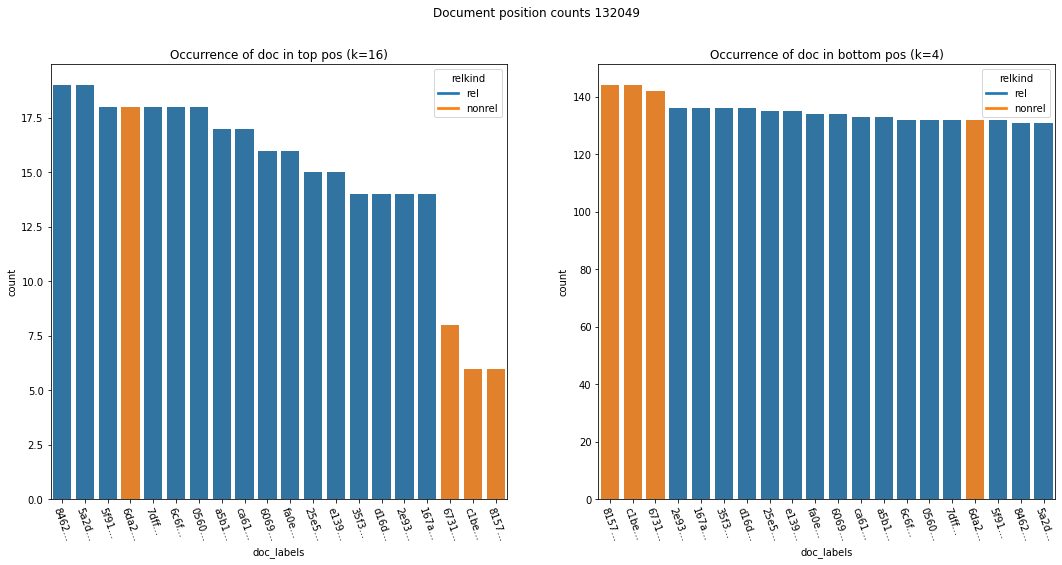

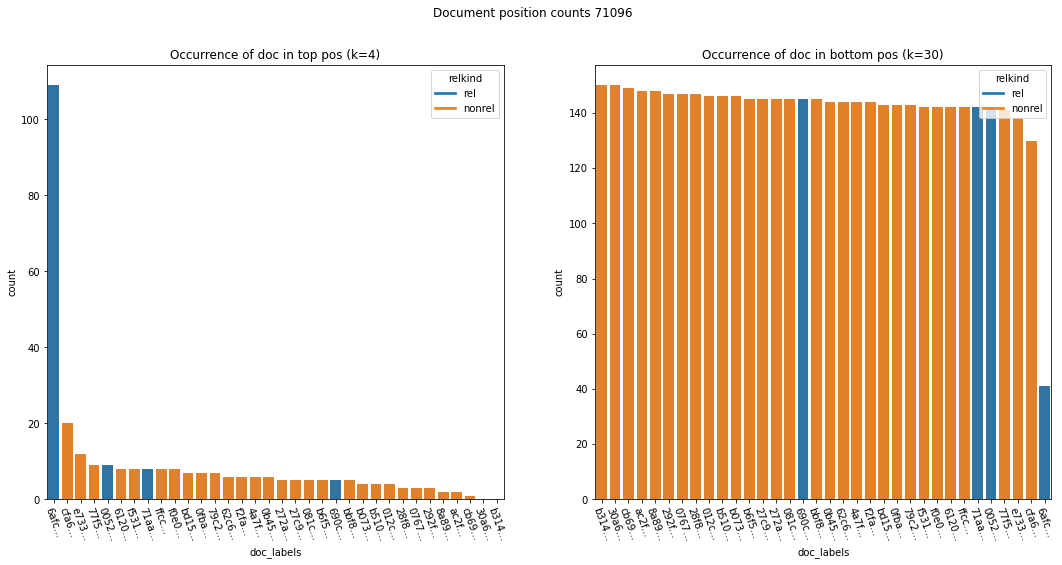

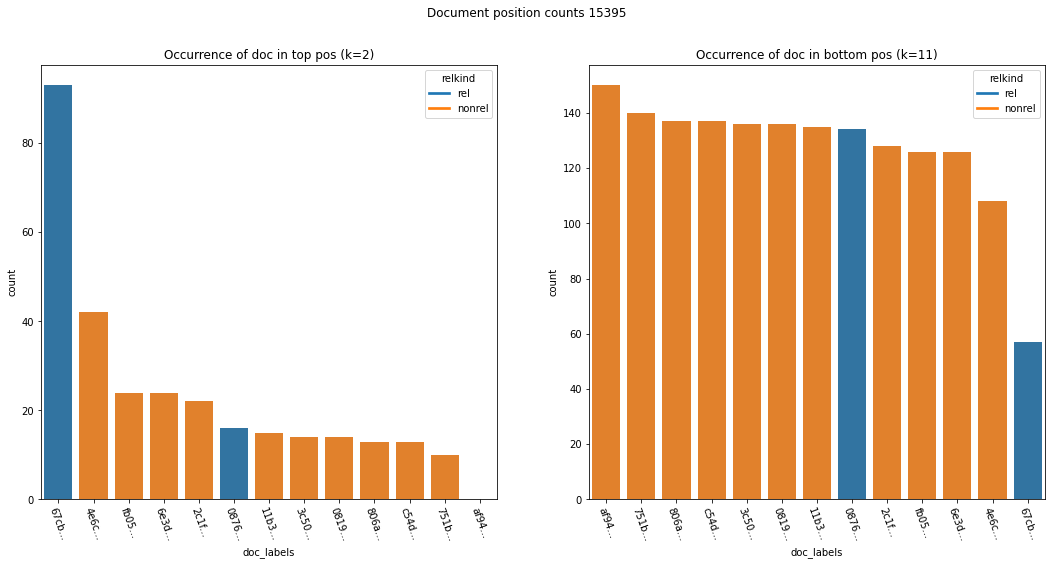

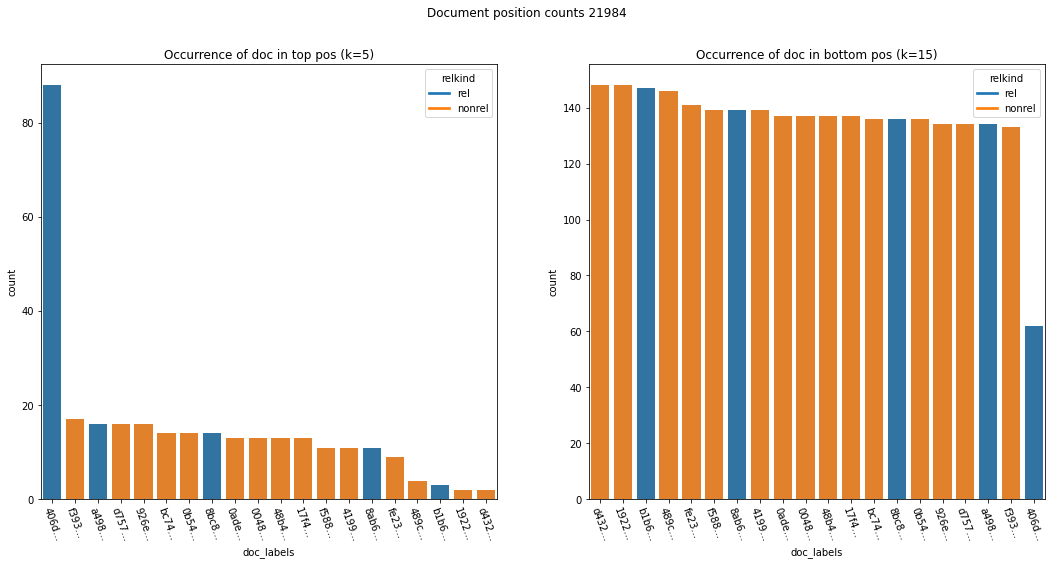

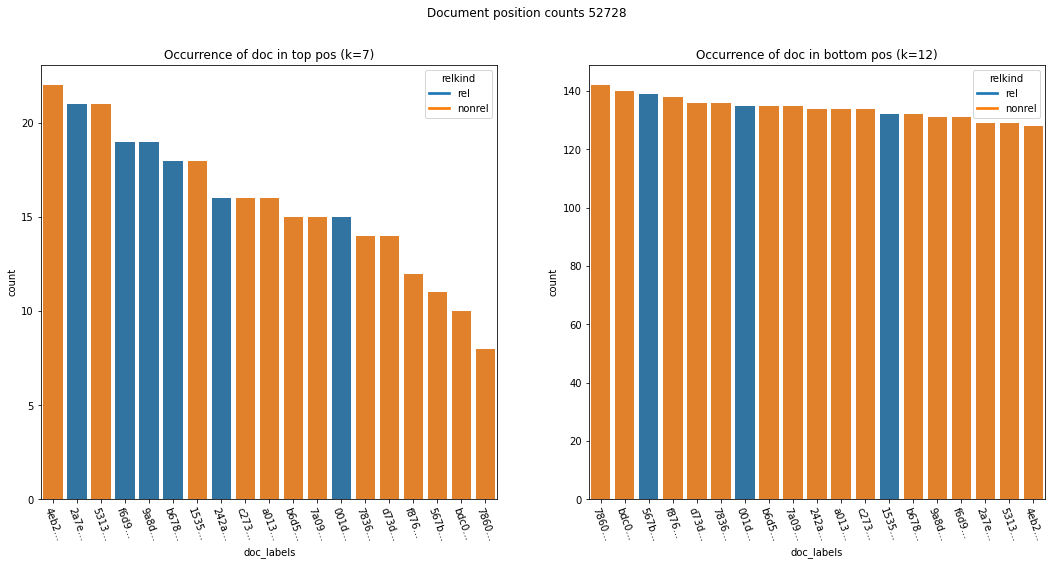

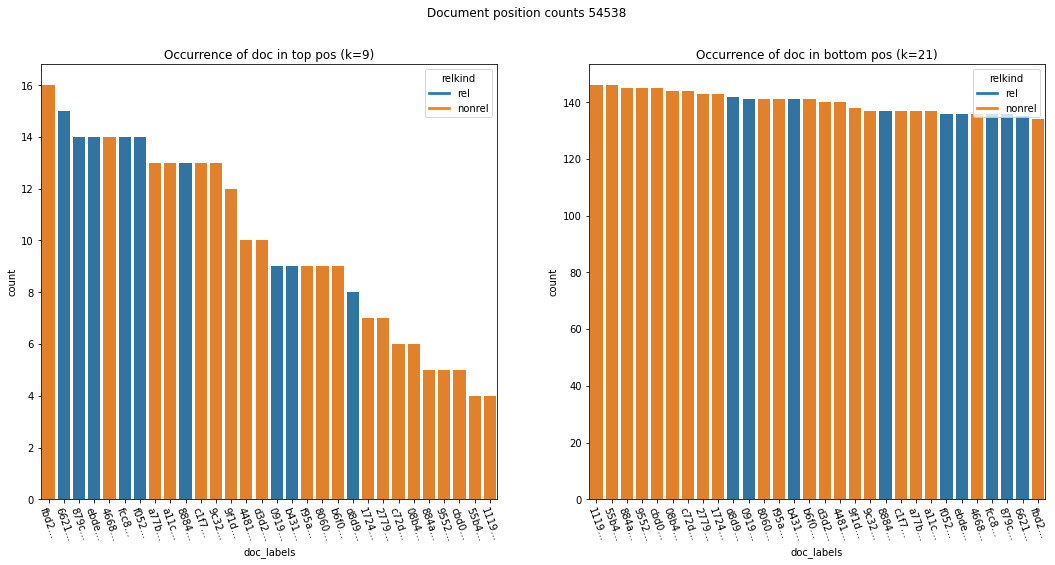

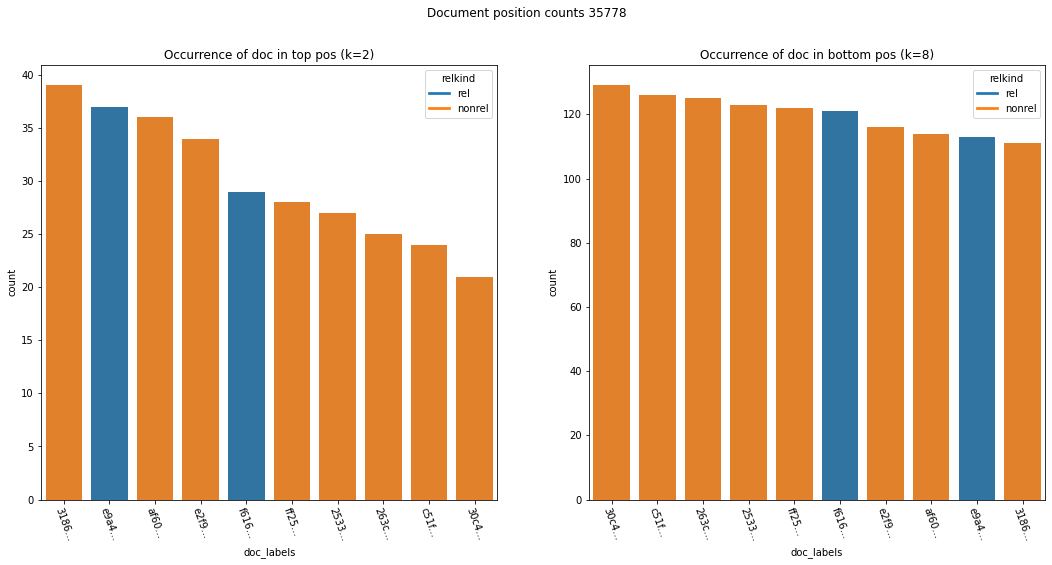

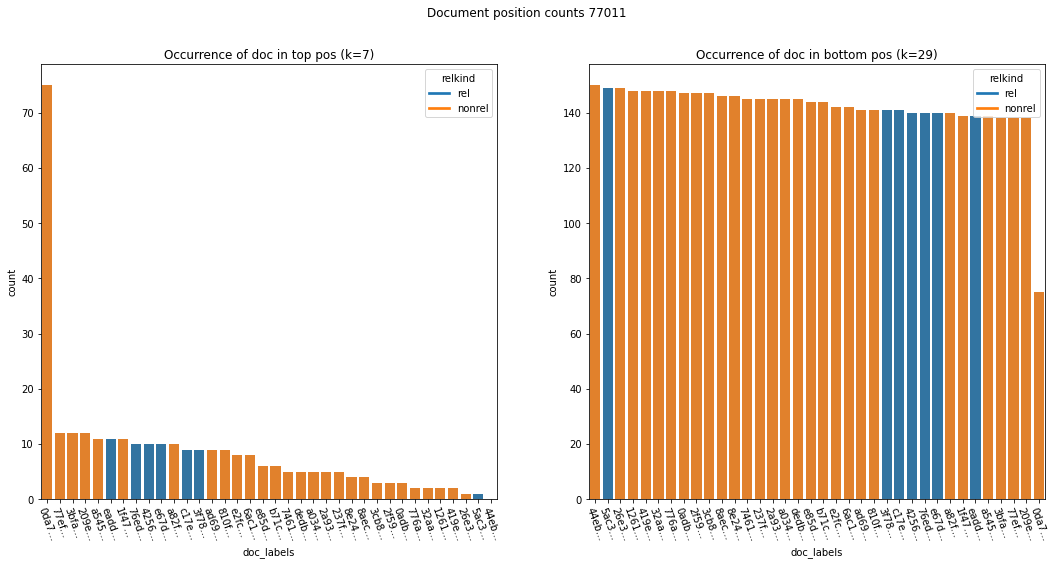

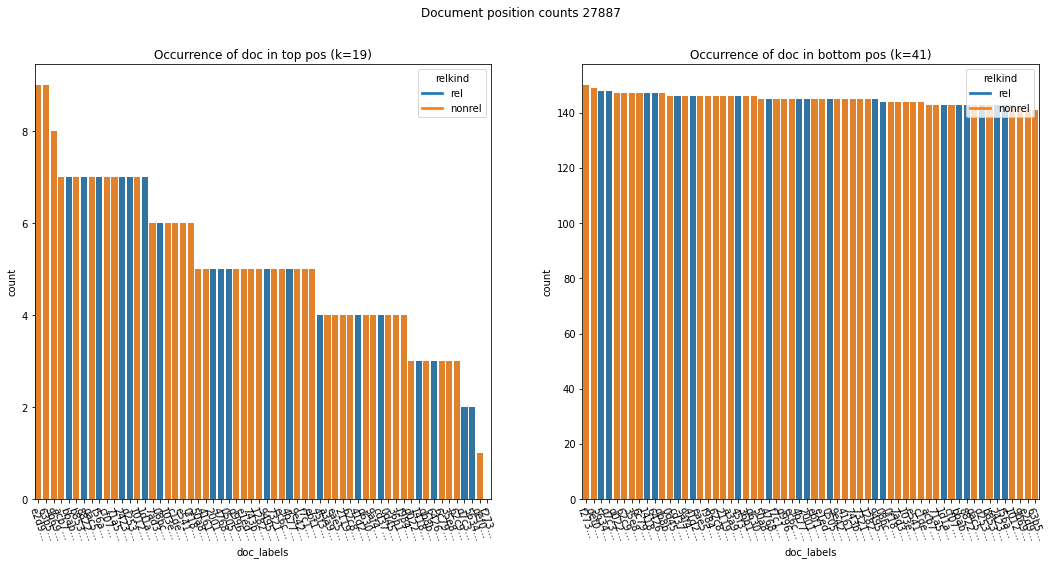

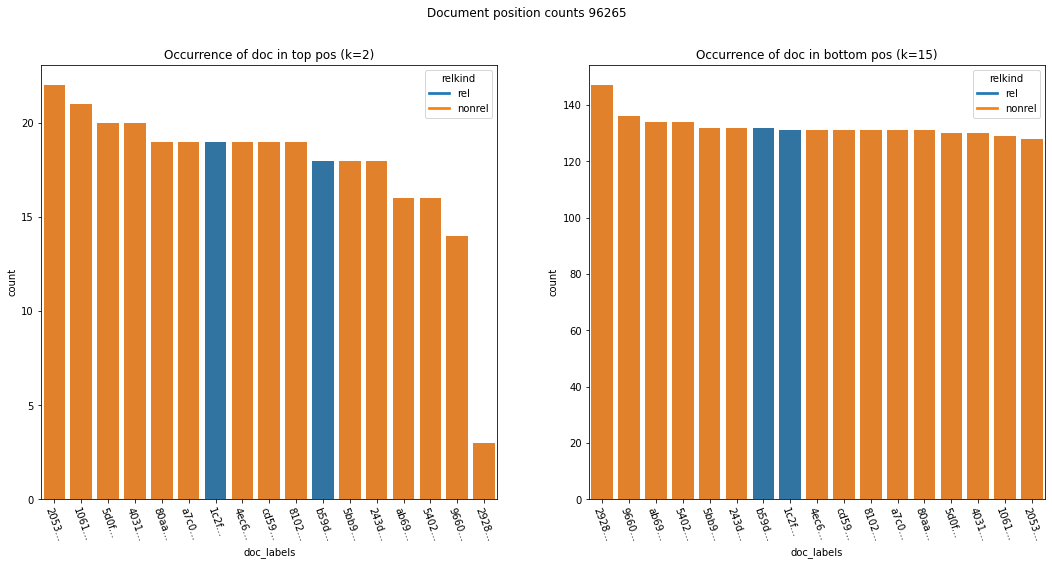

In [163]:
for q in edf.head(10).qid.to_list():
    plot_doc_pos_count_for_qid(q,rdf,reldf)

#### nonspikeys

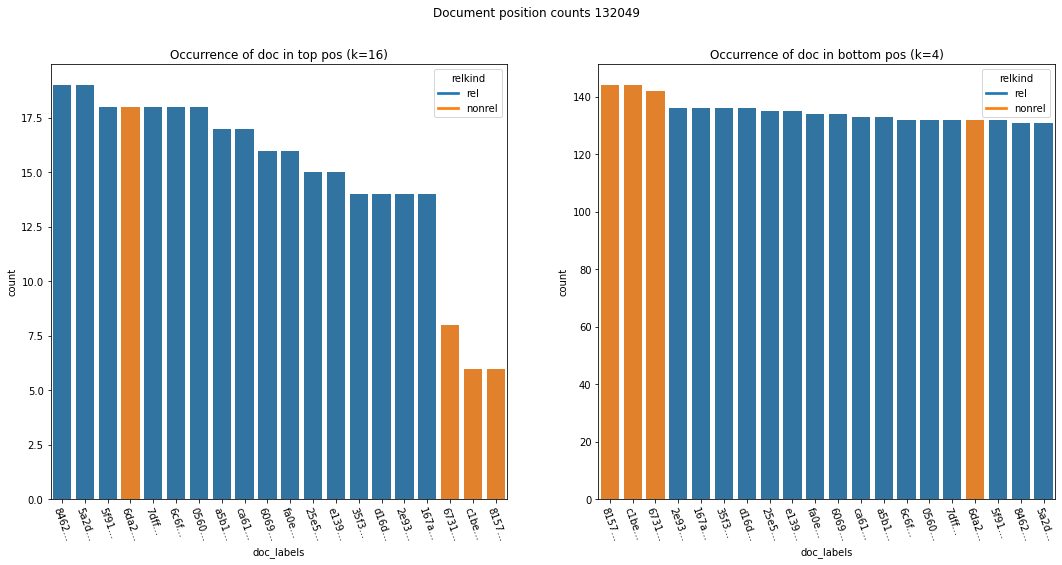

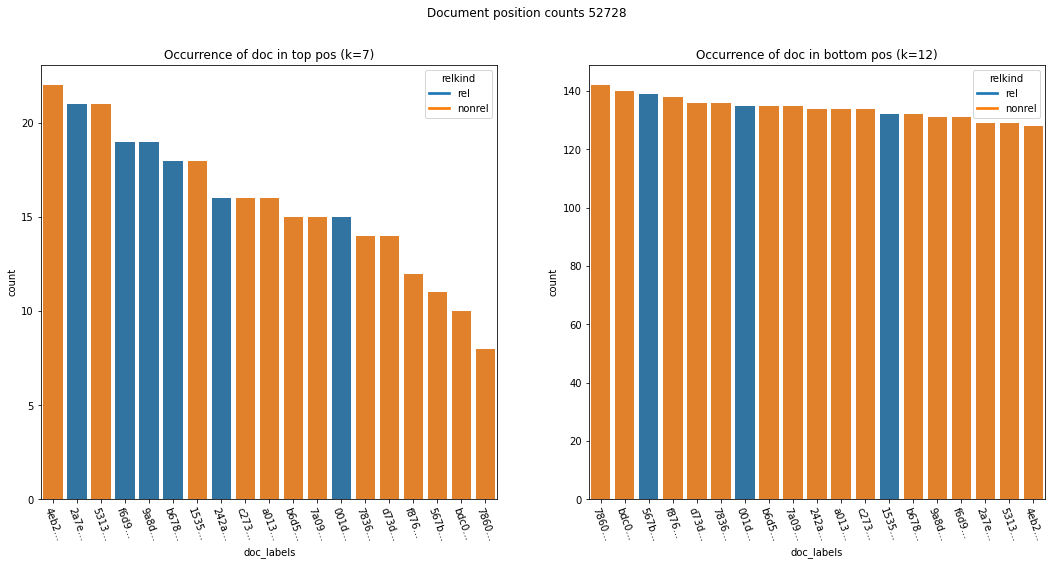

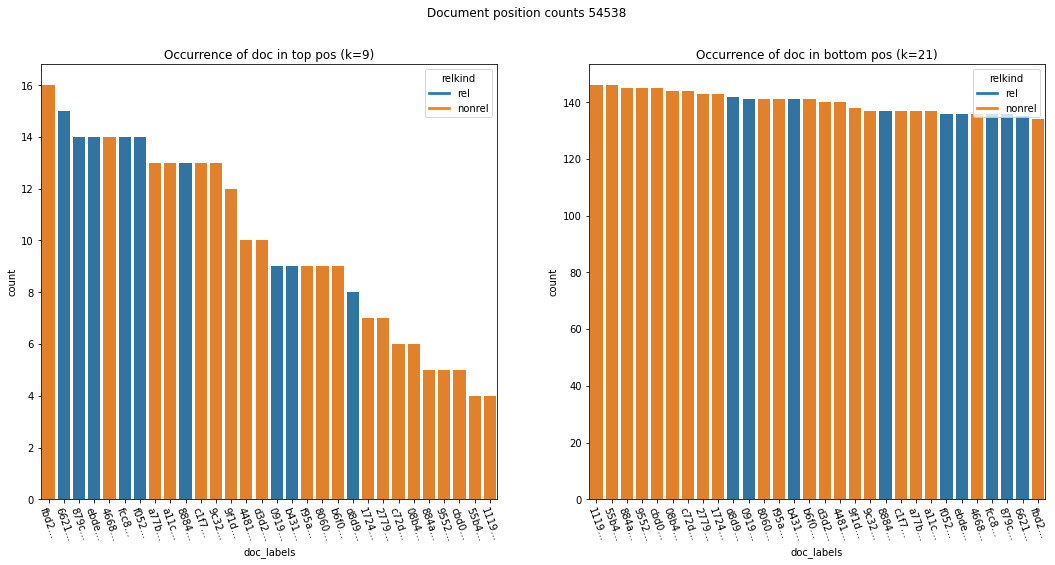

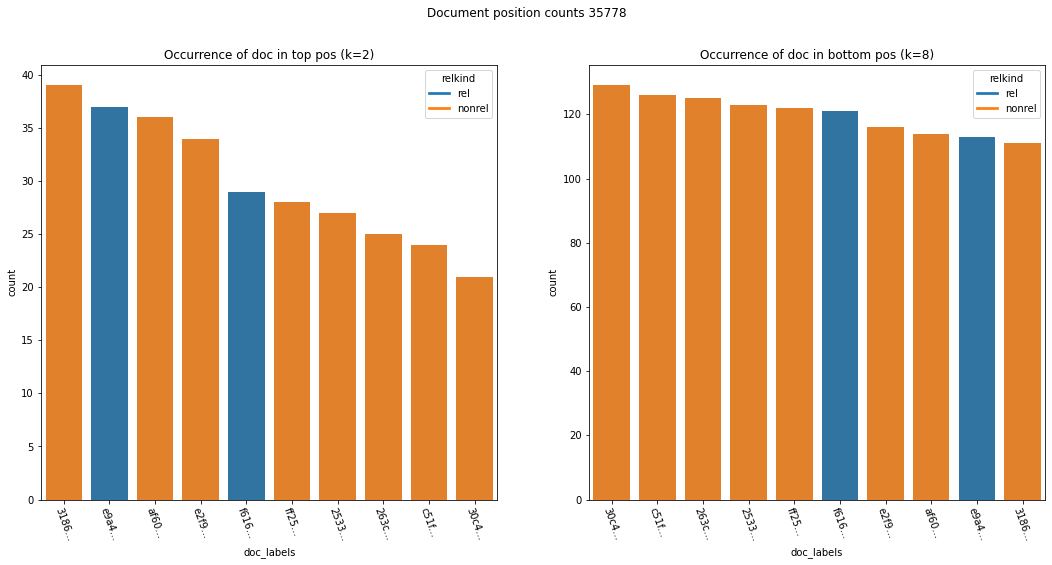

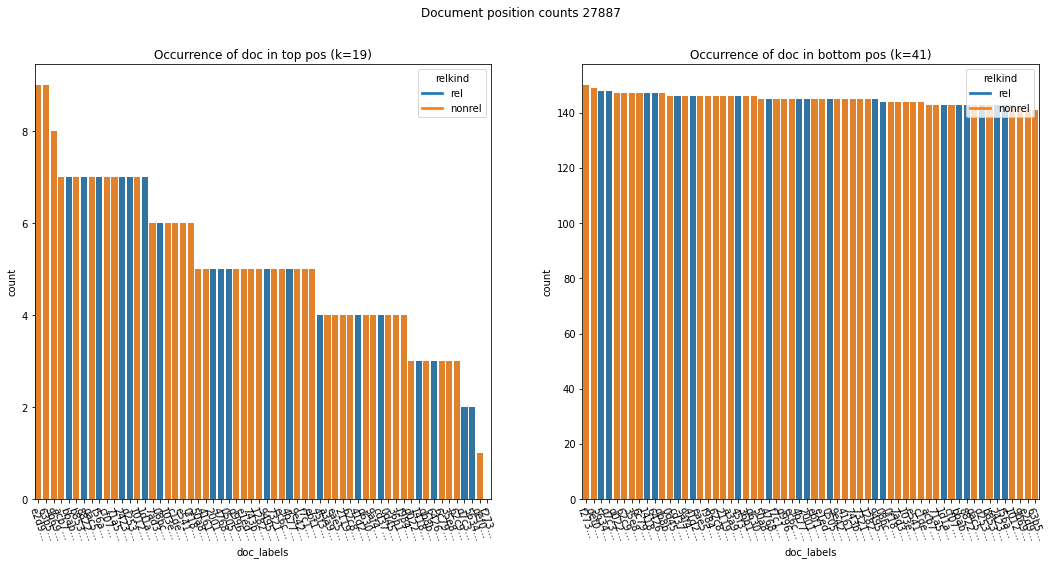

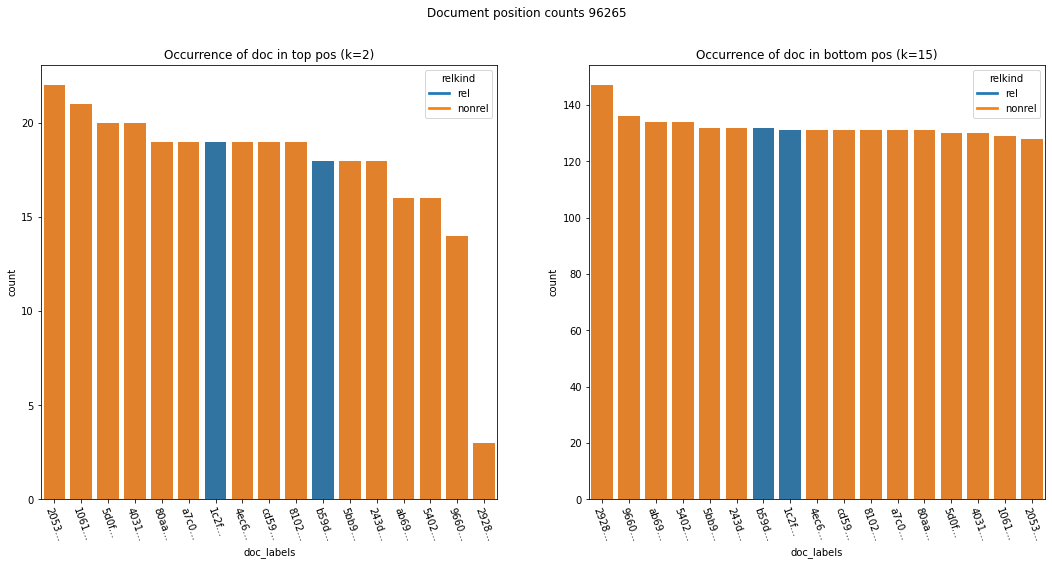

In [166]:
for q in edf.head(10).qid.to_list():
    if not q in [77011, 15395, 21984, 71096]:
        plot_doc_pos_count_for_qid(q,rdf,reldf)

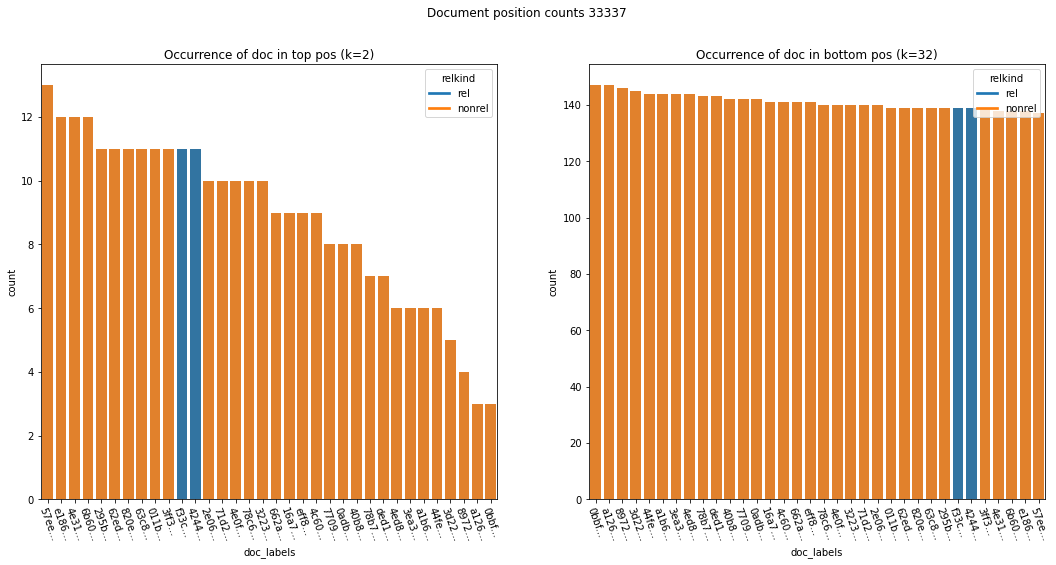

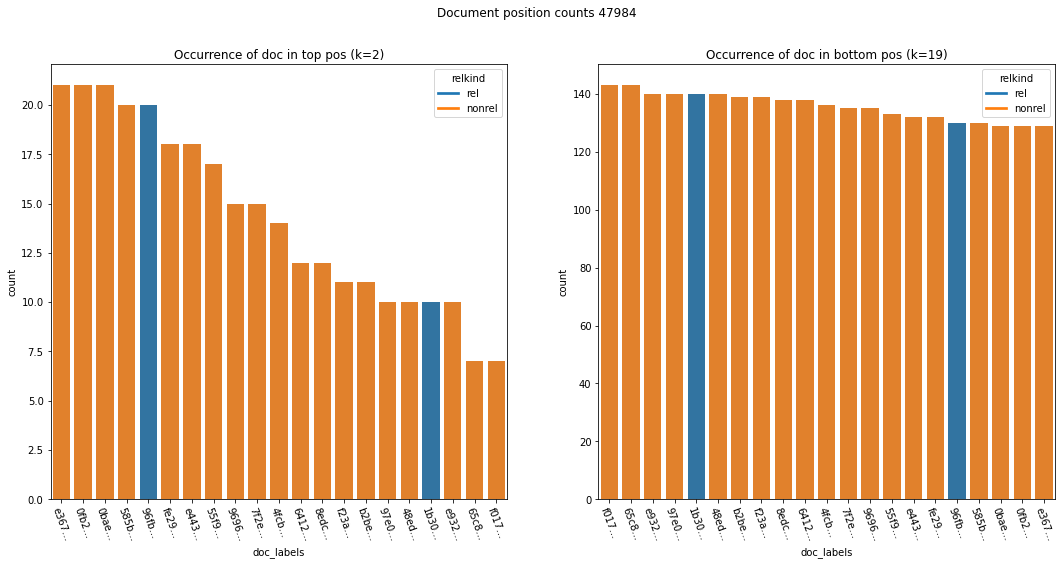

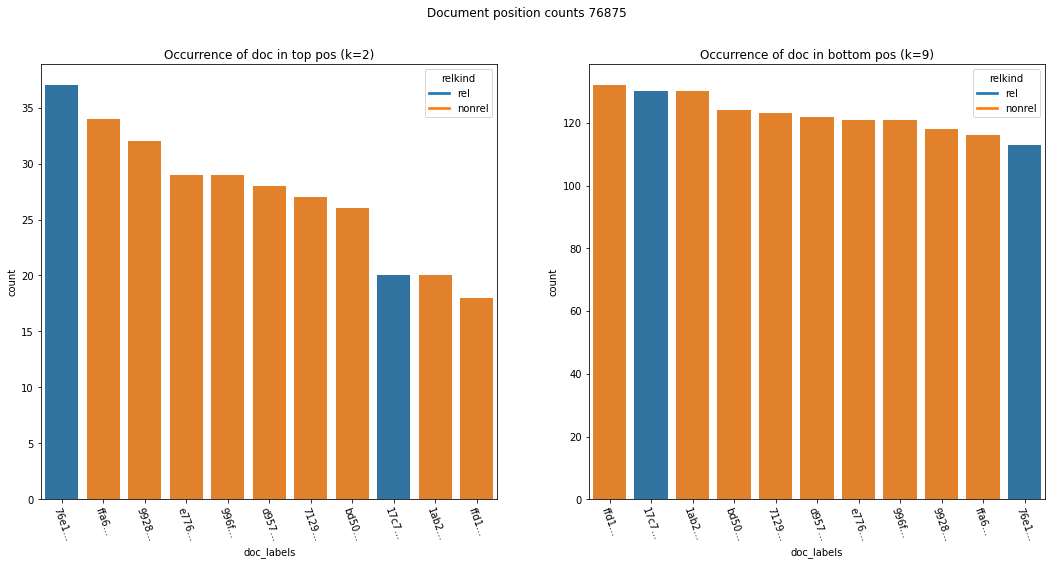

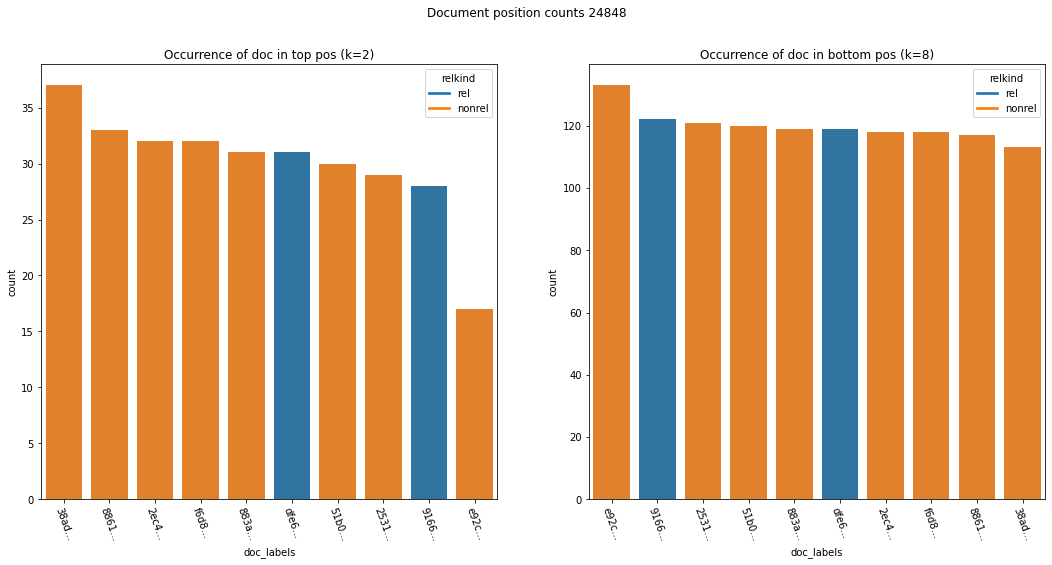

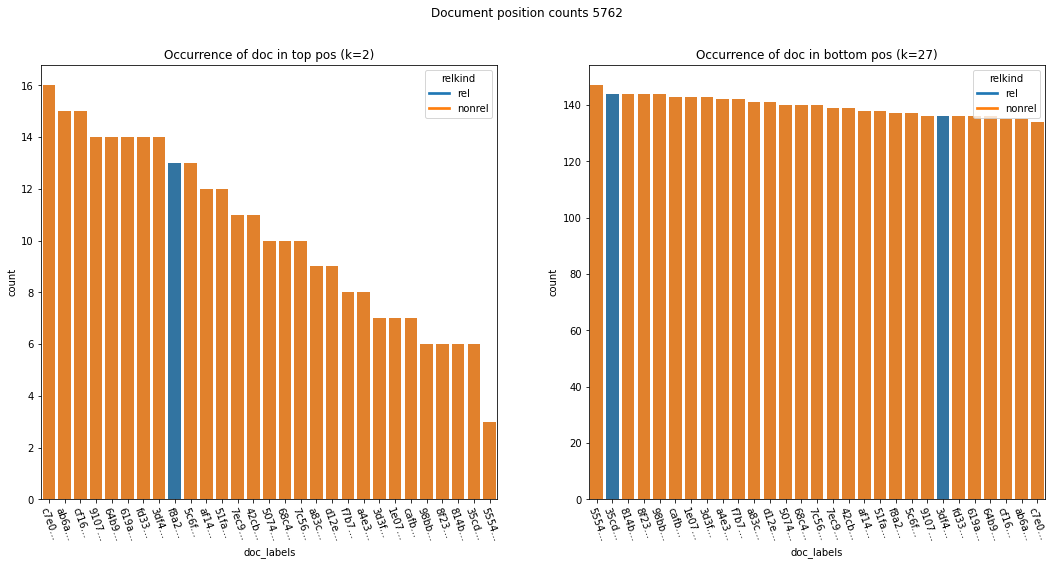

In [165]:
for q in edf.tail(10).iloc[::-1].qid.to_list():
    if not q in [111469, 31412, 11856, 30631, 82759]:
        plot_doc_pos_count_for_qid(q,rdf,reldf)

### Inspect spiking documents
The top non-relevant documents for queries

| qid    | docid                                    |
| ------ | ---------------------------------------- |
| 111469 | e60af557a1bbfd9b2adee8a3c090d27faab86632 |
| 31412  | 394149ca78b50fb0811a49af46eb95c7ff7241e9 |
| 11856  | 9c26600cfc83d6926a81863a925423244af36c51 |
| 30631  | 0e43caeb9d476264d307e8da0ad71ecc4d804ced |
| 82759  | 4ffc7321bc94c9f9391cff47c32a506c3a2d7aa0 |
| 77011! | 0da7a3f0c7d130412c61687521f60f3d06d41bcd |


We look at each of these document's authors and their predicted relevance scores.


#### Estimated relevances

In [ ]:
est_rel_meta.est_relevance.max()

In [ ]:
est_rel_meta.est_relevance.min()

In [168]:
spikes = pd.DataFrame({'qid': [111469,31412,11856,30631,82759,77011],'doc_id':['e60af557a1bbfd9b2adee8a3c090d27faab86632',
                                                                               '394149ca78b50fb0811a49af46eb95c7ff7241e9',
                                                                               '9c26600cfc83d6926a81863a925423244af36c51',
                                                                               '0e43caeb9d476264d307e8da0ad71ecc4d804ced',
                                                                               '4ffc7321bc94c9f9391cff47c32a506c3a2d7aa0',
                                                                               '0da7a3f0c7d130412c61687521f60f3d06d41bcd']})
spikes

qid                                    doc_id
0  111469  e60af557a1bbfd9b2adee8a3c090d27faab86632
1   31412  394149ca78b50fb0811a49af46eb95c7ff7241e9
2   11856  9c26600cfc83d6926a81863a925423244af36c51
3   30631  0e43caeb9d476264d307e8da0ad71ecc4d804ced
4   82759  4ffc7321bc94c9f9391cff47c32a506c3a2d7aa0
5   77011  0da7a3f0c7d130412c61687521f60f3d06d41bcd

In [173]:
spikesrel = pd.merge(spikes,est_rel_meta, on=['qid','doc_id'],how='left')
spikesrel

qid                                    doc_id  relevance  est_relevance
0  111469  e60af557a1bbfd9b2adee8a3c090d27faab86632          0       0.213855
1   31412  394149ca78b50fb0811a49af46eb95c7ff7241e9          0       0.076889
2   11856  9c26600cfc83d6926a81863a925423244af36c51          0       0.108677
3   30631  0e43caeb9d476264d307e8da0ad71ecc4d804ced          0       0.124778
4   82759  4ffc7321bc94c9f9391cff47c32a506c3a2d7aa0          0       0.081257
5   77011  0da7a3f0c7d130412c61687521f60f3d06d41bcd          0       0.077175

In [174]:
spikesrel.est_relevance.min()

0.0768893410553138

In [175]:
spikesrel.est_relevance.max()

0.21385544710292603

In [176]:
spikesrel.est_relevance.mean()

0.11377193517260666

#### Authors

The other factor influencing the h-scores is the author advantage. We know that some documents do not have authors. In our implementation of the algorithm, the advantage of documents without author is (re)set to zero at each iteration. Additionally, some documents are not in the index at all, and as such also do not have authors.


In [177]:
es = Elasticsearch([{'timeout':300}])
inspect_ids = spikesrel.doc_id.to_list()
res = es.search(index='semanticscholar2020og', body={'size':len(inspect_ids),'query':{'ids':{'values':inspect_ids}}})
ret_ids = [hit['_id'] for hit in res['hits']['hits']]
not_in_index = list(set(inspect_ids) - set(ret_ids))
no_author_in_idx = [hit['_id'] for hit in res['hits']['hits'] if not hit['_source']['author_ids']]
    
no_author = list(set(not_in_index + no_author_in_idx))
    

In [178]:
res

{'took': 2707,
 'timed_out': False,
 '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0},
 'hits': {'total': {'value': 1, 'relation': 'eq'},
  'max_score': 1.0,
  'hits': [{'_index': 'semanticscholar2020og',
    '_type': 'document',
    '_id': 'e60af557a1bbfd9b2adee8a3c090d27faab86632',
    '_score': 1.0,
    '_source': {'title': 'Creating a Hunger Driven Smartphone Market by Xiaomi',
     'paperAbstract': 'Instead of having large meals throughout the day, fitness freaky people consume food in small quantity to ensure the body is in shape and also reflects a healthy life style. Similarly, Xiaomi , the brain child of a serial tech investor and entrepreneur Lei Jun believes that to gain market leadership instead of producing in bulk at one time it gets profitable in producing small amounts of products at regular intervals. This means an increased efficiency with no surplus raw material resulting in a situation where the demand is more than the supply. Xiaomi, a Chinese br

In [179]:
no_author

['e60af557a1bbfd9b2adee8a3c090d27faab86632',
 '9c26600cfc83d6926a81863a925423244af36c51',
 '394149ca78b50fb0811a49af46eb95c7ff7241e9',
 '0da7a3f0c7d130412c61687521f60f3d06d41bcd',
 '4ffc7321bc94c9f9391cff47c32a506c3a2d7aa0',
 '0e43caeb9d476264d307e8da0ad71ecc4d804ced']

### Inspect nonspiking upper quantile documents

#### Computation top 25% non-relevant documents

We find the documents that are in the upper 25 quantile.

In [187]:
spikes


qid                                    doc_id
0  111469  e60af557a1bbfd9b2adee8a3c090d27faab86632
1   31412  394149ca78b50fb0811a49af46eb95c7ff7241e9
2   11856  9c26600cfc83d6926a81863a925423244af36c51
3   30631  0e43caeb9d476264d307e8da0ad71ecc4d804ced
4   82759  4ffc7321bc94c9f9391cff47c32a506c3a2d7aa0
5   77011  0da7a3f0c7d130412c61687521f60f3d06d41bcd

In [190]:
inspectdf  = pd.DataFrame(columns=['qid','doc_id','pos','count','doc_rel','topbot'])
# print("\t".join(["qid","doc_id","pos","count","doc_rel"]))
for q in edf.head(10).qid.to_list():
    doc_pos_count = document_pos_count_df_for_qid(q,rdf,reldf)
    
    doc_pos_count = doc_pos_count[(doc_pos_count.pos == 'top')]
    doc_pos_count = doc_pos_count.sort_values(by='count', ascending=False)
    # print(doc_pos_count)
    # print( doc_pos_count['count'].quantile(0.75))
    doc_pos_count = doc_pos_count[doc_pos_count['count'] >= doc_pos_count['count'].quantile(0.75)]

    doc_pos_count = doc_pos_count[doc_pos_count.doc_rel == 0]

    doc_pos_count["qid"] = q
    doc_pos_count['topbot'] = 'top'
    
       
    if q == 111469:
        doc_pos_count = doc_pos_count[doc_pos_count.doc_id != 'e60af557a1bbfd9b2adee8a3c090d27faab86632']
    if q == 31412:
        doc_pos_count = doc_pos_count[doc_pos_count.doc_id != '394149ca78b50fb0811a49af46eb95c7ff7241e9']
    if q == 11856:
        doc_pos_count = doc_pos_count[doc_pos_count.doc_id != '9c26600cfc83d6926a81863a925423244af36c51']
    if q == 30631:
        doc_pos_count = doc_pos_count[doc_pos_count.doc_id != '0e43caeb9d476264d307e8da0ad71ecc4d804ced']
    if q == 82759:
        doc_pos_count = doc_pos_count[doc_pos_count.doc_id != '4ffc7321bc94c9f9391cff47c32a506c3a2d7aa0']
    if q == 77011:
        doc_pos_count = doc_pos_count[doc_pos_count.doc_id != '0da7a3f0c7d130412c61687521f60f3d06d41bcd']

    inspectdf = inspectdf.append(doc_pos_count)
    # print(doc_pos_count[["qid","doc_id","pos","count","doc_rel"]].to_string(index = False, header=False))
    # print()
inspectdf

count                                    doc_id doc_rel  pos     qid topbot
4     18  6da29e3f7e9ab2cbedccb71201ae62ed52f949a4       0  top  132049    top
2     20  cfa64338705a4903b3d38ae98901dc21183bf86c       0  top   71096    top
0     12  e733c8eac41129ceaed9eadf06108119a3752894       0  top   71096    top
6      9  77f576dd5df8bf19facce8edd20acf1d9a3fc75f       0  top   71096    top
20     8  612024262f5605f8acc3731fbacd0a9580f31383       0  top   71096    top
30     8  f531d536b75d82e33f74b3445e0ddbf96065fafe       0  top   71096    top
18     8  ffccdae350cc206d3ae0012de73d8ee74fb59df1       0  top   71096    top
4      8  f0e04751c7d1c30d344eb1d41b3a86fbbef5ca7a       0  top   71096    top
2     42  4e6c4288338eba5644ead3847e11cd50bdee973d       0  top   15395    top
0     24  fb052c2c638cc2c682b0fc6e36da0582e51e4e11       0  top   15395    top
6     24  6e3d8390a0129602e4680baeb9a87ff2b89b7db4       0  top   15395    top
2     17  f393079373573fb766f5ddbf960b8d231cc67b1f       0  top   21984    top
4     16  d7576ca0842abb7844d1c6fce498a72a637119bf       0  top   21984    top
14    16  926e59c00e0fccfc06dca00e57d831b0d932a1df       0  top   21984    top
4     22  4eb2842d4e46c643cd1bec7e7de05dd93ff0a23e       0  top   52728    top
10    21  5313735b8f660d43c9ec0adbc9ed3c1e8d7da85c       0  top   52728    top
6     18  b678728503f529e5570917da4e16c96eb92d4242       0  top   52728    top
30    16  fbd2efcad65f138fd78c800ff09bf9eace51b961       0  top   54538    top
24    14  466812b9d5c3fd2a45685d219815ba641553aa57       0  top   54538    top
20    13  a77bf2fada43c7fc04d738554b59e3c1a83f8900       0  top   54538    top
10    13  a11cee781e4fea660ce2d9442538aa21225a359e       0  top   54538    top
6     13  c1f7808e143686d9b94549883df8d9c0d7dc0d7d       0  top   54538    top
4     13  9c323e6d6c8062c78c39e5c2e52c10a1ea0b657d       0  top   54538    top
2     39  318686213deb625007388f23154c9670b886789c       0  top   35778    top
6     36  af60a1e0e8564ab4a0b0769d4097091509b40ae6       0  top   35778    top
10    12  77ef10b86558120c4273ff69019330cb347e2298       0  top   77011    top
12    12  3bfa1a988e5211ebd76f702afc7db1db88091273       0  top   77011    top
2     12  209ec8290e872c9a141e7db8f89c7cd832d3913a       0  top   77011    top
6     11  a545ae7528a3cac70162fb8816f93b59e999c78a       0  top   77011    top
20    11  1f47bc887b93d0c7904a3ed78cd718fe822479e3       0  top   77011    top
24    10  a82f753d0640460fb0de52bcd5824b259b5fb250       0  top   77011    top
2      9  e2d9139e258292c3d2e9c50ebb5a92f7ce65a1ec       0  top   27887    top
34     9  63b58f3f00dcd7a8d53da6d531777524ec440682       0  top   27887    top
0      8  9b6933afed989da0b63f29d92e26b00e7fd6f67b       0  top   27887    top
18     7  acb74e2bdcb60ac1b62d41d0b172afe5f0ab8e36       0  top   27887    top
38     7  b853137f816585a52fa58144fd2fc4379e7457a8       0  top   27887    top
22     7  dac513bd359b63003bc7f09e2bf14c58cabf0e90       0  top   27887    top
16     7  cf07caaea75ca856cd134efb1fe779cf843c705d       0  top   27887    top
12     7  71a58909b1c74485447d8d5679cff70c21d3ad3d       0  top   27887    top
8      7  10125cf897aeacdbf832e4151d601bc6d01efc5d       0  top   27887    top
2     22  2053d9e5eed846080dbd531b94daf0628b2125d3       0  top   96265    top
18    21  1061d0262c0995d1473c666b624ae64690b6c427       0  top   96265    top
10    20  5d0f407f109ac10dfffff0f70ec73789051bcfcc       0  top   96265    top
20    20  403136735248d730419f89e3a329b08de98bc0ea       0  top   96265    top
0     19  80aaca60be00c5d1b220f94716aba41eb45532b3       0  top   96265    top
6     19  a7c0a13135c7b706c86b0a8b44b1d1fd995daab5       0  top   96265    top
14    19  4ec6d61f0ceedd0c0b2e9f5d9ac0e7c258c6bfe7       0  top   96265    top
22    19  cd59691aaddb039725107343c2d9d76312bedbec       0  top   96265    top
26    19  81020c906a2977540b20ee3abdffb136ea9ef64f       0  top   96265    top

In [191]:
for q in edf.tail(10).iloc[::-1].qid.to_list():
    # if not q in [82759,111469,31412,11856,30631]: 
        doc_pos_count = document_pos_count_df_for_qid(q,rdf,reldf)
        doc_pos_count = doc_pos_count[(doc_pos_count.pos == 'top')]
        doc_pos_count = doc_pos_count.sort_values(by='count', ascending=False)
        doc_pos_count = doc_pos_count[doc_pos_count['count'] >= doc_pos_count['count'].quantile(.75)]
        doc_pos_count = doc_pos_count[doc_pos_count.doc_rel == 0]
        
        inspectlist_bottom = inspectlist_bottom + doc_pos_count.doc_id.to_list()
        doc_pos_count["qid"] = q
        doc_pos_count['topbot'] = 'bot'
        
        if q == 111469:
            doc_pos_count = doc_pos_count[doc_pos_count.doc_id != 'e60af557a1bbfd9b2adee8a3c090d27faab86632']
        if q == 31412:
            doc_pos_count = doc_pos_count[doc_pos_count.doc_id != '394149ca78b50fb0811a49af46eb95c7ff7241e9']
        if q == 11856:
            doc_pos_count = doc_pos_count[doc_pos_count.doc_id != '9c26600cfc83d6926a81863a925423244af36c51']
        if q == 30631:
            doc_pos_count = doc_pos_count[doc_pos_count.doc_id != '0e43caeb9d476264d307e8da0ad71ecc4d804ced']
        if q == 82759:
            doc_pos_count = doc_pos_count[doc_pos_count.doc_id != '4ffc7321bc94c9f9391cff47c32a506c3a2d7aa0']
        if q == 77011:
            doc_pos_count = doc_pos_count[doc_pos_count.doc_id != '0da7a3f0c7d130412c61687521f60f3d06d41bcd']
        
        inspectdf = inspectdf.append(doc_pos_count)
        

inspectdf

count                                    doc_id doc_rel  pos     qid topbot
4     18  6da29e3f7e9ab2cbedccb71201ae62ed52f949a4       0  top  132049    top
2     20  cfa64338705a4903b3d38ae98901dc21183bf86c       0  top   71096    top
0     12  e733c8eac41129ceaed9eadf06108119a3752894       0  top   71096    top
6      9  77f576dd5df8bf19facce8edd20acf1d9a3fc75f       0  top   71096    top
20     8  612024262f5605f8acc3731fbacd0a9580f31383       0  top   71096    top
..   ...                                       ...     ...  ...     ...    ...
14    13  2c4b66a47e5c00d77e8d4a62d704349347e21867       0  top   82759    bot
0     12  ed53677cf439b6b92ecf51cb01cab4ecea253e22       0  top   82759    bot
4     12  9a6405a923187a7b982f3e7143b78ccd4779a765       0  top   82759    bot
2     12  e0fcf8e73b5ac5cd30210892658eb52798e24f20       0  top   82759    bot
16    12  d09bec5af4eef5038e48b26b6c14098f95997114       0  top   82759    bot

[122 rows x 6 columns]

#### Estimated relevances

In [192]:
inspectrels = pd.merge(inspectdf.rename({'doc_rel':'relevance'},axis=1), est_rel_meta, on=['qid','doc_id','relevance'], how='left')
inspectrels.head()

count                                    doc_id relevance  pos     qid  \
0    18  6da29e3f7e9ab2cbedccb71201ae62ed52f949a4         0  top  132049   
1    20  cfa64338705a4903b3d38ae98901dc21183bf86c         0  top   71096   
2    12  e733c8eac41129ceaed9eadf06108119a3752894         0  top   71096   
3     9  77f576dd5df8bf19facce8edd20acf1d9a3fc75f         0  top   71096   
4     8  612024262f5605f8acc3731fbacd0a9580f31383         0  top   71096   

  topbot  est_relevance  
0    top       0.187206  
1    top       0.224708  
2    top       0.255103  
3    top       0.220324  
4    top       0.182381

In [193]:
inspectrels.est_relevance.mean()

0.20407184722077729

In [194]:
inspectrels.est_relevance.min()

0.153495802651819

In [195]:
inspectrels.est_relevance.max()

0.26001362019984303

In [211]:
for i, row in inspectdf.iterrows():
    estrel = est_rel_meta[(est_rel_meta.qid == row.qid) & (est_rel_meta.doc_id == row.doc_id)].est_relevance.to_list()[0]
    print(row.qid,'\t', row.doc_id, '\t', row.topbot,'\t', estrel)

132049 	 6da29e3f7e9ab2cbedccb71201ae62ed52f949a4 	 top 	 0.187206085519219
71096 	 cfa64338705a4903b3d38ae98901dc21183bf86c 	 top 	 0.22470799293941396
71096 	 e733c8eac41129ceaed9eadf06108119a3752894 	 top 	 0.25510297331536397
71096 	 77f576dd5df8bf19facce8edd20acf1d9a3fc75f 	 top 	 0.220324324084148
71096 	 612024262f5605f8acc3731fbacd0a9580f31383 	 top 	 0.18238101678168397
71096 	 f531d536b75d82e33f74b3445e0ddbf96065fafe 	 top 	 0.16494087747470002
71096 	 ffccdae350cc206d3ae0012de73d8ee74fb59df1 	 top 	 0.18338607887915198
71096 	 f0e04751c7d1c30d344eb1d41b3a86fbbef5ca7a 	 top 	 0.22406637555944
15395 	 4e6c4288338eba5644ead3847e11cd50bdee973d 	 top 	 0.242943043233949
15395 	 fb052c2c638cc2c682b0fc6e36da0582e51e4e11 	 top 	 0.24606251563695603
15395 	 6e3d8390a0129602e4680baeb9a87ff2b89b7db4 	 top 	 0.18030561920611
21984 	 f393079373573fb766f5ddbf960b8d231cc67b1f 	 top 	 0.22171588394318498
21984 	 d7576ca0842abb7844d1c6fce498a72a637119bf 	 top 	 0.19850407764829103
21984 	 92

#### Authors

In [196]:
es = Elasticsearch([{'timeout':300}])
inspect_ids = inspectdf.doc_id.to_list()
res = es.search(index='semanticscholar2020og', body={'size':len(inspect_ids),'query':{'ids':{'values':inspect_ids}}})
ret_ids = [hit['_id'] for hit in res['hits']['hits']]
not_in_index = list(set(inspect_ids) - set(ret_ids))
no_author_in_idx = [hit['_id'] for hit in res['hits']['hits'] if not hit['_source']['author_ids']]
    
no_author = list(set(not_in_index + no_author_in_idx))
    

In [200]:
no_author

[]

In [197]:
from collections import Counter

In [198]:
Counter(inspect_ids)

Counter({'6da29e3f7e9ab2cbedccb71201ae62ed52f949a4': 1,
         'cfa64338705a4903b3d38ae98901dc21183bf86c': 1,
         'e733c8eac41129ceaed9eadf06108119a3752894': 1,
         '77f576dd5df8bf19facce8edd20acf1d9a3fc75f': 1,
         '612024262f5605f8acc3731fbacd0a9580f31383': 1,
         'f531d536b75d82e33f74b3445e0ddbf96065fafe': 1,
         'ffccdae350cc206d3ae0012de73d8ee74fb59df1': 1,
         'f0e04751c7d1c30d344eb1d41b3a86fbbef5ca7a': 1,
         '4e6c4288338eba5644ead3847e11cd50bdee973d': 1,
         'fb052c2c638cc2c682b0fc6e36da0582e51e4e11': 1,
         '6e3d8390a0129602e4680baeb9a87ff2b89b7db4': 1,
         'f393079373573fb766f5ddbf960b8d231cc67b1f': 1,
         'd7576ca0842abb7844d1c6fce498a72a637119bf': 1,
         '926e59c00e0fccfc06dca00e57d831b0d932a1df': 1,
         '4eb2842d4e46c643cd1bec7e7de05dd93ff0a23e': 1,
         '5313735b8f660d43c9ec0adbc9ed3c1e8d7da85c': 1,
         'b678728503f529e5570917da4e16c96eb92d4242': 1,
         'fbd2efcad65f138fd78c800ff09bf9eace51b9

In [201]:
hits = res['hits']['hits']
doc_to_author_mapping = {}
for hit in hits:
    doc_to_author_mapping[hit['_id']] = hit['_source']['author_ids']
# doc_to_author_mapping = {hit['_id']: hit['_source']['author_ids'] for hit in hits}
doc_to_author_mapping
author_doc_mapping = {}
for docid, authorlist in doc_to_author_mapping.items():
    for author in authorlist:
        if author not in author_doc_mapping:
            author_doc_mapping[author] = []
        author_doc_mapping[author] = author_doc_mapping[author] + [docid]
author_doc_mapping

{'2477489': ['38ad845398de1f044a5e1243506c70f04063827c'],
 '82520522': ['820ea5bb1b783a85422d49294929773ff606c55c'],
 '144936111': ['ccaea944996c0935897cd6eb248d5f01367cd3c4'],
 '116709533': ['a7c0a13135c7b706c86b0a8b44b1d1fd995daab5'],
 '83072062': ['612024262f5605f8acc3731fbacd0a9580f31383'],
 '5540973': ['612024262f5605f8acc3731fbacd0a9580f31383'],
 '3526506': ['612024262f5605f8acc3731fbacd0a9580f31383'],
 '34063907': ['612024262f5605f8acc3731fbacd0a9580f31383'],
 '2484829': ['612024262f5605f8acc3731fbacd0a9580f31383'],
 '1709111': ['e4a16ba09d842bea6e1c0f2cf4fb6cdef4be6664'],
 '17829206': ['3ff3c4087566fbc462963fc66a8423868026baba'],
 '95171276': ['3ff3c4087566fbc462963fc66a8423868026baba'],
 '38453548': ['3ff3c4087566fbc462963fc66a8423868026baba'],
 '2174725': ['3ff3c4087566fbc462963fc66a8423868026baba'],
 '48389697': ['3ff3c4087566fbc462963fc66a8423868026baba'],
 '121459003': ['dac513bd359b63003bc7f09e2bf14c58cabf0e90'],
 '122738279': ['acb74e2bdcb60ac1b62d41d0b172afe5f0ab8e36'],

##### Overlapping author

In [202]:
same_author_docs = ['0fb2374bf367ce7a243d9db00a57574ef2cc6a3e', 'fe293d02f3ad2db943bbeaa2b9f03a84b09df6cd']
same_authors = ['121695157', '1397046305', '3513639', '15216687', '50529864', '1868080', '3192616']

In [203]:
inspectdf[inspectdf.doc_id.isin(same_author_docs)]

count                                    doc_id doc_rel  pos    qid topbot
8    21  0fb2374bf367ce7a243d9db00a57574ef2cc6a3e       0  top  47984    bot
6    18  fe293d02f3ad2db943bbeaa2b9f03a84b09df6cd       0  top  47984    bot

In [208]:
reldf[reldf.qid == 47984].iloc[0]

qid                                           47984
query                                      etizolam
doc_id     7f2eab8ca0af2da0abb9109b2a8c9ff5ef8fbe35
doc_rel                                           0
Name: 40, dtype: object

In [212]:
est_rel_meta[(est_rel_meta.qid == 47984) & (est_rel_meta.doc_id.isin(same_author_docs))]

qid                                    doc_id  relevance  est_relevance
933  47984  0fb2374bf367ce7a243d9db00a57574ef2cc6a3e          0       0.202905
941  47984  fe293d02f3ad2db943bbeaa2b9f03a84b09df6cd          0       0.219435

In [204]:
es = Elasticsearch([{'timeout':300}])
inspect_ids = inspectdf.doc_id.to_list()
res = es.search(index='semanticscholar2020og', body={'size':len(same_author_docs),'query':{'ids':{'values':same_author_docs}}})
res

{'took': 6,
 'timed_out': False,
 '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0},
 'hits': {'total': {'value': 2, 'relation': 'eq'},
  'max_score': 1.0,
  'hits': [{'_index': 'semanticscholar2020og',
    '_type': 'document',
    '_id': '0fb2374bf367ce7a243d9db00a57574ef2cc6a3e',
    '_score': 1.0,
    '_source': {'title': 'Induction of the metabolism of etizolam by carbamazepine in humans',
     'paperAbstract': 'ObjectiveTo examine the effect of carbamazepine on the single oral dose pharmacokinetics of etizolam.MethodsEleven healthy male volunteers received carbamazepine 200\xa0mg/day or placebo for 6\xa0days in a double-blind, randomized, crossover manner, and on the sixth day they received a single oral 1-mg dose of etizolam. Blood samplings and evaluation of psychomotor function by the Digit Symbol Substitution Test and Stanford Sleepiness Scale were conducted up to 24\xa0h after etizolam dosing. Plasma concentration of etizolam was measured using high-performa

## 3. Which relevant documents appear rarely or not at all in the top positions? 
Why did these documents not appear in top positions more often?

### Computation
#### Bottom 25% relevant documents

We find the relevant documents that are in the lower quantile.

In [323]:
inspectdf  = pd.DataFrame(columns=['qid','doc_id','pos','count','doc_rel','topbot'])
# print("\t".join(["qid","doc_id","pos","count","doc_rel"]))
for q in edf.head(10).qid.to_list():
    doc_pos_count = document_pos_count_df_for_qid(q,rdf,reldf)
    
    
    
    doc_pos_count = doc_pos_count[(doc_pos_count.pos == 'bot')]
    
    doc_pos_count = doc_pos_count.sort_values(by='count', ascending=False)
    
    
    
    # print( doc_pos_count['count'].quantile(0.75))
    doc_pos_count = doc_pos_count[doc_pos_count['count'] >= doc_pos_count['count'].quantile(0.75)]

    doc_pos_count = doc_pos_count[doc_pos_count.doc_rel == 1]
    # print(doc_pos_count)
    doc_pos_count["qid"] = q
    doc_pos_count['topbot'] = 'top'
    
       
    # if q == 111469:
    #     doc_pos_count = doc_pos_count[doc_pos_count.doc_id != 'e60af557a1bbfd9b2adee8a3c090d27faab86632']
    # if q == 31412:
    #     doc_pos_count = doc_pos_count[doc_pos_count.doc_id != '394149ca78b50fb0811a49af46eb95c7ff7241e9']
    # if q == 11856:
    #     doc_pos_count = doc_pos_count[doc_pos_count.doc_id != '9c26600cfc83d6926a81863a925423244af36c51']
    # if q == 30631:
    #     doc_pos_count = doc_pos_count[doc_pos_count.doc_id != '0e43caeb9d476264d307e8da0ad71ecc4d804ced']
    # if q == 82759:
    #     doc_pos_count = doc_pos_count[doc_pos_count.doc_id != '4ffc7321bc94c9f9391cff47c32a506c3a2d7aa0']
    # if q == 77011:
    #     doc_pos_count = doc_pos_count[doc_pos_count.doc_id != '0da7a3f0c7d130412c61687521f60f3d06d41bcd']

    inspectdf = inspectdf.append(doc_pos_count)
    # print(doc_pos_count[["qid","doc_id","pos","count","doc_rel"]].to_string(index = False, header=False))
    # print()
inspectdf

count                                    doc_id doc_rel  pos     qid topbot
17    52  2e93445410af33f0c377ed65bcc4ac74a8826ae2       1  bot  132049    top
29    45  25e5f01d3d4b05a01beaacf33c2c30628f0679ca       1  bot  132049    top
7     41  167abf8617dc3a30990addfcf6fb3161ff222f21       1  bot  132049    top
31    40  fa0e2faa4cc284cedd3be5cd192710a6b2a09b9a       1  bot  132049    top
39   122  b1b68f721e5126c4f1c1cc7c0bbc91071eaac222       1  bot   21984    top
1    115  f6d9f8a64f20c26d83b0b0cdc5c9131c1822858c       1  bot   52728    top
3    110  2a7e7fba70c6ad91e79b5d4fdd1f487551a808bb       1  bot   52728    top
15   126  091904c2b9d8ef6fe127b97d461c8e51d20237be       1  bot   54538    top
17   119  d8d969c4c74f2759e0eccd9fd5b6b775036650f1       1  bot   54538    top
3    118  6621f6f8087226645cc00120a9b14da4354518ca       1  bot   54538    top
1    117  f0524d5c84f237d57c4a1071bd9dc52e701feb05       1  bot   54538    top
13   116  879c8af3f0aca90e17e4008b7c914438bbee3495       1  bot   54538    top
27   134  c17e5dc7ec9a75f04fe52743d87fea0eb00246b2       1  bot   77011    top
23   134  e67d3aa62e94d370e957b0502762803ec43c14b2       1  bot   77011    top
95   140  6426c1444b4b397982ae1b8782dba53ad662fbeb       1  bot   27887    top
5    129  2423ea8cf66765d79363988086bf0f6066a13872       1  bot   27887    top
7    128  d253458401932876e55c3a2a7cb7718e57dd8160       1  bot   27887    top
11   127  1d1ab0f586eadfa1054be723d58f6cef2fba0e6d       1  bot   27887    top
5    132  b59dcbab074348294b934346268b65ce49385f78       1  bot   96265    top

In [324]:
for q in edf.tail(10).iloc[::-1].qid.to_list():
    # if not q in [82759,111469,31412,11856,30631]: 
        doc_pos_count = document_pos_count_df_for_qid(q,rdf,reldf)
        doc_pos_count = doc_pos_count[(doc_pos_count.pos == 'bot')]
        doc_pos_count = doc_pos_count.sort_values(by='count', ascending=False)
        doc_pos_count = doc_pos_count[doc_pos_count['count'] >= doc_pos_count['count'].quantile(.75)]
        doc_pos_count = doc_pos_count[doc_pos_count.doc_rel == 1]
        
        inspectlist_bottom = inspectlist_bottom + doc_pos_count.doc_id.to_list()
        doc_pos_count["qid"] = q
        doc_pos_count['topbot'] = 'bot'
        
        if q == 111469:
            doc_pos_count = doc_pos_count[doc_pos_count.doc_id != 'e60af557a1bbfd9b2adee8a3c090d27faab86632']
        if q == 31412:
            doc_pos_count = doc_pos_count[doc_pos_count.doc_id != '394149ca78b50fb0811a49af46eb95c7ff7241e9']
        if q == 11856:
            doc_pos_count = doc_pos_count[doc_pos_count.doc_id != '9c26600cfc83d6926a81863a925423244af36c51']
        if q == 30631:
            doc_pos_count = doc_pos_count[doc_pos_count.doc_id != '0e43caeb9d476264d307e8da0ad71ecc4d804ced']
        if q == 82759:
            doc_pos_count = doc_pos_count[doc_pos_count.doc_id != '4ffc7321bc94c9f9391cff47c32a506c3a2d7aa0']
        if q == 77011:
            doc_pos_count = doc_pos_count[doc_pos_count.doc_id != '0da7a3f0c7d130412c61687521f60f3d06d41bcd']
        
        inspectdf = inspectdf.append(doc_pos_count)
        

inspectdf

count                                    doc_id doc_rel  pos     qid topbot
17    52  2e93445410af33f0c377ed65bcc4ac74a8826ae2       1  bot  132049    top
29    45  25e5f01d3d4b05a01beaacf33c2c30628f0679ca       1  bot  132049    top
7     41  167abf8617dc3a30990addfcf6fb3161ff222f21       1  bot  132049    top
31    40  fa0e2faa4cc284cedd3be5cd192710a6b2a09b9a       1  bot  132049    top
39   122  b1b68f721e5126c4f1c1cc7c0bbc91071eaac222       1  bot   21984    top
1    115  f6d9f8a64f20c26d83b0b0cdc5c9131c1822858c       1  bot   52728    top
3    110  2a7e7fba70c6ad91e79b5d4fdd1f487551a808bb       1  bot   52728    top
15   126  091904c2b9d8ef6fe127b97d461c8e51d20237be       1  bot   54538    top
17   119  d8d969c4c74f2759e0eccd9fd5b6b775036650f1       1  bot   54538    top
3    118  6621f6f8087226645cc00120a9b14da4354518ca       1  bot   54538    top
1    117  f0524d5c84f237d57c4a1071bd9dc52e701feb05       1  bot   54538    top
13   116  879c8af3f0aca90e17e4008b7c914438bbee3495       1  bot   54538    top
27   134  c17e5dc7ec9a75f04fe52743d87fea0eb00246b2       1  bot   77011    top
23   134  e67d3aa62e94d370e957b0502762803ec43c14b2       1  bot   77011    top
95   140  6426c1444b4b397982ae1b8782dba53ad662fbeb       1  bot   27887    top
5    129  2423ea8cf66765d79363988086bf0f6066a13872       1  bot   27887    top
7    128  d253458401932876e55c3a2a7cb7718e57dd8160       1  bot   27887    top
11   127  1d1ab0f586eadfa1054be723d58f6cef2fba0e6d       1  bot   27887    top
5    132  b59dcbab074348294b934346268b65ce49385f78       1  bot   96265    top
29   140  1b303e6f3e4213cccba4e08ac5e75b4c9790d213       1  bot   47984    bot
19   130  17c780c1aca508a3172fa0d5dd1bf10168a10f54       1  bot   76875    bot
13   122  9166a7cd5aea96f3206a8aadeb2d6f7094a983c0       1  bot   24848    bot
51   147  55545d2c73cce5d3f2ad42f04b6cbcee5a2d4144       1  bot    5762    bot

### Visualization

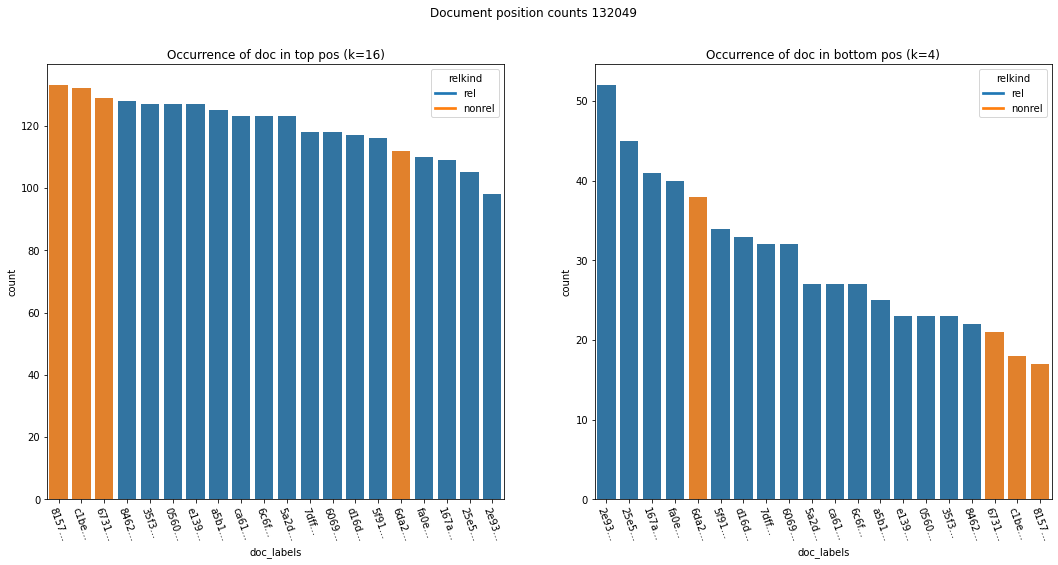

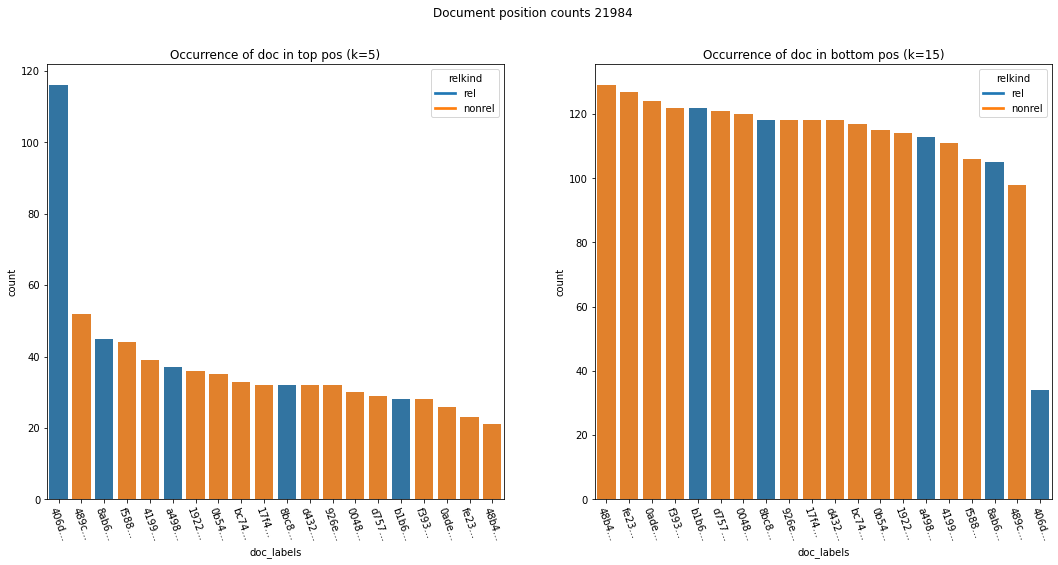

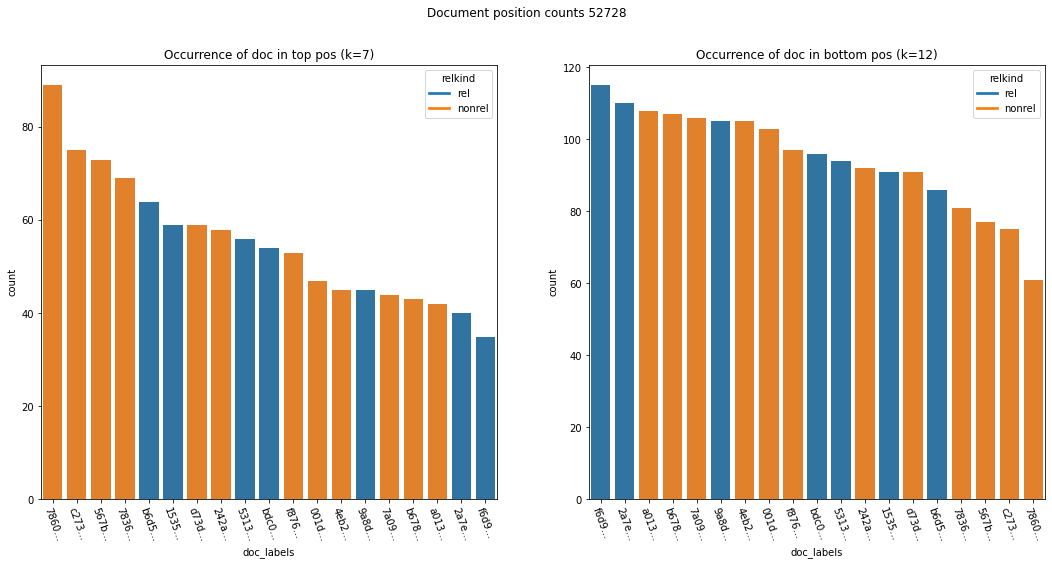

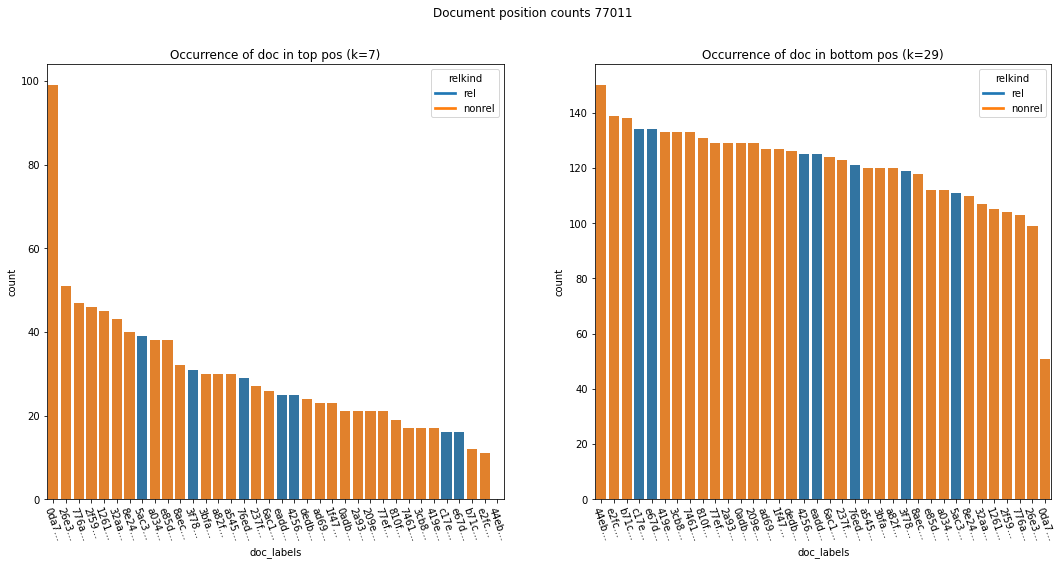

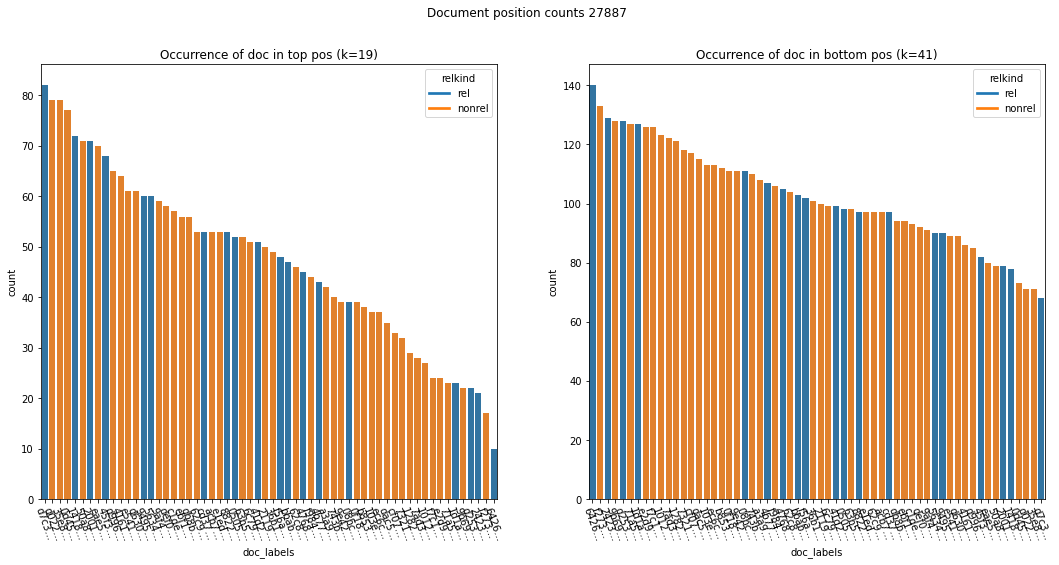

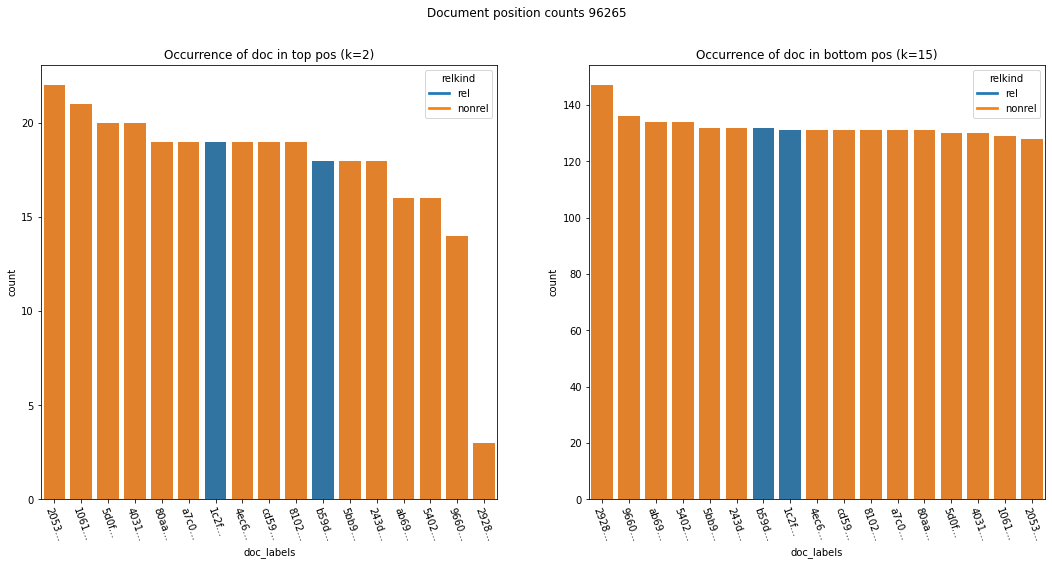

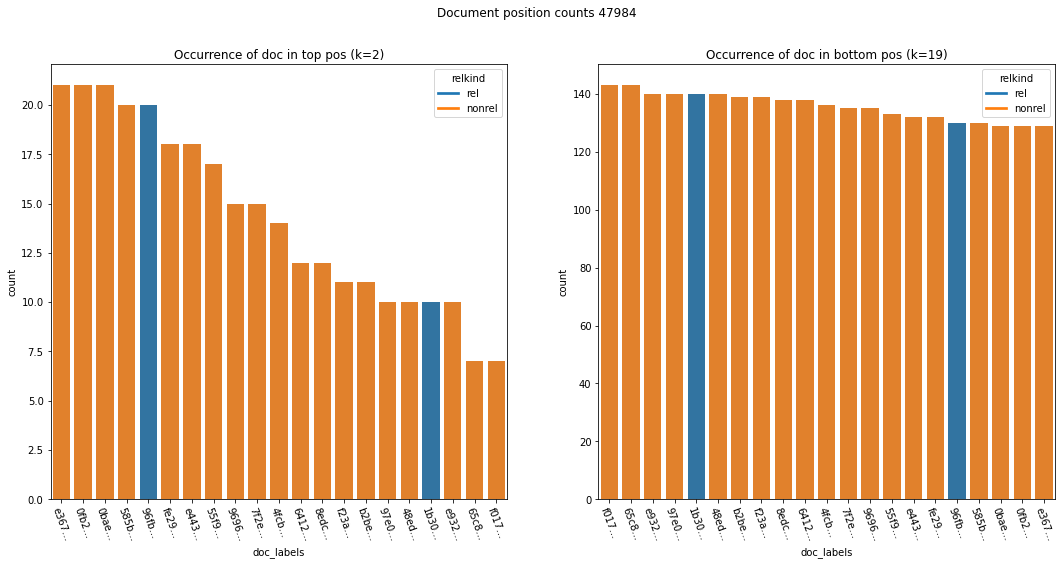

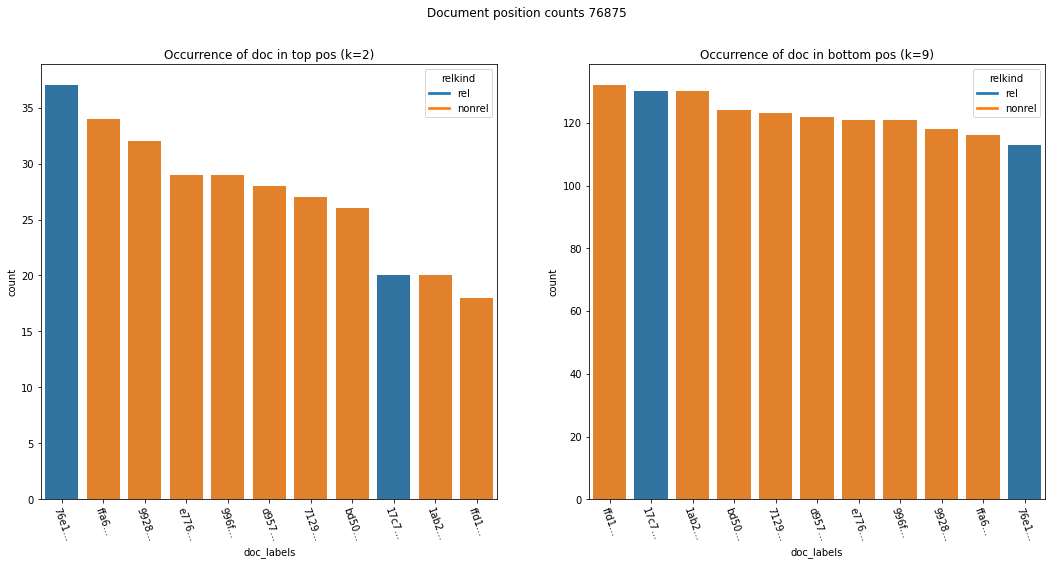

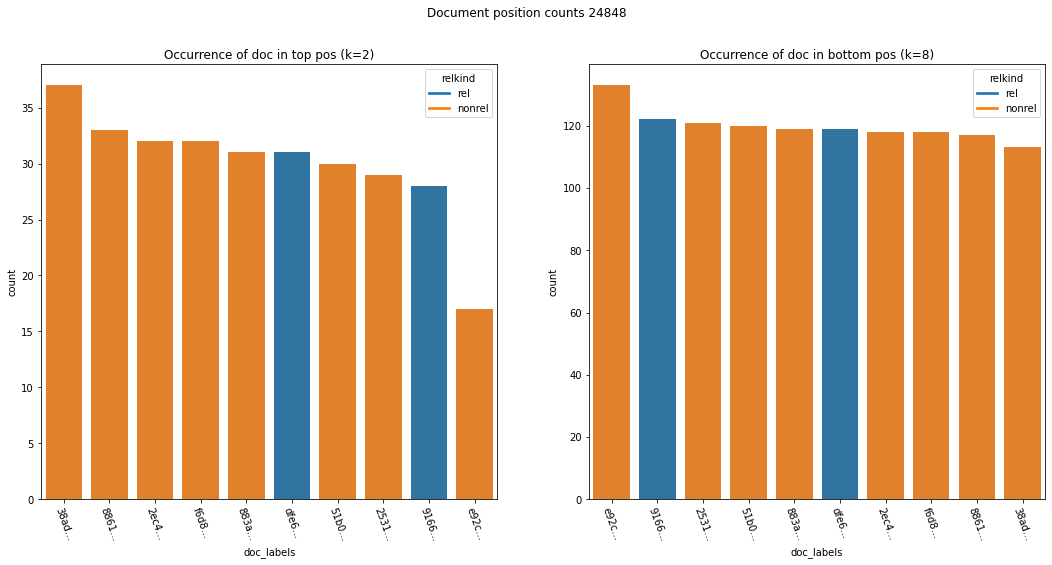

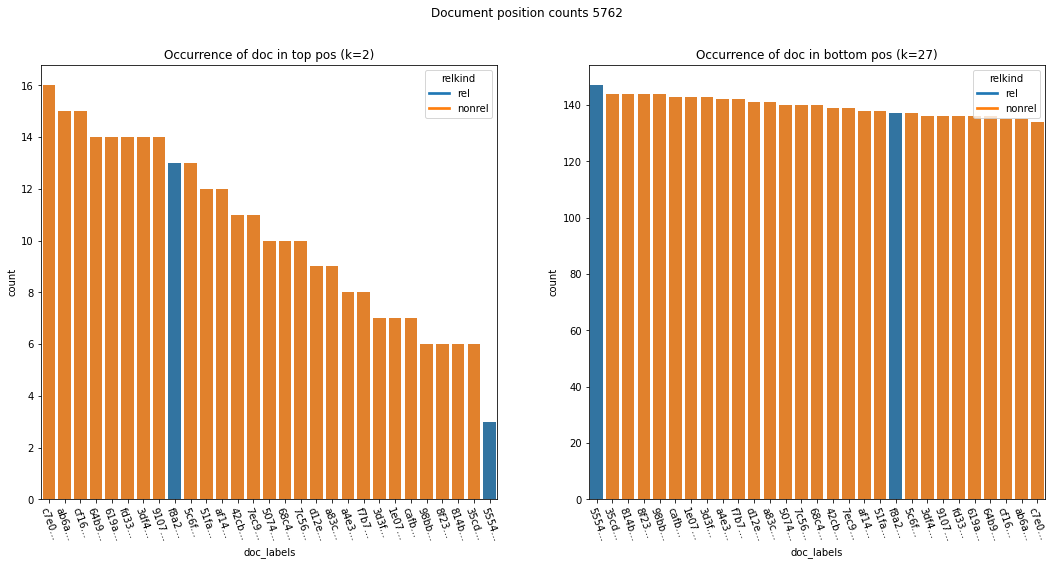

In [309]:
for q in inspectdf.qid.drop_duplicates().to_list():
        plot_doc_pos_count_for_qid(q,rdf,reldf,sortby=['count'])

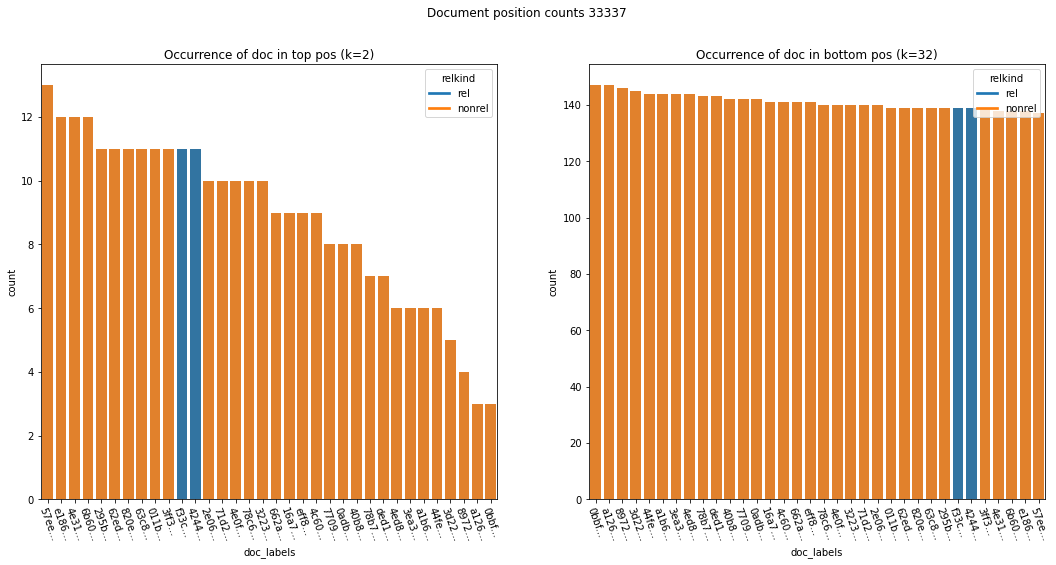

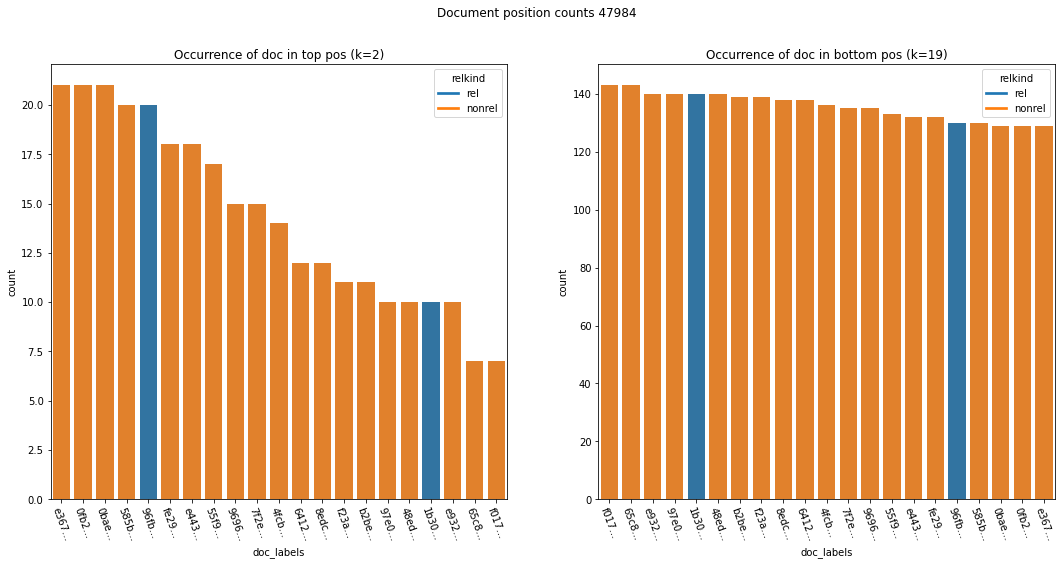

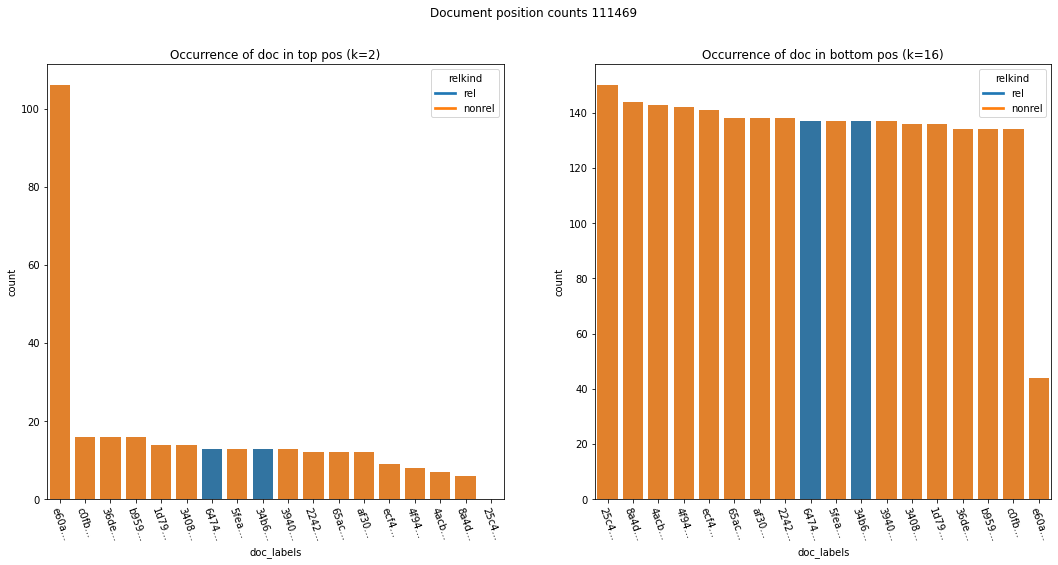

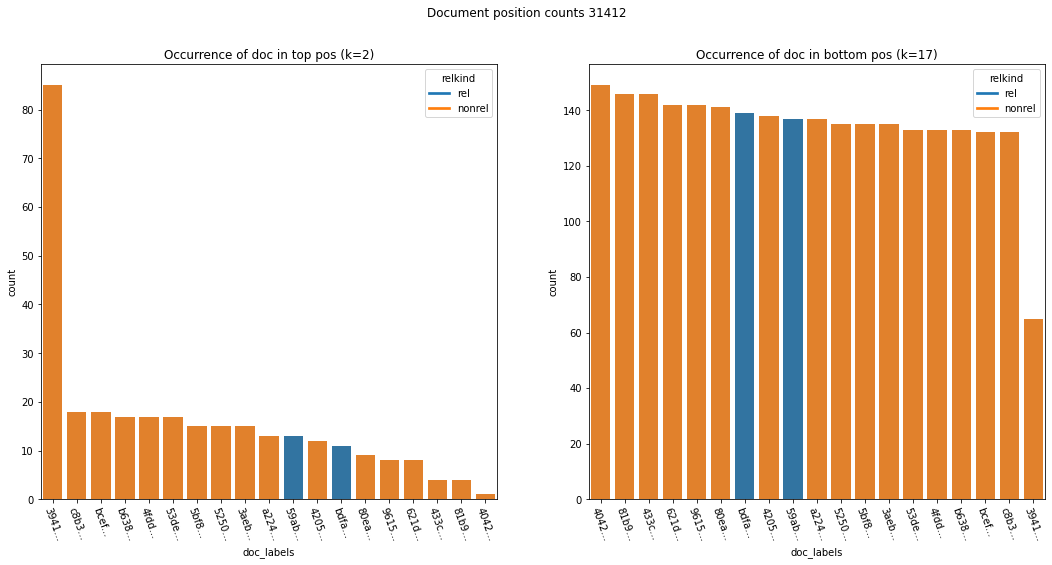

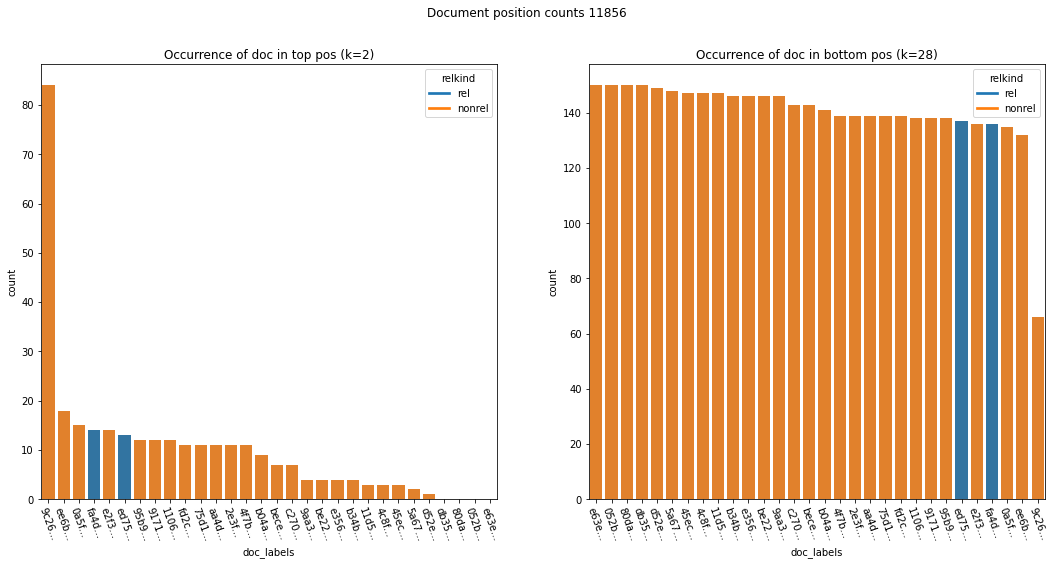

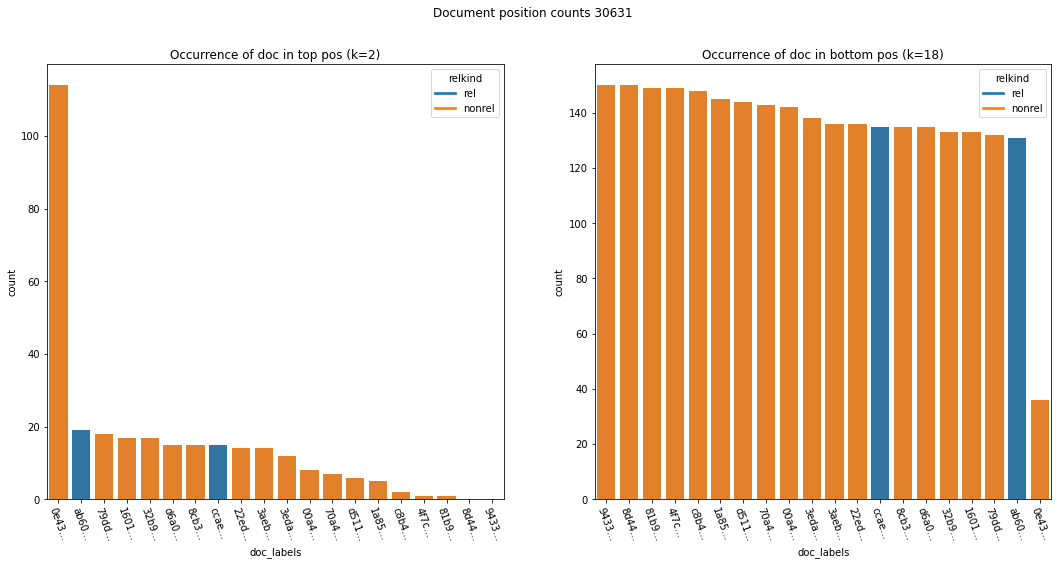

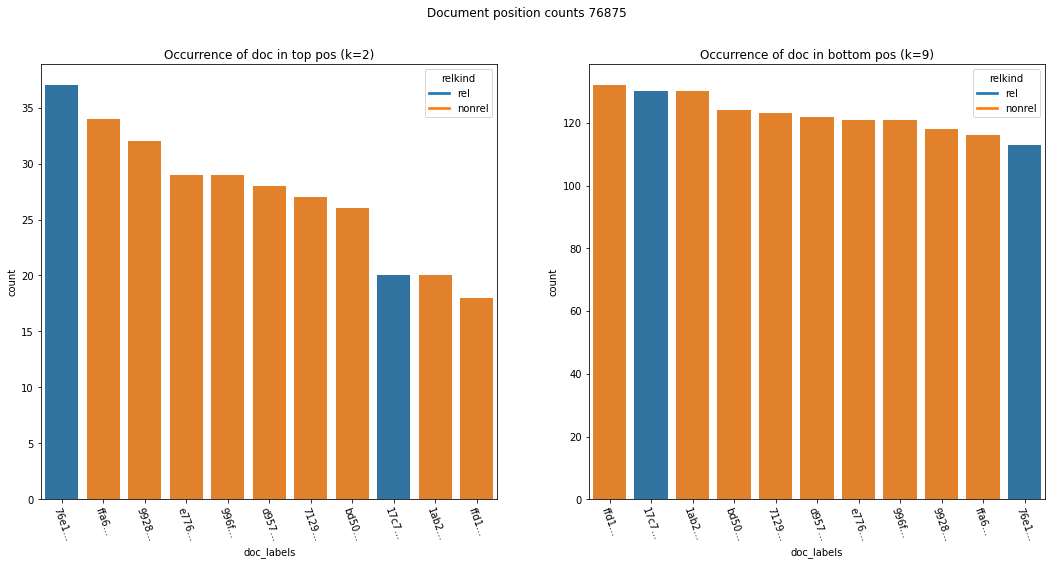

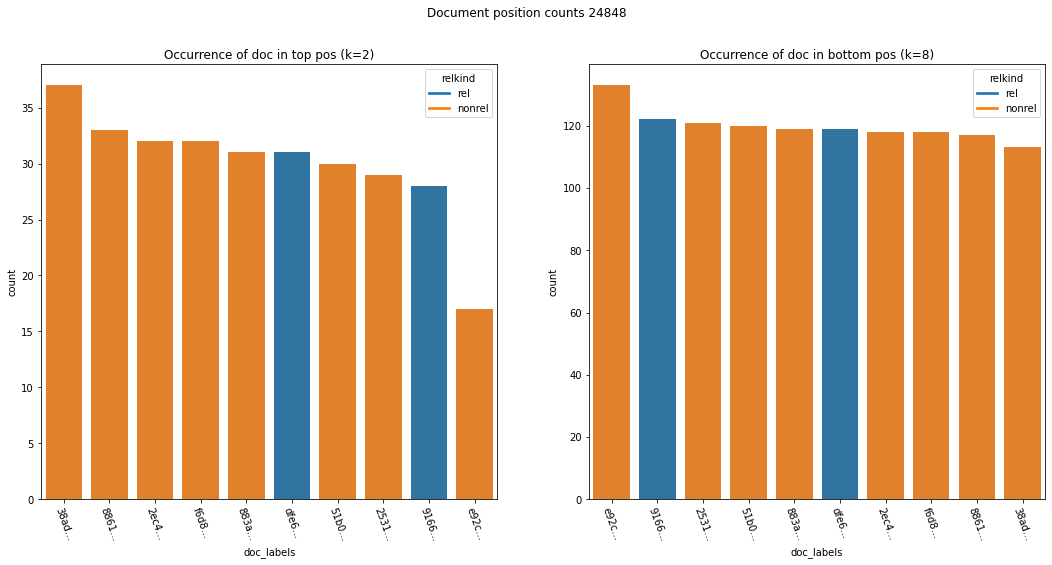

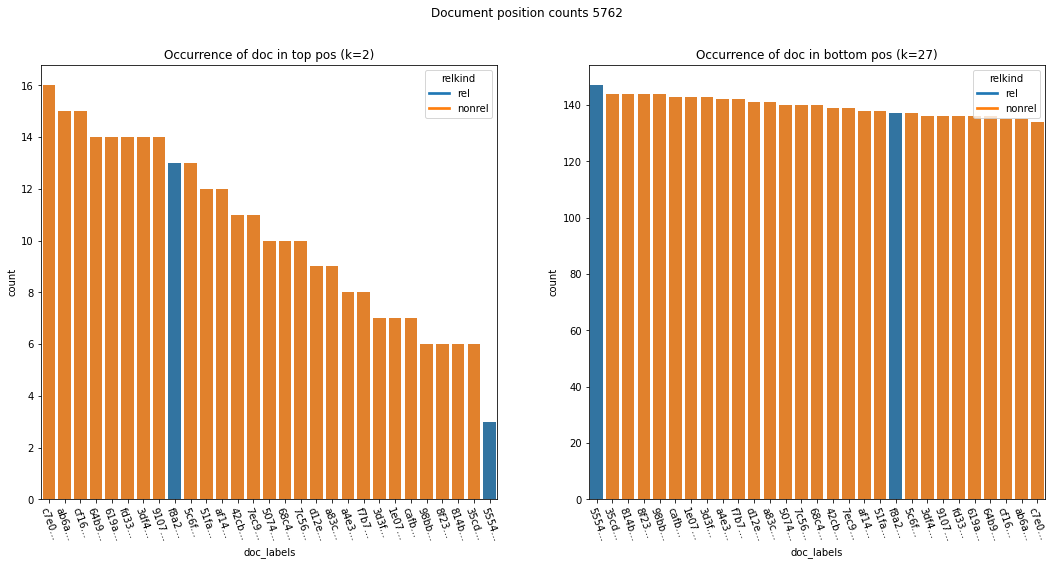

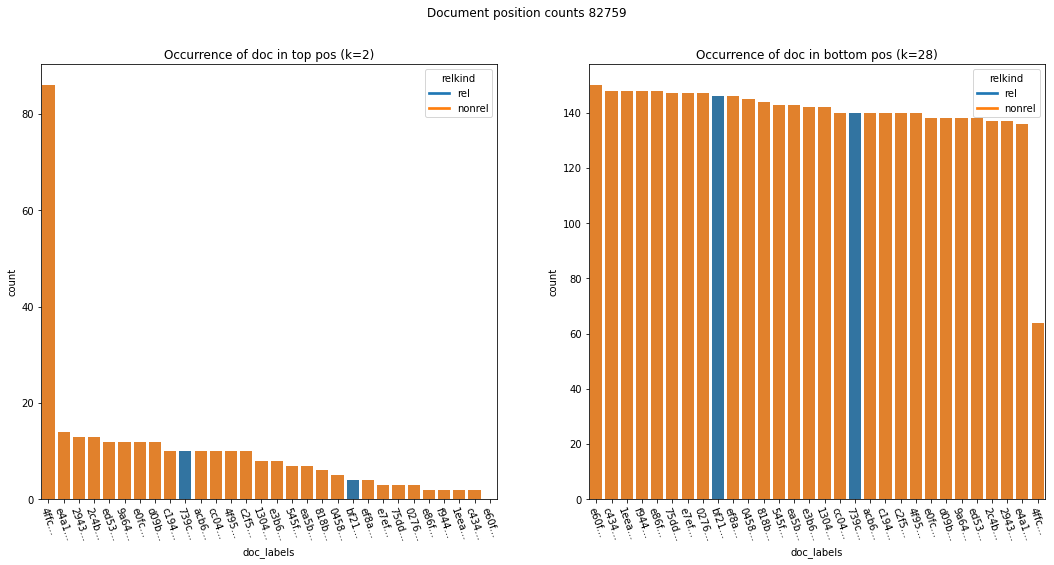

In [315]:
for q in edf.tail(10).iloc[::-1].qid.to_list():
    plot_doc_pos_count_for_qid(q,rdf,reldf,sortby=['count'])

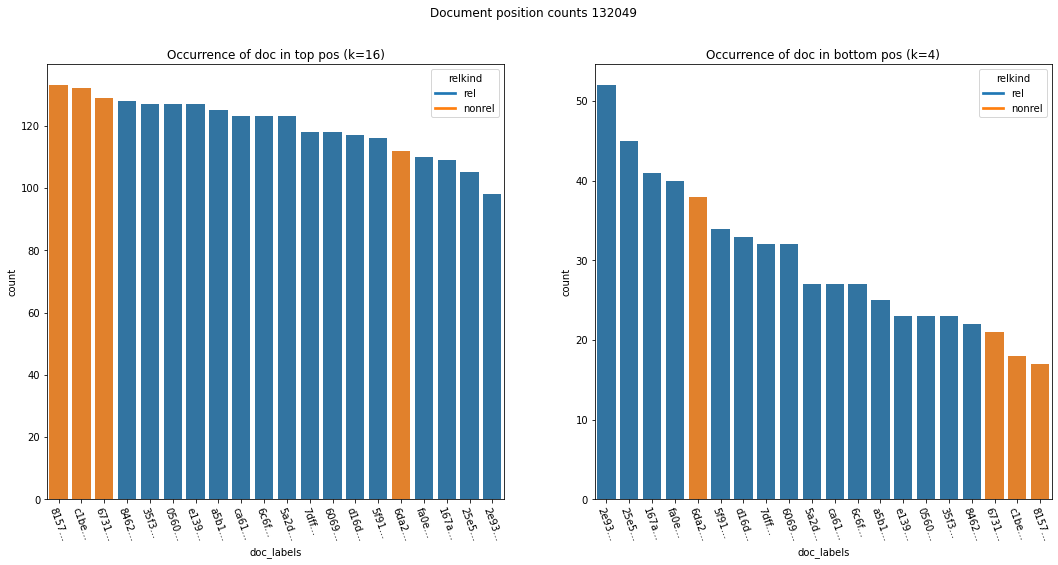

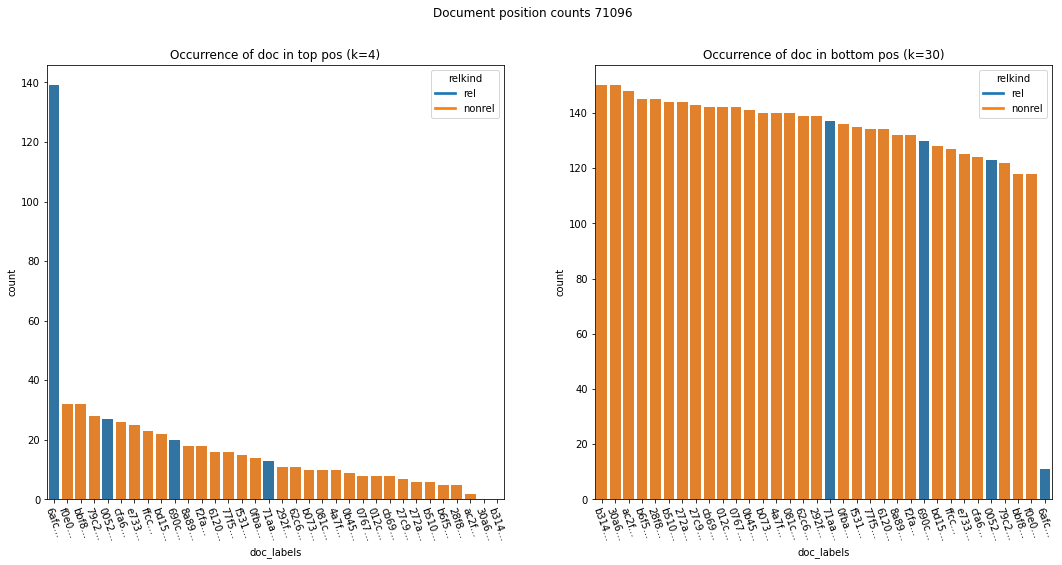

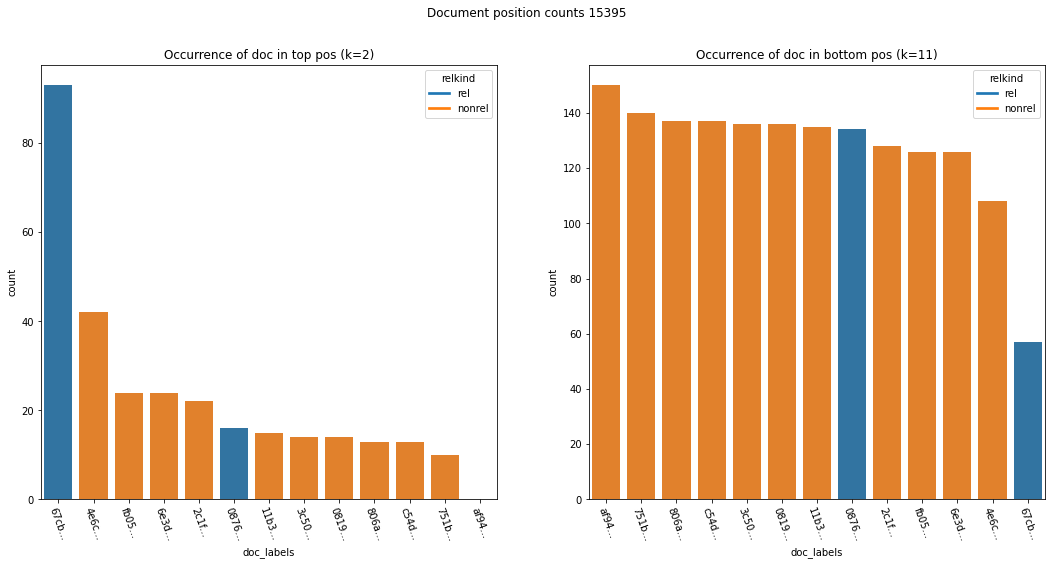

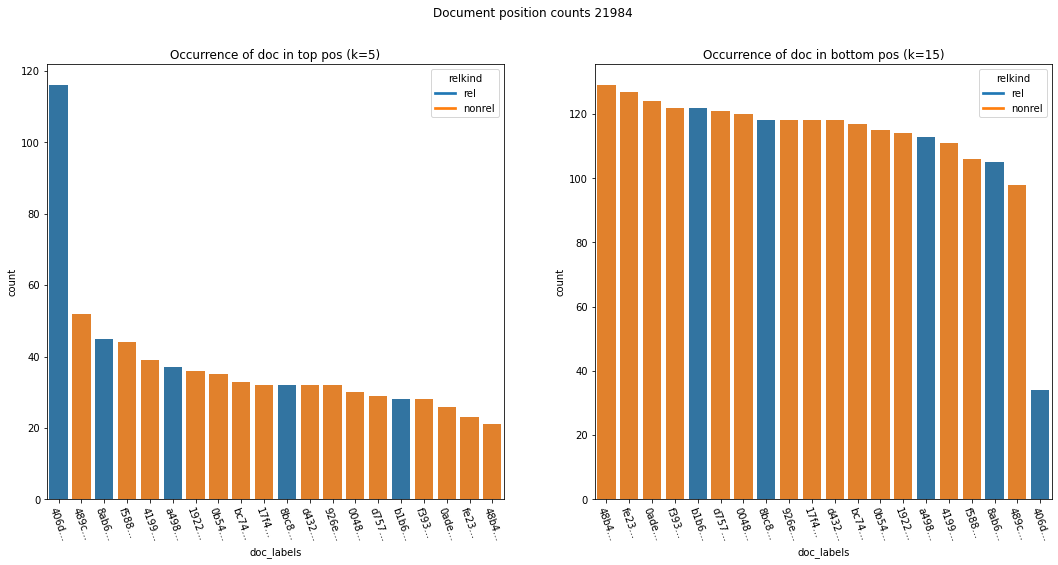

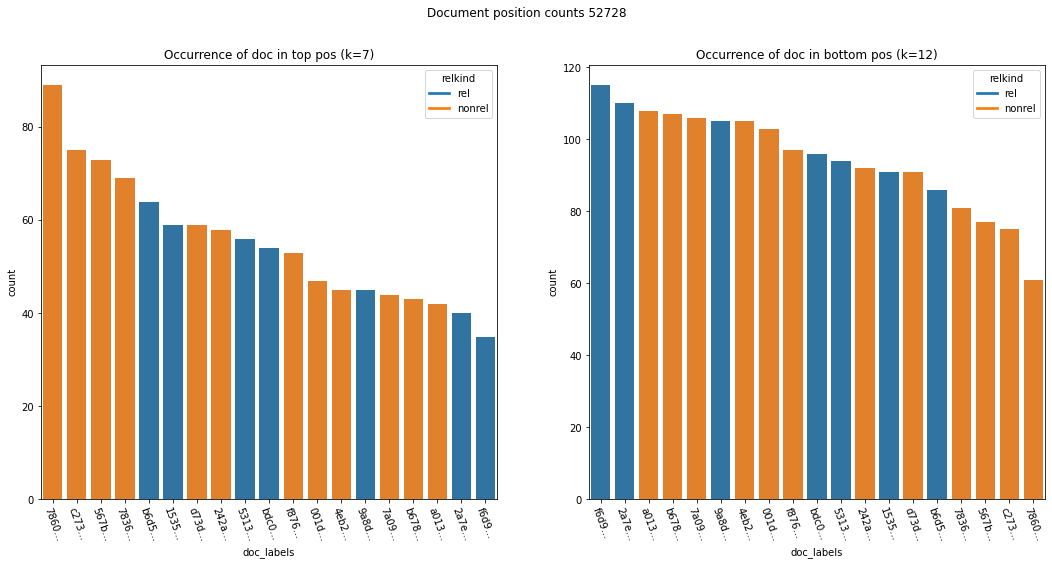

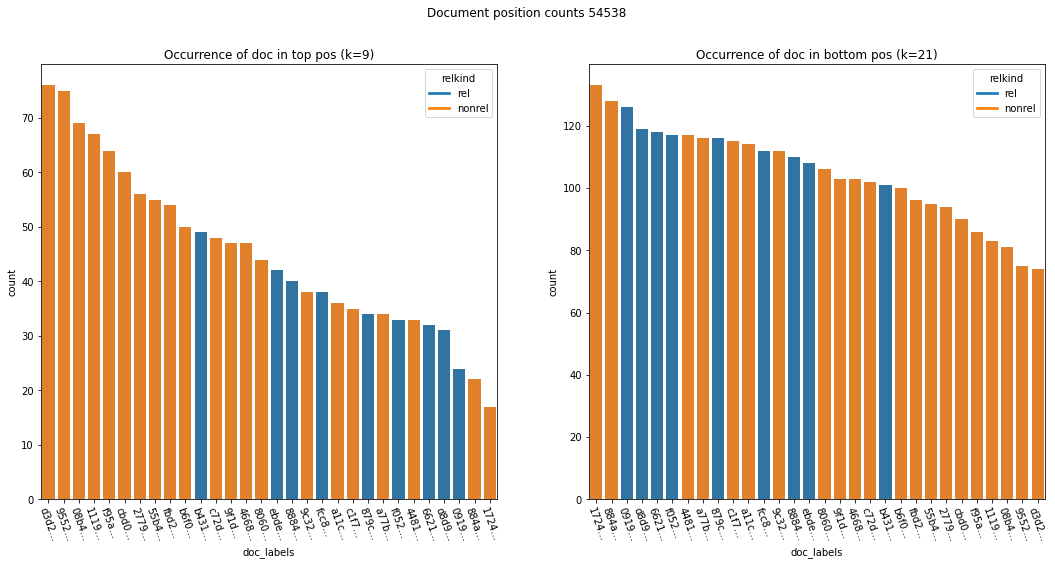

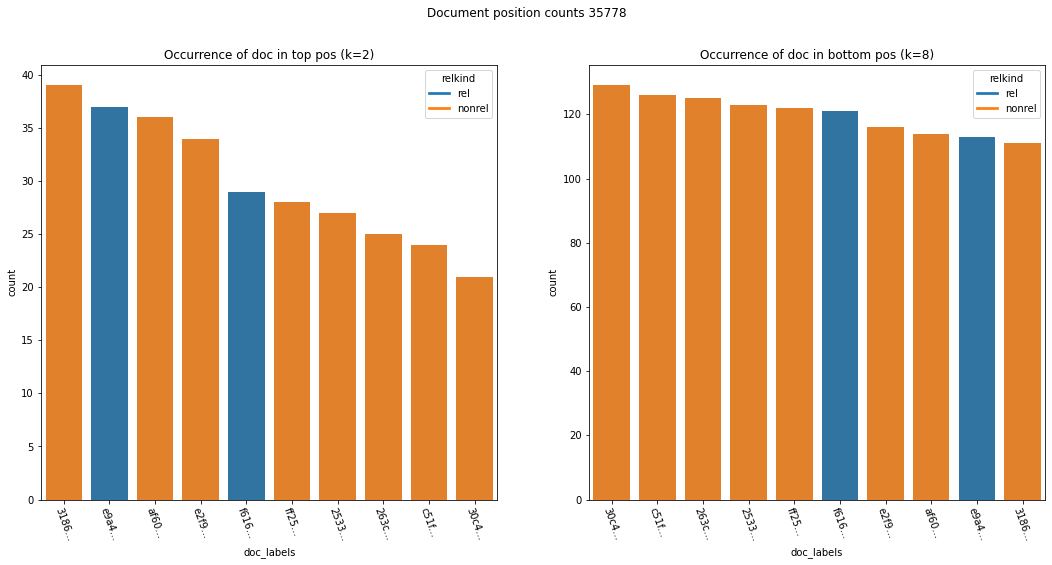

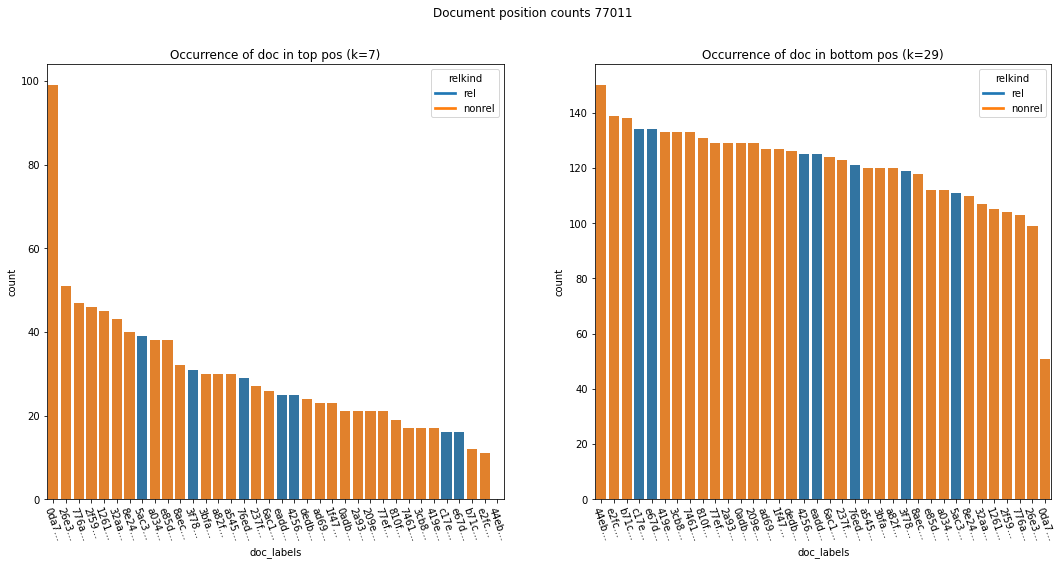

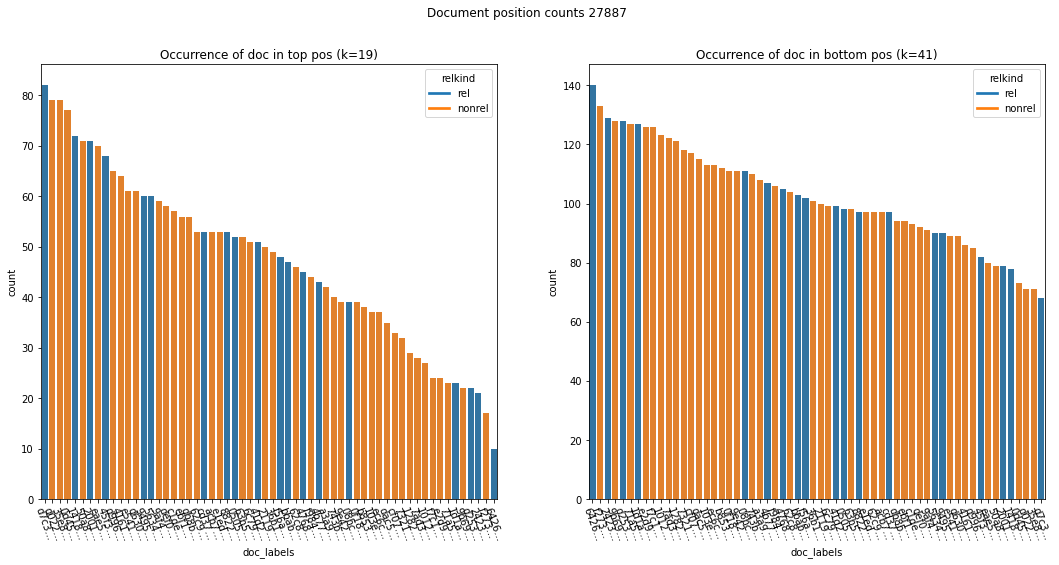

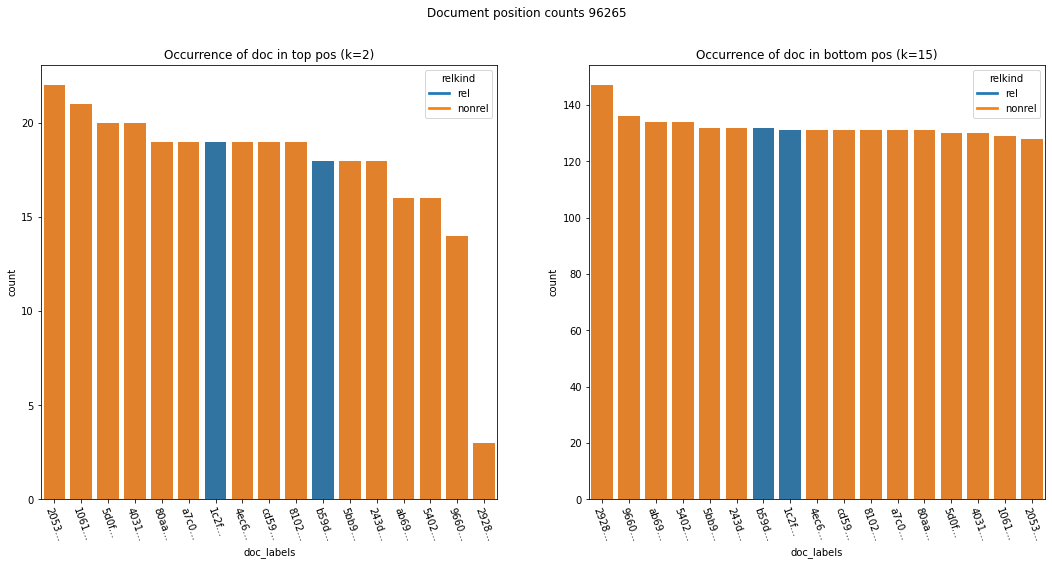

In [308]:
for q in edf.head(10).qid.to_list():
    plot_doc_pos_count_for_qid(q,rdf,reldf,sortby=['count'])

#### Inspect documents of interest

##### Estimated relevances

In [325]:
inspectdf

count                                    doc_id doc_rel  pos     qid topbot
17    52  2e93445410af33f0c377ed65bcc4ac74a8826ae2       1  bot  132049    top
29    45  25e5f01d3d4b05a01beaacf33c2c30628f0679ca       1  bot  132049    top
7     41  167abf8617dc3a30990addfcf6fb3161ff222f21       1  bot  132049    top
31    40  fa0e2faa4cc284cedd3be5cd192710a6b2a09b9a       1  bot  132049    top
39   122  b1b68f721e5126c4f1c1cc7c0bbc91071eaac222       1  bot   21984    top
1    115  f6d9f8a64f20c26d83b0b0cdc5c9131c1822858c       1  bot   52728    top
3    110  2a7e7fba70c6ad91e79b5d4fdd1f487551a808bb       1  bot   52728    top
15   126  091904c2b9d8ef6fe127b97d461c8e51d20237be       1  bot   54538    top
17   119  d8d969c4c74f2759e0eccd9fd5b6b775036650f1       1  bot   54538    top
3    118  6621f6f8087226645cc00120a9b14da4354518ca       1  bot   54538    top
1    117  f0524d5c84f237d57c4a1071bd9dc52e701feb05       1  bot   54538    top
13   116  879c8af3f0aca90e17e4008b7c914438bbee3495       1  bot   54538    top
27   134  c17e5dc7ec9a75f04fe52743d87fea0eb00246b2       1  bot   77011    top
23   134  e67d3aa62e94d370e957b0502762803ec43c14b2       1  bot   77011    top
95   140  6426c1444b4b397982ae1b8782dba53ad662fbeb       1  bot   27887    top
5    129  2423ea8cf66765d79363988086bf0f6066a13872       1  bot   27887    top
7    128  d253458401932876e55c3a2a7cb7718e57dd8160       1  bot   27887    top
11   127  1d1ab0f586eadfa1054be723d58f6cef2fba0e6d       1  bot   27887    top
5    132  b59dcbab074348294b934346268b65ce49385f78       1  bot   96265    top
29   140  1b303e6f3e4213cccba4e08ac5e75b4c9790d213       1  bot   47984    bot
19   130  17c780c1aca508a3172fa0d5dd1bf10168a10f54       1  bot   76875    bot
13   122  9166a7cd5aea96f3206a8aadeb2d6f7094a983c0       1  bot   24848    bot
51   147  55545d2c73cce5d3f2ad42f04b6cbcee5a2d4144       1  bot    5762    bot

In [328]:
inpspectdf_select = inspectdf[inspectdf.doc_id.isin(['2e93445410af33f0c377ed65bcc4ac74a8826ae2',
                                                     '2a7e7fba70c6ad91e79b5d4fdd1f487551a808bb',
                                                    '6426c1444b4b397982ae1b8782dba53ad662fbeb',
                                                    '1b303e6f3e4213cccba4e08ac5e75b4c9790d213',
                                                    '17c780c1aca508a3172fa0d5dd1bf10168a10f54',
                                                    '55545d2c73cce5d3f2ad42f04b6cbcee5a2d4144'])]
                              
inpspectdf_select

count                                    doc_id doc_rel  pos     qid topbot
17    52  2e93445410af33f0c377ed65bcc4ac74a8826ae2       1  bot  132049    top
3    110  2a7e7fba70c6ad91e79b5d4fdd1f487551a808bb       1  bot   52728    top
95   140  6426c1444b4b397982ae1b8782dba53ad662fbeb       1  bot   27887    top
29   140  1b303e6f3e4213cccba4e08ac5e75b4c9790d213       1  bot   47984    bot
19   130  17c780c1aca508a3172fa0d5dd1bf10168a10f54       1  bot   76875    bot
51   147  55545d2c73cce5d3f2ad42f04b6cbcee5a2d4144       1  bot    5762    bot

In [333]:
inspectrels = pd.merge(inspectdf.rename({'doc_rel':'relevance'},axis=1), est_rel_meta, on=['qid','doc_id','relevance'], how='left')
inspectrels

count                                    doc_id relevance  pos     qid  \
0     52  2e93445410af33f0c377ed65bcc4ac74a8826ae2         1  bot  132049   
1     45  25e5f01d3d4b05a01beaacf33c2c30628f0679ca         1  bot  132049   
2     41  167abf8617dc3a30990addfcf6fb3161ff222f21         1  bot  132049   
3     40  fa0e2faa4cc284cedd3be5cd192710a6b2a09b9a         1  bot  132049   
4    122  b1b68f721e5126c4f1c1cc7c0bbc91071eaac222         1  bot   21984   
5    115  f6d9f8a64f20c26d83b0b0cdc5c9131c1822858c         1  bot   52728   
6    110  2a7e7fba70c6ad91e79b5d4fdd1f487551a808bb         1  bot   52728   
7    126  091904c2b9d8ef6fe127b97d461c8e51d20237be         1  bot   54538   
8    119  d8d969c4c74f2759e0eccd9fd5b6b775036650f1         1  bot   54538   
9    118  6621f6f8087226645cc00120a9b14da4354518ca         1  bot   54538   
10   117  f0524d5c84f237d57c4a1071bd9dc52e701feb05         1  bot   54538   
11   116  879c8af3f0aca90e17e4008b7c914438bbee3495         1  bot   54538   
12   134  c17e5dc7ec9a75f04fe52743d87fea0eb00246b2         1  bot   77011   
13   134  e67d3aa62e94d370e957b0502762803ec43c14b2         1  bot   77011   
14   140  6426c1444b4b397982ae1b8782dba53ad662fbeb         1  bot   27887   
15   129  2423ea8cf66765d79363988086bf0f6066a13872         1  bot   27887   
16   128  d253458401932876e55c3a2a7cb7718e57dd8160         1  bot   27887   
17   127  1d1ab0f586eadfa1054be723d58f6cef2fba0e6d         1  bot   27887   
18   132  b59dcbab074348294b934346268b65ce49385f78         1  bot   96265   
19   140  1b303e6f3e4213cccba4e08ac5e75b4c9790d213         1  bot   47984   
20   130  17c780c1aca508a3172fa0d5dd1bf10168a10f54         1  bot   76875   
21   122  9166a7cd5aea96f3206a8aadeb2d6f7094a983c0         1  bot   24848   
22   147  55545d2c73cce5d3f2ad42f04b6cbcee5a2d4144         1  bot    5762   

   topbot  est_relevance  
0     top       0.187206  
1     top       0.179613  
2     top       0.187206  
3     top       0.179613  
4     top       0.067000  
5     top       0.236089  
6     top       0.233840  
7     top       0.199217  
8     top       0.191665  
9     top       0.248919  
10    top       0.248919  
11    top       0.201634  
12    top       0.184173  
13    top       0.205129  
14    top       0.126915  
15    top       0.256212  
16    top       0.239571  
17    top       0.220084  
18    top       0.178142  
19    bot       0.121704  
20    bot       0.083762  
21    bot       0.163524  
22    bot       0.076639

In [330]:
inspectrels.est_relevance.mean()

0.18333806712472892

In [331]:
inspectrels.est_relevance.min()

0.0669999602274531

In [332]:
inspectrels.est_relevance.max()

0.25621193351684

In [334]:
inspectrels[inspectrels.topbot=='top'].est_relevance.mean()

0.19848138036106452

In [335]:
inspectrels[inspectrels.topbot=='top'].est_relevance.min()

0.0669999602274531

In [336]:
inspectrels[inspectrels.topbot=='top'].est_relevance.max()

0.25621193351684

In [337]:
inspectrels[inspectrels.topbot=='bot'].est_relevance.mean()

0.11140732925213481

In [338]:
inspectrels[inspectrels.topbot=='bot'].est_relevance.min()

0.0766392048464476

In [339]:
inspectrels[inspectrels.topbot=='bot'].est_relevance.max()

0.16352391775566502

In [340]:
for i, row in inspectdf.iterrows():
    estrel = est_rel_meta[(est_rel_meta.qid == row.qid) & (est_rel_meta.doc_id == row.doc_id)].est_relevance.to_list()[0]
    print(row.qid,'\t', row.doc_id, '\t', row.topbot,'\t', estrel)

132049 	 2e93445410af33f0c377ed65bcc4ac74a8826ae2 	 top 	 0.187206085519219
132049 	 25e5f01d3d4b05a01beaacf33c2c30628f0679ca 	 top 	 0.179613166813848
132049 	 167abf8617dc3a30990addfcf6fb3161ff222f21 	 top 	 0.187206085519219
132049 	 fa0e2faa4cc284cedd3be5cd192710a6b2a09b9a 	 top 	 0.179613166813848
21984 	 b1b68f721e5126c4f1c1cc7c0bbc91071eaac222 	 top 	 0.0669999602274531
52728 	 f6d9f8a64f20c26d83b0b0cdc5c9131c1822858c 	 top 	 0.236088575157381
52728 	 2a7e7fba70c6ad91e79b5d4fdd1f487551a808bb 	 top 	 0.233839881533441
54538 	 091904c2b9d8ef6fe127b97d461c8e51d20237be 	 top 	 0.19921712924843402
54538 	 d8d969c4c74f2759e0eccd9fd5b6b775036650f1 	 top 	 0.191665177636188
54538 	 6621f6f8087226645cc00120a9b14da4354518ca 	 top 	 0.24891895317031898
54538 	 f0524d5c84f237d57c4a1071bd9dc52e701feb05 	 top 	 0.24891895317031898
54538 	 879c8af3f0aca90e17e4008b7c914438bbee3495 	 top 	 0.20163352601981896
77011 	 c17e5dc7ec9a75f04fe52743d87fea0eb00246b2 	 top 	 0.184173427469443
77011 	 e67d

In [ ]:
for i, row in inspectdf.iterrows():
    estrel = est_rel_meta[(est_rel_meta.qid == row.qid) & (est_rel_meta.doc_id == row.doc_id)].est_relevance.to_list()[0]
    print(row.qid,'\t', row.doc_id, '\t', row.topbot,'\t', estrel)

In [344]:
est_rel_meta.head()

qid                                    doc_id  relevance  est_relevance
0  5438  3e19046c665867bbe557685da60738a40738010a          0       0.179419
1  5438  7ef08f1fa127af817cdfd9d3bd00bdf60e32143b          0       0.145612
2  5438  ec13c3e7119191802e6f5783d297fe7a5a05293e          0       0.210751
3  5438  8fc928bb430d3f72ac876ca156042ad1860acacd          0       0.079591
4  5438  b2fdee22aa02477292b858fbafcb418932732bce          1       0.260175

In [356]:
inspectdf

count                                    doc_id doc_rel  pos     qid topbot
17    52  2e93445410af33f0c377ed65bcc4ac74a8826ae2       1  bot  132049    top
29    45  25e5f01d3d4b05a01beaacf33c2c30628f0679ca       1  bot  132049    top
7     41  167abf8617dc3a30990addfcf6fb3161ff222f21       1  bot  132049    top
31    40  fa0e2faa4cc284cedd3be5cd192710a6b2a09b9a       1  bot  132049    top
39   122  b1b68f721e5126c4f1c1cc7c0bbc91071eaac222       1  bot   21984    top
1    115  f6d9f8a64f20c26d83b0b0cdc5c9131c1822858c       1  bot   52728    top
3    110  2a7e7fba70c6ad91e79b5d4fdd1f487551a808bb       1  bot   52728    top
15   126  091904c2b9d8ef6fe127b97d461c8e51d20237be       1  bot   54538    top
17   119  d8d969c4c74f2759e0eccd9fd5b6b775036650f1       1  bot   54538    top
3    118  6621f6f8087226645cc00120a9b14da4354518ca       1  bot   54538    top
1    117  f0524d5c84f237d57c4a1071bd9dc52e701feb05       1  bot   54538    top
13   116  879c8af3f0aca90e17e4008b7c914438bbee3495       1  bot   54538    top
27   134  c17e5dc7ec9a75f04fe52743d87fea0eb00246b2       1  bot   77011    top
23   134  e67d3aa62e94d370e957b0502762803ec43c14b2       1  bot   77011    top
95   140  6426c1444b4b397982ae1b8782dba53ad662fbeb       1  bot   27887    top
5    129  2423ea8cf66765d79363988086bf0f6066a13872       1  bot   27887    top
7    128  d253458401932876e55c3a2a7cb7718e57dd8160       1  bot   27887    top
11   127  1d1ab0f586eadfa1054be723d58f6cef2fba0e6d       1  bot   27887    top
5    132  b59dcbab074348294b934346268b65ce49385f78       1  bot   96265    top
29   140  1b303e6f3e4213cccba4e08ac5e75b4c9790d213       1  bot   47984    bot
19   130  17c780c1aca508a3172fa0d5dd1bf10168a10f54       1  bot   76875    bot
13   122  9166a7cd5aea96f3206a8aadeb2d6f7094a983c0       1  bot   24848    bot
51   147  55545d2c73cce5d3f2ad42f04b6cbcee5a2d4144       1  bot    5762    bot

In [365]:
edf.head(10).qid.to_list()

[132049, 71096, 15395, 21984, 52728, 54538, 35778, 77011, 27887, 96265]

In [366]:
edf.tail(10).qid.to_list()

[82759, 5762, 24848, 76875, 30631, 11856, 31412, 111469, 47984, 33337]

In [364]:
for q in inspectdf.qid.drop_duplicates().to_list():
    a = est_rel_meta[est_rel_meta.qid == q].sort_values(by=['qid','est_relevance'],ascending=False)
    a["inspect"] = False
    # print(a)
    a["inspect"] = a.apply(lambda row: row.doc_id in inspectdf[inspectdf.qid == q].doc_id.to_list(),axis=1)
    print(a[['qid','doc_id','est_relevance','inspect']])

         qid                                    doc_id  est_relevance  inspect
2603  132049  5f91afa4ba1591dfd9d35450ac07f41dca1ce4f6       0.198229    False
2587  132049  6c6fc8896569067cf30b0f2349933c7462809912       0.187206    False
2589  132049  6da29e3f7e9ab2cbedccb71201ae62ed52f949a4       0.187206    False
2590  132049  167abf8617dc3a30990addfcf6fb3161ff222f21       0.187206     True
2592  132049  5a2de88464b2307f1fd89f3d84c6d507a49cb47f       0.187206    False
2595  132049  7dff8a6d32efbaa16fb7510b9c3347985de71596       0.187206    False
2597  132049  a5b1fe9129df3f499eeeb7c30913109e448a1174       0.187206    False
2598  132049  ca614b83b9496ef4893881a713195c5389c19ec8       0.187206    False
2599  132049  2e93445410af33f0c377ed65bcc4ac74a8826ae2       0.187206     True
2586  132049  d16d4ab632d18d70c0ffd9d4d7493444281275e5       0.179613    False
2588  132049  e13918f61745d29a2e84101ebfc46e9487d38fca       0.179613    False
2593  132049  35f38d22d658330d980eb78f4774ad1a68a11e

#### Authors

In [367]:
es = Elasticsearch([{'timeout':300}])
inspect_ids = inspectdf.doc_id.to_list()
res = es.search(index='semanticscholar2020og', body={'size':len(inspect_ids),'query':{'ids':{'values':inspect_ids}}})
ret_ids = [hit['_id'] for hit in res['hits']['hits']]
not_in_index = list(set(inspect_ids) - set(ret_ids))
no_author_in_idx = [hit['_id'] for hit in res['hits']['hits'] if not hit['_source']['author_ids']]
    
no_author = list(set(not_in_index + no_author_in_idx))
    

In [368]:
no_author

[]

In [369]:
res

{'took': 6050,
 'timed_out': False,
 '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0},
 'hits': {'total': {'value': 23, 'relation': 'eq'},
  'max_score': 1.0,
  'hits': [{'_index': 'semanticscholar2020og',
    '_type': 'document',
    '_id': '6621f6f8087226645cc00120a9b14da4354518ca',
    '_score': 1.0,
    '_source': {'title': 'Influence of violent media on children and adolescents',
     'paperAbstract': 'In their review on the influence of violent media on children and adolescents, Kevin Browne and Catherine HamiltonGiachritsis (Feb 19, p 702) raise the question of why children and adolescents are more susceptible to media violence than adults. The effects of television are best understood in terms of rote learning—ie, by the brain digesting thousands of examples and thereby shaping synaptic connections, a process usually referred to as neuroplasticity. Lundborg and Rosén made the link between age and the speed of synaptic change quite clear. They plotted the resu

# Old

## Hypotheses

Based on the plots we form a number of hypotheses:

1. Queries perform well when they have a high fraction of relevant items.
2. Queries perform well when they have a large number of items.
3. Queries perform poorly when they have many documents without author.
 - Conversely: queries perform well when they have many many documents without author, because then the ranking is more or less relevance-based.

4. All of the documents that spike in the rankings have no author.
5. Documents that are missing from their "proper" position (mainly relevant documents for top positions) have a low estimated relevance.



6. Documents for which the estimated relevance is too high/too low have been incorrectly judged by the NIST assessors.



7. For top queries, the documents without author are mainly relevant. For bottom queries, they are mainly irrelevant.

check:
- for each query for each rank, how often does a no-author document appear there and is it relevant or not?
    

### Hypothesis 1: Queries perform well when they have a high fraction of relevant items

In [ ]:
def get_k_results(eval_df,k=10,asc=True):
    sub = eval_df.sort_values(by='difference',ascending=asc).head(k).reset_index()
    return sub

In [ ]:
def rel_nonrel_stats_df(eval_df, k=10, asc=True):
    sub = get_k_results(eval_df,k,asc)
    sub[['r','nr']] = sub.apply(lambda row: count_relgrades_qid(row.qid,reldf), axis='columns', result_type='expand')
    sub[['rfrac','nrfrac']] = sub.apply(lambda row: {'rfrac': row.r / (row.r + row.nr), 'nrfrac': row.nr / (row.r + row.nr) }, axis='columns', result_type='expand')
    return sub

In [ ]:
print("DGEE > mean:\t", len(edf[edf.difference > edf.difference.mean()]))
print()
print("DGEE <= mean:\t", len(edf[edf.difference <= edf.difference.mean()]))

Taking the average across all queries that have a difference lower (higher) than the mean, the items with a lower mean have a higher fraction of relevant items than the items that have a higher mean.

In [ ]:
top = rel_nonrel_stats_df(edf, k=len(edf[edf.difference <= edf.difference.mean()]))
bot = rel_nonrel_stats_df(edf, k=len(edf[edf.difference > edf.difference.mean()]), asc=False)

print("topqueries relmean:\t", top.rfrac.mean(),'\t',"botqueries relmean:\t\t", bot.rfrac.mean())
print("topqueries non-relmean:\t", top.nrfrac.mean(),'\t',"botqueries non-relmean:\t",bot.nrfrac.mean())


The effect is even more clear if we look at the top and bottom 20 queries.

In [ ]:
top = rel_nonrel_stats_df(edf,k=20)
bot = rel_nonrel_stats_df(edf,k=20,asc=False)
print("topk=20 relmean:\t",top.rfrac.mean(),'\tbotk=20 relmean:\t',bot.rfrac.mean())
print("topk=20 nrelmean:\t",top.nrfrac.mean(),'\tbotk=20 nrelmean:\t',bot.nrfrac.mean())


In [ ]:
for i in range(1,21):
    top = rel_nonrel_stats_df(edf,k=i)
    bot = rel_nonrel_stats_df(edf,k=i,asc=False)
    print(f"k={i}")
    print(f"top r:\t",round(top.rfrac.mean(),2),f'\tbot r:\t',round(bot.rfrac.mean(),2))
    print(f"top nr:\t",round(top.nrfrac.mean(),2),f'\tbot nr:\t',round(bot.nrfrac.mean(),2))
    print()

In [ ]:
data = rel_nonrel_stats_df(edf,k=200).reset_index()
data.head(5)

In [ ]:
# sns.scatterplot(data=data, x="index", y="rfrac")
sns.regplot(data=data,x="index", y="rfrac")

We see a light descending line; the hypothesis is confirmed. The top queries have a higher fraction of relevant versus non-relevant items.

#### Subypothesis: The top queries have a higher average predicted relevance

- sum of estimated relevances for each relkind divided by number of items for that relkind

In [ ]:
rel_and_estrel = pd.merge(pd.merge(edf.reset_index(),reldf[['qid','doc_rel','doc_id']], on='qid'),est_rel_meta, on=['qid','doc_id'])
rel_and_estrel['rel_estrel_diff'] = rel_and_estrel.apply(lambda row: abs(row.doc_rel - row.est_relevance),axis=1)
rel_and_estrel.head()

In [ ]:
mean_estrel_per_relkind = rel_and_estrel.groupby(['qid','doc_rel']).mean().reset_index()
mean_estrel_per_relkind.head()

In [ ]:
desired_index = edf.reset_index().sort_values(by='difference').reset_index(drop=True).reset_index()
desired_index.head()

In [ ]:
mean_estrel_with_index = pd.merge(mean_estrel_per_relkind,desired_index[['index','qid']],on='qid')
mean_estrel_with_index.head()

In [ ]:
pi = iter(sns.color_palette())
f = next(pi)
s = next(pi)
fig, ax = plt.subplots(3,1)
sns.scatterplot(data=mean_estrel_with_index,x='index',y='est_relevance',hue='doc_rel',ax= ax[0])
sns.regplot(data=mean_estrel_with_index[mean_estrel_with_index.doc_rel == 0],x='index',y='est_relevance',ax=ax[1],color=f)
sns.regplot(data=mean_estrel_with_index[mean_estrel_with_index.doc_rel == 1],x='index',y='est_relevance',ax=ax[2],color=s)

The top queries do *not* have a higher average predicted relevance than the bottom queries, so the discrepancy is likely *not* because of the estimated relevances.

#### Subhypothesis: The top queries have a higher fraction of items for which the actual and the predicted relevance are close to each other

Blur factor, fig 1 in [3], blur closer to true relevance is less unfairness compared to Plackett-Luce. May be because is better able to predict based on relevance also?

If the predicted relevances are closer to the actual relevances the ranker is better able to take relevance into account, leading to better results?

Plot: mean difference between predicted and actual relevances
Subplots: split by GT rel and nonrel items

In [ ]:
rel_and_estrel = pd.merge(pd.merge(edf.reset_index(),reldf[['qid','doc_rel','doc_id']], on='qid'),est_rel_meta, on=['qid','doc_id'])
rel_and_estrel['rel_estrel_diff'] = rel_and_estrel.apply(lambda row: abs(row.doc_rel - row.est_relevance),axis=1)
rel_and_estrel.head()

In [ ]:
mean_estrel_diff = rel_and_estrel.groupby('qid', as_index=False).mean()[['qid','difference','doc_rel','rel_estrel_diff']]
estrel_diff_sorted = mean_estrel_diff.sort_values(by='difference').reset_index(drop=True).reset_index()
estrel_diff_sorted.head()

In [ ]:
desired_index = edf.reset_index().sort_values(by='difference').reset_index(drop=True).reset_index()
splitdata = rel_and_estrel.sort_values(by='difference').reset_index(drop=True)
splitdata = pd.merge(splitdata,desired_index[['qid','index']],on='qid')
splitdata.head()

In [ ]:
fig, ax = plt.subplots(1,1)
pi = iter(sns.color_palette())
next(pi)
next(pi)
sns.scatterplot(data=estrel_diff_sorted,x='index',y='rel_estrel_diff',ax=ax,color=next(pi))
fig.suptitle("Mean difference between actual and predicted relevances for each query (sorted by ascending DGEE)")

In [ ]:
fig, ax = plt.subplots(1,1)
pi = iter(sns.color_palette())
next(pi)
sns.scatterplot(data=splitdata[splitdata.doc_rel == 0],x='index',y='rel_estrel_diff', color=next(pi))
fig.suptitle('Difference between estimated and actual relevance for non-relevant documents for each query, ordered by ascending DGEE')

In [ ]:
fig, ax = plt.subplots(1,1)
sns.scatterplot(data=splitdata[splitdata.doc_rel == 1],x='index',y='rel_estrel_diff')
fig.suptitle('Difference between estimated and actual relevance for relevant documents for each query, ordered by ascending DGEE')

We see a couple of things:
1. The mean difference between estimated relevance and actual relevance is larger for the best queries. Contrary to our hypothesis.
2. For the non-relevant items, the difference in estimated and actual relevance is reasonably the same across all queries.
3. For the relevant items, we see a couple of outliers for which the difference is much larger than for the rest of the documents. 

#### To find out
- [ ] Which documents correspond to the outliers?
- [ ] What is their impact on the quality of the rankings?

### Hypothesis 2: Queries perform well when they have a large number of items
The thought being: many items give a chance for averaging out mistakes.

### Hypothesis 4: All of the documents that spike in the rankings have no author.

Show the documents without author in a different color.

In [ ]:
def find_docs_without_author(relevance):
    es = Elasticsearch([{'timeout':300}])
    
    all_ids = list(relevance.doc_id.unique())
    res = es.search(index='semanticscholar2020og', body={'size':len(all_ids),'query':{'ids':{'values':all_ids}}})
    returned_ids = [hit['_id'] for hit in res['hits']['hits']]
    not_in_index = list(set(all_ids) - set(returned_ids))
    no_author_in_idx = [hit['_id'] for hit in res['hits']['hits'] if not hit['_source']['author_ids']]
    
    no_author = list(set(not_in_index + no_author_in_idx))
    return no_author

In [ ]:
def has_author_df(no_author_ids, relevance):
    relevance['has_author'] = relevance.apply(lambda row: row.doc_id not in no_author_ids,axis='columns')
    return relevance[['doc_id','has_author']].drop_duplicates()

In [ ]:
noauth_ids = find_docs_without_author(reldf)

In [ ]:
author_info = has_author_df(find_docs_without_author(reldf),reldf)
author_info.head()

In [ ]:
for q in topqueries.index.unique():
    plot_doc_pos_count_for_qid(q,rdf,reldf,noauth_ids)

In [ ]:
for q in bottomqueries.index.unique():
    plot_doc_pos_count_for_qid(q,rdf,reldf,noauth_ids)

In [ ]:
author_and_estrel = pd.merge(est_rel_meta,author_info,on='doc_id')
author_and_estrel.head()

###### qid = 30631

For query 30631 there is one authorless doc that spikes, and three that don't. These three have a lower est rel than the spiking document, but not *much* lower, aside from one. The three that spike in fact barely appear in the ranking at all...

In [ ]:
inpsect_qid = 30631

In [ ]:
plot_doc_pos_count_for_qid(inpsect_qid,rdf,reldf,noauth_ids)

In [ ]:
est_rel_meta[(est_rel_meta.qid == inpsect_qid) & (est_rel_meta.doc_id.isin(['4f7cebcc071e129d41df4766d1aed1c55e236311',
                                                                      '943320b3c05a7aeace900e28d0c6d434804363b4',
                                                                      '8d442ea1c14504e6e5676d82e78e1330c354731f',
                                                                      '0e43caeb9d476264d307e8da0ad71ecc4d804ced']))]

In [ ]:
author_and_estrel[author_and_estrel.qid == inpsect_qid].sort_values('est_relevance')

The four documents with no author have some of the lowest estimated relevances for this query. This may explain why some of them are ranked quite lowly. But it's still strange that one of them spikes?

For query 30631 there is one authorless doc that spikes, and three that don't. These three have a lower est rel than the spiking document, but not *much* lower, aside from one. The three that spike in fact barely appear in the ranking at all...

###### qid = 111469

In [ ]:
inpsect_qid = 111469

In [ ]:
plot_doc_pos_count_for_qid(inpsect_qid,rdf,reldf,noauth_ids)

In [ ]:
est_rel_meta[(est_rel_meta.qid == inpsect_qid) & (est_rel_meta.doc_id.isin(['e60af557a1bbfd9b2adee8a3c090d27faab86632',
                                                                      '25c40e796680cdea53578dfad8c7bdbae7ee56a5']))]

In [ ]:
author_and_estrel[author_and_estrel.qid == inpsect_qid].sort_values('est_relevance')

The documents without authors for this query have the highest and the lowest relevance. This is reflected in how often they appear in the top of the ranking.

###### qid = 71096

In [ ]:
inpsect_qid = 71096

In [ ]:
plot_doc_pos_count_for_qid(inpsect_qid,rdf,reldf,noauth_ids)

In [ ]:
est_rel_meta[(est_rel_meta.qid == inpsect_qid) & (est_rel_meta.doc_id.isin(['6afc97668839a439e6858691ada76c9ddf798c2a',
                                                                      '30a698ba5648295c91f00545326931eaf07b00be']))]

In [ ]:
author_and_estrel[author_and_estrel.qid == inpsect_qid].sort_values('est_relevance')

The documents without authors for this query have the highest and the lowest relevance. This is reflected in how often they appear in the top of the ranking.

###### qid = 96265

In [ ]:
inpsect_qid = 96265

In [ ]:
plot_doc_pos_count_for_qid(inpsect_qid,rdf,reldf,noauth_ids)

In [ ]:
author_and_estrel[author_and_estrel.qid == inpsect_qid].sort_values('est_relevance')

The documents without authors for this query have the highest and the lowest relevance. This is reflected in how often they appear in the top of the ranking.

###### qid = 15898

In [ ]:
inpsect_qid = 15395

In [ ]:
plot_doc_pos_count_for_qid(inpsect_qid,rdf,reldf,noauth_ids)

In [ ]:
author_and_estrel[author_and_estrel.qid == inpsect_qid].sort_values('est_relevance')

Document af94eb52e8f7a52b1800414646ab729f34da9191 has a reasonably high estimated relevance but nevertheless never occurs in a top position.

**Hypothesis**: Is this because it has multiple authors? And thus is doubly penalized?
--> no

In [ ]:
adf[adf['id'] == 'af94eb52e8f7a52b1800414646ab729f34da9191']

In [ ]:
pd.merge(author_and_estrel[author_and_estrel.qid == inpsect_qid],adf.rename({'id':'doc_id'},axis=1),on='doc_id',how='left')

Some documents have author in the index but not in the merged annotations file? Has influence on the grouping?


In [ ]:
noauth_ids

Some remarks: 
- Many of the bottom queries indeed have a non-relevant no-author item in a top position, and no relevant no-author items.
- Out of the top queries, two have a relevant no-author item in a top position, and no non-relevant no-author items.

    
- there are still numerous rankings with (top?) documents missing from the ranking, why is that?

## Hypothesis: bottom queries have many items without author
- Because they aren't in the index
- Because they are in the index but don't have an author

1. Find all items in the index that do not have an author
2. Find all items that have an estimated relevance but aren't in the index
3. Check how many of the above items occur in the top and the bottom rankings

In [ ]:
eval_ids = list(reldf.doc_id.unique())
eval_ids[:10]
len(eval_ids)

In [ ]:
est_rel_meta = '../reranking/resources/relevances/Evaluation_rel_scores_model_A.csv'
est_rel_meta = pd.read_csv(est_rel_meta)
est_rel_meta.head()

In [ ]:
est_rel_ids = list(est_rel_meta.doc_id.unique())
est_rel_ids[:10]
len(est_rel_ids)

In [ ]:
all_ids = list(set(eval_ids).union(set(est_rel_ids)))
len(all_ids)

As established earlier in the research process, there are 9 items in the evaluation sample that do not have an estimated relevance.

In [ ]:
no_author = find_docs_without_author(reldf)

Out of the items in the sample file, 4605 are also in the index.

26 items have no author in the index

In [ ]:
topmerge = pd.merge(top[['qid']],reldf[['qid','query','doc_id']],on='qid')
topmerge['has_author'] = topmerge.apply(lambda row: row.doc_id not in no_author,axis='columns')
topmerge.head(10)

In [ ]:
botmerge = pd.merge(bot[['qid']],reldf[['qid','query','doc_id']],on='qid')
botmerge['has_author'] = botmerge.apply(lambda row: row.doc_id not in no_author,axis='columns')
botmerge.head(10)

In [ ]:
topmerge[(topmerge.has_author == False)]

In [ ]:
botmerge[(botmerge.has_author == False)]

In [ ]:
top = get_k_results(edf,138,True)
bot = get_k_results(edf,62,False)
print(top)
print()
print(bot)

In [ ]:
topmerge = pd.merge(top[['qid']],reldf,on='qid')
topmerge['has_author'] = topmerge.apply(lambda row: row.doc_id not in no_author,axis='columns')
topmerge.head(10)

In [ ]:
botmerge = pd.merge(bot[['qid']],reldf,on='qid')
botmerge['has_author'] = botmerge.apply(lambda row: row.doc_id not in no_author,axis='columns')
botmerge.head(10)

only the presence of no-author files does not have to be an issue? or maybe when there are many nauthor docs on the total it levels out because they're all treated the same, so it basically devolves to "random"

In [ ]:
botmerge[(botmerge.has_author == False)]

so, the top document for the worst query doesn't exist in the index. is this one of those documents that exist in the estimated rel files but not the index? --> yes
how are authorless docs treated in this case?
if there is no author, the advantage mean is set to 0. this means that the document is treated as never having an advantage so the hscore is always the same, namely hscore * rho(document)
the rho of 2aa5e431cd45476cc0432722dfa003a641790830 for nle meta is 0.0704727832842697

In [ ]:
topmerge.head(10)

In [ ]:
edf_sorted = edf.sort_values(by='difference').reset_index().reset_index()
edf_sorted.head()
edf_sorted_with_index = pd.merge(edf_sorted,reldf, on='qid')
edf_sorted_with_index.head()

In [ ]:
allres = get_k_results(edf,200,True).reset_index()
allres.head(5)
allmerge = pd.merge(allres,reldf,on='qid')
allmerge['has_author'] = allmerge.apply(lambda row: row.doc_id not in no_author,axis='columns')
allmerge.head()

In [ ]:
all_qs_with_no_auth = allmerge.groupby('qid').filter(lambda df: not df.has_author.all())
all_qs_with_no_auth = all_qs_with_no_auth[['index','qid','difference','query','doc_id','doc_rel', 'has_author']]
len(all_qs_with_no_auth.qid.unique())

There are 58 queries for which one or more documents don't have an author.

In [ ]:
all_qs_with_no_auth.qid.unique()

In [ ]:
all_qs_with_no_auth['index'].unique().mean()

Since the mean is higher than the half of the number of rankings the later ranking are slightly heavier on docs w/out authors.

In [ ]:
allmerge.set_index('index').plot(kind='bar', stacked=True)

In [ ]:
data.head()

In [ ]:
crossdata = pd.crosstab(data['index'],[data['doc_rel'],data['has_author']])

In [ ]:
crossdata.head().columns

In [ ]:
crossdata[(0,False)].to_list()

In [ ]:
crossdata.head().index.to_list()

In [ ]:
np.arange(len(rel_has_author)*2,step=2)

In [ ]:
rel_has_author = np.array(crossdata[(1,True)].to_list())
rel_not_has_author = np.array(crossdata[(1,False)].to_list())
nonrel_has_author = np.array(crossdata[(0,True)].to_list())
nonrel_not_has_author = np.array(crossdata[(0,False)].to_list())
qid = crossdata.index.to_list()

with sns.axes_style("white"):
    sns.set(rc={'figure.figsize':(100,17)})
    sns.set_style("ticks")
    sns.set_context("talk")
    
    # plot details
    bar_width = 5
    epsilon = .015
    line_width = 1
    opacity = 0.7
    pos_bar_positions = np.arange(len(rel_has_author)*2*bar_width,step=2*bar_width)
    neg_bar_positions = pos_bar_positions + bar_width

    # make bar plots
    rel_has_author_bar = plt.bar(pos_bar_positions, rel_has_author, bar_width,
                              color='#ED0020',
                              label='rel + author')
    print(rel_has_author)
    rel_not_has_author_bar = plt.bar(pos_bar_positions, rel_not_has_author, bar_width-epsilon,
                              bottom=rel_has_author,
                              alpha=opacity,
                              color='white',
                              edgecolor='#ED0020',
                              linewidth=line_width,
                              hatch='//',
                              label='rel + no author')
    
    nonrel_has_author_bar = plt.bar(neg_bar_positions, nonrel_has_author, bar_width,
                              color='#0000DD',
                              label='not rel + author')
    nonrel_not_has_author_bar = plt.bar(neg_bar_positions, nonrel_not_has_author, bar_width-epsilon,
                              bottom=nonrel_has_author,
                              color="white",
                              hatch='//',
                              edgecolor='#0000DD',
                              ecolor="#0000DD",
                              linewidth=line_width,
                              label='not rel + no author')
    
    plt.xticks(neg_bar_positions, qid, rotation=90)
    plt.ylabel('Percentage of Samples')
    plt.legend(loc='best')
    sns.despine()

In [ ]:
crossdata.index.to_list()[-10:]

In [ ]:
crossdata.index.to_list()[-10:]

In [ ]:
crossdata.index.to_list()[len(crossdata.index.to_list())-10:len(crossdata.index.to_list())]

In [ ]:
crossdata.index.to_list()[:10]

In [ ]:
def plot_has_authors(crossdata,k=10,asc=True):
    if asc:
        slstart = 0
        slend = k
    else:
        slstart = len(crossdata.index.to_list())-k
        slend = len(crossdata.index.to_list())
    
    
    rel_has_author = np.array(crossdata[(1,True)].to_list()[slstart:slend])
    rel_not_has_author = np.array(crossdata[(1,False)].to_list()[slstart:slend])
    nonrel_has_author = np.array(crossdata[(0,True)].to_list()[slstart:slend])
    nonrel_not_has_author = np.array(crossdata[(0,False)].to_list()[slstart:slend])
    qid = crossdata.index.to_list()[slstart:slend]

    with sns.axes_style("white"):
        sns.set(rc={'figure.figsize':(100,17)})
        sns.set_style("ticks")
        sns.set_context("talk")

        # plot details
        bar_width = 4
        epsilon = .015
        line_width = 1
        opacity = 0.7
        pos_bar_positions = np.arange(len(rel_has_author)*2*bar_width,step=2*bar_width)
        neg_bar_positions = pos_bar_positions + bar_width

        # make bar plots
        rel_has_author_bar = plt.bar(pos_bar_positions, rel_has_author, bar_width,
                                  color='#ED0020',
                                  label='rel + author')
        print(rel_has_author)
        rel_not_has_author_bar = plt.bar(pos_bar_positions, rel_not_has_author, bar_width-epsilon,
                                  bottom=rel_has_author,
                                  alpha=opacity,
                                  color='white',
                                  edgecolor='#ED0020',
                                  linewidth=line_width,
                                  hatch='//',
                                  label='rel + no author')

        nonrel_has_author_bar = plt.bar(neg_bar_positions, nonrel_has_author, bar_width,
                                  color='#0000DD',
                                  label='not rel + author')
        nonrel_not_has_author_bar = plt.bar(neg_bar_positions, nonrel_not_has_author, bar_width-epsilon,
                                  bottom=nonrel_has_author,
                                  color="white",
                                  hatch='//',
                                  edgecolor='#0000DD',
                                  ecolor="#0000DD",
                                  linewidth=line_width,
                                  label='not rel + no author')

        plt.xticks(neg_bar_positions, qid, rotation=90)
        plt.ylabel('Num docs')
        plt.legend(loc='best')
        sns.despine()

In [ ]:
plot_has_authors(crossdata)

In [ ]:
plot_has_authors(crossdata,asc=False)

In [ ]:
dat = crossdata.unstack().reset_index().rename({0:'count'},axis=1)
# dat[dat['index'] <= 10]

In [ ]:
dat = crossdata.unstack().reset_index().rename({0:'count'},axis=1)
# fig, ax = plt.subplots(1,1,figsize = (17.7,8.27))

g = sns.catplot(x="index", y="count",
                hue="has_author", col="doc_rel",
                data=dat[dat['index'] <= 20], kind="bar",
                height=4, aspect=1)
g.fig.set_size_inches(22,8.27)


In [ ]:
g = sns.catplot(x="index", y="count",
                hue="has_author", col="doc_rel",
                data=dat[dat['index'] >= len(dat['index'].unique()) - 20], kind="bar",
                height=4, aspect=1)
g.fig.set_size_inches(22,8.27)

Hypothesis was: bottom queries have many items without author


- Bottom queries mainly have nonrel items without author
- Top queries have both rel and nonrel items without author

Still to check: 


In [ ]:
est_rel_meta.describe()

In [ ]:
reldf.describe()

In [ ]:
pd.merge(est_rel_meta,reldf,on=['qid','doc_id'],how='outer').describe()

In [ ]:
est_and_rel = pd.merge(est_rel_meta,reldf,on=['qid','doc_id'],how='outer').fillna(0)
est_and_rel.head()

In [ ]:
 sns.stripplot(x="doc_rel", y="est_relevance", data=est_and_rel)

interestingly, none of the estimated values are very high? why is that? and there are three points that have rel 1 but are estimated very low, interesting to see if those cause some low results in the rankings

# Bibliography

[1] Buckley, ‘Reliable Information Access Final Workshop Report’.